In [2]:
#!pip install prophet

In [3]:
# Connect to server
#import pyodbc
#from dotenv import dotenv_values

# Datetime
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning
from prophet import Prophet

#Other
import os
import random
import warnings

# ignore warnings
warnings.filterwarnings('ignore')

from pathlib import Path, PureWindowsPath

In [4]:
# Updated plot_predictions to work with dataframes where the date is not already aggregated
# This simply aggregates the dates inside the function
def plot_predictions(date, y_test, y_pred, forecast_label, title):
    """
    Plot the actual and predicted time series data.

    Parameters:
    date (array-like): Date or time index.
    y_test (array-like): Actual values.
    y_pred (array-like): Predicted values.
    forecast_label (str): Label for the forecasted data.
    title (str): Title for the plot.
    """
    # Combine the data into a DataFrame
    data = pd.DataFrame({'Date': date, 'Actual': y_test, 'Predicted': y_pred})
    
    # Aggregate the data by date, taking the mean of the values for each day
    data = data.groupby('Date').mean().reset_index()
    
    # Set the custom color palette
    custom_palette = sns.color_palette("husl", 2)
    sns.set_palette(custom_palette)
    
    # Create a figure with specified dimensions
    plt.figure(figsize=(10, 6))

    # Plot the actual data in green
    sns.lineplot(data=data, x='Date', y='Actual', label='Actual', color=custom_palette[0])

    # Plot the predicted data in blue with the specified label
    sns.lineplot(data=data, x='Date', y='Predicted', label=forecast_label, color=custom_palette[1])

    # Add a legend to the plot
    plt.legend()

    # Set the title of the plot
    plt.title(title)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()

In [5]:
path_cwd = Path(PureWindowsPath(os.path.dirname(os.getcwd())))
path_cwd
path = path_cwd / 'data/processed'

In [6]:
def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Ensure both forecast and y_test are numpy arrays
    y_test = np.array(y_test)
    forecast = np.array(forecast)

    # Remove any NaN values from the arrays
    y_test = y_test[~np.isnan(y_test)]
    forecast = forecast[~np.isnan(forecast)]

    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the RMSLE value
    return rmsle_value

In [7]:
def train_and_evaluate_by_family_and_store(train_df, test_df):
    results = []
    yhat_values = []  # Store forecasted values
    actual_values = []  # Store actual values
    dates = []  # Store dates
    unique_families = train_df['family'].unique()
    
    for family in unique_families:
        print("Processing family:", family)
        train_family = train_df[train_df['family'] == family]
        test_family = test_df[test_df['family'] == family]
        
        unique_stores = train_family['store_nbr'].unique()
        
        for store_nbr in unique_stores:
            print("Processing store_nbr:", store_nbr)
            train_store = train_family[train_family['store_nbr'] == store_nbr]
            test_store = test_family[test_family['store_nbr'] == store_nbr]

            model_df = train_store[['date', 'sales', 'family', 'store_nbr']]
            model_df.columns = ['ds', 'y', 'family', 'store_nbr']
            model_df['ds'] = pd.to_datetime(model_df['ds'])

            model_df_test = test_store[['date', 'sales', 'family', 'store_nbr']]
            model_df_test.columns = ['ds', 'y', 'family', 'store_nbr']
            model_df_test['ds'] = pd.to_datetime(model_df_test['ds'])

            m = Prophet()
            m.add_country_holidays(country_name='EC')
            m.fit(model_df)

            forecast = m.predict(model_df_test.drop(columns="y"))
            forecast['yhat'] = forecast['yhat'].apply(lambda x: x if x >= 0 else 0)

            # Append forecasted and actual values to lists
            yhat_values.extend(forecast['yhat'].tolist())
            actual_values.extend(model_df_test['y'].tolist())
            dates.extend(model_df_test['ds'].tolist())

            rmsle_value = evaluate_forecast(model_df_test['y'], forecast['yhat'])
            results.append((family, store_nbr, rmsle_value, len(test_store)))

            print(forecast['yhat'].describe())

    # Aggregate the results
    total_samples = sum([sample_count for _, _, _, sample_count in results])
    weighted_rmsle = sum([rmsle * (sample_count / total_samples) for _, _, rmsle, sample_count in results])

    # Create DataFrame with yhat_values, actual_values, and dates
    df_results = pd.DataFrame({'yhat': yhat_values, 'actual': actual_values, 'date': dates})

    return weighted_rmsle, results, df_results


In [8]:
import gzip, pickle, pickletools

df_test_p = pd.read_pickle(path / 'df_test_fb.pkl')
#df_train_p = pd.read_pickle(path / 'df_train_fb.pkl')

# create compressed pickle
filepath = path / 'df_train_fb.pkl'
with gzip.open(filepath, 'rb') as f:
    p = pickle.Unpickler(f)
    df_train_p = p.load()

In [9]:
%%time

# Call the function to train and evaluate Prophet models for each family
weighted_rmsle, results, df_results = train_and_evaluate_by_family_and_store(df_train_p, df_test_p)

# Print or use weighted_rmsle as needed
print("Weighted RMSLE:", weighted_rmsle)

Processing family: SCHOOL AND OFFICE SUPPLIES
Processing store_nbr: 25


12:30:13 - cmdstanpy - INFO - Chain [1] start processing
12:30:14 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean       0.015624
std        0.033386
min        0.000000
25%        0.000000
50%        0.000000
75%        0.006699
max        0.174394
Name: yhat, dtype: float64
Processing store_nbr: 2


12:30:14 - cmdstanpy - INFO - Chain [1] start processing
12:30:14 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       2.334131
std        0.248074
min        1.863875
25%        2.129811
50%        2.282113
75%        2.508999
max        3.040295
Name: yhat, dtype: float64
Processing store_nbr: 24


12:30:14 - cmdstanpy - INFO - Chain [1] start processing
12:30:15 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.904104
std        0.644218
min        2.675979
25%        3.433777
50%        3.754741
75%        4.502080
max        5.055695
Name: yhat, dtype: float64
Processing store_nbr: 15


12:30:15 - cmdstanpy - INFO - Chain [1] start processing
12:30:15 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.066264
std        0.134623
min        0.000000
25%        0.000000
50%        0.000000
75%        0.073686
max        0.662316
Name: yhat, dtype: float64
Processing store_nbr: 37


12:30:15 - cmdstanpy - INFO - Chain [1] start processing
12:30:16 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.122018
std        0.295347
min        1.568852
25%        1.889522
50%        2.098320
75%        2.313874
max        2.851738
Name: yhat, dtype: float64
Processing store_nbr: 17


12:30:16 - cmdstanpy - INFO - Chain [1] start processing
12:30:16 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.203786
std        0.212856
min        0.000000
25%        0.000000
50%        0.147367
75%        0.324950
max        0.944353
Name: yhat, dtype: float64
Processing store_nbr: 27


12:30:16 - cmdstanpy - INFO - Chain [1] start processing
12:30:16 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.734892
std        0.341615
min        1.163581
25%        1.447685
50%        1.698385
75%        2.029582
max        2.510041
Name: yhat, dtype: float64
Processing store_nbr: 26


12:30:17 - cmdstanpy - INFO - Chain [1] start processing
12:30:17 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.936579
std        0.614463
min        2.036315
25%        2.420304
50%        2.734981
75%        3.512141
max        4.204199
Name: yhat, dtype: float64
Processing store_nbr: 18


12:30:17 - cmdstanpy - INFO - Chain [1] start processing
12:30:17 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean       1.544163
std        0.861677
min        0.000000
25%        0.971743
50%        1.490589
75%        2.036590
max        4.473054
Name: yhat, dtype: float64
Processing store_nbr: 3


12:30:18 - cmdstanpy - INFO - Chain [1] start processing
12:30:18 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       2.751364
std        0.401473
min        1.889108
25%        2.467400
50%        2.683528
75%        3.122252
max        3.626825
Name: yhat, dtype: float64
Processing store_nbr: 23


12:30:18 - cmdstanpy - INFO - Chain [1] start processing
12:30:18 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.163554
std        0.139425
min        0.000000
25%        0.056030
50%        0.120891
75%        0.233474
max        0.614968
Name: yhat, dtype: float64
Processing store_nbr: 19


12:30:19 - cmdstanpy - INFO - Chain [1] start processing
12:30:19 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.747972
std        0.416886
min        0.000000
25%        0.413079
50%        0.719654
75%        1.001395
max        2.003918
Name: yhat, dtype: float64
Processing store_nbr: 28


12:30:19 - cmdstanpy - INFO - Chain [1] start processing
12:30:19 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      11.083216
std        1.873325
min        7.960204
25%        9.542755
50%       10.415671
75%       12.835119
max       15.354774
Name: yhat, dtype: float64
Processing store_nbr: 30


12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:20 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.675800
std        0.855717
min        2.433449
25%        2.924317
50%        3.354749
75%        4.448860
max        5.319851
Name: yhat, dtype: float64
Processing store_nbr: 33


12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:20 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       6.369358
std        1.405564
min        4.248787
25%        5.118233
50%        5.815895
75%        7.728411
max        9.321628
Name: yhat, dtype: float64
Processing store_nbr: 16


12:30:21 - cmdstanpy - INFO - Chain [1] start processing
12:30:21 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.782816
std        1.072418
min        3.215188
25%        3.828623
50%        4.399019
75%        5.828301
max        6.808337
Name: yhat, dtype: float64
Processing store_nbr: 1


12:30:21 - cmdstanpy - INFO - Chain [1] start processing
12:30:21 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.291100
std        0.138177
min        0.035954
25%        0.184866
50%        0.258883
75%        0.388206
max        0.641094
Name: yhat, dtype: float64
Processing store_nbr: 35


12:30:22 - cmdstanpy - INFO - Chain [1] start processing
12:30:22 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       6.416550
std        1.411568
min        4.296520
25%        5.183634
50%        5.868588
75%        7.783359
max        9.402994
Name: yhat, dtype: float64
Processing store_nbr: 34


12:30:22 - cmdstanpy - INFO - Chain [1] start processing
12:30:22 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.000952
std        1.159135
min        5.746703
25%        7.221371
50%        8.083921
75%        8.745887
max       11.284848
Name: yhat, dtype: float64
Processing store_nbr: 32


12:30:23 - cmdstanpy - INFO - Chain [1] start processing
12:30:23 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.003453
std        0.444092
min        1.343925
25%        1.610946
50%        1.842233
75%        2.436119
max        2.862301
Name: yhat, dtype: float64
Processing store_nbr: 31


12:30:23 - cmdstanpy - INFO - Chain [1] start processing
12:30:23 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.980911
std        0.713656
min        2.702859
25%        3.487058
50%        3.843082
75%        4.574407
max        5.619933
Name: yhat, dtype: float64
Processing store_nbr: 39


12:30:24 - cmdstanpy - INFO - Chain [1] start processing
12:30:24 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.744811
std        0.785889
min        1.939194
25%        3.202192
50%        3.668313
75%        4.230944
max        7.236396
Name: yhat, dtype: float64
Processing store_nbr: 9


12:30:24 - cmdstanpy - INFO - Chain [1] start processing
12:30:24 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       7.995319
std        2.368859
min        2.142751
25%        6.344179
50%        7.633511
75%        9.405760
max       16.161052
Name: yhat, dtype: float64
Processing store_nbr: 38


12:30:25 - cmdstanpy - INFO - Chain [1] start processing
12:30:25 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.687106
std        0.140865
min        0.395077
25%        0.580378
50%        0.650775
75%        0.785456
max        1.148653
Name: yhat, dtype: float64
Processing store_nbr: 4


12:30:25 - cmdstanpy - INFO - Chain [1] start processing
12:30:25 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.661073
std        0.306086
min        1.098414
25%        1.378464
50%        1.696675
75%        1.855950
max        2.333037
Name: yhat, dtype: float64
Processing store_nbr: 14


12:30:26 - cmdstanpy - INFO - Chain [1] start processing
12:30:26 - cmdstanpy - INFO - Chain [1] done processing


count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 40


12:30:26 - cmdstanpy - INFO - Chain [1] start processing
12:30:26 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      15.896660
std        3.463858
min       10.849426
25%       12.827229
50%       14.666750
75%       19.309613
max       22.486562
Name: yhat, dtype: float64
Processing store_nbr: 41


12:30:27 - cmdstanpy - INFO - Chain [1] start processing
12:30:27 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.671370
std        0.494022
min        1.757212
25%        2.265942
50%        2.526186
75%        3.094114
max        3.691931
Name: yhat, dtype: float64
Processing store_nbr: 44


12:30:27 - cmdstanpy - INFO - Chain [1] start processing
12:30:27 - cmdstanpy - INFO - Chain [1] done processing


count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 13


12:30:28 - cmdstanpy - INFO - Chain [1] start processing
12:30:28 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.455433
std        0.305926
min        0.000000
25%        0.234778
50%        0.445034
75%        0.658574
max        1.389409
Name: yhat, dtype: float64
Processing store_nbr: 43


12:30:28 - cmdstanpy - INFO - Chain [1] start processing
12:30:28 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       5.419775
std        1.173179
min        3.601995
25%        4.463741
50%        4.955798
75%        6.551128
max        8.103106
Name: yhat, dtype: float64
Processing store_nbr: 45


12:30:29 - cmdstanpy - INFO - Chain [1] start processing
12:30:29 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      12.872717
std        4.848896
min        5.029755
25%        9.016832
50%       11.579277
75%       16.033064
max       28.312517
Name: yhat, dtype: float64
Processing store_nbr: 47


12:30:29 - cmdstanpy - INFO - Chain [1] start processing
12:30:29 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       6.065610
std        3.644642
min        0.000000
25%        3.422921
50%        5.327819
75%        8.180269
max       19.040860
Name: yhat, dtype: float64
Processing store_nbr: 46


12:30:30 - cmdstanpy - INFO - Chain [1] start processing
12:30:30 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      14.042561
std        4.169921
min        5.042337
25%       10.863257
50%       12.996090
75%       17.170696
max       26.811169
Name: yhat, dtype: float64
Processing store_nbr: 12


12:30:30 - cmdstanpy - INFO - Chain [1] start processing
12:30:30 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.369004
std        0.317201
min        0.000000
25%        0.050914
50%        0.333819
75%        0.606404
max        1.315754
Name: yhat, dtype: float64
Processing store_nbr: 49


12:30:31 - cmdstanpy - INFO - Chain [1] start processing
12:30:31 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.818214
std        1.542631
min        0.000000
25%        0.000000
50%        0.000000
75%        1.081789
max        8.128792
Name: yhat, dtype: float64
Processing store_nbr: 48


12:30:31 - cmdstanpy - INFO - Chain [1] start processing
12:30:31 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      10.337059
std        5.529819
min        0.285260
25%        6.116895
50%        9.585617
75%       14.107965
max       27.136351
Name: yhat, dtype: float64
Processing store_nbr: 5


12:30:32 - cmdstanpy - INFO - Chain [1] start processing
12:30:32 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.548179
std        0.256684
min        0.215212
25%        0.373161
50%        0.463600
75%        0.633419
max        1.492682
Name: yhat, dtype: float64
Processing store_nbr: 51


12:30:32 - cmdstanpy - INFO - Chain [1] start processing
12:30:32 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      36.292733
std        6.760597
min       25.617765
25%       30.413893
50%       33.528665
75%       42.613207
max       48.580472
Name: yhat, dtype: float64
Processing store_nbr: 50


12:30:33 - cmdstanpy - INFO - Chain [1] start processing
12:30:33 - cmdstanpy - INFO - Chain [1] done processing


count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 11


12:30:33 - cmdstanpy - INFO - Chain [1] start processing
12:30:33 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.440329
std        1.785925
min        3.992383
25%        7.342762
50%        8.293993
75%        9.367007
max       15.466525
Name: yhat, dtype: float64
Processing store_nbr: 6


12:30:34 - cmdstanpy - INFO - Chain [1] start processing
12:30:34 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.404647
std        0.219965
min        0.898447
25%        1.243688
50%        1.398814
75%        1.574018
max        1.870465
Name: yhat, dtype: float64
Processing store_nbr: 10


12:30:34 - cmdstanpy - INFO - Chain [1] start processing
12:30:34 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.043011
std        0.108052
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.585997
Name: yhat, dtype: float64
Processing store_nbr: 54


12:30:35 - cmdstanpy - INFO - Chain [1] start processing
12:30:35 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       2.379041
std        0.502384
min        1.546029
25%        1.988723
50%        2.193876
75%        2.849910
max        3.255570
Name: yhat, dtype: float64
Processing store_nbr: 8


12:30:35 - cmdstanpy - INFO - Chain [1] start processing
12:30:35 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.074384
std        0.223099
min        0.682336
25%        0.931438
50%        0.995943
75%        1.154284
max        1.709492
Name: yhat, dtype: float64
Processing store_nbr: 7


12:30:36 - cmdstanpy - INFO - Chain [1] start processing
12:30:36 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.832518
std        0.264998
min        1.216790
25%        1.610319
50%        1.829567
75%        1.988991
max        2.453913
Name: yhat, dtype: float64
Processing store_nbr: 36


12:30:36 - cmdstanpy - INFO - Chain [1] start processing
12:30:36 - cmdstanpy - INFO - Chain [1] done processing
12:30:37 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       8.720395
std        1.707665
min        6.470405
25%        7.297688
50%        7.807381
75%       10.375587
max       12.880661
Name: yhat, dtype: float64
Processing store_nbr: 53


12:30:37 - cmdstanpy - INFO - Chain [1] done processing
12:30:37 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       0.459333
std        0.118756
min        0.000000
25%        0.380342
50%        0.410500
75%        0.531139
max        1.186611
Name: yhat, dtype: float64
Processing store_nbr: 20


12:30:37 - cmdstanpy - INFO - Chain [1] done processing
12:30:37 - cmdstanpy - INFO - Chain [1] start processing


count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 29


12:30:37 - cmdstanpy - INFO - Chain [1] done processing
12:30:38 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       9.920636
std        2.056679
min        5.962040
25%        8.278605
50%        9.865710
75%       11.406595
max       16.041472
Name: yhat, dtype: float64
Processing store_nbr: 21


12:30:38 - cmdstanpy - INFO - Chain [1] done processing
12:30:38 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean      42.557495
std        9.618818
min       25.460916
25%       34.424099
50%       42.556465
75%       50.681082
max       62.656241
Name: yhat, dtype: float64
Processing store_nbr: 42


12:30:38 - cmdstanpy - INFO - Chain [1] done processing
12:30:38 - cmdstanpy - INFO - Chain [1] start processing
12:30:38 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.038069
std        0.234657
min        0.476015
25%        0.873331
50%        1.017631
75%        1.191789
max        1.634720
Name: yhat, dtype: float64
Processing store_nbr: 22
count    316.000000
mean       2.068965
std        0.409929
min        1.279944
25%        1.741820
50%        2.060267
75%        2.390487
max        3.076084
Name: yhat, dtype: float64
Processing family: BABY CARE
Processing store_nbr: 25
count    292.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 23
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 26
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 19


12:30:39 - cmdstanpy - INFO - Chain [1] start processing
12:30:40 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.287896
std        0.068501
min        0.151953
25%        0.237954
50%        0.291721
75%        0.331932
max        0.859448
Name: yhat, dtype: float64
Processing store_nbr: 24
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 18


12:30:40 - cmdstanpy - INFO - Chain [1] start processing
12:30:40 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean       0.322757
std        0.063172
min        0.206941
25%        0.273449
50%        0.328373
75%        0.364468
max        0.521238
Name: yhat, dtype: float64
Processing store_nbr: 28
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 27
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 17


12:30:41 - cmdstanpy - INFO - Chain [1] start processing
12:30:41 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.403266
std        0.080683
min        0.242022
25%        0.323169
50%        0.427040
75%        0.474561
max        0.532568
Name: yhat, dtype: float64
Processing store_nbr: 30


12:30:42 - cmdstanpy - INFO - Chain [1] start processing
12:30:42 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.231856
std        0.079657
min        0.126194
25%        0.174211
50%        0.221333
75%        0.261041
max        0.685546
Name: yhat, dtype: float64
Processing store_nbr: 3
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 34


12:30:42 - cmdstanpy - INFO - Chain [1] start processing
12:30:43 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.318074
std        0.216486
min        0.852092
25%        1.199584
50%        1.349294
75%        1.482871
max        1.689734
Name: yhat, dtype: float64
Processing store_nbr: 33


12:30:43 - cmdstanpy - INFO - Chain [1] start processing
12:30:43 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.781167
std        0.313091
min        1.196089
25%        1.532766
50%        1.814714
75%        2.046840
max        2.305368
Name: yhat, dtype: float64
Processing store_nbr: 31


12:30:43 - cmdstanpy - INFO - Chain [1] start processing
12:30:43 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.616413
std        0.685109
min        1.633206
25%        2.145811
50%        2.504854
75%        2.877343
max        4.577705
Name: yhat, dtype: float64
Processing store_nbr: 16


12:30:44 - cmdstanpy - INFO - Chain [1] start processing
12:30:44 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.732872
std        0.158873
min        0.436180
25%        0.611021
50%        0.746965
75%        0.819634
max        1.132607
Name: yhat, dtype: float64
Processing store_nbr: 1
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 37
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 35


12:30:45 - cmdstanpy - INFO - Chain [1] start processing
12:30:45 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.630762
std        0.125655
min        0.405699
25%        0.500431
50%        0.664876
75%        0.741412
max        0.837237
Name: yhat, dtype: float64
Processing store_nbr: 32


12:30:45 - cmdstanpy - INFO - Chain [1] start processing
12:30:45 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.108142
std        0.061715
min        0.000000
25%        0.061608
50%        0.097465
75%        0.136010
max        0.318481
Name: yhat, dtype: float64
Processing store_nbr: 4
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 39


12:30:46 - cmdstanpy - INFO - Chain [1] start processing
12:30:46 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.120777
std        0.196821
min        0.687761
25%        0.990759
50%        1.148365
75%        1.239076
max        1.536383
Name: yhat, dtype: float64
Processing store_nbr: 15


12:30:46 - cmdstanpy - INFO - Chain [1] start processing
12:30:47 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.056809
std        0.228290
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.783793
Name: yhat, dtype: float64
Processing store_nbr: 38
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 2
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 14
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 40


12:30:48 - cmdstanpy - INFO - Chain [1] start processing
12:30:48 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.757686
std        0.372286
min        0.920840
25%        1.489663
50%        1.816739
75%        2.018929
max        3.008462
Name: yhat, dtype: float64
Processing store_nbr: 41
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 43


12:30:49 - cmdstanpy - INFO - Chain [1] start processing
12:30:49 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.011586
std        0.036909
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.207330
Name: yhat, dtype: float64
Processing store_nbr: 44
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 13
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 45
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 46
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 12


12:30:50 - cmdstanpy - INFO - Chain [1] start processing
12:30:50 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.897451
std        0.173659
min        0.612277
25%        0.718561
50%        0.932001
75%        1.045518
max        1.189615
Name: yhat, dtype: float64
Processing store_nbr: 47
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 48
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 5
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 49
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 50
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        

12:30:52 - cmdstanpy - INFO - Chain [1] start processing
12:30:52 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.301250
std        0.332482
min        0.823668
25%        1.001116
50%        1.319068
75%        1.511655
max        2.184253
Name: yhat, dtype: float64
Processing store_nbr: 51
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 11


12:30:53 - cmdstanpy - INFO - Chain [1] start processing
12:30:53 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.503267
std        0.111590
min        0.230993
25%        0.440903
50%        0.500865
75%        0.575382
max        0.798719
Name: yhat, dtype: float64
Processing store_nbr: 6
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 9


12:30:53 - cmdstanpy - INFO - Chain [1] start processing
12:30:53 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.713502
std        0.155289
min        0.365540
25%        0.604445
50%        0.710835
75%        0.817469
max        1.245732
Name: yhat, dtype: float64
Processing store_nbr: 7
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 10


12:30:54 - cmdstanpy - INFO - Chain [1] start processing
12:30:54 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.690040
std        0.494090
min        0.936347
25%        1.316751
50%        1.615767
75%        1.956082
max        2.964915
Name: yhat, dtype: float64
Processing store_nbr: 8
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 36


12:30:55 - cmdstanpy - INFO - Chain [1] start processing
12:30:55 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.699263
std        0.130485
min        0.457980
25%        0.597259
50%        0.725901
75%        0.812642
max        0.937759
Name: yhat, dtype: float64
Processing store_nbr: 53


12:30:55 - cmdstanpy - INFO - Chain [1] start processing


count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 20


12:30:55 - cmdstanpy - INFO - Chain [1] done processing
12:30:56 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       1.667294
std        0.304903
min        1.103498
25%        1.424889
50%        1.650742
75%        1.863521
max        2.517132
Name: yhat, dtype: float64
Processing store_nbr: 29


12:30:56 - cmdstanpy - INFO - Chain [1] done processing
12:30:56 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean       1.507723
std        0.272345
min        0.985276
25%        1.272861
50%        1.514138
75%        1.738233
max        2.069576
Name: yhat, dtype: float64
Processing store_nbr: 21


12:30:56 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.738099
std        0.329465
min        1.049309
25%        1.486464
50%        1.735834
75%        1.991174
max        2.458697
Name: yhat, dtype: float64
Processing store_nbr: 42


12:30:57 - cmdstanpy - INFO - Chain [1] start processing
12:30:57 - cmdstanpy - INFO - Chain [1] done processing


count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 22
count    316.000000
mean       1.781494
std        0.348368
min        1.131151
25%        1.497935
50%        1.783935
75%        2.068232
max        2.560549
Name: yhat, dtype: float64
Processing family: BEAUTY
Processing store_nbr: 25


12:30:57 - cmdstanpy - INFO - Chain [1] start processing
12:30:57 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean       4.895274
std        1.176818
min        2.699957
25%        4.140368
50%        4.682816
75%        5.486233
max       13.098955
Name: yhat, dtype: float64
Processing store_nbr: 23


12:30:58 - cmdstanpy - INFO - Chain [1] start processing
12:30:58 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       2.058707
std        0.407310
min        1.172746
25%        1.758783
50%        2.012360
75%        2.339427
max        3.314934
Name: yhat, dtype: float64
Processing store_nbr: 2


12:30:58 - cmdstanpy - INFO - Chain [1] start processing
12:30:58 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       8.013271
std        1.124083
min        5.785658
25%        7.214248
50%        7.743926
75%        8.756007
max       10.727809
Name: yhat, dtype: float64
Processing store_nbr: 26


12:30:59 - cmdstanpy - INFO - Chain [1] start processing
12:30:59 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.773535
std        0.386232
min        1.123263
25%        1.510332
50%        1.702090
75%        1.967990
max        3.229667
Name: yhat, dtype: float64
Processing store_nbr: 19


12:30:59 - cmdstanpy - INFO - Chain [1] start processing
12:30:59 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.339057
std        0.496895
min        0.282533
25%        1.022228
50%        1.242112
75%        1.588815
max        3.332020
Name: yhat, dtype: float64
Processing store_nbr: 24


12:30:59 - cmdstanpy - INFO - Chain [1] start processing
12:31:00 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.975387
std        1.128268
min        4.597529
25%        8.238270
50%        8.890956
75%        9.651154
max       12.465880
Name: yhat, dtype: float64
Processing store_nbr: 18


12:31:00 - cmdstanpy - INFO - Chain [1] start processing
12:31:00 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean       2.480746
std        0.700877
min        1.345937
25%        1.978353
50%        2.283794
75%        2.965004
max        4.649078
Name: yhat, dtype: float64
Processing store_nbr: 28


12:31:00 - cmdstanpy - INFO - Chain [1] start processing
12:31:01 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.468130
std        0.628239
min        1.085761
25%        2.032921
50%        2.375685
75%        2.812455
max        4.439631
Name: yhat, dtype: float64
Processing store_nbr: 27


12:31:01 - cmdstanpy - INFO - Chain [1] start processing
12:31:01 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       8.270904
std        1.220118
min        6.179968
25%        7.306689
50%        8.014689
75%        8.995768
max       11.947918
Name: yhat, dtype: float64
Processing store_nbr: 3


12:31:01 - cmdstanpy - INFO - Chain [1] start processing
12:31:02 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      17.668728
std        3.099958
min       11.844823
25%       15.262701
50%       17.069004
75%       19.690332
max       27.071205
Name: yhat, dtype: float64
Processing store_nbr: 17


12:31:02 - cmdstanpy - INFO - Chain [1] start processing
12:31:02 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.647646
std        0.727404
min        2.344559
25%        3.086043
50%        3.621324
75%        4.152293
max        6.386258
Name: yhat, dtype: float64
Processing store_nbr: 30


12:31:02 - cmdstanpy - INFO - Chain [1] start processing
12:31:03 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.755030
std        0.324784
min        0.738994
25%        1.539785
50%        1.725545
75%        1.962228
max        3.230509
Name: yhat, dtype: float64
Processing store_nbr: 34


12:31:03 - cmdstanpy - INFO - Chain [1] start processing
12:31:03 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       5.136182
std        0.594103
min        2.799410
25%        4.723865
50%        5.116913
75%        5.541266
max        6.593097
Name: yhat, dtype: float64
Processing store_nbr: 31


12:31:03 - cmdstanpy - INFO - Chain [1] start processing
12:31:04 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.161921
std        0.739387
min        2.681404
25%        3.581571
50%        3.998443
75%        4.772242
max        6.382835
Name: yhat, dtype: float64
Processing store_nbr: 16


12:31:04 - cmdstanpy - INFO - Chain [1] start processing
12:31:04 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.782013
std        0.370649
min        0.000000
25%        0.510676
50%        0.782016
75%        1.016818
max        2.140345
Name: yhat, dtype: float64
Processing store_nbr: 1


12:31:04 - cmdstanpy - INFO - Chain [1] start processing
12:31:04 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.844075
std        0.592506
min        0.000000
25%        2.664813
50%        2.965096
75%        3.199859
max        3.954190
Name: yhat, dtype: float64
Processing store_nbr: 33


12:31:05 - cmdstanpy - INFO - Chain [1] start processing
12:31:05 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.181461
std        0.292320
min        0.604962
25%        0.989077
50%        1.154698
75%        1.346958
max        2.378354
Name: yhat, dtype: float64
Processing store_nbr: 37


12:31:05 - cmdstanpy - INFO - Chain [1] start processing
12:31:05 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.346158
std        0.869596
min        0.640327
25%        3.731299
50%        4.231252
75%        4.969189
max        7.304643
Name: yhat, dtype: float64
Processing store_nbr: 35


12:31:06 - cmdstanpy - INFO - Chain [1] start processing
12:31:06 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.398174
std        0.128747
min        0.101527
25%        0.309820
50%        0.383581
75%        0.461354
max        1.015049
Name: yhat, dtype: float64
Processing store_nbr: 32


12:31:06 - cmdstanpy - INFO - Chain [1] start processing
12:31:06 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.408290
std        0.134749
min        0.167757
25%        0.325958
50%        0.369061
75%        0.437850
max        0.815693
Name: yhat, dtype: float64
Processing store_nbr: 39


12:31:07 - cmdstanpy - INFO - Chain [1] start processing
12:31:07 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       7.289578
std        1.178527
min        5.060858
25%        6.333423
50%        7.205940
75%        8.096845
max       10.134468
Name: yhat, dtype: float64
Processing store_nbr: 4


12:31:07 - cmdstanpy - INFO - Chain [1] start processing
12:31:07 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       6.825437
std        1.410331
min        4.109978
25%        5.830165
50%        6.298929
75%        7.635071
max       11.435502
Name: yhat, dtype: float64
Processing store_nbr: 15


12:31:08 - cmdstanpy - INFO - Chain [1] start processing
12:31:08 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.301679
std        0.410081
min        0.000000
25%        0.993859
50%        1.300509
75%        1.580197
max        2.294479
Name: yhat, dtype: float64
Processing store_nbr: 38


12:31:08 - cmdstanpy - INFO - Chain [1] start processing
12:31:08 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       5.894504
std        1.599160
min        3.047934
25%        4.618706
50%        5.499108
75%        7.231818
max        9.867872
Name: yhat, dtype: float64
Processing store_nbr: 40


12:31:09 - cmdstanpy - INFO - Chain [1] start processing
12:31:09 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.162208
std        0.287886
min        0.205805
25%        0.967185
50%        1.153715
75%        1.364136
max        1.732163
Name: yhat, dtype: float64
Processing store_nbr: 41


12:31:09 - cmdstanpy - INFO - Chain [1] start processing
12:31:09 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       6.579495
std        1.167507
min        3.947682
25%        5.756414
50%        6.327919
75%        7.207410
max        9.551013
Name: yhat, dtype: float64
Processing store_nbr: 14


12:31:09 - cmdstanpy - INFO - Chain [1] start processing
12:31:10 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.196626
std        0.385102
min        0.000000
25%        0.000000
50%        0.000000
75%        0.160490
max        1.693776
Name: yhat, dtype: float64
Processing store_nbr: 43


12:31:10 - cmdstanpy - INFO - Chain [1] start processing
12:31:10 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.571836
std        0.303940
min        0.000000
25%        0.340366
50%        0.529234
75%        0.745631
max        1.687544
Name: yhat, dtype: float64
Processing store_nbr: 44


12:31:10 - cmdstanpy - INFO - Chain [1] start processing
12:31:10 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      17.383973
std        3.481428
min        8.360810
25%       14.717077
50%       15.914629
75%       20.445952
max       26.351916
Name: yhat, dtype: float64
Processing store_nbr: 13


12:31:11 - cmdstanpy - INFO - Chain [1] start processing
12:31:11 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.906711
std        0.371591
min        0.000000
25%        0.643244
50%        0.866685
75%        1.138902
max        1.985560
Name: yhat, dtype: float64
Processing store_nbr: 45


12:31:11 - cmdstanpy - INFO - Chain [1] start processing
12:31:11 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      18.521933
std        3.364857
min       12.601148
25%       15.962060
50%       17.741885
75%       20.743066
max       28.351084
Name: yhat, dtype: float64
Processing store_nbr: 46


12:31:12 - cmdstanpy - INFO - Chain [1] start processing
12:31:12 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      17.182777
std        4.288570
min       11.723582
25%       13.745127
50%       15.447193
75%       20.209383
max       29.399885
Name: yhat, dtype: float64
Processing store_nbr: 47


12:31:12 - cmdstanpy - INFO - Chain [1] start processing
12:31:12 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      20.731511
std        4.111556
min       14.133719
25%       17.486332
50%       19.488808
75%       22.628871
max       33.207107
Name: yhat, dtype: float64
Processing store_nbr: 12


12:31:13 - cmdstanpy - INFO - Chain [1] start processing
12:31:13 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.829464
std        0.306994
min        0.266216
25%        0.643370
50%        0.810739
75%        1.005470
max        3.566166
Name: yhat, dtype: float64
Processing store_nbr: 48


12:31:13 - cmdstanpy - INFO - Chain [1] start processing
12:31:13 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      19.885095
std        3.906400
min       13.778055
25%       16.869154
50%       18.499206
75%       22.319618
max       32.397902
Name: yhat, dtype: float64
Processing store_nbr: 5


12:31:14 - cmdstanpy - INFO - Chain [1] start processing
12:31:14 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.006431
std        1.192134
min        4.841595
25%        7.184918
50%        7.787697
75%        8.855428
max       11.219281
Name: yhat, dtype: float64
Processing store_nbr: 50


12:31:14 - cmdstanpy - INFO - Chain [1] start processing
12:31:14 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      16.062585
std        2.500753
min       11.358776
25%       14.097338
50%       16.061554
75%       17.491721
max       25.615016
Name: yhat, dtype: float64
Processing store_nbr: 49


12:31:15 - cmdstanpy - INFO - Chain [1] start processing
12:31:15 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      10.242532
std        1.960077
min        6.970132
25%        8.682170
50%        9.870790
75%       11.288242
max       15.819858
Name: yhat, dtype: float64
Processing store_nbr: 54


12:31:15 - cmdstanpy - INFO - Chain [1] start processing
12:31:15 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.423363
std        0.289953
min        0.000000
25%        0.196416
50%        0.394185
75%        0.581526
max        1.825339
Name: yhat, dtype: float64
Processing store_nbr: 51


12:31:16 - cmdstanpy - INFO - Chain [1] start processing
12:31:16 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       5.999298
std        1.298605
min        3.406067
25%        5.130519
50%        5.818499
75%        6.751767
max       10.974450
Name: yhat, dtype: float64
Processing store_nbr: 11


12:31:16 - cmdstanpy - INFO - Chain [1] start processing
12:31:16 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      11.292331
std        1.574151
min        7.718768
25%       10.171456
50%       11.097437
75%       12.443977
max       15.743757
Name: yhat, dtype: float64
Processing store_nbr: 6


12:31:17 - cmdstanpy - INFO - Chain [1] start processing
12:31:17 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      12.345311
std        2.009460
min        7.283378
25%       10.941886
50%       11.756940
75%       13.511674
max       17.997776
Name: yhat, dtype: float64
Processing store_nbr: 9


12:31:17 - cmdstanpy - INFO - Chain [1] start processing
12:31:17 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       7.457786
std        1.746029
min        4.052140
25%        6.103900
50%        7.182850
75%        8.681229
max       13.075645
Name: yhat, dtype: float64
Processing store_nbr: 7


12:31:18 - cmdstanpy - INFO - Chain [1] start processing
12:31:18 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       5.782908
std        0.698242
min        3.397892
25%        5.246828
50%        5.732925
75%        6.284434
max        7.619279
Name: yhat, dtype: float64
Processing store_nbr: 10


12:31:18 - cmdstanpy - INFO - Chain [1] start processing
12:31:18 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.711475
std        0.556458
min        1.348666
25%        2.362257
50%        2.703962
75%        3.118005
max        4.158141
Name: yhat, dtype: float64
Processing store_nbr: 8


12:31:19 - cmdstanpy - INFO - Chain [1] start processing
12:31:19 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      11.984651
std        1.938988
min        8.249194
25%       10.439378
50%       11.763107
75%       13.277190
max       16.963750
Name: yhat, dtype: float64
Processing store_nbr: 36


12:31:19 - cmdstanpy - INFO - Chain [1] start processing
12:31:19 - cmdstanpy - INFO - Chain [1] done processing
12:31:19 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean       3.479502
std        0.405652
min        2.651188
25%        3.222179
50%        3.435976
75%        3.729878
max        4.823964
Name: yhat, dtype: float64
Processing store_nbr: 53


12:31:19 - cmdstanpy - INFO - Chain [1] done processing
12:31:20 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       7.871307
std        1.180464
min        5.927475
25%        6.947539
50%        7.725836
75%        8.484291
max       10.962669
Name: yhat, dtype: float64
Processing store_nbr: 20


12:31:20 - cmdstanpy - INFO - Chain [1] done processing
12:31:20 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean      10.049452
std        2.330128
min        6.579636
25%        8.331092
50%        9.587683
75%       10.734815
max       20.460533
Name: yhat, dtype: float64
Processing store_nbr: 29


12:31:20 - cmdstanpy - INFO - Chain [1] done processing
12:31:20 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean       4.789656
std        0.956881
min        1.685811
25%        4.114764
50%        4.634565
75%        5.229000
max        7.319341
Name: yhat, dtype: float64
Processing store_nbr: 21


12:31:20 - cmdstanpy - INFO - Chain [1] done processing
12:31:21 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean      12.547458
std        2.761486
min        7.535646
25%       10.433375
50%       12.472346
75%       14.290615
max       20.049830
Name: yhat, dtype: float64
Processing store_nbr: 42


12:31:21 - cmdstanpy - INFO - Chain [1] done processing
12:31:21 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean       2.293784
std        2.150295
min        0.000000
25%        0.716215
50%        1.409620
75%        4.471586
max       12.392345
Name: yhat, dtype: float64
Processing store_nbr: 22


12:31:21 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.330316
std        0.525661
min        0.000000
25%        0.000000
50%        0.074636
75%        0.592568
max        6.257347
Name: yhat, dtype: float64
Processing family: PRODUCE
Processing store_nbr: 25


12:31:21 - cmdstanpy - INFO - Chain [1] start processing
12:31:22 - cmdstanpy - INFO - Chain [1] done processing


count     292.000000
mean     3168.241286
std       430.782403
min      2283.286904
25%      2806.264484
50%      3135.939226
75%      3477.131107
max      4207.895089
Name: yhat, dtype: float64
Processing store_nbr: 2


12:31:22 - cmdstanpy - INFO - Chain [1] start processing
12:31:22 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     4947.293994
std       605.551929
min      3358.549054
25%      4526.427462
50%      4841.188586
75%      5228.277475
max      6819.734730
Name: yhat, dtype: float64
Processing store_nbr: 24


12:31:22 - cmdstanpy - INFO - Chain [1] start processing
12:31:23 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     6606.480280
std       927.430718
min      3417.810077
25%      5959.870033
50%      6376.257212
75%      7377.359123
max      9352.434764
Name: yhat, dtype: float64
Processing store_nbr: 37


12:31:23 - cmdstanpy - INFO - Chain [1] start processing
12:31:23 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     4855.165952
std       712.236613
min      2295.912058
25%      4440.878640
50%      4785.679694
75%      5131.245468
max      7302.710107
Name: yhat, dtype: float64
Processing store_nbr: 23


12:31:23 - cmdstanpy - INFO - Chain [1] start processing
12:31:24 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     2304.390469
std       270.263272
min      1427.428813
25%      2116.880393
50%      2245.396785
75%      2416.853372
max      3176.026150
Name: yhat, dtype: float64
Processing store_nbr: 17


12:31:24 - cmdstanpy - INFO - Chain [1] start processing
12:31:24 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2473.203418
std       286.678374
min      1953.211391
25%      2263.994930
50%      2382.239652
75%      2582.417274
max      3265.791469
Name: yhat, dtype: float64
Processing store_nbr: 27


12:31:24 - cmdstanpy - INFO - Chain [1] start processing
12:31:25 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     4955.701654
std       655.691272
min      3468.870826
25%      4474.141078
50%      4784.982508
75%      5267.576081
max      6944.673373
Name: yhat, dtype: float64
Processing store_nbr: 26


12:31:25 - cmdstanpy - INFO - Chain [1] start processing
12:31:25 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1004.480865
std       151.800785
min       629.901460
25%       879.134594
50%       974.996473
75%      1105.600922
max      1500.057205
Name: yhat, dtype: float64
Processing store_nbr: 18


12:31:25 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing


count     255.000000
mean     2931.806823
std       383.196713
min      2268.738095
25%      2633.196428
50%      2858.379517
75%      3184.719196
max      4030.355210
Name: yhat, dtype: float64
Processing store_nbr: 19


12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      841.367961
std       100.442934
min       595.533745
25%       765.174941
50%       817.356286
75%       901.049534
max      1115.180905
Name: yhat, dtype: float64
Processing store_nbr: 3


12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:27 - cmdstanpy - INFO - Chain [1] done processing


count      315.000000
mean     15082.663088
std       1826.525906
min       9758.210937
25%      13839.626098
50%      14724.530832
75%      15968.646848
max      20761.935598
Name: yhat, dtype: float64
Processing store_nbr: 28


12:31:27 - cmdstanpy - INFO - Chain [1] start processing
12:31:27 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2671.357993
std       404.961153
min      2021.333870
25%      2354.487133
50%      2565.480284
75%      2954.905068
max      3982.332802
Name: yhat, dtype: float64
Processing store_nbr: 30


12:31:27 - cmdstanpy - INFO - Chain [1] start processing
12:31:27 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      955.258170
std       148.543461
min       640.905813
25%       849.504838
50%       903.782794
75%      1045.956713
max      1508.590115
Name: yhat, dtype: float64
Processing store_nbr: 33


12:31:28 - cmdstanpy - INFO - Chain [1] start processing
12:31:28 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2315.724271
std       325.041962
min      1558.466521
25%      2079.823215
50%      2258.549733
75%      2496.706505
max      3339.066271
Name: yhat, dtype: float64
Processing store_nbr: 1


12:31:28 - cmdstanpy - INFO - Chain [1] start processing
12:31:28 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     4208.305227
std       598.203566
min      1813.122832
25%      3771.031938
50%      4115.728871
75%      4547.461437
max      6221.921448
Name: yhat, dtype: float64
Processing store_nbr: 16


12:31:29 - cmdstanpy - INFO - Chain [1] start processing
12:31:29 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      760.257240
std       152.603688
min       454.157740
25%       668.874086
50%       754.201147
75%       844.500118
max      1236.090721
Name: yhat, dtype: float64
Processing store_nbr: 34


12:31:29 - cmdstanpy - INFO - Chain [1] start processing
12:31:29 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1163.537068
std       176.430552
min       672.210695
25%      1054.117757
50%      1131.408864
75%      1252.274096
max      1759.345983
Name: yhat, dtype: float64
Processing store_nbr: 35


12:31:30 - cmdstanpy - INFO - Chain [1] start processing
12:31:30 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      730.819834
std        99.706174
min       502.205950
25%       652.329650
50%       698.309317
75%       789.940265
max      1051.629519
Name: yhat, dtype: float64
Processing store_nbr: 15


12:31:30 - cmdstanpy - INFO - Chain [1] start processing
12:31:30 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1266.584618
std       162.970633
min       805.274264
25%      1157.059256
50%      1220.295907
75%      1354.107211
max      1789.316731
Name: yhat, dtype: float64
Processing store_nbr: 32


12:31:31 - cmdstanpy - INFO - Chain [1] start processing
12:31:31 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     368.154684
std       48.754786
min      258.627099
25%      329.244067
50%      358.220462
75%      396.385749
max      517.862270
Name: yhat, dtype: float64
Processing store_nbr: 31


12:31:31 - cmdstanpy - INFO - Chain [1] start processing
12:31:31 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2576.704219
std       357.480292
min      1856.183537
25%      2273.634877
50%      2472.385976
75%      2795.521530
max      3733.897823
Name: yhat, dtype: float64
Processing store_nbr: 38


12:31:32 - cmdstanpy - INFO - Chain [1] start processing
12:31:32 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     3738.981719
std       574.012748
min      2353.471590
25%      3388.352027
50%      3695.136733
75%      4040.979092
max      5632.124920
Name: yhat, dtype: float64
Processing store_nbr: 39


12:31:32 - cmdstanpy - INFO - Chain [1] start processing
12:31:32 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     3166.549770
std       406.332470
min      2222.994292
25%      2872.182131
50%      3066.920661
75%      3397.392954
max      4526.860871
Name: yhat, dtype: float64
Processing store_nbr: 4


12:31:33 - cmdstanpy - INFO - Chain [1] start processing
12:31:33 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     4523.199570
std       583.162184
min      3248.893240
25%      4134.224716
50%      4434.229697
75%      4852.696096
max      6313.662012
Name: yhat, dtype: float64
Processing store_nbr: 14


12:31:33 - cmdstanpy - INFO - Chain [1] start processing
12:31:33 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     734.419223
std       91.177095
min      485.801008
25%      667.912509
50%      706.843856
75%      774.945067
max      963.289050
Name: yhat, dtype: float64
Processing store_nbr: 40


12:31:34 - cmdstanpy - INFO - Chain [1] start processing
12:31:34 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     1791.891318
std       267.100268
min      1134.421354
25%      1609.058221
50%      1722.306231
75%      1964.347301
max      2693.989943
Name: yhat, dtype: float64
Processing store_nbr: 44


12:31:34 - cmdstanpy - INFO - Chain [1] start processing
12:31:34 - cmdstanpy - INFO - Chain [1] done processing


count      316.000000
mean     16990.473803
std       2284.375792
min      12024.569211
25%      15649.298954
50%      16621.185862
75%      18403.236138
max      23934.390280
Name: yhat, dtype: float64
Processing store_nbr: 43


12:31:35 - cmdstanpy - INFO - Chain [1] start processing
12:31:35 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     1193.214600
std       154.204460
min       831.069791
25%      1079.108326
50%      1154.686326
75%      1279.753183
max      1652.847602
Name: yhat, dtype: float64
Processing store_nbr: 41


12:31:35 - cmdstanpy - INFO - Chain [1] start processing
12:31:35 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     3388.314772
std       427.249550
min      2353.475863
25%      3076.860042
50%      3287.834715
75%      3601.229263
max      4667.524219
Name: yhat, dtype: float64
Processing store_nbr: 45


12:31:36 - cmdstanpy - INFO - Chain [1] start processing
12:31:36 - cmdstanpy - INFO - Chain [1] done processing


count      316.000000
mean     11088.615973
std       1512.943394
min       7316.875391
25%      10054.065570
50%      10921.855923
75%      12019.650003
max      15687.094569
Name: yhat, dtype: float64
Processing store_nbr: 47


12:31:36 - cmdstanpy - INFO - Chain [1] start processing
12:31:36 - cmdstanpy - INFO - Chain [1] done processing


count      315.000000
mean     11049.817610
std       1399.881329
min       7969.982992
25%      10081.017773
50%      10861.849759
75%      11852.254292
max      15405.166129
Name: yhat, dtype: float64
Processing store_nbr: 13


12:31:37 - cmdstanpy - INFO - Chain [1] start processing
12:31:37 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     334.664846
std       43.818134
min      222.725455
25%      304.738397
50%      327.448618
75%      354.745509
max      463.485945
Name: yhat, dtype: float64
Processing store_nbr: 46


12:31:37 - cmdstanpy - INFO - Chain [1] start processing
12:31:37 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     5681.736404
std       770.441083
min      4355.091134
25%      5068.153188
50%      5593.958184
75%      6139.586519
max      8078.302647
Name: yhat, dtype: float64
Processing store_nbr: 12


12:31:38 - cmdstanpy - INFO - Chain [1] start processing
12:31:38 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     553.328689
std       60.398010
min      325.599872
25%      517.121606
50%      540.916695
75%      577.167542
max      735.801698
Name: yhat, dtype: float64
Processing store_nbr: 49


12:31:38 - cmdstanpy - INFO - Chain [1] start processing
12:31:38 - cmdstanpy - INFO - Chain [1] done processing


count      315.000000
mean     15326.376387
std       1723.181621
min      10776.740104
25%      14103.683346
50%      14899.894888
75%      16186.856174
max      20391.220953
Name: yhat, dtype: float64
Processing store_nbr: 48


12:31:39 - cmdstanpy - INFO - Chain [1] start processing
12:31:39 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     3940.220346
std       598.173252
min      2909.301285
25%      3491.864774
50%      3884.750710
75%      4328.063550
max      5878.824284
Name: yhat, dtype: float64
Processing store_nbr: 5


12:31:39 - cmdstanpy - INFO - Chain [1] start processing
12:31:39 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2550.936162
std       377.646433
min      1401.170986
25%      2330.479505
50%      2500.143653
75%      2743.367002
max      3735.953636
Name: yhat, dtype: float64
Processing store_nbr: 51


12:31:40 - cmdstanpy - INFO - Chain [1] start processing
12:31:40 - cmdstanpy - INFO - Chain [1] done processing


count      316.000000
mean      8936.233548
std       1269.975311
min       5970.738703
25%       8133.869941
50%       8775.645293
75%       9509.872822
max      13267.662187
Name: yhat, dtype: float64
Processing store_nbr: 50


12:31:40 - cmdstanpy - INFO - Chain [1] start processing
12:31:40 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     4344.999023
std       532.492029
min      3244.017317
25%      3970.332158
50%      4251.018441
75%      4605.452589
max      5956.672933
Name: yhat, dtype: float64
Processing store_nbr: 11


12:31:41 - cmdstanpy - INFO - Chain [1] start processing
12:31:41 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2319.111208
std       296.594099
min      1711.405652
25%      2101.582719
50%      2249.460624
75%      2480.363802
max      3262.252623
Name: yhat, dtype: float64
Processing store_nbr: 6


12:31:41 - cmdstanpy - INFO - Chain [1] start processing
12:31:41 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     4914.349869
std       638.571705
min      3617.158463
25%      4476.983358
50%      4803.555183
75%      5248.983235
max      6926.956918
Name: yhat, dtype: float64
Processing store_nbr: 10


12:31:42 - cmdstanpy - INFO - Chain [1] start processing
12:31:42 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     441.441144
std       55.191779
min      319.436998
25%      402.054347
50%      431.186198
75%      475.515875
max      596.594113
Name: yhat, dtype: float64
Processing store_nbr: 54


12:31:42 - cmdstanpy - INFO - Chain [1] start processing
12:31:42 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     1104.349299
std       134.844537
min       829.576453
25%      1003.713408
50%      1075.957122
75%      1170.066538
max      1490.525706
Name: yhat, dtype: float64
Processing store_nbr: 8


12:31:43 - cmdstanpy - INFO - Chain [1] start processing
12:31:43 - cmdstanpy - INFO - Chain [1] done processing


count      315.000000
mean      8383.754392
std       1086.857843
min       5826.287798
25%       7720.398065
50%       8234.895832
75%       9032.910111
max      11810.233657
Name: yhat, dtype: float64
Processing store_nbr: 7


12:31:43 - cmdstanpy - INFO - Chain [1] start processing
12:31:43 - cmdstanpy - INFO - Chain [1] done processing


count      315.000000
mean     10433.181618
std       1178.451245
min       6273.152833
25%       9625.832577
50%      10118.396559
75%      11083.327452
max      14244.315279
Name: yhat, dtype: float64
Processing store_nbr: 9


12:31:44 - cmdstanpy - INFO - Chain [1] start processing
12:31:44 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2977.463175
std       386.198138
min      2326.339953
25%      2697.913541
50%      2902.070323
75%      3185.386559
max      4163.590566
Name: yhat, dtype: float64
Processing store_nbr: 36


12:31:44 - cmdstanpy - INFO - Chain [1] start processing
12:31:44 - cmdstanpy - INFO - Chain [1] done processing
12:31:45 - cmdstanpy - INFO - Chain [1] start processing


count     315.000000
mean     2852.826828
std       465.596025
min      2004.880956
25%      2502.927454
50%      2693.143735
75%      3214.466837
max      4364.635541
Name: yhat, dtype: float64
Processing store_nbr: 53


12:31:45 - cmdstanpy - INFO - Chain [1] done processing
12:31:45 - cmdstanpy - INFO - Chain [1] start processing


count     316.000000
mean     2175.339541
std       302.678955
min      1374.207482
25%      1936.275512
50%      2101.662840
75%      2398.045799
max      2887.913260
Name: yhat, dtype: float64
Processing store_nbr: 20


12:31:45 - cmdstanpy - INFO - Chain [1] done processing
12:31:45 - cmdstanpy - INFO - Chain [1] start processing


count     315.000000
mean     1284.536367
std       295.131341
min        32.659946
25%      1066.912754
50%      1178.036214
75%      1441.241360
max      2085.768868
Name: yhat, dtype: float64
Processing store_nbr: 29


12:31:45 - cmdstanpy - INFO - Chain [1] done processing
12:31:46 - cmdstanpy - INFO - Chain [1] start processing


count     316.000000
mean     1535.242774
std       403.861952
min       578.576230
25%      1261.960106
50%      1386.091463
75%      1725.218544
max      2511.439445
Name: yhat, dtype: float64
Processing store_nbr: 21


12:31:46 - cmdstanpy - INFO - Chain [1] done processing
12:31:46 - cmdstanpy - INFO - Chain [1] start processing
12:31:46 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      533.295776
std       367.565791
min         0.000000
25%       237.535919
50%       454.617439
75%       835.260216
max      1510.203134
Name: yhat, dtype: float64
Processing store_nbr: 42


12:31:46 - cmdstanpy - INFO - Chain [1] start processing
12:31:46 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     2153.529405
std       518.925802
min       555.364638
25%      1715.908033
50%      1896.129662
75%      2693.140149
max      3541.363306
Name: yhat, dtype: float64
Processing store_nbr: 22
count     316.000000
mean      485.375911
std        75.722288
min       253.214881
25%       427.141802
50%       477.294278
75%       542.889762
max      1052.173498
Name: yhat, dtype: float64
Processing family: AUTOMOTIVE
Processing store_nbr: 25


12:31:47 - cmdstanpy - INFO - Chain [1] start processing
12:31:47 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean       3.430511
std        0.630911
min        1.791085
25%        3.046201
50%        3.405380
75%        3.801478
max        6.121546
Name: yhat, dtype: float64
Processing store_nbr: 23


12:31:47 - cmdstanpy - INFO - Chain [1] start processing
12:31:47 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       2.187393
std        0.649804
min        0.833543
25%        1.714045
50%        2.026629
75%        2.619237
max        4.042092
Name: yhat, dtype: float64
Processing store_nbr: 26


12:31:48 - cmdstanpy - INFO - Chain [1] start processing
12:31:48 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       7.092228
std        1.029393
min        4.546144
25%        6.495003
50%        7.020874
75%        7.753249
max       11.054692
Name: yhat, dtype: float64
Processing store_nbr: 19


12:31:48 - cmdstanpy - INFO - Chain [1] start processing
12:31:48 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      10.109323
std        1.562201
min        6.652682
25%        8.880750
50%        9.659110
75%       11.480767
max       14.053098
Name: yhat, dtype: float64
Processing store_nbr: 24


12:31:49 - cmdstanpy - INFO - Chain [1] start processing
12:31:49 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       6.503463
std        1.196460
min        2.527813
25%        5.704271
50%        6.418909
75%        7.244564
max       10.602866
Name: yhat, dtype: float64
Processing store_nbr: 27


12:31:49 - cmdstanpy - INFO - Chain [1] start processing
12:31:49 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      11.203927
std        1.863802
min        7.773865
25%       10.066847
50%       10.775910
75%       12.424230
max       16.505865
Name: yhat, dtype: float64
Processing store_nbr: 28


12:31:50 - cmdstanpy - INFO - Chain [1] start processing
12:31:50 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.772973
std        2.100396
min        5.380359
25%        7.277419
50%        7.884406
75%       10.698991
max       17.407776
Name: yhat, dtype: float64
Processing store_nbr: 18


12:31:50 - cmdstanpy - INFO - Chain [1] start processing
12:31:50 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean       3.155803
std        1.328809
min        0.961602
25%        2.128544
50%        2.798877
75%        4.189904
max        6.117463
Name: yhat, dtype: float64
Processing store_nbr: 30


12:31:51 - cmdstanpy - INFO - Chain [1] start processing
12:31:51 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.452628
std        0.534332
min        1.896320
25%        4.075921
50%        4.379669
75%        4.828723
max        7.295255
Name: yhat, dtype: float64
Processing store_nbr: 17


12:31:51 - cmdstanpy - INFO - Chain [1] start processing
12:31:51 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       5.959256
std        1.404456
min        2.214763
25%        4.957942
50%        5.585123
75%        7.011444
max       10.375947
Name: yhat, dtype: float64
Processing store_nbr: 3


12:31:51 - cmdstanpy - INFO - Chain [1] start processing
12:31:52 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      18.517518
std        2.697235
min       12.974014
25%       16.549988
50%       17.967148
75%       20.503320
max       25.328797
Name: yhat, dtype: float64
Processing store_nbr: 16


12:31:52 - cmdstanpy - INFO - Chain [1] start processing
12:31:52 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       6.478267
std        1.587115
min        0.717621
25%        5.503244
50%        6.117526
75%        7.619242
max       10.614583
Name: yhat, dtype: float64
Processing store_nbr: 34


12:31:52 - cmdstanpy - INFO - Chain [1] start processing
12:31:53 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       4.298877
std        0.538992
min        1.175940
25%        3.972076
50%        4.313631
75%        4.688441
max        5.706591
Name: yhat, dtype: float64
Processing store_nbr: 31


12:31:53 - cmdstanpy - INFO - Chain [1] start processing
12:31:53 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      15.666301
std        1.683659
min        8.571308
25%       14.662390
50%       15.811785
75%       16.703986
max       20.111822
Name: yhat, dtype: float64
Processing store_nbr: 33


12:31:53 - cmdstanpy - INFO - Chain [1] start processing
12:31:53 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      12.553125
std        1.904043
min        8.860786
25%       11.114222
50%       11.919271
75%       14.030749
max       17.751840
Name: yhat, dtype: float64
Processing store_nbr: 2


12:31:54 - cmdstanpy - INFO - Chain [1] start processing
12:31:54 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       7.453093
std        1.262026
min        4.071120
25%        6.438155
50%        7.114782
75%        8.508355
max       11.545373
Name: yhat, dtype: float64
Processing store_nbr: 37


12:31:54 - cmdstanpy - INFO - Chain [1] start processing
12:31:54 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       7.118472
std        0.986691
min        3.340798
25%        6.551756
50%        7.152500
75%        7.778160
max       10.526493
Name: yhat, dtype: float64
Processing store_nbr: 35


12:31:55 - cmdstanpy - INFO - Chain [1] start processing
12:31:55 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.555534
std        1.131495
min        5.260514
25%        7.863734
50%        8.412582
75%        9.262879
max       13.519523
Name: yhat, dtype: float64
Processing store_nbr: 32


12:31:55 - cmdstanpy - INFO - Chain [1] start processing
12:31:55 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.320034
std        0.521932
min        1.249692
25%        1.949822
50%        2.266442
75%        2.614396
max        4.987650
Name: yhat, dtype: float64
Processing store_nbr: 39


12:31:56 - cmdstanpy - INFO - Chain [1] start processing
12:31:56 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      10.784237
std        2.279754
min        5.352016
25%        9.080071
50%       10.062189
75%       12.439668
max       17.090889
Name: yhat, dtype: float64
Processing store_nbr: 15


12:31:56 - cmdstanpy - INFO - Chain [1] start processing
12:31:56 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.200898
std        0.724396
min        2.044390
25%        3.678319
50%        4.109512
75%        4.716219
max        7.171226
Name: yhat, dtype: float64
Processing store_nbr: 38


12:31:57 - cmdstanpy - INFO - Chain [1] start processing
12:31:57 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       7.886058
std        2.335992
min        4.616937
25%        6.195515
50%        6.978299
75%       10.467582
max       17.452494
Name: yhat, dtype: float64
Processing store_nbr: 14


12:31:57 - cmdstanpy - INFO - Chain [1] start processing
12:31:57 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       7.347361
std        1.069334
min        4.535435
25%        6.654014
50%        7.322528
75%        8.011296
max       10.264973
Name: yhat, dtype: float64
Processing store_nbr: 40


12:31:58 - cmdstanpy - INFO - Chain [1] start processing
12:31:58 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       5.173354
std        0.814261
min        2.222333
25%        4.597877
50%        5.021302
75%        5.756395
max        8.126700
Name: yhat, dtype: float64
Processing store_nbr: 41


12:31:58 - cmdstanpy - INFO - Chain [1] start processing
12:31:58 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       6.212443
std        1.442861
min        4.322574
25%        5.209228
50%        5.698480
75%        6.900499
max       10.981251
Name: yhat, dtype: float64
Processing store_nbr: 43


12:31:59 - cmdstanpy - INFO - Chain [1] start processing
12:31:59 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      11.445230
std        1.532678
min        6.770851
25%       10.332172
50%       11.313799
75%       12.418908
max       15.068484
Name: yhat, dtype: float64
Processing store_nbr: 44


12:31:59 - cmdstanpy - INFO - Chain [1] start processing
12:31:59 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      11.284891
std        5.443805
min        3.005294
25%        6.999107
50%        9.540235
75%       15.757071
max       24.789376
Name: yhat, dtype: float64
Processing store_nbr: 13


12:31:59 - cmdstanpy - INFO - Chain [1] start processing
12:32:00 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       5.722834
std        1.548816
min        1.741719
25%        4.672995
50%        5.260306
75%        6.630700
max       11.920005
Name: yhat, dtype: float64
Processing store_nbr: 45


12:32:00 - cmdstanpy - INFO - Chain [1] start processing
12:32:00 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      17.316498
std        4.225578
min       10.968346
25%       14.230847
50%       15.527787
75%       20.913715
max       27.417315
Name: yhat, dtype: float64
Processing store_nbr: 46


12:32:00 - cmdstanpy - INFO - Chain [1] start processing
12:32:01 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      18.310494
std        5.851167
min       11.332111
25%       14.011519
50%       15.714131
75%       24.309939
max       32.742923
Name: yhat, dtype: float64
Processing store_nbr: 1


12:32:01 - cmdstanpy - INFO - Chain [1] start processing
12:32:01 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       6.055698
std        1.026523
min        0.861110
25%        5.574277
50%        6.277889
75%        6.768216
max        8.079762
Name: yhat, dtype: float64
Processing store_nbr: 47


12:32:01 - cmdstanpy - INFO - Chain [1] start processing
12:32:01 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      16.099143
std        4.902746
min        8.312549
25%       12.580610
50%       13.917743
75%       21.250287
max       30.933946
Name: yhat, dtype: float64
Processing store_nbr: 12


12:32:02 - cmdstanpy - INFO - Chain [1] start processing
12:32:02 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       7.895532
std        1.220967
min        5.518503
25%        6.956719
50%        7.653636
75%        8.838820
max       10.647688
Name: yhat, dtype: float64
Processing store_nbr: 48


12:32:02 - cmdstanpy - INFO - Chain [1] start processing
12:32:02 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      15.320467
std        5.447798
min        8.696999
25%       11.518421
50%       12.835181
75%       21.042254
max       35.206366
Name: yhat, dtype: float64
Processing store_nbr: 5


12:32:03 - cmdstanpy - INFO - Chain [1] start processing
12:32:03 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       7.492778
std        1.532382
min        4.803483
25%        6.474797
50%        7.058439
75%        8.207352
max       11.667188
Name: yhat, dtype: float64
Processing store_nbr: 49


12:32:03 - cmdstanpy - INFO - Chain [1] start processing
12:32:03 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      11.343755
std        2.599968
min        7.200214
25%        9.416724
50%       10.265481
75%       13.653000
max       21.556739
Name: yhat, dtype: float64
Processing store_nbr: 50


12:32:04 - cmdstanpy - INFO - Chain [1] start processing
12:32:04 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      11.177171
std        3.669842
min        6.495876
25%        8.429524
50%        9.569707
75%       14.954908
max       21.954144
Name: yhat, dtype: float64
Processing store_nbr: 4


12:32:04 - cmdstanpy - INFO - Chain [1] start processing
12:32:04 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.727819
std        1.145961
min        1.527504
25%        3.932342
50%        4.492725
75%        5.611084
max        8.322528
Name: yhat, dtype: float64
Processing store_nbr: 54


12:32:05 - cmdstanpy - INFO - Chain [1] start processing
12:32:05 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.948300
std        1.264325
min        6.259213
25%        7.933103
50%        8.591898
75%        9.650787
max       12.810914
Name: yhat, dtype: float64
Processing store_nbr: 51


12:32:05 - cmdstanpy - INFO - Chain [1] start processing
12:32:05 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       7.848074
std        1.680659
min        3.893756
25%        6.689488
50%        7.347943
75%        9.396778
max       11.348294
Name: yhat, dtype: float64
Processing store_nbr: 11


12:32:06 - cmdstanpy - INFO - Chain [1] start processing
12:32:06 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.274992
std        1.313856
min        4.120933
25%        7.339760
50%        8.103087
75%        9.139239
max       13.782611
Name: yhat, dtype: float64
Processing store_nbr: 6


12:32:06 - cmdstanpy - INFO - Chain [1] start processing
12:32:06 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       7.685830
std        1.628702
min        5.247278
25%        6.519170
50%        7.143694
75%        8.307832
max       12.163133
Name: yhat, dtype: float64
Processing store_nbr: 10


12:32:07 - cmdstanpy - INFO - Chain [1] start processing
12:32:07 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       5.145696
std        0.813928
min        2.780628
25%        4.587478
50%        5.050540
75%        5.711016
max        7.609719
Name: yhat, dtype: float64
Processing store_nbr: 7


12:32:07 - cmdstanpy - INFO - Chain [1] start processing
12:32:07 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       5.838977
std        0.686310
min        1.687601
25%        5.423307
50%        5.859099
75%        6.274014
max        7.716588
Name: yhat, dtype: float64
Processing store_nbr: 9


12:32:08 - cmdstanpy - INFO - Chain [1] start processing
12:32:08 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      18.947730
std        2.834508
min        8.429944
25%       16.634145
50%       18.770866
75%       20.980159
max       26.294894
Name: yhat, dtype: float64
Processing store_nbr: 8


12:32:08 - cmdstanpy - INFO - Chain [1] start processing
12:32:08 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       8.238633
std        1.300355
min        3.862951
25%        7.328994
50%        8.014542
75%        9.206062
max       11.142945
Name: yhat, dtype: float64
Processing store_nbr: 36


12:32:09 - cmdstanpy - INFO - Chain [1] start processing
12:32:09 - cmdstanpy - INFO - Chain [1] done processing
12:32:09 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean       7.928695
std        0.971371
min        5.412823
25%        7.237555
50%        7.850150
75%        8.547945
max       12.603859
Name: yhat, dtype: float64
Processing store_nbr: 53


12:32:09 - cmdstanpy - INFO - Chain [1] done processing
12:32:09 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       8.703192
std        1.416307
min        6.394831
25%        7.594356
50%        8.529722
75%        9.381286
max       12.479309
Name: yhat, dtype: float64
Processing store_nbr: 20


12:32:09 - cmdstanpy - INFO - Chain [1] done processing
12:32:10 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       8.887813
std        3.325774
min        6.075285
25%        6.666705
50%        7.218356
75%       12.299044
max       29.575851
Name: yhat, dtype: float64
Processing store_nbr: 29


12:32:10 - cmdstanpy - INFO - Chain [1] done processing
12:32:10 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean      10.381230
std        1.923720
min        6.855763
25%        8.938763
50%        9.881979
75%       11.593970
max       18.725377
Name: yhat, dtype: float64
Processing store_nbr: 21


12:32:10 - cmdstanpy - INFO - Chain [1] done processing
12:32:10 - cmdstanpy - INFO - Chain [1] start processing
12:32:10 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.932139
std        3.297510
min        0.000000
25%        0.000000
50%        1.868982
75%        4.397614
max       17.380674
Name: yhat, dtype: float64
Processing store_nbr: 42


12:32:11 - cmdstanpy - INFO - Chain [1] start processing
12:32:11 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       4.910653
std        1.378181
min        3.163819
25%        3.927732
50%        4.244466
75%        6.444476
max        8.480987
Name: yhat, dtype: float64
Processing store_nbr: 22
count    316.000000
mean       5.577985
std        2.146131
min        3.795308
25%        4.319447
50%        4.742603
75%        7.298253
max       30.676692
Name: yhat, dtype: float64
Processing family: SEAFOOD
Processing store_nbr: 25


12:32:11 - cmdstanpy - INFO - Chain [1] start processing
12:32:11 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean       5.695478
std        3.854784
min        0.000000
25%        2.416412
50%        5.528760
75%        7.956617
max       30.109283
Name: yhat, dtype: float64
Processing store_nbr: 2


12:32:12 - cmdstanpy - INFO - Chain [1] start processing
12:32:12 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      36.251460
std        5.722086
min       14.534257
25%       31.691111
50%       35.111158
75%       41.037429
max       47.897715
Name: yhat, dtype: float64
Processing store_nbr: 24


12:32:12 - cmdstanpy - INFO - Chain [1] start processing
12:32:12 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      35.756452
std        8.618608
min        0.000000
25%       29.633144
50%       33.781189
75%       39.711182
max       58.623558
Name: yhat, dtype: float64
Processing store_nbr: 37


12:32:13 - cmdstanpy - INFO - Chain [1] start processing
12:32:13 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.360671
std        3.167994
min        0.000000
25%        6.276814
50%        8.646997
75%       10.304292
max       21.425503
Name: yhat, dtype: float64
Processing store_nbr: 17


12:32:13 - cmdstanpy - INFO - Chain [1] start processing
12:32:13 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.014248
std        3.330576
min        0.000000
25%        6.383504
50%        8.162837
75%       10.313358
max       15.743564
Name: yhat, dtype: float64
Processing store_nbr: 27


12:32:13 - cmdstanpy - INFO - Chain [1] start processing
12:32:14 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      20.269078
std        5.889494
min        7.724225
25%       16.829257
50%       19.491885
75%       21.677795
max       38.272192
Name: yhat, dtype: float64
Processing store_nbr: 3


12:32:14 - cmdstanpy - INFO - Chain [1] start processing
12:32:14 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      75.272209
std       23.452225
min        3.621746
25%       58.430704
50%       74.484632
75%       95.764041
max      121.410997
Name: yhat, dtype: float64
Processing store_nbr: 26


12:32:14 - cmdstanpy - INFO - Chain [1] start processing
12:32:15 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.964287
std        0.936470
min        2.163556
25%        3.321631
50%        3.808364
75%        4.400905
max        8.833555
Name: yhat, dtype: float64
Processing store_nbr: 18


12:32:15 - cmdstanpy - INFO - Chain [1] start processing
12:32:15 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean       8.460485
std        2.968823
min        2.015881
25%        6.362189
50%        8.168645
75%       10.750788
max       14.983286
Name: yhat, dtype: float64
Processing store_nbr: 23


12:32:15 - cmdstanpy - INFO - Chain [1] start processing
12:32:16 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      16.335256
std        2.458668
min        3.239147
25%       14.996146
50%       16.511272
75%       17.953622
max       28.252478
Name: yhat, dtype: float64
Processing store_nbr: 19


12:32:16 - cmdstanpy - INFO - Chain [1] start processing
12:32:16 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.785550
std        1.575618
min        0.172025
25%        3.852093
50%        4.743826
75%        5.904283
max        8.777883
Name: yhat, dtype: float64
Processing store_nbr: 28


12:32:16 - cmdstanpy - INFO - Chain [1] start processing
12:32:16 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.847286
std        2.421645
min        2.844064
25%        7.224530
50%        8.603933
75%       10.340667
max       17.760411
Name: yhat, dtype: float64
Processing store_nbr: 30


12:32:17 - cmdstanpy - INFO - Chain [1] start processing
12:32:17 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.880448
std        1.094133
min        0.000000
25%        2.180316
50%        2.911876
75%        3.660859
max        6.828304
Name: yhat, dtype: float64
Processing store_nbr: 9


12:32:17 - cmdstanpy - INFO - Chain [1] start processing
12:32:17 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      18.364926
std        5.086973
min        8.742969
25%       14.689423
50%       17.163667
75%       21.282019
max       32.135204
Name: yhat, dtype: float64
Processing store_nbr: 33


12:32:18 - cmdstanpy - INFO - Chain [1] start processing
12:32:18 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.370479
std        0.435196
min        0.000000
25%        0.000000
50%        0.137949
75%        0.701943
max        1.641707
Name: yhat, dtype: float64
Processing store_nbr: 16


12:32:18 - cmdstanpy - INFO - Chain [1] start processing
12:32:18 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.169412
std        0.416571
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.954587
Name: yhat, dtype: float64
Processing store_nbr: 1


12:32:19 - cmdstanpy - INFO - Chain [1] start processing
12:32:19 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      26.224093
std        8.227663
min        0.000000
25%       22.231095
50%       25.636584
75%       30.505385
max       44.875566
Name: yhat, dtype: float64
Processing store_nbr: 35


12:32:19 - cmdstanpy - INFO - Chain [1] start processing
12:32:19 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.051901
std        0.155191
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.061219
Name: yhat, dtype: float64
Processing store_nbr: 15


12:32:20 - cmdstanpy - INFO - Chain [1] start processing
12:32:20 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.403940
std        1.144017
min        0.000000
25%        3.803197
50%        4.354655
75%        4.970741
max        7.837984
Name: yhat, dtype: float64
Processing store_nbr: 34


12:32:20 - cmdstanpy - INFO - Chain [1] start processing
12:32:20 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.252440
std        1.259369
min        0.000000
25%        1.362271
50%        2.152016
75%        3.122919
max        5.457750
Name: yhat, dtype: float64
Processing store_nbr: 32


12:32:21 - cmdstanpy - INFO - Chain [1] start processing
12:32:21 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.742987
std        0.591377
min        1.386470
25%        2.374176
50%        2.718930
75%        3.076036
max        8.975465
Name: yhat, dtype: float64
Processing store_nbr: 31


12:32:21 - cmdstanpy - INFO - Chain [1] start processing
12:32:21 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       2.855680
std        1.507978
min        0.000000
25%        1.986875
50%        2.963483
75%        4.041303
max        8.227393
Name: yhat, dtype: float64
Processing store_nbr: 39


12:32:22 - cmdstanpy - INFO - Chain [1] start processing
12:32:22 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      10.491618
std        3.566035
min        0.891402
25%        8.049226
50%       10.457464
75%       13.251799
max       17.542323
Name: yhat, dtype: float64
Processing store_nbr: 38


12:32:22 - cmdstanpy - INFO - Chain [1] start processing
12:32:22 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      18.438668
std        4.933811
min        5.717452
25%       14.179354
50%       17.637657
75%       23.214057
max       27.614102
Name: yhat, dtype: float64
Processing store_nbr: 4


12:32:23 - cmdstanpy - INFO - Chain [1] start processing
12:32:23 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      30.091215
std        8.215394
min       12.598662
25%       24.106693
50%       28.102289
75%       35.183391
max       50.418769
Name: yhat, dtype: float64
Processing store_nbr: 14


12:32:23 - cmdstanpy - INFO - Chain [1] start processing
12:32:23 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       8.436036
std        1.440672
min        2.405042
25%        7.682941
50%        8.250122
75%        9.263576
max       11.940427
Name: yhat, dtype: float64
Processing store_nbr: 40


12:32:24 - cmdstanpy - INFO - Chain [1] start processing
12:32:24 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.085893
std        0.243406
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.958405
Name: yhat, dtype: float64
Processing store_nbr: 41


12:32:24 - cmdstanpy - INFO - Chain [1] start processing
12:32:24 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       6.351173
std        1.565888
min        2.121007
25%        5.220597
50%        6.126712
75%        7.354709
max       10.797068
Name: yhat, dtype: float64
Processing store_nbr: 44


12:32:25 - cmdstanpy - INFO - Chain [1] start processing
12:32:25 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     109.942446
std       29.705504
min       34.313164
25%       83.483316
50%      103.427135
75%      138.651415
max      167.405258
Name: yhat, dtype: float64
Processing store_nbr: 13


12:32:25 - cmdstanpy - INFO - Chain [1] start processing
12:32:25 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       2.267842
std        0.875814
min        0.000000
25%        1.746078
50%        2.218158
75%        2.822913
max        4.677785
Name: yhat, dtype: float64
Processing store_nbr: 43


12:32:26 - cmdstanpy - INFO - Chain [1] start processing
12:32:26 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.698622
std        0.275279
min        0.071030
25%        0.522068
50%        0.693893
75%        0.875744
max        2.027673
Name: yhat, dtype: float64
Processing store_nbr: 45


12:32:26 - cmdstanpy - INFO - Chain [1] start processing
12:32:26 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      90.506493
std       25.868024
min       47.555361
25%       69.152414
50%       83.544685
75%      111.189297
max      149.112481
Name: yhat, dtype: float64
Processing store_nbr: 47


12:32:27 - cmdstanpy - INFO - Chain [1] start processing
12:32:27 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      89.826403
std       22.490282
min       52.405559
25%       71.902408
50%       83.285263
75%      104.423432
max      144.513487
Name: yhat, dtype: float64
Processing store_nbr: 12


12:32:27 - cmdstanpy - INFO - Chain [1] start processing
12:32:27 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.251801
std        0.620655
min        0.856276
25%        2.777633
50%        3.217585
75%        3.667562
max        5.154146
Name: yhat, dtype: float64
Processing store_nbr: 46


12:32:28 - cmdstanpy - INFO - Chain [1] start processing
12:32:28 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      45.144078
std       16.675097
min       21.687313
25%       32.129298
50%       37.327193
75%       60.233823
max       81.998446
Name: yhat, dtype: float64
Processing store_nbr: 49


12:32:28 - cmdstanpy - INFO - Chain [1] start processing
12:32:28 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      93.814026
std       16.382777
min       35.378926
25%       82.063427
50%       93.876437
75%      107.826594
max      131.033269
Name: yhat, dtype: float64
Processing store_nbr: 48


12:32:29 - cmdstanpy - INFO - Chain [1] start processing
12:32:29 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      19.771200
std       11.219517
min        2.269363
25%       11.547708
50%       15.492321
75%       27.403310
max       49.866911
Name: yhat, dtype: float64
Processing store_nbr: 5


12:32:29 - cmdstanpy - INFO - Chain [1] start processing
12:32:29 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.705172
std        2.097713
min        0.000000
25%        7.115605
50%        8.541769
75%       10.119396
max       14.788287
Name: yhat, dtype: float64
Processing store_nbr: 51


12:32:30 - cmdstanpy - INFO - Chain [1] start processing
12:32:30 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      53.991493
std       13.449636
min        0.000000
25%       43.885956
50%       53.294064
75%       61.446396
max       87.704122
Name: yhat, dtype: float64
Processing store_nbr: 50


12:32:30 - cmdstanpy - INFO - Chain [1] start processing
12:32:30 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      20.687499
std        4.771422
min        5.297616
25%       17.388361
50%       20.199353
75%       23.784494
max       34.429889
Name: yhat, dtype: float64
Processing store_nbr: 11


12:32:31 - cmdstanpy - INFO - Chain [1] start processing
12:32:31 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       5.710060
std        2.451472
min        0.000000
25%        3.988605
50%        5.458379
75%        7.423826
max       12.391781
Name: yhat, dtype: float64
Processing store_nbr: 6


12:32:31 - cmdstanpy - INFO - Chain [1] start processing
12:32:31 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      44.779868
std       11.544233
min       19.642553
25%       36.239173
50%       42.761462
75%       53.078419
max       71.239698
Name: yhat, dtype: float64
Processing store_nbr: 10


12:32:32 - cmdstanpy - INFO - Chain [1] start processing
12:32:32 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.016307
std        0.919571
min        1.620345
25%        3.417262
50%        3.985545
75%        4.619005
max        7.047378
Name: yhat, dtype: float64
Processing store_nbr: 54


12:32:32 - cmdstanpy - INFO - Chain [1] start processing
12:32:32 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.290238
std        0.731389
min        0.000000
25%        0.714421
50%        1.192538
75%        1.817866
max        3.147274
Name: yhat, dtype: float64
Processing store_nbr: 8


12:32:33 - cmdstanpy - INFO - Chain [1] start processing
12:32:33 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      50.439007
std       14.304088
min        7.176712
25%       38.578821
50%       47.501239
75%       64.221003
max       76.676433
Name: yhat, dtype: float64
Processing store_nbr: 7


12:32:33 - cmdstanpy - INFO - Chain [1] start processing
12:32:33 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      67.490547
std       10.077758
min        0.099594
25%       61.571235
50%       66.688751
75%       74.033315
max       88.117561
Name: yhat, dtype: float64
Processing store_nbr: 36


12:32:34 - cmdstanpy - INFO - Chain [1] start processing
12:32:34 - cmdstanpy - INFO - Chain [1] done processing
12:32:34 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       2.396975
std        0.476391
min        1.392370
25%        2.053379
50%        2.330719
75%        2.686609
max        4.659085
Name: yhat, dtype: float64
Processing store_nbr: 53


12:32:34 - cmdstanpy - INFO - Chain [1] done processing
12:32:35 - cmdstanpy - INFO - Chain [1] start processing
12:32:35 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.253575
std        1.455099
min        0.000000
25%        1.284400
50%        1.952076
75%        3.093886
max       14.451542
Name: yhat, dtype: float64
Processing store_nbr: 20


12:32:35 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean      26.559235
std        5.664606
min       16.127353
25%       22.020463
50%       25.930586
75%       29.893761
max       43.986019
Name: yhat, dtype: float64
Processing store_nbr: 29


12:32:35 - cmdstanpy - INFO - Chain [1] done processing
12:32:35 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       9.603753
std        1.875353
min        5.289026
25%        8.217271
50%        9.222740
75%       10.870436
max       20.109011
Name: yhat, dtype: float64
Processing store_nbr: 21


12:32:35 - cmdstanpy - INFO - Chain [1] done processing
12:32:35 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       1.874035
std        1.740429
min        0.000000
25%        0.448128
50%        1.577076
75%        2.890662
max       12.341124
Name: yhat, dtype: float64
Processing store_nbr: 42


12:32:36 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      13.560697
std        3.510348
min        2.840364
25%       10.944359
50%       12.648023
75%       16.058357
max       26.838860
Name: yhat, dtype: float64
Processing store_nbr: 22


12:32:36 - cmdstanpy - INFO - Chain [1] start processing
12:32:36 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.601020
std        0.665193
min        0.000000
25%        0.128387
50%        0.469551
75%        0.876105
max        7.714908
Name: yhat, dtype: float64
Processing family: BEVERAGES
Processing store_nbr: 25


12:32:36 - cmdstanpy - INFO - Chain [1] start processing
12:32:37 - cmdstanpy - INFO - Chain [1] done processing


count     292.000000
mean     2903.549342
std       884.983586
min      1171.811463
25%      2229.333188
50%      2808.001538
75%      3385.297479
max      6455.088668
Name: yhat, dtype: float64
Processing store_nbr: 23


12:32:37 - cmdstanpy - INFO - Chain [1] start processing
12:32:37 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     2162.568684
std       211.680241
min      1315.587814
25%      2008.878313
50%      2140.750205
75%      2305.820420
max      2818.132106
Name: yhat, dtype: float64
Processing store_nbr: 2


12:32:37 - cmdstanpy - INFO - Chain [1] start processing
12:32:38 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     4988.325510
std       609.532973
min      3576.384237
25%      4529.326953
50%      4806.606707
75%      5419.991380
max      6818.326102
Name: yhat, dtype: float64
Processing store_nbr: 26


12:32:38 - cmdstanpy - INFO - Chain [1] start processing
12:32:38 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1307.404152
std       253.178280
min       826.908907
25%      1119.073475
50%      1266.993601
75%      1465.982446
max      2259.954435
Name: yhat, dtype: float64
Processing store_nbr: 19


12:32:39 - cmdstanpy - INFO - Chain [1] start processing
12:32:39 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     3821.003637
std       443.342000
min      1900.974661
25%      3493.118010
50%      3727.091218
75%      4031.160161
max      5223.352289
Name: yhat, dtype: float64
Processing store_nbr: 24


12:32:39 - cmdstanpy - INFO - Chain [1] start processing
12:32:39 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     5747.046504
std       628.745750
min      2801.799492
25%      5302.173076
50%      5701.216177
75%      6197.526606
max      7170.617205
Name: yhat, dtype: float64
Processing store_nbr: 18


12:32:40 - cmdstanpy - INFO - Chain [1] start processing
12:32:40 - cmdstanpy - INFO - Chain [1] done processing


count     255.000000
mean     4021.934484
std       489.793920
min      3050.569847
25%      3635.395380
50%      3997.759445
75%      4309.174171
max      5286.414081
Name: yhat, dtype: float64
Processing store_nbr: 28


12:32:40 - cmdstanpy - INFO - Chain [1] start processing
12:32:40 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     4880.910089
std       735.315657
min      3689.101391
25%      4300.120719
50%      4723.860535
75%      5390.033257
max      7170.858422
Name: yhat, dtype: float64
Processing store_nbr: 27


12:32:41 - cmdstanpy - INFO - Chain [1] start processing
12:32:41 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     4377.196782
std       709.194753
min      3211.168113
25%      3830.178958
50%      4225.690262
75%      4776.765465
max      6590.819022
Name: yhat, dtype: float64
Processing store_nbr: 3


12:32:41 - cmdstanpy - INFO - Chain [1] start processing
12:32:41 - cmdstanpy - INFO - Chain [1] done processing


count      316.000000
mean     12455.444879
std       1616.670806
min       8825.415293
25%      11245.070955
50%      12015.283484
75%      13690.724504
max      16984.959404
Name: yhat, dtype: float64
Processing store_nbr: 17


12:32:42 - cmdstanpy - INFO - Chain [1] start processing
12:32:42 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     5697.663768
std       650.809582
min      4107.906315
25%      5172.134831
50%      5555.579295
75%      6156.718837
max      7477.281680
Name: yhat, dtype: float64
Processing store_nbr: 30


12:32:42 - cmdstanpy - INFO - Chain [1] start processing
12:32:42 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2049.462208
std       216.351950
min      1265.046117
25%      1894.755194
50%      2013.482215
75%      2172.902915
max      2685.231008
Name: yhat, dtype: float64
Processing store_nbr: 34


12:32:43 - cmdstanpy - INFO - Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     3720.941748
std       418.164830
min      1920.388402
25%      3401.427255
50%      3690.553437
75%      3986.576828
max      4967.490221
Name: yhat, dtype: float64
Processing store_nbr: 33


12:32:43 - cmdstanpy - INFO - Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2569.735639
std       328.383559
min      1659.636910
25%      2325.920644
50%      2563.623390
75%      2791.873585
max      3450.409707
Name: yhat, dtype: float64
Processing store_nbr: 31


12:32:44 - cmdstanpy - INFO - Chain [1] start processing
12:32:44 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     3255.916845
std       437.278402
min      2257.893935
25%      2927.453503
50%      3201.909917
75%      3511.167085
max      4646.791585
Name: yhat, dtype: float64
Processing store_nbr: 16


12:32:44 - cmdstanpy - INFO - Chain [1] start processing
12:32:44 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     1749.972692
std       287.342047
min      1186.578284
25%      1557.493407
50%      1717.627562
75%      1907.190124
max      2728.764281
Name: yhat, dtype: float64
Processing store_nbr: 1


12:32:45 - cmdstanpy - INFO - Chain [1] start processing
12:32:45 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     3009.195827
std       416.917555
min       510.388395
25%      2890.697789
50%      3056.232169
75%      3230.989080
max      3802.458639
Name: yhat, dtype: float64
Processing store_nbr: 37


12:32:45 - cmdstanpy - INFO - Chain [1] start processing
12:32:45 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     3059.975284
std       360.232968
min      1087.545167
25%      2842.332590
50%      3079.985537
75%      3253.514073
max      4152.681038
Name: yhat, dtype: float64
Processing store_nbr: 35


12:32:46 - cmdstanpy - INFO - Chain [1] start processing
12:32:46 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     2354.053991
std       236.441737
min      1420.170258
25%      2215.856972
50%      2347.803690
75%      2510.347797
max      3031.625813
Name: yhat, dtype: float64
Processing store_nbr: 32


12:32:46 - cmdstanpy - INFO - Chain [1] start processing
12:32:46 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1146.393803
std       116.791696
min       762.958297
25%      1055.115417
50%      1141.667695
75%      1227.759234
max      1458.701694
Name: yhat, dtype: float64
Processing store_nbr: 39


12:32:47 - cmdstanpy - INFO - Chain [1] start processing
12:32:47 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     4991.282899
std       542.779099
min      3644.902607
25%      4541.784775
50%      4895.316715
75%      5375.900499
max      6599.971966
Name: yhat, dtype: float64
Processing store_nbr: 4


12:32:47 - cmdstanpy - INFO - Chain [1] start processing
12:32:47 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     4294.518399
std       574.858358
min      3240.023480
25%      3858.819688
50%      4134.296031
75%      4635.470339
max      6073.250188
Name: yhat, dtype: float64
Processing store_nbr: 15


12:32:48 - cmdstanpy - INFO - Chain [1] start processing
12:32:48 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2565.559421
std       235.316590
min      1322.307779
25%      2400.350007
50%      2518.975027
75%      2723.989696
max      3328.430878
Name: yhat, dtype: float64
Processing store_nbr: 38


12:32:48 - cmdstanpy - INFO - Chain [1] start processing
12:32:48 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     2976.889782
std       540.118211
min      1990.292547
25%      2590.824825
50%      2877.586462
75%      3359.639322
max      4432.997819
Name: yhat, dtype: float64
Processing store_nbr: 40


12:32:49 - cmdstanpy - INFO - Chain [1] start processing
12:32:49 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     4674.502716
std       512.200843
min      2774.737777
25%      4284.312267
50%      4593.336551
75%      4958.328614
max      6090.069272
Name: yhat, dtype: float64
Processing store_nbr: 14


12:32:49 - cmdstanpy - INFO - Chain [1] start processing
12:32:49 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     2092.703612
std       252.307024
min      1170.913980
25%      1904.275742
50%      2017.995839
75%      2291.172956
max      2905.208037
Name: yhat, dtype: float64
Processing store_nbr: 41


12:32:50 - cmdstanpy - INFO - Chain [1] start processing
12:32:50 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     2704.736363
std       373.118007
min      1989.523428
25%      2388.096809
50%      2660.894012
75%      2966.403418
max      3851.864304
Name: yhat, dtype: float64
Processing store_nbr: 43


12:32:50 - cmdstanpy - INFO - Chain [1] start processing
12:32:50 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     3363.187087
std       424.782208
min      1218.448226
25%      3055.980253
50%      3337.799765
75%      3614.401114
max      4608.633457
Name: yhat, dtype: float64
Processing store_nbr: 44


12:32:51 - cmdstanpy - INFO - Chain [1] start processing
12:32:51 - cmdstanpy - INFO - Chain [1] done processing


count      316.000000
mean     14327.792310
std       2184.676152
min      10310.682583
25%      12721.994938
50%      13588.053461
75%      15940.846179
max      20004.599335
Name: yhat, dtype: float64
Processing store_nbr: 45


12:32:51 - cmdstanpy - INFO - Chain [1] start processing
12:32:51 - cmdstanpy - INFO - Chain [1] done processing


count      316.000000
mean     13360.978050
std       2061.032502
min       9638.240616
25%      11777.785031
50%      12860.885355
75%      14757.378612
max      19159.474232
Name: yhat, dtype: float64
Processing store_nbr: 13


12:32:52 - cmdstanpy - INFO - Chain [1] start processing
12:32:52 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     2133.353721
std       259.798726
min       970.137716
25%      1963.280633
50%      2074.384772
75%      2247.179957
max      2981.736625
Name: yhat, dtype: float64
Processing store_nbr: 46


12:32:52 - cmdstanpy - INFO - Chain [1] start processing
12:32:52 - cmdstanpy - INFO - Chain [1] done processing


count      315.000000
mean      8080.513567
std       1668.369955
min       5577.486702
25%       6820.323175
50%       7479.081975
75%       9501.087062
max      12347.893175
Name: yhat, dtype: float64
Processing store_nbr: 12


12:32:53 - cmdstanpy - INFO - Chain [1] start processing
12:32:53 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2461.330071
std       218.789770
min      1464.693205
25%      2301.103720
50%      2435.557892
75%      2616.063275
max      2981.907993
Name: yhat, dtype: float64
Processing store_nbr: 47


12:32:53 - cmdstanpy - INFO - Chain [1] start processing
12:32:53 - cmdstanpy - INFO - Chain [1] done processing


count      315.000000
mean     11916.635579
std       1849.719828
min       8637.753730
25%      10554.864212
50%      11303.345996
75%      13247.343276
max      17077.052878
Name: yhat, dtype: float64
Processing store_nbr: 48


12:32:54 - cmdstanpy - INFO - Chain [1] start processing
12:32:54 - cmdstanpy - INFO - Chain [1] done processing


count      316.000000
mean      6822.427278
std       1466.946149
min       4693.155390
25%       5715.773022
50%       6319.344194
75%       7886.520090
max      10760.314143
Name: yhat, dtype: float64
Processing store_nbr: 49


12:32:54 - cmdstanpy - INFO - Chain [1] start processing
12:32:54 - cmdstanpy - INFO - Chain [1] done processing


count      316.000000
mean      9796.039914
std       1255.187845
min       6936.473099
25%       8900.292404
50%       9521.471908
75%      10654.556310
max      13064.073270
Name: yhat, dtype: float64
Processing store_nbr: 50


12:32:55 - cmdstanpy - INFO - Chain [1] start processing
12:32:55 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     5427.069934
std       844.305948
min      3973.857078
25%      4815.180412
50%      5163.146816
75%      6102.692415
max      7699.888026
Name: yhat, dtype: float64
Processing store_nbr: 5


12:32:55 - cmdstanpy - INFO - Chain [1] start processing
12:32:55 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2477.338655
std       342.445935
min      1454.329202
25%      2231.756506
50%      2442.519046
75%      2707.874123
max      3567.102555
Name: yhat, dtype: float64
Processing store_nbr: 11


12:32:56 - cmdstanpy - INFO - Chain [1] start processing
12:32:56 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     5982.637346
std       612.713305
min      3205.312891
25%      5474.021077
50%      5956.483988
75%      6432.026663
max      7420.676907
Name: yhat, dtype: float64
Processing store_nbr: 54


12:32:56 - cmdstanpy - INFO - Chain [1] start processing
12:32:56 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2315.407655
std       273.546573
min      1620.087404
25%      2083.964480
50%      2273.416107
75%      2517.574208
max      3178.623590
Name: yhat, dtype: float64
Processing store_nbr: 51


12:32:57 - cmdstanpy - INFO - Chain [1] start processing
12:32:57 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     6728.111316
std       929.420235
min      3930.821507
25%      6038.043984
50%      6667.399578
75%      7349.041868
max      9313.950571
Name: yhat, dtype: float64
Processing store_nbr: 6


12:32:57 - cmdstanpy - INFO - Chain [1] start processing
12:32:57 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     6530.722322
std       878.421656
min      5015.541841
25%      5840.413041
50%      6354.331407
75%      7114.373235
max      9132.239974
Name: yhat, dtype: float64
Processing store_nbr: 9


12:32:58 - cmdstanpy - INFO - Chain [1] start processing
12:32:58 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     5980.686211
std       824.355851
min      4616.480170
25%      5322.205012
50%      5794.537828
75%      6535.356681
max      8426.785970
Name: yhat, dtype: float64
Processing store_nbr: 7


12:32:58 - cmdstanpy - INFO - Chain [1] start processing
12:32:59 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     6535.355550
std       532.885029
min      3243.151981
25%      6220.488246
50%      6474.805743
75%      6790.962713
max      7771.808449
Name: yhat, dtype: float64
Processing store_nbr: 10


12:32:59 - cmdstanpy - INFO - Chain [1] start processing
12:32:59 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1695.544701
std       222.908729
min      1128.966984
25%      1502.755199
50%      1682.734315
75%      1843.040700
max      2241.814435
Name: yhat, dtype: float64
Processing store_nbr: 8


12:32:59 - cmdstanpy - INFO - Chain [1] start processing
12:33:00 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     7297.401371
std       977.475313
min      5099.994525
25%      6557.009297
50%      7047.699303
75%      8109.912673
max      9925.511958
Name: yhat, dtype: float64
Processing store_nbr: 36


12:33:00 - cmdstanpy - INFO - Chain [1] start processing
12:33:00 - cmdstanpy - INFO - Chain [1] done processing
12:33:00 - cmdstanpy - INFO - Chain [1] start processing


count     315.000000
mean     3765.766870
std       336.044822
min      2559.129406
25%      3545.402403
50%      3750.711181
75%      3990.162986
max      4644.699877
Name: yhat, dtype: float64
Processing store_nbr: 53


12:33:00 - cmdstanpy - INFO - Chain [1] done processing
12:33:01 - cmdstanpy - INFO - Chain [1] start processing
12:33:01 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1972.115005
std       294.229274
min      1378.167957
25%      1764.901859
50%      1869.671589
75%      2137.147915
max      2686.657284
Name: yhat, dtype: float64
Processing store_nbr: 20


12:33:01 - cmdstanpy - INFO - Chain [1] start processing


count      315.000000
mean      9010.757574
std       1667.389375
min       5835.839616
25%       7706.467117
50%       9021.019856
75%      10191.062569
max      13247.890155
Name: yhat, dtype: float64
Processing store_nbr: 29


12:33:01 - cmdstanpy - INFO - Chain [1] done processing
12:33:01 - cmdstanpy - INFO - Chain [1] start processing


count     315.000000
mean     4947.732874
std       803.113788
min      3405.000954
25%      4318.556202
50%      4906.699179
75%      5467.881622
max      7144.487728
Name: yhat, dtype: float64
Processing store_nbr: 21


12:33:01 - cmdstanpy - INFO - Chain [1] done processing
12:33:02 - cmdstanpy - INFO - Chain [1] start processing
12:33:02 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2105.217092
std       694.761821
min      1124.716159
25%      1590.420275
50%      1880.400609
75%      2386.828237
max      4404.558290
Name: yhat, dtype: float64
Processing store_nbr: 42


12:33:02 - cmdstanpy - INFO - Chain [1] start processing


count     315.000000
mean     2604.276882
std       626.005251
min      1717.409633
25%      2159.883588
50%      2316.590577
75%      3393.981434
max      4445.347254
Name: yhat, dtype: float64
Processing store_nbr: 22


12:33:02 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1935.794569
std       346.146331
min      1357.008498
25%      1686.334480
50%      1906.329270
75%      2119.332993
max      4794.868120
Name: yhat, dtype: float64
Processing family: BREAD/BAKERY
Processing store_nbr: 25


12:33:03 - cmdstanpy - INFO - Chain [1] start processing
12:33:03 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean     289.954950
std      103.334283
min       98.355512
25%      209.022553
50%      280.223257
75%      348.109041
max      787.124802
Name: yhat, dtype: float64
Processing store_nbr: 23


12:33:03 - cmdstanpy - INFO - Chain [1] start processing
12:33:03 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     252.461849
std       30.628452
min       52.034356
25%      237.610037
50%      252.704769
75%      267.764674
max      332.080315
Name: yhat, dtype: float64
Processing store_nbr: 2


12:33:03 - cmdstanpy - INFO - Chain [1] start processing
12:33:04 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      812.979525
std        91.890705
min       477.672978
25%       747.193822
50%       793.504183
75%       856.429299
max      1034.816548
Name: yhat, dtype: float64
Processing store_nbr: 19


12:33:04 - cmdstanpy - INFO - Chain [1] start processing
12:33:04 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     164.726584
std       34.951404
min       61.024733
25%      136.057439
50%      157.561600
75%      196.925816
max      231.490569
Name: yhat, dtype: float64
Processing store_nbr: 26


12:33:05 - cmdstanpy - INFO - Chain [1] start processing
12:33:05 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     197.326610
std       53.755340
min      101.911507
25%      158.871668
50%      184.369567
75%      221.236346
max      382.043562
Name: yhat, dtype: float64
Processing store_nbr: 24


12:33:05 - cmdstanpy - INFO - Chain [1] start processing
12:33:05 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     785.646849
std       85.354318
min       83.282694
25%      740.888517
50%      792.790582
75%      844.869188
max      950.470567
Name: yhat, dtype: float64
Processing store_nbr: 18


12:33:05 - cmdstanpy - INFO - Chain [1] start processing
12:33:06 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean     356.955830
std      115.317272
min        0.000000
25%      283.726626
50%      361.102992
75%      428.293141
max      630.938293
Name: yhat, dtype: float64
Processing store_nbr: 28


12:33:06 - cmdstanpy - INFO - Chain [1] start processing
12:33:06 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     536.667302
std      164.436000
min      294.813925
25%      422.705797
50%      495.321782
75%      570.898022
max      968.992758
Name: yhat, dtype: float64
Processing store_nbr: 3


12:33:06 - cmdstanpy - INFO - Chain [1] start processing
12:33:07 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1444.219299
std       208.322330
min       819.749365
25%      1295.808534
50%      1392.780547
75%      1588.870459
max      1899.129002
Name: yhat, dtype: float64
Processing store_nbr: 17


12:33:07 - cmdstanpy - INFO - Chain [1] start processing
12:33:07 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     241.520987
std       52.222880
min      139.858162
25%      201.433343
50%      235.913094
75%      266.200523
max      369.283287
Name: yhat, dtype: float64
Processing store_nbr: 30


12:33:07 - cmdstanpy - INFO - Chain [1] start processing
12:33:08 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     181.599469
std       27.752800
min       83.368674
25%      162.299003
50%      179.943011
75%      202.806246
max      253.509881
Name: yhat, dtype: float64
Processing store_nbr: 31


12:33:08 - cmdstanpy - INFO - Chain [1] start processing
12:33:08 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     430.703397
std       82.677427
min      196.742329
25%      361.899595
50%      423.249594
75%      473.958895
max      649.424924
Name: yhat, dtype: float64
Processing store_nbr: 34


12:33:09 - cmdstanpy - INFO - Chain [1] start processing
12:33:09 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     460.775553
std       73.733598
min        0.000000
25%      407.751146
50%      463.874344
75%      512.885157
max      649.641193
Name: yhat, dtype: float64
Processing store_nbr: 16


12:33:09 - cmdstanpy - INFO - Chain [1] start processing
12:33:09 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     125.923881
std       54.669021
min       39.069872
25%       85.047142
50%      117.977637
75%      144.819767
max      263.532092
Name: yhat, dtype: float64
Processing store_nbr: 1


12:33:10 - cmdstanpy - INFO - Chain [1] start processing
12:33:10 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     381.512545
std       84.440300
min        0.000000
25%      388.714404
50%      406.881235
75%      425.600814
max      480.681151
Name: yhat, dtype: float64
Processing store_nbr: 33


12:33:10 - cmdstanpy - INFO - Chain [1] start processing
12:33:10 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     225.982983
std       59.501733
min       85.778889
25%      173.285827
50%      234.626912
75%      266.732772
max      385.621259
Name: yhat, dtype: float64
Processing store_nbr: 39


12:33:11 - cmdstanpy - INFO - Chain [1] start processing
12:33:11 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     586.374267
std      132.535787
min      229.443433
25%      486.297378
50%      552.543075
75%      673.817265
max      889.328377
Name: yhat, dtype: float64
Processing store_nbr: 37


12:33:11 - cmdstanpy - INFO - Chain [1] start processing
12:33:11 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     345.007541
std       58.067258
min        0.000000
25%      310.675334
50%      347.565672
75%      383.241039
max      478.987144
Name: yhat, dtype: float64
Processing store_nbr: 27


12:33:12 - cmdstanpy - INFO - Chain [1] start processing
12:33:12 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      691.656653
std       159.633750
min       466.642607
25%       574.636734
50%       657.642359
75%       747.409605
max      1134.988306
Name: yhat, dtype: float64
Processing store_nbr: 35


12:33:12 - cmdstanpy - INFO - Chain [1] start processing
12:33:12 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      73.860454
std       19.219024
min       33.851848
25%       58.859099
50%       72.379694
75%       87.452393
max      134.379574
Name: yhat, dtype: float64
Processing store_nbr: 32


12:33:13 - cmdstanpy - INFO - Chain [1] start processing
12:33:13 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      92.335463
std       20.170175
min       44.396424
25%       76.456830
50%       88.482552
75%      102.789922
max      162.105331
Name: yhat, dtype: float64
Processing store_nbr: 4


12:33:13 - cmdstanpy - INFO - Chain [1] start processing
12:33:13 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     409.652619
std       89.139930
min      256.834110
25%      346.432881
50%      382.717000
75%      438.384206
max      651.022295
Name: yhat, dtype: float64
Processing store_nbr: 38


12:33:14 - cmdstanpy - INFO - Chain [1] start processing
12:33:14 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     300.459077
std      134.851836
min        0.000000
25%      199.858185
50%      265.668616
75%      403.069367
max      664.884849
Name: yhat, dtype: float64
Processing store_nbr: 15


12:33:14 - cmdstanpy - INFO - Chain [1] start processing
12:33:14 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     104.164440
std       20.776555
min        0.000000
25%       91.506598
50%      105.198745
75%      113.965081
max      151.500278
Name: yhat, dtype: float64
Processing store_nbr: 14


12:33:15 - cmdstanpy - INFO - Chain [1] start processing
12:33:15 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      90.854467
std       35.363013
min        0.000000
25%       67.382789
50%       88.856766
75%      112.166016
max      168.553951
Name: yhat, dtype: float64
Processing store_nbr: 41


12:33:15 - cmdstanpy - INFO - Chain [1] start processing
12:33:15 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     417.166402
std       90.743839
min      256.706007
25%      347.946285
50%      394.597436
75%      458.160096
max      684.237226
Name: yhat, dtype: float64
Processing store_nbr: 40


12:33:16 - cmdstanpy - INFO - Chain [1] start processing
12:33:16 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     338.457890
std       64.467784
min      115.492626
25%      278.294929
50%      345.694415
75%      388.396466
max      494.282790
Name: yhat, dtype: float64
Processing store_nbr: 44


12:33:16 - cmdstanpy - INFO - Chain [1] start processing
12:33:16 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1715.569910
std       322.814753
min      1135.766859
25%      1468.061043
50%      1629.384532
75%      2001.015225
max      2396.116259
Name: yhat, dtype: float64
Processing store_nbr: 43


12:33:17 - cmdstanpy - INFO - Chain [1] start processing
12:33:17 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     212.932530
std       40.852888
min       72.177701
25%      184.183859
50%      203.815301
75%      233.740355
max      312.643937
Name: yhat, dtype: float64
Processing store_nbr: 45


12:33:17 - cmdstanpy - INFO - Chain [1] start processing
12:33:17 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1175.999233
std       250.500188
min       734.935303
25%       996.196795
50%      1106.277048
75%      1348.602555
max      1764.928156
Name: yhat, dtype: float64
Processing store_nbr: 12


12:33:18 - cmdstanpy - INFO - Chain [1] start processing
12:33:18 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     134.066705
std       34.857202
min       27.598358
25%      111.593931
50%      129.024163
75%      153.145893
max      339.658058
Name: yhat, dtype: float64
Processing store_nbr: 46


12:33:18 - cmdstanpy - INFO - Chain [1] start processing
12:33:18 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      792.112154
std       228.338954
min       504.115290
25%       624.086958
50%       687.402373
75%       985.338346
max      1303.896987
Name: yhat, dtype: float64
Processing store_nbr: 13


12:33:19 - cmdstanpy - INFO - Chain [1] start processing
12:33:19 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      12.169598
std       19.007243
min        0.000000
25%        0.000000
50%        0.000000
75%       18.775720
max       90.085507
Name: yhat, dtype: float64
Processing store_nbr: 47


12:33:19 - cmdstanpy - INFO - Chain [1] start processing
12:33:19 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     1038.901087
std       284.886958
min       589.009063
25%       834.556862
50%       939.325280
75%      1251.589194
max      1726.630046
Name: yhat, dtype: float64
Processing store_nbr: 48


12:33:20 - cmdstanpy - INFO - Chain [1] start processing
12:33:20 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      750.718663
std       251.100616
min       458.167489
25%       579.132374
50%       633.727787
75%       940.617896
max      1357.451960
Name: yhat, dtype: float64
Processing store_nbr: 50


12:33:20 - cmdstanpy - INFO - Chain [1] start processing
12:33:20 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     624.152405
std      117.073135
min      372.559870
25%      544.152090
50%      578.039606
75%      725.091709
max      890.623767
Name: yhat, dtype: float64
Processing store_nbr: 49


12:33:21 - cmdstanpy - INFO - Chain [1] start processing
12:33:21 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1131.327920
std       163.456463
min       516.449632
25%      1005.251577
50%      1110.921846
75%      1243.044310
max      1523.876281
Name: yhat, dtype: float64
Processing store_nbr: 5


12:33:21 - cmdstanpy - INFO - Chain [1] start processing
12:33:21 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     238.214164
std       55.080587
min        0.000000
25%      197.136940
50%      231.861457
75%      272.140990
max      397.959462
Name: yhat, dtype: float64
Processing store_nbr: 51


12:33:22 - cmdstanpy - INFO - Chain [1] start processing
12:33:22 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      840.291290
std       152.495186
min       305.878850
25%       729.673328
50%       835.685145
75%       941.720336
max      1189.396675
Name: yhat, dtype: float64
Processing store_nbr: 11


12:33:22 - cmdstanpy - INFO - Chain [1] start processing
12:33:22 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     500.847958
std       69.255007
min       76.761274
25%      451.938387
50%      492.625190
75%      536.580780
max      697.198520
Name: yhat, dtype: float64
Processing store_nbr: 54


12:33:23 - cmdstanpy - INFO - Chain [1] start processing
12:33:23 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     201.839667
std       61.962257
min      102.526059
25%      154.692642
50%      190.623224
75%      213.729929
max      366.650622
Name: yhat, dtype: float64
Processing store_nbr: 9


12:33:23 - cmdstanpy - INFO - Chain [1] start processing
12:33:23 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     474.983012
std      116.175211
min      270.626087
25%      388.335368
50%      450.509958
75%      532.814226
max      756.670796
Name: yhat, dtype: float64
Processing store_nbr: 7


12:33:24 - cmdstanpy - INFO - Chain [1] start processing
12:33:24 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      891.614239
std        66.410626
min       258.108789
25%       857.642910
50%       896.002260
75%       930.700819
max      1012.174855
Name: yhat, dtype: float64
Processing store_nbr: 6


12:33:24 - cmdstanpy - INFO - Chain [1] start processing
12:33:24 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     597.017039
std      121.439017
min      396.539887
25%      508.909609
50%      565.479991
75%      651.942855
max      901.611086
Name: yhat, dtype: float64
Processing store_nbr: 10


12:33:25 - cmdstanpy - INFO - Chain [1] start processing
12:33:25 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      91.226995
std       23.871092
min       38.709341
25%       71.581491
50%       90.417612
75%      109.891783
max      144.312202
Name: yhat, dtype: float64
Processing store_nbr: 8


12:33:25 - cmdstanpy - INFO - Chain [1] start processing
12:33:25 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      873.057800
std       114.227306
min       386.433525
25%       783.574352
50%       850.769587
75%       991.010028
max      1095.968835
Name: yhat, dtype: float64
Processing store_nbr: 36


12:33:26 - cmdstanpy - INFO - Chain [1] start processing
12:33:26 - cmdstanpy - INFO - Chain [1] done processing
12:33:26 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean     226.549188
std       82.581391
min       32.711817
25%      168.666902
50%      221.628576
75%      282.492024
max      500.414746
Name: yhat, dtype: float64
Processing store_nbr: 53


12:33:26 - cmdstanpy - INFO - Chain [1] done processing
12:33:26 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean     358.760250
std       81.609510
min      233.167996
25%      295.264034
50%      319.937827
75%      405.804505
max      576.478630
Name: yhat, dtype: float64
Processing store_nbr: 20


12:33:26 - cmdstanpy - INFO - Chain [1] done processing
12:33:27 - cmdstanpy - INFO - Chain [1] start processing


count     315.000000
mean      546.425946
std       167.458419
min       342.348110
25%       440.519349
50%       484.938833
75%       599.456918
max      1007.609891
Name: yhat, dtype: float64
Processing store_nbr: 29


12:33:27 - cmdstanpy - INFO - Chain [1] done processing
12:33:27 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean     411.520671
std      140.997404
min      233.838899
25%      317.974824
50%      371.372495
75%      431.764517
max      825.654462
Name: yhat, dtype: float64
Processing store_nbr: 21


12:33:27 - cmdstanpy - INFO - Chain [1] done processing
12:33:27 - cmdstanpy - INFO - Chain [1] start processing
12:33:27 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     396.055814
std      142.807375
min      260.895543
25%      287.402514
50%      353.482002
75%      452.411928
max      836.975519
Name: yhat, dtype: float64
Processing store_nbr: 42


12:33:28 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean     632.763541
std      116.183406
min      440.395159
25%      548.035978
50%      597.123484
75%      722.184781
max      898.831244
Name: yhat, dtype: float64
Processing store_nbr: 22


12:33:28 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     272.329984
std       48.619774
min      163.505122
25%      235.872253
50%      271.498221
75%      302.268945
max      501.148175
Name: yhat, dtype: float64
Processing family: CELEBRATION
Processing store_nbr: 25


12:33:28 - cmdstanpy - INFO - Chain [1] start processing
12:33:28 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean      14.880523
std        2.660947
min       10.650033
25%       12.627174
50%       14.550515
75%       16.607662
max       22.532019
Name: yhat, dtype: float64
Processing store_nbr: 23


12:33:29 - cmdstanpy - INFO - Chain [1] start processing
12:33:29 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      36.073801
std        4.659789
min       24.651002
25%       32.317141
50%       35.099092
75%       38.799473
max       48.537768
Name: yhat, dtype: float64
Processing store_nbr: 30


12:33:29 - cmdstanpy - INFO - Chain [1] start processing
12:33:29 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       5.540394
std        1.027465
min        3.308335
25%        4.856622
50%        5.420023
75%        6.006102
max        8.922442
Name: yhat, dtype: float64
Processing store_nbr: 19


12:33:30 - cmdstanpy - INFO - Chain [1] start processing
12:33:30 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      17.256735
std        2.169981
min       10.758383
25%       15.570789
50%       16.802906
75%       18.750098
max       23.241863
Name: yhat, dtype: float64
Processing store_nbr: 2


12:33:30 - cmdstanpy - INFO - Chain [1] start processing
12:33:30 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      26.888463
std        3.533782
min       17.184225
25%       24.159958
50%       26.332306
75%       29.372698
max       36.641765
Name: yhat, dtype: float64
Processing store_nbr: 26


12:33:30 - cmdstanpy - INFO - Chain [1] start processing
12:33:31 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      13.060301
std        2.125737
min        7.549927
25%       11.474877
50%       12.610929
75%       14.488409
max       19.882624
Name: yhat, dtype: float64
Processing store_nbr: 24


12:33:31 - cmdstanpy - INFO - Chain [1] start processing
12:33:31 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      43.437138
std        5.211678
min       26.494559
25%       39.998233
50%       41.696265
75%       44.777788
max       57.470663
Name: yhat, dtype: float64
Processing store_nbr: 18


12:33:31 - cmdstanpy - INFO - Chain [1] start processing
12:33:32 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean       2.644446
std        7.335350
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       39.931715
Name: yhat, dtype: float64
Processing store_nbr: 28


12:33:32 - cmdstanpy - INFO - Chain [1] start processing
12:33:32 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      16.593440
std        3.181668
min        9.770669
25%       14.386842
50%       16.393393
75%       18.654882
max       26.269617
Name: yhat, dtype: float64
Processing store_nbr: 3


12:33:32 - cmdstanpy - INFO - Chain [1] start processing
12:33:32 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      91.610945
std       11.555278
min       56.093770
25%       83.116596
50%       89.037654
75%       97.638599
max      128.120852
Name: yhat, dtype: float64
Processing store_nbr: 17


12:33:33 - cmdstanpy - INFO - Chain [1] start processing
12:33:33 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      15.801363
std        2.325218
min       11.301704
25%       13.989583
50%       14.908336
75%       17.293258
max       23.947947
Name: yhat, dtype: float64
Processing store_nbr: 31


12:33:33 - cmdstanpy - INFO - Chain [1] start processing
12:33:33 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.056501
std        2.171443
min        0.000000
25%        2.442154
50%        3.925040
75%        5.782322
max       10.967545
Name: yhat, dtype: float64
Processing store_nbr: 16


12:33:34 - cmdstanpy - INFO - Chain [1] start processing
12:33:34 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       7.605918
std        1.429097
min        4.731085
25%        6.739169
50%        7.572394
75%        8.651345
max       11.616203
Name: yhat, dtype: float64
Processing store_nbr: 1


12:33:34 - cmdstanpy - INFO - Chain [1] start processing
12:33:34 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      25.486834
std        7.289269
min        7.676249
25%       21.057364
50%       24.282915
75%       28.360227
max       55.460450
Name: yhat, dtype: float64
Processing store_nbr: 34


12:33:35 - cmdstanpy - INFO - Chain [1] start processing
12:33:35 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      12.738475
std        3.622510
min        4.041705
25%       10.109444
50%       12.719654
75%       15.384550
max       21.961505
Name: yhat, dtype: float64
Processing store_nbr: 33


12:33:35 - cmdstanpy - INFO - Chain [1] start processing
12:33:35 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      10.330337
std        2.165092
min        4.983648
25%        8.558546
50%       10.468589
75%       11.620854
max       16.418457
Name: yhat, dtype: float64
Processing store_nbr: 39


12:33:36 - cmdstanpy - INFO - Chain [1] start processing
12:33:36 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      14.352592
std        3.093794
min        7.323015
25%       12.213864
50%       14.278151
75%       16.470147
max       22.811038
Name: yhat, dtype: float64
Processing store_nbr: 37


12:33:36 - cmdstanpy - INFO - Chain [1] start processing
12:33:36 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      24.575791
std        3.243017
min       12.909413
25%       22.244845
50%       24.169023
75%       26.337699
max       34.049540
Name: yhat, dtype: float64
Processing store_nbr: 35


12:33:37 - cmdstanpy - INFO - Chain [1] start processing
12:33:37 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       3.230933
std        0.640422
min        1.802369
25%        2.729440
50%        3.266274
75%        3.662523
max        7.038215
Name: yhat, dtype: float64
Processing store_nbr: 32


12:33:37 - cmdstanpy - INFO - Chain [1] start processing
12:33:37 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       6.442692
std        1.058562
min        4.497685
25%        5.644550
50%        6.215026
75%        7.004502
max        9.943927
Name: yhat, dtype: float64
Processing store_nbr: 4


12:33:38 - cmdstanpy - INFO - Chain [1] start processing
12:33:38 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      23.320627
std        3.248085
min       14.878857
25%       20.784010
50%       22.643207
75%       25.476000
max       32.885429
Name: yhat, dtype: float64
Processing store_nbr: 38


12:33:38 - cmdstanpy - INFO - Chain [1] start processing
12:33:38 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      30.534550
std        4.442555
min       19.782013
25%       27.468392
50%       29.585711
75%       32.274534
max       43.317705
Name: yhat, dtype: float64
Processing store_nbr: 15


12:33:39 - cmdstanpy - INFO - Chain [1] start processing
12:33:39 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       7.159879
std        1.526923
min        3.246379
25%        5.984535
50%        7.342490
75%        8.255950
max       11.362052
Name: yhat, dtype: float64
Processing store_nbr: 27


12:33:39 - cmdstanpy - INFO - Chain [1] start processing
12:33:39 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      28.667107
std        3.802513
min       19.672496
25%       25.941712
50%       27.686437
75%       31.094703
max       41.594535
Name: yhat, dtype: float64
Processing store_nbr: 14


12:33:40 - cmdstanpy - INFO - Chain [1] start processing
12:33:40 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      13.813933
std        2.057873
min        9.405166
25%       12.266220
50%       13.187361
75%       15.120031
max       20.027025
Name: yhat, dtype: float64
Processing store_nbr: 41


12:33:40 - cmdstanpy - INFO - Chain [1] start processing
12:33:40 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      22.235706
std        2.498781
min       14.788125
25%       20.324717
50%       21.390493
75%       23.832915
max       29.303543
Name: yhat, dtype: float64
Processing store_nbr: 40


12:33:41 - cmdstanpy - INFO - Chain [1] start processing
12:33:41 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      12.897509
std        2.734005
min        6.775264
25%       11.016323
50%       12.511381
75%       14.429148
max       20.738791
Name: yhat, dtype: float64
Processing store_nbr: 43


12:33:41 - cmdstanpy - INFO - Chain [1] start processing
12:33:41 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      10.661725
std        1.876354
min        6.719419
25%        9.233291
50%       10.665808
75%       11.807562
max       16.255250
Name: yhat, dtype: float64
Processing store_nbr: 44


12:33:42 - cmdstanpy - INFO - Chain [1] start processing
12:33:42 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      79.415914
std       10.364268
min       46.503052
25%       71.117968
50%       77.867289
75%       86.021493
max      109.909064
Name: yhat, dtype: float64
Processing store_nbr: 45


12:33:42 - cmdstanpy - INFO - Chain [1] start processing
12:33:42 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      79.378055
std        9.812157
min       48.526560
25%       71.689060
50%       77.256249
75%       85.583275
max      109.561557
Name: yhat, dtype: float64
Processing store_nbr: 12


12:33:43 - cmdstanpy - INFO - Chain [1] start processing
12:33:43 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      17.911931
std        2.336199
min       13.084041
25%       16.303277
50%       17.391352
75%       19.070382
max       25.878180
Name: yhat, dtype: float64
Processing store_nbr: 46


12:33:43 - cmdstanpy - INFO - Chain [1] start processing
12:33:43 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      45.133209
std        6.667353
min       30.838322
25%       40.512802
50%       43.689486
75%       49.031626
max       67.322337
Name: yhat, dtype: float64
Processing store_nbr: 13


12:33:44 - cmdstanpy - INFO - Chain [1] start processing
12:33:44 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       5.944696
std        2.325960
min        2.190289
25%        3.772782
50%        5.926945
75%        7.483262
max       12.372653
Name: yhat, dtype: float64
Processing store_nbr: 47


12:33:44 - cmdstanpy - INFO - Chain [1] start processing
12:33:44 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      61.962608
std        6.767267
min       40.099102
25%       56.586097
50%       60.939562
75%       66.798957
max       80.504431
Name: yhat, dtype: float64
Processing store_nbr: 48


12:33:44 - cmdstanpy - INFO - Chain [1] start processing
12:33:45 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      44.051973
std        7.340601
min       30.998321
25%       38.948047
50%       42.836426
75%       48.267938
max       68.209116
Name: yhat, dtype: float64
Processing store_nbr: 50


12:33:45 - cmdstanpy - INFO - Chain [1] start processing
12:33:45 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      67.906171
std        8.901328
min       43.887046
25%       61.163976
50%       66.866985
75%       73.335949
max       93.875275
Name: yhat, dtype: float64
Processing store_nbr: 5


12:33:46 - cmdstanpy - INFO - Chain [1] start processing
12:33:46 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      53.164048
std        6.981175
min       32.395935
25%       48.237344
50%       51.004698
75%       57.059693
max       75.390367
Name: yhat, dtype: float64
Processing store_nbr: 49


12:33:46 - cmdstanpy - INFO - Chain [1] start processing
12:33:46 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      73.643041
std        8.897696
min       46.243081
25%       67.073404
50%       71.356833
75%       78.862728
max       98.802607
Name: yhat, dtype: float64
Processing store_nbr: 11


12:33:46 - cmdstanpy - INFO - Chain [1] start processing
12:33:47 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      28.627422
std        4.713160
min       17.548729
25%       25.485991
50%       28.447603
75%       31.087139
max       44.153552
Name: yhat, dtype: float64
Processing store_nbr: 54


12:33:47 - cmdstanpy - INFO - Chain [1] start processing
12:33:47 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       9.140233
std        1.192576
min        6.346494
25%        8.275741
50%        8.987296
75%        9.877731
max       12.930815
Name: yhat, dtype: float64
Processing store_nbr: 51


12:33:47 - cmdstanpy - INFO - Chain [1] start processing
12:33:48 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      29.341616
std        3.460805
min       17.037750
25%       27.200882
50%       28.901696
75%       31.675180
max       39.125392
Name: yhat, dtype: float64
Processing store_nbr: 9


12:33:48 - cmdstanpy - INFO - Chain [1] start processing
12:33:48 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      34.699207
std        4.601243
min       23.270494
25%       31.211438
50%       33.645797
75%       37.403460
max       50.117506
Name: yhat, dtype: float64
Processing store_nbr: 6


12:33:48 - cmdstanpy - INFO - Chain [1] start processing
12:33:49 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      29.663488
std        4.245306
min       17.734926
25%       26.624750
50%       28.772640
75%       32.647999
max       42.359514
Name: yhat, dtype: float64
Processing store_nbr: 10


12:33:49 - cmdstanpy - INFO - Chain [1] start processing
12:33:49 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.058478
std        1.431108
min        5.599200
25%        6.929646
50%        7.764711
75%        8.877756
max       13.234821
Name: yhat, dtype: float64
Processing store_nbr: 7


12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      40.789250
std        4.738042
min       25.155064
25%       37.245220
50%       39.852046
75%       43.532802
max       54.458012
Name: yhat, dtype: float64
Processing store_nbr: 8


12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      55.007181
std        6.820977
min       31.579935
25%       49.940959
50%       53.175739
75%       60.632039
max       72.345497
Name: yhat, dtype: float64
Processing store_nbr: 36


12:33:51 - cmdstanpy - INFO - Chain [1] start processing
12:33:51 - cmdstanpy - INFO - Chain [1] done processing
12:33:51 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean       6.398403
std        2.546854
min        1.935057
25%        4.562462
50%        6.381825
75%        7.549755
max       14.209316
Name: yhat, dtype: float64
Processing store_nbr: 53


12:33:51 - cmdstanpy - INFO - Chain [1] done processing
12:33:51 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       6.957598
std        1.237540
min        1.426978
25%        6.185875
50%        6.646406
75%        7.378985
max        9.773711
Name: yhat, dtype: float64
Processing store_nbr: 20


12:33:51 - cmdstanpy - INFO - Chain [1] done processing
12:33:52 - cmdstanpy - INFO - Chain [1] start processing
12:33:52 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       6.396080
std        2.381547
min        0.000000
25%        4.693425
50%        5.745335
75%        7.302465
max       12.018629
Name: yhat, dtype: float64
Processing store_nbr: 29


12:33:52 - cmdstanpy - INFO - Chain [1] start processing
12:33:52 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       5.510662
std        2.404068
min        0.000000
25%        3.873210
50%        5.082639
75%        6.509114
max       11.657440
Name: yhat, dtype: float64
Processing store_nbr: 21


12:33:52 - cmdstanpy - INFO - Chain [1] start processing
12:33:52 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.080193
std        0.442593
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.633495
Name: yhat, dtype: float64
Processing store_nbr: 42


12:33:53 - cmdstanpy - INFO - Chain [1] start processing
12:33:53 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      13.663247
std        3.715167
min        0.000000
25%        9.746933
50%       13.275885
75%       17.188465
max       20.194913
Name: yhat, dtype: float64
Processing store_nbr: 22
count    316.000000
mean       0.205073
std        1.532547
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       25.314636
Name: yhat, dtype: float64
Processing family: PREPARED FOODS
Processing store_nbr: 25


12:33:53 - cmdstanpy - INFO - Chain [1] start processing
12:33:53 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean      26.432607
std       19.945752
min        0.000000
25%        9.463696
50%       25.750714
75%       38.649012
max       95.083837
Name: yhat, dtype: float64
Processing store_nbr: 2


12:33:54 - cmdstanpy - INFO - Chain [1] start processing
12:33:54 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     157.514836
std       27.323183
min       84.967024
25%      137.775786
50%      146.438572
75%      185.298802
max      246.352982
Name: yhat, dtype: float64
Processing store_nbr: 24


12:33:54 - cmdstanpy - INFO - Chain [1] start processing
12:33:54 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     144.393658
std       20.055111
min        8.006131
25%      128.762061
50%      144.467281
75%      159.819286
max      189.956323
Name: yhat, dtype: float64
Processing store_nbr: 37


12:33:55 - cmdstanpy - INFO - Chain [1] start processing
12:33:55 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      73.795959
std       22.189575
min        0.000000
25%       57.775007
50%       74.979661
75%       86.937017
max      116.371897
Name: yhat, dtype: float64
Processing store_nbr: 19


12:33:55 - cmdstanpy - INFO - Chain [1] start processing
12:33:55 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      46.547310
std        6.021689
min       23.178593
25%       42.041503
50%       46.536775
75%       51.336371
max       61.218220
Name: yhat, dtype: float64
Processing store_nbr: 17


12:33:56 - cmdstanpy - INFO - Chain [1] start processing
12:33:56 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     115.626272
std       14.304148
min       76.384177
25%      104.109692
50%      114.182975
75%      123.647648
max      196.565666
Name: yhat, dtype: float64
Processing store_nbr: 27


12:33:56 - cmdstanpy - INFO - Chain [1] start processing
12:33:56 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      91.706232
std       20.097067
min       47.924000
25%       77.604748
50%       84.049214
75%      110.670116
max      147.939644
Name: yhat, dtype: float64
Processing store_nbr: 26


12:33:56 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      24.872548
std        3.972526
min       16.608864
25%       21.728773
50%       24.018815
75%       27.054088
max       35.586578
Name: yhat, dtype: float64
Processing store_nbr: 18


12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean      61.211800
std        9.031795
min       33.551279
25%       54.715855
50%       59.213942
75%       66.393283
max       82.751352
Name: yhat, dtype: float64
Processing store_nbr: 23


12:33:58 - cmdstanpy - INFO - Chain [1] start processing
12:33:58 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      62.996116
std        7.799085
min       19.501606
25%       57.873852
50%       60.594030
75%       69.145546
max       93.263897
Name: yhat, dtype: float64
Processing store_nbr: 3


12:33:58 - cmdstanpy - INFO - Chain [1] start processing
12:33:58 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     415.666817
std       62.978710
min      143.348052
25%      365.988164
50%      399.092236
75%      483.841976
max      701.172029
Name: yhat, dtype: float64
Processing store_nbr: 28


12:33:58 - cmdstanpy - INFO - Chain [1] start processing
12:33:59 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      80.382506
std       16.507711
min       58.538553
25%       66.714066
50%       75.380192
75%       91.364835
max      121.201797
Name: yhat, dtype: float64
Processing store_nbr: 15


12:33:59 - cmdstanpy - INFO - Chain [1] start processing
12:33:59 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      43.822567
std        3.919865
min       12.136375
25%       41.402415
50%       43.812224
75%       46.042233
max       54.634987
Name: yhat, dtype: float64
Processing store_nbr: 30


12:33:59 - cmdstanpy - INFO - Chain [1] start processing
12:34:00 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      31.984584
std        3.451849
min       12.428485
25%       29.466694
50%       31.689289
75%       34.409710
max       43.759783
Name: yhat, dtype: float64
Processing store_nbr: 16


12:34:00 - cmdstanpy - INFO - Chain [1] start processing
12:34:00 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      31.043227
std        7.712168
min        5.414521
25%       25.353104
50%       30.333904
75%       35.871204
max       52.788229
Name: yhat, dtype: float64
Processing store_nbr: 33


12:34:00 - cmdstanpy - INFO - Chain [1] start processing
12:34:00 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      42.404776
std        5.717705
min       14.892353
25%       38.419660
50%       42.553034
75%       46.362770
max       60.034771
Name: yhat, dtype: float64
Processing store_nbr: 1


12:34:01 - cmdstanpy - INFO - Chain [1] start processing
12:34:01 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      92.110973
std       18.961613
min        0.000000
25%       89.745825
50%       97.255571
75%      104.355173
max      117.396427
Name: yhat, dtype: float64
Processing store_nbr: 35


12:34:01 - cmdstanpy - INFO - Chain [1] start processing
12:34:01 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      26.931874
std        3.440130
min       14.521332
25%       24.323007
50%       26.251668
75%       29.522376
max       36.576412
Name: yhat, dtype: float64
Processing store_nbr: 34


12:34:02 - cmdstanpy - INFO - Chain [1] start processing
12:34:02 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      38.898500
std        4.169619
min        4.134315
25%       36.431118
50%       39.247229
75%       41.530504
max       47.210600
Name: yhat, dtype: float64
Processing store_nbr: 32


12:34:02 - cmdstanpy - INFO - Chain [1] start processing
12:34:02 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      15.281827
std        2.398166
min        8.913730
25%       13.634755
50%       14.966438
75%       16.815345
max       21.877894
Name: yhat, dtype: float64
Processing store_nbr: 31


12:34:03 - cmdstanpy - INFO - Chain [1] start processing
12:34:03 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     113.485699
std       11.604354
min       56.003726
25%      104.984814
50%      113.413175
75%      122.547109
max      140.016990
Name: yhat, dtype: float64
Processing store_nbr: 38


12:34:03 - cmdstanpy - INFO - Chain [1] start processing
12:34:03 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      55.468975
std       30.837759
min        0.000000
25%       32.576396
50%       54.272155
75%       75.022941
max      129.747001
Name: yhat, dtype: float64
Processing store_nbr: 39


12:34:04 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      97.559885
std       12.493228
min       30.908847
25%       89.462635
50%       95.133792
75%      102.545053
max      126.633263
Name: yhat, dtype: float64
Processing store_nbr: 4


12:34:04 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      98.606927
std       28.056874
min       58.953697
25%       77.697252
50%       85.927406
75%      127.078741
max      168.180994
Name: yhat, dtype: float64
Processing store_nbr: 13


12:34:05 - cmdstanpy - INFO - Chain [1] start processing
12:34:05 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      41.877477
std        3.934754
min       16.362293
25%       39.917149
50%       42.363238
75%       44.219721
max       53.722562
Name: yhat, dtype: float64
Processing store_nbr: 14


12:34:05 - cmdstanpy - INFO - Chain [1] start processing
12:34:05 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     108.612725
std       10.322795
min       43.423928
25%      102.652542
50%      108.700582
75%      115.663664
max      133.202002
Name: yhat, dtype: float64
Processing store_nbr: 40


12:34:06 - cmdstanpy - INFO - Chain [1] start processing
12:34:06 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      78.154952
std        7.409118
min       30.989547
25%       73.402492
50%       77.931059
75%       83.379645
max       93.330267
Name: yhat, dtype: float64
Processing store_nbr: 43


12:34:06 - cmdstanpy - INFO - Chain [1] start processing
12:34:06 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      48.345245
std       10.558874
min        2.759017
25%       41.501447
50%       49.495735
75%       55.939991
max       70.279091
Name: yhat, dtype: float64
Processing store_nbr: 44


12:34:07 - cmdstanpy - INFO - Chain [1] start processing
12:34:07 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     554.090291
std      103.126853
min      262.624217
25%      473.613223
50%      522.720391
75%      680.877872
max      778.631683
Name: yhat, dtype: float64
Processing store_nbr: 41


12:34:07 - cmdstanpy - INFO - Chain [1] start processing
12:34:07 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      39.026231
std       12.696873
min       14.318615
25%       29.313901
50%       34.649515
75%       47.269022
max       76.213573
Name: yhat, dtype: float64
Processing store_nbr: 45


12:34:08 - cmdstanpy - INFO - Chain [1] start processing
12:34:08 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     340.779605
std       81.605610
min      169.448102
25%      277.151668
50%      299.332561
75%      449.976877
max      490.409526
Name: yhat, dtype: float64
Processing store_nbr: 47


12:34:08 - cmdstanpy - INFO - Chain [1] start processing
12:34:08 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     375.358942
std       70.933455
min      228.799441
25%      321.689892
50%      344.143837
75%      459.116235
max      522.578509
Name: yhat, dtype: float64
Processing store_nbr: 46


12:34:09 - cmdstanpy - INFO - Chain [1] start processing
12:34:09 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     175.559234
std       50.855179
min      111.684504
25%      137.432816
50%      152.326038
75%      235.866398
max      304.714918
Name: yhat, dtype: float64
Processing store_nbr: 12


12:34:09 - cmdstanpy - INFO - Chain [1] start processing
12:34:09 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      82.440680
std        7.977034
min       47.812442
25%       76.525802
50%       82.461114
75%       88.545002
max       98.496220
Name: yhat, dtype: float64
Processing store_nbr: 49


12:34:10 - cmdstanpy - INFO - Chain [1] start processing
12:34:10 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     358.307404
std       51.911876
min      155.969267
25%      319.164941
50%      347.132679
75%      408.575730
max      471.736156
Name: yhat, dtype: float64
Processing store_nbr: 48


12:34:10 - cmdstanpy - INFO - Chain [1] start processing
12:34:10 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     153.779693
std       55.936626
min      105.138125
25%      114.893079
50%      122.546779
75%      215.522469
max      281.652065
Name: yhat, dtype: float64
Processing store_nbr: 5


12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:11 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      45.536415
std       11.554132
min        0.000000
25%       37.469185
50%       44.920928
75%       52.983986
max       78.069285
Name: yhat, dtype: float64
Processing store_nbr: 51


12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:11 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     165.469937
std       33.029321
min       45.389696
25%      139.368717
50%      161.315225
75%      192.757671
max      233.202497
Name: yhat, dtype: float64
Processing store_nbr: 50


12:34:12 - cmdstanpy - INFO - Chain [1] start processing
12:34:12 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      91.912820
std       29.976599
min       21.769788
25%       70.420868
50%       81.040707
75%      122.141824
max      182.311214
Name: yhat, dtype: float64
Processing store_nbr: 11


12:34:12 - cmdstanpy - INFO - Chain [1] start processing
12:34:12 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      98.009989
std        6.772282
min       59.030737
25%       93.224361
50%       97.179362
75%      102.749034
max      127.923172
Name: yhat, dtype: float64
Processing store_nbr: 10


12:34:13 - cmdstanpy - INFO - Chain [1] start processing
12:34:13 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      55.743498
std        6.427606
min       41.239980
25%       50.664694
50%       55.428082
75%       60.334257
max       70.979746
Name: yhat, dtype: float64
Processing store_nbr: 6


12:34:13 - cmdstanpy - INFO - Chain [1] start processing
12:34:13 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     145.731619
std       35.558153
min       76.410949
25%      119.926589
50%      130.081636
75%      184.815353
max      261.747515
Name: yhat, dtype: float64
Processing store_nbr: 54


12:34:14 - cmdstanpy - INFO - Chain [1] start processing
12:34:14 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      71.972287
std       14.219530
min       36.091456
25%       61.400691
50%       72.899981
75%       80.274982
max      111.283727
Name: yhat, dtype: float64
Processing store_nbr: 7


12:34:14 - cmdstanpy - INFO - Chain [1] start processing
12:34:14 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     209.261862
std       17.250633
min       25.756771
25%      198.448282
50%      212.678716
75%      219.967357
max      238.629657
Name: yhat, dtype: float64
Processing store_nbr: 9


12:34:15 - cmdstanpy - INFO - Chain [1] start processing
12:34:15 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     119.107444
std       19.225086
min       79.094225
25%      104.799423
50%      112.204149
75%      135.930529
max      163.525910
Name: yhat, dtype: float64
Processing store_nbr: 8


12:34:15 - cmdstanpy - INFO - Chain [1] start processing
12:34:15 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     177.218921
std       42.880222
min       25.308307
25%      142.367492
50%      167.166234
75%      218.607422
max      271.761492
Name: yhat, dtype: float64
Processing store_nbr: 36


12:34:16 - cmdstanpy - INFO - Chain [1] start processing
12:34:16 - cmdstanpy - INFO - Chain [1] done processing
12:34:16 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean      64.176134
std        8.636308
min       24.786618
25%       58.249020
50%       63.911658
75%       70.082694
max       88.849497
Name: yhat, dtype: float64
Processing store_nbr: 53


12:34:16 - cmdstanpy - INFO - Chain [1] done processing
12:34:16 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean      57.826983
std       10.172343
min       20.385455
25%       49.446925
50%       55.682540
75%       64.094359
max       97.189968
Name: yhat, dtype: float64
Processing store_nbr: 20


12:34:16 - cmdstanpy - INFO - Chain [1] done processing
12:34:17 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean     125.826606
std       30.828475
min       85.285425
25%      103.616250
50%      113.631074
75%      145.937320
max      220.732260
Name: yhat, dtype: float64
Processing store_nbr: 29


12:34:17 - cmdstanpy - INFO - Chain [1] done processing
12:34:17 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean      83.877976
std       13.737088
min       50.938329
25%       73.647210
50%       79.050718
75%       92.113523
max      136.108893
Name: yhat, dtype: float64
Processing store_nbr: 21


12:34:17 - cmdstanpy - INFO - Chain [1] done processing
12:34:17 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean      39.183927
std       23.452299
min        6.188178
25%       22.247084
50%       32.264822
75%       47.568847
max      105.630427
Name: yhat, dtype: float64
Processing store_nbr: 42


12:34:17 - cmdstanpy - INFO - Chain [1] done processing
12:34:18 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean      84.652469
std       16.429927
min       10.070394
25%       69.358037
50%       84.253481
75%      103.598506
max      120.751334
Name: yhat, dtype: float64
Processing store_nbr: 22


12:34:18 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      70.118774
std       10.754283
min       38.651581
25%       63.123518
50%       69.714640
75%       76.551661
max      160.190770
Name: yhat, dtype: float64
Processing family: POULTRY
Processing store_nbr: 25


12:34:18 - cmdstanpy - INFO - Chain [1] start processing
12:34:18 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean     119.229047
std       68.784171
min       18.935685
25%       57.666986
50%      109.736727
75%      162.042580
max      358.830304
Name: yhat, dtype: float64
Processing store_nbr: 2


12:34:19 - cmdstanpy - INFO - Chain [1] start processing
12:34:19 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     513.058116
std       94.478217
min      164.736462
25%      440.722697
50%      504.747243
75%      591.249974
max      711.736694
Name: yhat, dtype: float64
Processing store_nbr: 19


12:34:19 - cmdstanpy - INFO - Chain [1] start processing
12:34:19 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     113.160400
std       63.141302
min        0.000000
25%       66.931015
50%       86.606608
75%      155.280582
max      278.629596
Name: yhat, dtype: float64
Processing store_nbr: 24


12:34:19 - cmdstanpy - INFO - Chain [1] start processing
12:34:20 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     436.663229
std      111.965060
min        0.000000
25%      355.476760
50%      422.258296
75%      497.530975
max      798.064758
Name: yhat, dtype: float64
Processing store_nbr: 37


12:34:20 - cmdstanpy - INFO - Chain [1] start processing
12:34:20 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     149.018715
std       40.961501
min        0.000000
25%      119.254008
50%      151.568718
75%      175.658570
max      231.410718
Name: yhat, dtype: float64
Processing store_nbr: 17


12:34:21 - cmdstanpy - INFO - Chain [1] start processing
12:34:21 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     355.086199
std       65.043243
min      229.549403
25%      305.851945
50%      332.665373
75%      409.270959
max      531.842100
Name: yhat, dtype: float64
Processing store_nbr: 26


12:34:21 - cmdstanpy - INFO - Chain [1] start processing
12:34:21 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     136.552943
std       50.100588
min       44.650960
25%       97.548151
50%      126.577534
75%      167.586755
max      325.825764
Name: yhat, dtype: float64
Processing store_nbr: 27


12:34:22 - cmdstanpy - INFO - Chain [1] start processing
12:34:22 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     377.352760
std       79.392457
min      192.497557
25%      325.464778
50%      373.143344
75%      406.153125
max      570.591449
Name: yhat, dtype: float64
Processing store_nbr: 18


12:34:22 - cmdstanpy - INFO - Chain [1] start processing
12:34:22 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean     108.424690
std       64.229280
min        0.000000
25%       65.558378
50%      103.024954
75%      147.520815
max      274.612560
Name: yhat, dtype: float64
Processing store_nbr: 23


12:34:23 - cmdstanpy - INFO - Chain [1] start processing
12:34:23 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     325.276232
std       44.334114
min       28.869412
25%      305.443083
50%      327.621449
75%      352.333106
max      427.870359
Name: yhat, dtype: float64
Processing store_nbr: 3


12:34:23 - cmdstanpy - INFO - Chain [1] start processing
12:34:23 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     1074.576269
std       233.769727
min       259.261815
25%       889.556278
50%      1049.922776
75%      1268.139501
max      1573.429370
Name: yhat, dtype: float64
Processing store_nbr: 28


12:34:24 - cmdstanpy - INFO - Chain [1] start processing
12:34:24 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     254.966604
std       70.294478
min      165.207765
25%      203.645515
50%      234.575441
75%      286.102913
max      454.574380
Name: yhat, dtype: float64
Processing store_nbr: 34


12:34:24 - cmdstanpy - INFO - Chain [1] start processing
12:34:24 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      89.679611
std       32.028700
min        0.000000
25%       67.479465
50%       85.280135
75%      103.721279
max      220.967719
Name: yhat, dtype: float64
Processing store_nbr: 30


12:34:24 - cmdstanpy - INFO - Chain [1] start processing
12:34:25 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     116.561696
std       15.798827
min       24.279850
25%      104.963704
50%      118.389431
75%      127.273276
max      162.935138
Name: yhat, dtype: float64
Processing store_nbr: 33


12:34:25 - cmdstanpy - INFO - Chain [1] start processing
12:34:25 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     214.490129
std       46.878924
min       54.687239
25%      175.563654
50%      210.350927
75%      251.368677
max      346.263797
Name: yhat, dtype: float64
Processing store_nbr: 1


12:34:26 - cmdstanpy - INFO - Chain [1] start processing
12:34:26 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     256.587554
std       99.000816
min        0.000000
25%      211.492793
50%      250.550301
75%      289.871407
max      490.157296
Name: yhat, dtype: float64
Processing store_nbr: 16


12:34:26 - cmdstanpy - INFO - Chain [1] start processing
12:34:26 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      60.866222
std       18.060260
min        4.787362
25%       47.446790
50%       55.723148
75%       71.871804
max      109.839539
Name: yhat, dtype: float64
Processing store_nbr: 32


12:34:26 - cmdstanpy - INFO - Chain [1] start processing
12:34:27 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      66.396886
std       14.669014
min       22.535658
25%       54.621768
50%       63.888613
75%       75.147758
max      120.027950
Name: yhat, dtype: float64
Processing store_nbr: 35


12:34:27 - cmdstanpy - INFO - Chain [1] start processing
12:34:27 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      57.463123
std       15.777502
min        6.280783
25%       45.177841
50%       57.381107
75%       69.385231
max      101.652134
Name: yhat, dtype: float64
Processing store_nbr: 39


12:34:27 - cmdstanpy - INFO - Chain [1] start processing
12:34:28 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     250.452217
std       41.670585
min      107.892518
25%      219.857932
50%      237.267577
75%      290.270778
max      372.925574
Name: yhat, dtype: float64
Processing store_nbr: 15


12:34:28 - cmdstanpy - INFO - Chain [1] start processing
12:34:28 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     170.140419
std       15.512827
min       37.811558
25%      160.881603
50%      169.778888
75%      179.372835
max      207.505937
Name: yhat, dtype: float64
Processing store_nbr: 31


12:34:28 - cmdstanpy - INFO - Chain [1] start processing
12:34:28 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     111.558396
std       50.911176
min        0.000000
25%       79.788029
50%      104.089046
75%      129.660940
max      319.934312
Name: yhat, dtype: float64
Processing store_nbr: 38


12:34:29 - cmdstanpy - INFO - Chain [1] start processing
12:34:29 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      83.029983
std       46.282370
min        0.000000
25%       47.119580
50%       78.638022
75%      116.668930
max      206.382240
Name: yhat, dtype: float64
Processing store_nbr: 14


12:34:29 - cmdstanpy - INFO - Chain [1] start processing
12:34:29 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      29.674727
std       35.510903
min        0.000000
25%        0.000000
50%       16.386042
75%       46.520920
max      161.032198
Name: yhat, dtype: float64
Processing store_nbr: 4


12:34:30 - cmdstanpy - INFO - Chain [1] start processing
12:34:30 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     469.990771
std      109.881854
min      236.565427
25%      386.046014
50%      454.682600
75%      543.387000
max      726.335599
Name: yhat, dtype: float64
Processing store_nbr: 40


12:34:30 - cmdstanpy - INFO - Chain [1] start processing
12:34:30 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     135.155918
std       34.809802
min        5.681240
25%      113.519442
50%      130.907065
75%      146.938093
max      277.392816
Name: yhat, dtype: float64
Processing store_nbr: 43


12:34:31 - cmdstanpy - INFO - Chain [1] start processing
12:34:31 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     176.841087
std       54.849288
min       32.757497
25%      141.968536
50%      164.648360
75%      201.040026
max      448.955523
Name: yhat, dtype: float64
Processing store_nbr: 41


12:34:31 - cmdstanpy - INFO - Chain [1] start processing
12:34:31 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     133.090280
std       32.091998
min       35.726702
25%      110.494762
50%      126.227884
75%      150.575376
max      259.823396
Name: yhat, dtype: float64
Processing store_nbr: 44


12:34:32 - cmdstanpy - INFO - Chain [1] start processing
12:34:32 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1222.008913
std       331.643958
min       475.982146
25%       931.492814
50%      1150.046169
75%      1543.854261
max      1925.712343
Name: yhat, dtype: float64
Processing store_nbr: 45


12:34:32 - cmdstanpy - INFO - Chain [1] start processing
12:34:32 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1203.032512
std       340.427953
min       559.152130
25%       908.283473
50%      1140.477841
75%      1479.170533
max      1934.439150
Name: yhat, dtype: float64
Processing store_nbr: 47


12:34:33 - cmdstanpy - INFO - Chain [1] start processing
12:34:33 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     1171.899183
std       297.701213
min       610.097981
25%       916.642715
50%      1102.777632
75%      1416.067180
max      1836.379060
Name: yhat, dtype: float64
Processing store_nbr: 13


12:34:33 - cmdstanpy - INFO - Chain [1] start processing
12:34:33 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      71.881569
std       44.175040
min        0.000000
25%       41.047548
50%       63.081187
75%       86.146542
max      217.547842
Name: yhat, dtype: float64
Processing store_nbr: 46


12:34:34 - cmdstanpy - INFO - Chain [1] start processing
12:34:34 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      834.453928
std       366.439246
min       148.559887
25%       540.677043
50%       720.265634
75%      1159.882104
max      1687.386077
Name: yhat, dtype: float64
Processing store_nbr: 12


12:34:34 - cmdstanpy - INFO - Chain [1] start processing
12:34:34 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      82.228598
std       54.943496
min        0.000000
25%       40.560418
50%       80.274866
75%      105.874705
max      258.190976
Name: yhat, dtype: float64
Processing store_nbr: 49


12:34:35 - cmdstanpy - INFO - Chain [1] start processing
12:34:35 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      981.042493
std       185.101820
min       370.633598
25%       826.492563
50%       978.522775
75%      1123.934083
max      1407.090533
Name: yhat, dtype: float64
Processing store_nbr: 48


12:34:35 - cmdstanpy - INFO - Chain [1] start processing
12:34:35 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      721.581317
std       339.561137
min       202.942273
25%       444.376772
50%       621.090807
75%       973.788917
max      1614.454237
Name: yhat, dtype: float64
Processing store_nbr: 5


12:34:36 - cmdstanpy - INFO - Chain [1] start processing
12:34:36 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     154.394177
std       52.723380
min        0.000000
25%      115.932411
50%      150.351883
75%      186.687616
max      332.024739
Name: yhat, dtype: float64
Processing store_nbr: 50


12:34:36 - cmdstanpy - INFO - Chain [1] start processing
12:34:36 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     348.073704
std       96.874342
min       85.442296
25%      275.547644
50%      323.571313
75%      425.838274
max      600.756797
Name: yhat, dtype: float64
Processing store_nbr: 51


12:34:37 - cmdstanpy - INFO - Chain [1] start processing
12:34:37 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1103.076826
std       162.256042
min       272.866393
25%      1010.296884
50%      1120.314638
75%      1198.068579
max      1473.876135
Name: yhat, dtype: float64
Processing store_nbr: 11


12:34:37 - cmdstanpy - INFO - Chain [1] start processing
12:34:37 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     461.115499
std      137.589334
min        0.292126
25%      368.299732
50%      454.609725
75%      532.785022
max      953.851472
Name: yhat, dtype: float64
Processing store_nbr: 6


12:34:38 - cmdstanpy - INFO - Chain [1] start processing
12:34:38 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      634.399560
std       162.806682
min       308.358336
25%       509.259562
50%       600.350450
75%       731.174864
max      1016.835566
Name: yhat, dtype: float64
Processing store_nbr: 10


12:34:38 - cmdstanpy - INFO - Chain [1] start processing
12:34:38 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     135.142888
std       45.326838
min       23.244181
25%      100.749518
50%      123.046902
75%      173.413171
max      286.139817
Name: yhat, dtype: float64
Processing store_nbr: 54


12:34:39 - cmdstanpy - INFO - Chain [1] start processing
12:34:39 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      55.782035
std       12.665570
min       23.779625
25%       47.056351
50%       52.607446
75%       63.459966
max      106.928993
Name: yhat, dtype: float64
Processing store_nbr: 7


12:34:39 - cmdstanpy - INFO - Chain [1] start processing
12:34:39 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     680.686095
std       91.977673
min        0.000000
25%      625.247648
50%      674.965136
75%      729.372528
max      910.340151
Name: yhat, dtype: float64
Processing store_nbr: 9


12:34:40 - cmdstanpy - INFO - Chain [1] start processing
12:34:40 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     406.739985
std      121.251392
min      204.087967
25%      315.718412
50%      368.306918
75%      495.505533
max      709.590958
Name: yhat, dtype: float64
Processing store_nbr: 8


12:34:40 - cmdstanpy - INFO - Chain [1] start processing
12:34:40 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     628.658554
std      123.722474
min      134.878167
25%      530.981438
50%      631.968184
75%      728.846908
max      873.867382
Name: yhat, dtype: float64
Processing store_nbr: 36


12:34:41 - cmdstanpy - INFO - Chain [1] start processing
12:34:41 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      36.212373
std       30.486841
min        0.000000
25%       12.423661
50%       30.869440
75%       54.523930
max      139.165541
Name: yhat, dtype: float64
Processing store_nbr: 53


12:34:41 - cmdstanpy - INFO - Chain [1] start processing
12:34:41 - cmdstanpy - INFO - Chain [1] done processing
12:34:42 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean     158.447587
std       35.453230
min       49.680096
25%      129.201724
50%      144.596241
75%      186.034478
max      249.767965
Name: yhat, dtype: float64
Processing store_nbr: 20


12:34:42 - cmdstanpy - INFO - Chain [1] done processing
12:34:42 - cmdstanpy - INFO - Chain [1] start processing
12:34:42 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      691.364977
std       184.228176
min       421.092668
25%       572.928206
50%       651.163987
75%       766.693911
max      2061.521115
Name: yhat, dtype: float64
Processing store_nbr: 29


12:34:42 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean     201.184278
std       39.725155
min       77.526878
25%      168.702114
50%      192.154791
75%      215.456616
max      371.120444
Name: yhat, dtype: float64
Processing store_nbr: 21


12:34:42 - cmdstanpy - INFO - Chain [1] done processing
12:34:43 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean      61.961384
std       46.140476
min        0.000000
25%       25.671104
50%       55.133603
75%       87.754978
max      258.733081
Name: yhat, dtype: float64
Processing store_nbr: 42


12:34:43 - cmdstanpy - INFO - Chain [1] done processing
12:34:43 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean     186.772629
std       43.643668
min       23.492579
25%      149.401532
50%      174.362602
75%      230.914305
max      344.046032
Name: yhat, dtype: float64
Processing store_nbr: 22


12:34:43 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     231.209336
std       39.335348
min      104.592087
25%      200.556669
50%      231.436345
75%      260.132702
max      351.802635
Name: yhat, dtype: float64
Processing family: PLAYERS AND ELECTRONICS
Processing store_nbr: 25


12:34:43 - cmdstanpy - INFO - Chain [1] start processing
12:34:43 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean       6.623201
std        1.517832
min        3.398115
25%        5.553365
50%        6.346399
75%        7.572609
max       11.762865
Name: yhat, dtype: float64
Processing store_nbr: 2


12:34:44 - cmdstanpy - INFO - Chain [1] start processing
12:34:44 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      11.470044
std        2.379496
min        7.004902
25%        9.863006
50%       10.991147
75%       12.889495
max       18.304454
Name: yhat, dtype: float64
Processing store_nbr: 19


12:34:44 - cmdstanpy - INFO - Chain [1] start processing
12:34:44 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      10.815689
std        1.230852
min        8.124046
25%        9.931709
50%       10.627155
75%       11.600140
max       13.994646
Name: yhat, dtype: float64
Processing store_nbr: 24


12:34:45 - cmdstanpy - INFO - Chain [1] start processing
12:34:45 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      22.193907
std        2.801976
min       13.343146
25%       20.133084
50%       21.757417
75%       24.447529
max       28.080185
Name: yhat, dtype: float64
Processing store_nbr: 37


12:34:45 - cmdstanpy - INFO - Chain [1] start processing
12:34:45 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      16.343759
std        1.975051
min       10.451192
25%       14.965981
50%       16.106361
75%       17.112164
max       22.199577
Name: yhat, dtype: float64
Processing store_nbr: 17


12:34:46 - cmdstanpy - INFO - Chain [1] start processing
12:34:46 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      17.923033
std        2.246096
min       13.168430
25%       16.448902
50%       17.505778
75%       19.038426
max       24.403919
Name: yhat, dtype: float64
Processing store_nbr: 27


12:34:46 - cmdstanpy - INFO - Chain [1] start processing
12:34:46 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      19.888383
std        2.743003
min       15.621611
25%       17.740701
50%       19.573029
75%       21.542876
max       27.929161
Name: yhat, dtype: float64
Processing store_nbr: 26


12:34:47 - cmdstanpy - INFO - Chain [1] start processing
12:34:47 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.969149
std        0.672677
min        1.619666
25%        2.438219
50%        2.861913
75%        3.297865
max        5.157358
Name: yhat, dtype: float64
Processing store_nbr: 18


12:34:47 - cmdstanpy - INFO - Chain [1] start processing
12:34:47 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean      17.139747
std        1.977469
min       13.161811
25%       15.702930
50%       16.882573
75%       18.472647
max       22.050074
Name: yhat, dtype: float64
Processing store_nbr: 23


12:34:48 - cmdstanpy - INFO - Chain [1] start processing
12:34:48 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       5.442421
std        0.887488
min        3.476271
25%        4.773841
50%        5.305835
75%        6.099754
max        7.784170
Name: yhat, dtype: float64
Processing store_nbr: 3


12:34:48 - cmdstanpy - INFO - Chain [1] start processing
12:34:48 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      41.928360
std        6.843728
min       27.739384
25%       37.132370
50%       41.909022
75%       46.753018
max       60.897092
Name: yhat, dtype: float64
Processing store_nbr: 28


12:34:49 - cmdstanpy - INFO - Chain [1] start processing
12:34:49 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      12.769548
std        1.639444
min        9.461149
25%       11.423583
50%       12.557096
75%       14.012036
max       17.494507
Name: yhat, dtype: float64
Processing store_nbr: 30


12:34:49 - cmdstanpy - INFO - Chain [1] start processing
12:34:49 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.093972
std        1.187648
min        5.602854
25%        7.226719
50%        7.680424
75%        8.880223
max       11.627019
Name: yhat, dtype: float64
Processing store_nbr: 33


12:34:50 - cmdstanpy - INFO - Chain [1] start processing
12:34:50 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      10.690271
std        1.357004
min        8.040329
25%        9.726352
50%       10.502344
75%       11.448758
max       15.045032
Name: yhat, dtype: float64
Processing store_nbr: 1


12:34:50 - cmdstanpy - INFO - Chain [1] start processing
12:34:50 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      18.588090
std        1.868921
min       10.141998
25%       17.470760
50%       18.477879
75%       19.705249
max       23.369161
Name: yhat, dtype: float64
Processing store_nbr: 16


12:34:51 - cmdstanpy - INFO - Chain [1] start processing
12:34:51 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       6.783095
std        0.840302
min        5.164048
25%        6.090890
50%        6.683194
75%        7.429079
max        9.087404
Name: yhat, dtype: float64
Processing store_nbr: 35


12:34:51 - cmdstanpy - INFO - Chain [1] start processing
12:34:51 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       2.364514
std        0.417742
min        1.503581
25%        2.046374
50%        2.342258
75%        2.652526
max        3.513137
Name: yhat, dtype: float64
Processing store_nbr: 15


12:34:52 - cmdstanpy - INFO - Chain [1] start processing
12:34:52 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.280940
std        0.934568
min        5.752095
25%        7.683510
50%        7.990733
75%        8.813588
max       11.080581
Name: yhat, dtype: float64
Processing store_nbr: 32


12:34:52 - cmdstanpy - INFO - Chain [1] start processing
12:34:52 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.119640
std        0.375320
min        1.149437
25%        1.833722
50%        2.035801
75%        2.338829
max        3.171695
Name: yhat, dtype: float64
Processing store_nbr: 34


12:34:53 - cmdstanpy - INFO - Chain [1] start processing
12:34:53 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      11.753272
std        1.596256
min        7.758501
25%       10.525032
50%       11.464284
75%       12.829958
max       15.584406
Name: yhat, dtype: float64
Processing store_nbr: 38


12:34:53 - cmdstanpy - INFO - Chain [1] start processing
12:34:53 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      16.816178
std        2.370911
min       12.313581
25%       14.883993
50%       16.551110
75%       18.045306
max       24.294213
Name: yhat, dtype: float64
Processing store_nbr: 31


12:34:54 - cmdstanpy - INFO - Chain [1] start processing
12:34:54 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      17.403413
std        2.035814
min       13.470886
25%       15.842667
50%       16.893289
75%       18.903242
max       22.546250
Name: yhat, dtype: float64
Processing store_nbr: 39


12:34:54 - cmdstanpy - INFO - Chain [1] start processing
12:34:54 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      11.849056
std        1.691907
min        8.845158
25%       10.575496
50%       11.683177
75%       12.869393
max       16.694954
Name: yhat, dtype: float64
Processing store_nbr: 14


12:34:55 - cmdstanpy - INFO - Chain [1] start processing
12:34:55 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      11.096615
std        1.329319
min        7.569543
25%       10.333303
50%       10.882731
75%       11.707453
max       14.508441
Name: yhat, dtype: float64
Processing store_nbr: 4


12:34:55 - cmdstanpy - INFO - Chain [1] start processing
12:34:55 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      13.778069
std        2.020076
min        9.822313
25%       12.070740
50%       13.723394
75%       15.364799
max       18.710078
Name: yhat, dtype: float64
Processing store_nbr: 40


12:34:56 - cmdstanpy - INFO - Chain [1] start processing
12:34:56 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      10.219987
std        1.333235
min        6.547342
25%        9.206681
50%        9.918494
75%       11.057916
max       13.710258
Name: yhat, dtype: float64
Processing store_nbr: 43


12:34:56 - cmdstanpy - INFO - Chain [1] start processing
12:34:56 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       9.019351
std        1.222577
min        5.918400
25%        8.047656
50%        8.600951
75%        9.977351
max       11.651024
Name: yhat, dtype: float64
Processing store_nbr: 44


12:34:57 - cmdstanpy - INFO - Chain [1] start processing
12:34:57 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      83.692804
std       10.059962
min       62.151489
25%       76.349679
50%       82.419465
75%       89.995000
max      110.498307
Name: yhat, dtype: float64
Processing store_nbr: 41


12:34:57 - cmdstanpy - INFO - Chain [1] start processing
12:34:57 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      10.390283
std        1.419688
min        7.794197
25%        9.277695
50%       10.156323
75%       11.389480
max       14.281549
Name: yhat, dtype: float64
Processing store_nbr: 13


12:34:58 - cmdstanpy - INFO - Chain [1] start processing
12:34:58 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       6.931158
std        0.903175
min        4.716785
25%        6.276027
50%        6.707509
75%        7.389484
max        9.408636
Name: yhat, dtype: float64
Processing store_nbr: 45


12:34:58 - cmdstanpy - INFO - Chain [1] start processing
12:34:58 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      32.078876
std        8.301689
min       13.952238
25%       25.701084
50%       32.223973
75%       37.439124
max       55.805383
Name: yhat, dtype: float64
Processing store_nbr: 46


12:34:59 - cmdstanpy - INFO - Chain [1] start processing
12:34:59 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      22.648317
std        6.819817
min        8.811073
25%       18.341067
50%       21.924235
75%       27.241944
max       41.600624
Name: yhat, dtype: float64
Processing store_nbr: 47


12:34:59 - cmdstanpy - INFO - Chain [1] start processing
12:34:59 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      45.608681
std        7.267508
min       31.245768
25%       40.309533
50%       44.413470
75%       50.856463
max       67.619346
Name: yhat, dtype: float64
Processing store_nbr: 12


12:35:00 - cmdstanpy - INFO - Chain [1] start processing
12:35:00 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.955508
std        0.780433
min        2.873916
25%        4.413479
50%        4.901481
75%        5.487299
max        7.093317
Name: yhat, dtype: float64
Processing store_nbr: 10


12:35:00 - cmdstanpy - INFO - Chain [1] start processing
12:35:00 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.574049
std        1.051864
min        6.337566
25%        7.827890
50%        8.516884
75%        9.467473
max       10.905477
Name: yhat, dtype: float64
Processing store_nbr: 49


12:35:01 - cmdstanpy - INFO - Chain [1] start processing
12:35:01 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      44.665428
std        7.485897
min       29.456668
25%       38.587507
50%       44.154140
75%       50.320363
max       63.245574
Name: yhat, dtype: float64
Processing store_nbr: 48


12:35:01 - cmdstanpy - INFO - Chain [1] start processing
12:35:01 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      25.118837
std        6.765520
min       11.311757
25%       20.712967
50%       24.252905
75%       29.534724
max       45.577835
Name: yhat, dtype: float64
Processing store_nbr: 5


12:35:02 - cmdstanpy - INFO - Chain [1] start processing
12:35:02 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      12.937610
std        1.793520
min        8.831080
25%       11.566537
50%       12.627128
75%       13.910334
max       18.259645
Name: yhat, dtype: float64
Processing store_nbr: 51


12:35:02 - cmdstanpy - INFO - Chain [1] start processing
12:35:02 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      21.362888
std        2.807509
min       15.369297
25%       19.254138
50%       21.224789
75%       22.922865
max       29.824313
Name: yhat, dtype: float64
Processing store_nbr: 50


12:35:03 - cmdstanpy - INFO - Chain [1] start processing
12:35:03 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      44.384077
std        6.149677
min       33.136085
25%       39.360541
50%       43.452264
75%       48.418860
max       61.055582
Name: yhat, dtype: float64
Processing store_nbr: 11


12:35:03 - cmdstanpy - INFO - Chain [1] start processing
12:35:03 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      21.488524
std        2.796140
min       15.652027
25%       19.390005
50%       20.839437
75%       23.101537
max       29.305234
Name: yhat, dtype: float64
Processing store_nbr: 6


12:35:04 - cmdstanpy - INFO - Chain [1] start processing
12:35:04 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      15.429392
std        3.019421
min        9.635851
25%       13.378324
50%       15.282832
75%       17.378663
max       25.017467
Name: yhat, dtype: float64
Processing store_nbr: 54


12:35:04 - cmdstanpy - INFO - Chain [1] start processing
12:35:04 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       6.434597
std        0.746990
min        4.725803
25%        5.861052
50%        6.284507
75%        6.856846
max        8.465999
Name: yhat, dtype: float64
Processing store_nbr: 7


12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      20.289204
std        2.429208
min       13.389524
25%       18.481166
50%       19.919757
75%       21.380060
max       26.452435
Name: yhat, dtype: float64
Processing store_nbr: 9


12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      15.981146
std        3.054189
min       10.219644
25%       13.635562
50%       15.824750
75%       18.245927
max       24.308338
Name: yhat, dtype: float64
Processing store_nbr: 8


12:35:06 - cmdstanpy - INFO - Chain [1] start processing
12:35:06 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      27.587048
std        3.768084
min       20.349219
25%       24.600566
50%       27.220483
75%       30.022657
max       38.882974
Name: yhat, dtype: float64
Processing store_nbr: 36


12:35:06 - cmdstanpy - INFO - Chain [1] start processing
12:35:06 - cmdstanpy - INFO - Chain [1] done processing
12:35:07 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean      11.540737
std        1.466193
min        8.609315
25%       10.356483
50%       11.257789
75%       12.857631
max       14.572686
Name: yhat, dtype: float64
Processing store_nbr: 53


12:35:07 - cmdstanpy - INFO - Chain [1] done processing
12:35:07 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       8.378942
std        1.015148
min        5.781355
25%        7.595623
50%        8.408467
75%        9.110738
max       10.832594
Name: yhat, dtype: float64
Processing store_nbr: 20


12:35:07 - cmdstanpy - INFO - Chain [1] done processing
12:35:07 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean      10.655414
std        1.991325
min        4.990563
25%        9.204680
50%       10.339737
75%       11.431837
max       20.395681
Name: yhat, dtype: float64
Processing store_nbr: 29


12:35:07 - cmdstanpy - INFO - Chain [1] done processing
12:35:08 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       4.563208
std        1.244942
min        0.703325
25%        3.881090
50%        4.248972
75%        5.267610
max       15.315490
Name: yhat, dtype: float64
Processing store_nbr: 21


12:35:08 - cmdstanpy - INFO - Chain [1] done processing
12:35:08 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       6.427457
std        2.367579
min        4.022525
25%        4.619061
50%        5.403682
75%        8.317310
max       16.763123
Name: yhat, dtype: float64
Processing store_nbr: 42


12:35:08 - cmdstanpy - INFO - Chain [1] done processing
12:35:08 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean       7.577928
std        2.722651
min        4.418840
25%        5.680409
50%        6.418490
75%       11.133342
max       21.896716
Name: yhat, dtype: float64
Processing store_nbr: 22


12:35:08 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.821536
std        1.475626
min        0.000000
25%        0.000000
50%        0.007736
75%        1.182936
max       16.509311
Name: yhat, dtype: float64
Processing family: PET SUPPLIES
Processing store_nbr: 25


12:35:09 - cmdstanpy - INFO - Chain [1] start processing
12:35:09 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean       5.766852
std        0.717191
min        4.390244
25%        5.207706
50%        5.637193
75%        6.223967
max        7.786825
Name: yhat, dtype: float64
Processing store_nbr: 2


12:35:09 - cmdstanpy - INFO - Chain [1] start processing
12:35:09 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      11.681018
std        1.637397
min        6.977628
25%       10.698361
50%       11.765230
75%       12.577422
max       16.517106
Name: yhat, dtype: float64
Processing store_nbr: 19


12:35:10 - cmdstanpy - INFO - Chain [1] start processing
12:35:10 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.811473
std        0.226580
min        1.334599
25%        1.658822
50%        1.769180
75%        1.952609
max        2.416866
Name: yhat, dtype: float64
Processing store_nbr: 24


12:35:10 - cmdstanpy - INFO - Chain [1] start processing
12:35:10 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      31.064936
std        3.716198
min       20.147915
25%       28.628977
50%       29.943689
75%       32.886877
max       40.367622
Name: yhat, dtype: float64
Processing store_nbr: 37


12:35:11 - cmdstanpy - INFO - Chain [1] start processing
12:35:11 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      16.620940
std        2.289240
min        8.833212
25%       15.038258
50%       16.317786
75%       17.727369
max       23.919123
Name: yhat, dtype: float64
Processing store_nbr: 17


12:35:11 - cmdstanpy - INFO - Chain [1] start processing
12:35:11 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.038124
std        0.280150
min        1.436677
25%        1.843822
50%        2.030647
75%        2.239709
max        2.802070
Name: yhat, dtype: float64
Processing store_nbr: 26


12:35:12 - cmdstanpy - INFO - Chain [1] start processing
12:35:12 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.858268
std        0.203154
min        0.369277
25%        0.722093
50%        0.868381
75%        0.980113
max        1.848347
Name: yhat, dtype: float64
Processing store_nbr: 18


12:35:12 - cmdstanpy - INFO - Chain [1] start processing
12:35:12 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean       5.411746
std        0.707533
min        3.912894
25%        4.902928
50%        5.345691
75%        5.788233
max        7.560563
Name: yhat, dtype: float64
Processing store_nbr: 27


12:35:13 - cmdstanpy - INFO - Chain [1] start processing
12:35:13 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      15.735890
std        1.891678
min       12.030484
25%       14.331217
50%       15.051165
75%       16.768815
max       21.108055
Name: yhat, dtype: float64
Processing store_nbr: 23


12:35:13 - cmdstanpy - INFO - Chain [1] start processing
12:35:13 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       5.519085
std        0.621265
min        4.129330
25%        5.104935
50%        5.486710
75%        5.911383
max        7.229447
Name: yhat, dtype: float64
Processing store_nbr: 28


12:35:14 - cmdstanpy - INFO - Chain [1] start processing
12:35:14 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       7.892200
std        0.922097
min        6.197356
25%        7.221722
50%        7.653757
75%        8.435965
max       10.454158
Name: yhat, dtype: float64
Processing store_nbr: 3


12:35:14 - cmdstanpy - INFO - Chain [1] start processing
12:35:14 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      32.454627
std        4.084927
min       24.306272
25%       29.848620
50%       31.898748
75%       34.920712
max       44.954976
Name: yhat, dtype: float64
Processing store_nbr: 34


12:35:15 - cmdstanpy - INFO - Chain [1] start processing
12:35:15 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.483248
std        0.510978
min        2.237148
25%        3.093768
50%        3.391347
75%        3.880677
max        4.515259
Name: yhat, dtype: float64
Processing store_nbr: 30


12:35:15 - cmdstanpy - INFO - Chain [1] start processing
12:35:15 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.456640
std        0.228512
min        0.674739
25%        1.284569
50%        1.487715
75%        1.624123
max        1.940260
Name: yhat, dtype: float64
Processing store_nbr: 1


12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       8.735965
std        1.313932
min        4.015952
25%        7.760986
50%        8.743221
75%        9.467752
max       12.252859
Name: yhat, dtype: float64
Processing store_nbr: 16


12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.488070
std        0.064108
min        0.295401
25%        0.449960
50%        0.489118
75%        0.528568
max        0.638186
Name: yhat, dtype: float64
Processing store_nbr: 33


12:35:17 - cmdstanpy - INFO - Chain [1] start processing
12:35:17 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.379875
std        0.183409
min        0.965512
25%        1.298880
50%        1.359188
75%        1.485893
max        1.761123
Name: yhat, dtype: float64
Processing store_nbr: 32


12:35:17 - cmdstanpy - INFO - Chain [1] start processing
12:35:17 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.137180
std        0.073128
min        0.035172
25%        0.085807
50%        0.122188
75%        0.176087
max        0.777030
Name: yhat, dtype: float64
Processing store_nbr: 35


12:35:18 - cmdstanpy - INFO - Chain [1] start processing
12:35:18 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.253796
std        0.048417
min        0.138316
25%        0.218735
50%        0.248143
75%        0.287358
max        0.423198
Name: yhat, dtype: float64
Processing store_nbr: 39


12:35:18 - cmdstanpy - INFO - Chain [1] start processing
12:35:18 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       5.313776
std        0.644901
min        3.909099
25%        4.814627
50%        5.243884
75%        5.781905
max        7.059676
Name: yhat, dtype: float64
Processing store_nbr: 15


12:35:18 - cmdstanpy - INFO - Chain [1] start processing
12:35:19 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.601790
std        0.104257
min        0.316210
25%        0.527639
50%        0.608558
75%        0.670567
max        0.882672
Name: yhat, dtype: float64
Processing store_nbr: 38


12:35:19 - cmdstanpy - INFO - Chain [1] start processing
12:35:19 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      10.332157
std        1.363202
min        7.350725
25%        9.281513
50%       10.146978
75%       10.941323
max       14.916311
Name: yhat, dtype: float64
Processing store_nbr: 31


12:35:19 - cmdstanpy - INFO - Chain [1] start processing
12:35:20 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.597712
std        0.370998
min        1.420562
25%        2.297847
50%        2.599639
75%        2.904809
max        4.266888
Name: yhat, dtype: float64
Processing store_nbr: 14


12:35:20 - cmdstanpy - INFO - Chain [1] start processing
12:35:20 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.410480
std        0.217240
min        0.924797
25%        1.273244
50%        1.364204
75%        1.532940
max        2.230667
Name: yhat, dtype: float64
Processing store_nbr: 4


12:35:20 - cmdstanpy - INFO - Chain [1] start processing
12:35:21 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      12.425887
std        1.398784
min        9.986242
25%       11.413262
50%       12.137335
75%       13.265697
max       16.800078
Name: yhat, dtype: float64
Processing store_nbr: 40


12:35:21 - cmdstanpy - INFO - Chain [1] start processing
12:35:21 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.782256
std        0.263915
min        0.944982
25%        1.563656
50%        1.749510
75%        2.012986
max        2.316382
Name: yhat, dtype: float64
Processing store_nbr: 43


12:35:21 - cmdstanpy - INFO - Chain [1] start processing
12:35:21 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.580051
std        0.112265
min        0.324596
25%        0.493323
50%        0.554810
75%        0.676932
max        1.042212
Name: yhat, dtype: float64
Processing store_nbr: 41


12:35:22 - cmdstanpy - INFO - Chain [1] start processing
12:35:22 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      12.213162
std        1.451882
min        9.470770
25%       11.176793
50%       11.805943
75%       12.998965
max       16.900271
Name: yhat, dtype: float64
Processing store_nbr: 44


12:35:22 - cmdstanpy - INFO - Chain [1] start processing
12:35:22 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      66.240450
std        7.797359
min       53.803517
25%       60.400652
50%       65.037611
75%       70.483320
max       90.598052
Name: yhat, dtype: float64
Processing store_nbr: 13


12:35:23 - cmdstanpy - INFO - Chain [1] start processing
12:35:23 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.417512
std        0.127261
min        0.171719
25%        0.339683
50%        0.409481
75%        0.476369
max        1.811396
Name: yhat, dtype: float64
Processing store_nbr: 45


12:35:23 - cmdstanpy - INFO - Chain [1] start processing
12:35:23 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      32.624511
std        4.503105
min       24.341626
25%       29.377430
50%       31.887501
75%       35.392217
max       46.818144
Name: yhat, dtype: float64
Processing store_nbr: 46


12:35:24 - cmdstanpy - INFO - Chain [1] start processing
12:35:24 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      35.817504
std        5.010094
min       27.430795
25%       31.594800
50%       34.937675
75%       38.847203
max       51.606249
Name: yhat, dtype: float64
Processing store_nbr: 47


12:35:24 - cmdstanpy - INFO - Chain [1] start processing
12:35:24 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      42.479513
std        4.974779
min       34.685389
25%       38.653504
50%       40.989116
75%       45.623792
max       58.451596
Name: yhat, dtype: float64
Processing store_nbr: 12


12:35:25 - cmdstanpy - INFO - Chain [1] start processing
12:35:25 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.028646
std        0.156715
min        0.680409
25%        0.920199
50%        1.013391
75%        1.097706
max        2.361620
Name: yhat, dtype: float64
Processing store_nbr: 49


12:35:25 - cmdstanpy - INFO - Chain [1] start processing
12:35:25 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      27.788532
std        3.000284
min       21.279306
25%       25.689454
50%       27.287574
75%       29.799233
max       36.754633
Name: yhat, dtype: float64
Processing store_nbr: 48


12:35:26 - cmdstanpy - INFO - Chain [1] start processing
12:35:26 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      23.308099
std        3.518522
min       16.674368
25%       20.752222
50%       22.758830
75%       25.744353
max       33.132884
Name: yhat, dtype: float64
Processing store_nbr: 5


12:35:26 - cmdstanpy - INFO - Chain [1] start processing
12:35:26 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.704941
std        0.573452
min        3.203796
25%        4.284387
50%        4.591653
75%        4.961434
max        6.240071
Name: yhat, dtype: float64
Processing store_nbr: 11


12:35:27 - cmdstanpy - INFO - Chain [1] start processing
12:35:27 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.466531
std        0.347568
min        1.730799
25%        2.217952
50%        2.390440
75%        2.647388
max        3.419586
Name: yhat, dtype: float64
Processing store_nbr: 10


12:35:27 - cmdstanpy - INFO - Chain [1] start processing
12:35:27 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.425148
std        0.108568
min        0.154034
25%        0.342444
50%        0.419684
75%        0.502883
max        0.943023
Name: yhat, dtype: float64
Processing store_nbr: 50


12:35:28 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      15.024776
std        2.082132
min       10.636710
25%       13.498428
50%       14.825858
75%       15.979702
max       21.837715
Name: yhat, dtype: float64
Processing store_nbr: 51


12:35:28 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      33.611270
std        3.638543
min       25.167780
25%       30.821958
50%       32.636840
75%       36.066369
max       44.229207
Name: yhat, dtype: float64
Processing store_nbr: 54


12:35:29 - cmdstanpy - INFO - Chain [1] start processing
12:35:29 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.027480
std        0.069003
min        0.000000
25%        0.000000
50%        0.000000
75%        0.034695
max        0.986561
Name: yhat, dtype: float64
Processing store_nbr: 6


12:35:29 - cmdstanpy - INFO - Chain [1] start processing
12:35:29 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      16.106560
std        1.981620
min       12.427188
25%       14.716598
50%       15.743761
75%       17.189084
max       22.892777
Name: yhat, dtype: float64
Processing store_nbr: 9


12:35:30 - cmdstanpy - INFO - Chain [1] start processing
12:35:30 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      10.436452
std        1.426196
min        7.924296
25%        9.519017
50%        9.961837
75%       11.109644
max       14.564133
Name: yhat, dtype: float64
Processing store_nbr: 8


12:35:30 - cmdstanpy - INFO - Chain [1] start processing
12:35:30 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      29.341236
std        3.349023
min       21.690971
25%       26.813463
50%       28.665653
75%       31.365886
max       39.171054
Name: yhat, dtype: float64
Processing store_nbr: 7


12:35:31 - cmdstanpy - INFO - Chain [1] start processing
12:35:31 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      11.310397
std        1.228653
min        7.564048
25%       10.556912
50%       11.009752
75%       11.840156
max       15.054739
Name: yhat, dtype: float64
Processing store_nbr: 36


12:35:31 - cmdstanpy - INFO - Chain [1] start processing
12:35:31 - cmdstanpy - INFO - Chain [1] done processing
12:35:31 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean       1.801989
std        0.347484
min        0.997293
25%        1.539636
50%        1.746745
75%        2.044353
max        2.632188
Name: yhat, dtype: float64
Processing store_nbr: 53


12:35:32 - cmdstanpy - INFO - Chain [1] done processing
12:35:32 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       3.741972
std        0.429022
min        2.633833
25%        3.404901
50%        3.740171
75%        4.069038
max        4.838108
Name: yhat, dtype: float64
Processing store_nbr: 20


12:35:32 - cmdstanpy - INFO - Chain [1] done processing
12:35:32 - cmdstanpy - INFO - Chain [1] start processing
12:35:32 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       2.886639
std        0.566047
min        1.233378
25%        2.486803
50%        2.640217
75%        3.643760
max        4.591736
Name: yhat, dtype: float64
Processing store_nbr: 29


12:35:33 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       8.102588
std        1.158946
min        5.651699
25%        7.222175
50%        8.118265
75%        8.941240
max       11.046939
Name: yhat, dtype: float64
Processing store_nbr: 21


12:35:33 - cmdstanpy - INFO - Chain [1] done processing
12:35:33 - cmdstanpy - INFO - Chain [1] start processing
12:35:33 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.927894
std        0.332917
min        0.000000
25%        0.729876
50%        0.875946
75%        0.937635
max        2.877974
Name: yhat, dtype: float64
Processing store_nbr: 42


12:35:33 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean      10.849333
std        1.543180
min        6.175163
25%        9.802828
50%       10.727858
75%       11.859396
max       14.814541
Name: yhat, dtype: float64
Processing store_nbr: 22


12:35:33 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.444209
std        0.354674
min        0.700506
25%        1.166300
50%        1.409301
75%        1.736270
max        2.227440
Name: yhat, dtype: float64
Processing family: PERSONAL CARE
Processing store_nbr: 25


12:35:34 - cmdstanpy - INFO - Chain [1] start processing
12:35:34 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean     103.138255
std       44.553680
min       30.325093
25%       70.572965
50%       97.212146
75%      125.374007
max      289.484926
Name: yhat, dtype: float64
Processing store_nbr: 2


12:35:34 - cmdstanpy - INFO - Chain [1] start processing
12:35:34 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     464.436603
std       68.883431
min      295.334447
25%      414.499514
50%      457.790571
75%      505.358560
max      699.990343
Name: yhat, dtype: float64
Processing store_nbr: 19


12:35:35 - cmdstanpy - INFO - Chain [1] start processing
12:35:35 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     249.218805
std       52.247628
min       84.741103
25%      221.345708
50%      234.238619
75%      251.985383
max      403.831133
Name: yhat, dtype: float64
Processing store_nbr: 24


12:35:35 - cmdstanpy - INFO - Chain [1] start processing
12:35:35 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     335.109942
std       47.143653
min      111.695423
25%      301.049525
50%      327.567101
75%      369.946053
max      495.528331
Name: yhat, dtype: float64
Processing store_nbr: 37


12:35:36 - cmdstanpy - INFO - Chain [1] start processing
12:35:36 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     189.049819
std       49.013499
min       10.225479
25%      155.999469
50%      186.675116
75%      224.141782
max      341.222667
Name: yhat, dtype: float64
Processing store_nbr: 17


12:35:36 - cmdstanpy - INFO - Chain [1] start processing
12:35:36 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     415.967382
std       60.483517
min      296.013192
25%      367.593365
50%      411.924200
75%      458.271458
max      559.841437
Name: yhat, dtype: float64
Processing store_nbr: 26


12:35:37 - cmdstanpy - INFO - Chain [1] start processing
12:35:37 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     127.350251
std       48.833609
min       38.988682
25%       89.310192
50%      114.904394
75%      158.670779
max      309.078979
Name: yhat, dtype: float64
Processing store_nbr: 27


12:35:37 - cmdstanpy - INFO - Chain [1] start processing
12:35:37 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     243.291962
std       58.542687
min      153.890838
25%      201.981731
50%      225.305974
75%      268.046074
max      392.740796
Name: yhat, dtype: float64
Processing store_nbr: 18


12:35:38 - cmdstanpy - INFO - Chain [1] start processing
12:35:38 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean     489.045396
std       69.472470
min      363.153233
25%      427.264132
50%      492.032009
75%      532.765488
max      683.269184
Name: yhat, dtype: float64
Processing store_nbr: 3


12:35:38 - cmdstanpy - INFO - Chain [1] start processing
12:35:38 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      647.933161
std       148.023426
min       418.687126
25%       538.346740
50%       594.367118
75%       769.514916
max      1012.152553
Name: yhat, dtype: float64
Processing store_nbr: 23


12:35:39 - cmdstanpy - INFO - Chain [1] start processing
12:35:39 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     161.760152
std       27.169685
min       75.875016
25%      140.915393
50%      160.653425
75%      182.037631
max      241.933381
Name: yhat, dtype: float64
Processing store_nbr: 28


12:35:39 - cmdstanpy - INFO - Chain [1] start processing
12:35:39 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     412.913845
std       86.134278
min      296.120122
25%      355.602780
50%      389.156819
75%      442.253840
max      649.475507
Name: yhat, dtype: float64
Processing store_nbr: 34


12:35:39 - cmdstanpy - INFO - Chain [1] start processing
12:35:40 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     284.511804
std       49.276815
min        0.000000
25%      252.841278
50%      283.832340
75%      313.778780
max      427.501657
Name: yhat, dtype: float64
Processing store_nbr: 30


12:35:40 - cmdstanpy - INFO - Chain [1] start processing
12:35:40 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     160.302857
std       19.725950
min       78.493359
25%      148.296564
50%      159.214524
75%      170.906781
max      328.232302
Name: yhat, dtype: float64
Processing store_nbr: 32


12:35:40 - cmdstanpy - INFO - Chain [1] start processing
12:35:41 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     104.204114
std       17.903202
min       38.122889
25%       91.031943
50%      100.090033
75%      120.046932
max      148.290686
Name: yhat, dtype: float64
Processing store_nbr: 1


12:35:41 - cmdstanpy - INFO - Chain [1] start processing
12:35:41 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     186.656821
std       31.850594
min        0.000000
25%      179.528320
50%      193.473187
75%      208.944241
max      235.398600
Name: yhat, dtype: float64
Processing store_nbr: 16


12:35:41 - cmdstanpy - INFO - Chain [1] start processing
12:35:41 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     134.228462
std       48.260946
min       50.051703
25%       97.911618
50%      127.035368
75%      156.343634
max      254.340427
Name: yhat, dtype: float64
Processing store_nbr: 33


12:35:42 - cmdstanpy - INFO - Chain [1] start processing
12:35:42 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     268.247924
std       56.251988
min      119.923621
25%      220.180960
50%      259.865297
75%      316.588704
max      406.565408
Name: yhat, dtype: float64
Processing store_nbr: 35


12:35:42 - cmdstanpy - INFO - Chain [1] start processing
12:35:42 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      98.406845
std       17.546140
min       49.528489
25%       84.429913
50%       95.999001
75%      113.304905
max      154.313887
Name: yhat, dtype: float64
Processing store_nbr: 39


12:35:43 - cmdstanpy - INFO - Chain [1] start processing
12:35:43 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     425.113030
std       76.468514
min      281.186560
25%      366.553517
50%      404.461892
75%      491.093224
max      618.359010
Name: yhat, dtype: float64
Processing store_nbr: 15


12:35:43 - cmdstanpy - INFO - Chain [1] start processing
12:35:43 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     242.300738
std       25.170999
min       70.560987
25%      226.155862
50%      241.208957
75%      257.078263
max      308.974256
Name: yhat, dtype: float64
Processing store_nbr: 38


12:35:44 - cmdstanpy - INFO - Chain [1] start processing
12:35:44 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     278.648064
std      115.635439
min      107.209832
25%      190.131263
50%      233.208930
75%      384.415509
max      565.963934
Name: yhat, dtype: float64
Processing store_nbr: 31


12:35:44 - cmdstanpy - INFO - Chain [1] start processing
12:35:44 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     437.991340
std       74.926706
min      306.995364
25%      381.987941
50%      415.396106
75%      495.330078
max      657.481146
Name: yhat, dtype: float64
Processing store_nbr: 14


12:35:45 - cmdstanpy - INFO - Chain [1] start processing
12:35:45 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     336.607952
std       72.193611
min        0.000000
25%      277.529989
50%      333.583431
75%      356.238185
max      544.543149
Name: yhat, dtype: float64
Processing store_nbr: 4


12:35:45 - cmdstanpy - INFO - Chain [1] start processing
12:35:45 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     265.782363
std       61.306655
min      167.859474
25%      218.988932
50%      246.609526
75%      307.185218
max      436.236701
Name: yhat, dtype: float64
Processing store_nbr: 40


12:35:46 - cmdstanpy - INFO - Chain [1] start processing
12:35:46 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     384.279788
std       49.389095
min      177.409182
25%      347.409141
50%      382.570116
75%      424.004771
max      539.642784
Name: yhat, dtype: float64
Processing store_nbr: 48


12:35:46 - cmdstanpy - INFO - Chain [1] start processing
12:35:46 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      794.459312
std       276.291559
min       410.836516
25%       586.751720
50%       664.003156
75%      1010.589013
max      1583.940955
Name: yhat, dtype: float64
Processing store_nbr: 41


12:35:47 - cmdstanpy - INFO - Chain [1] start processing
12:35:47 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     249.601904
std       71.996864
min      142.934749
25%      197.003816
50%      221.540349
75%      283.436710
max      445.955736
Name: yhat, dtype: float64
Processing store_nbr: 43


12:35:47 - cmdstanpy - INFO - Chain [1] start processing
12:35:47 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     287.471930
std       27.843703
min      112.038010
25%      267.371150
50%      287.025023
75%      306.518659
max      368.587631
Name: yhat, dtype: float64
Processing store_nbr: 44


12:35:48 - cmdstanpy - INFO - Chain [1] start processing
12:35:48 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      611.203785
std       169.617907
min       368.591763
25%       481.125228
50%       544.342713
75%       779.051663
max      1035.801666
Name: yhat, dtype: float64
Processing store_nbr: 13


12:35:48 - cmdstanpy - INFO - Chain [1] start processing
12:35:48 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     192.450341
std       40.523102
min       28.235930
25%      165.298031
50%      181.226613
75%      210.099964
max      316.710514
Name: yhat, dtype: float64
Processing store_nbr: 45


12:35:49 - cmdstanpy - INFO - Chain [1] start processing
12:35:49 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      776.255270
std       205.138956
min       433.908258
25%       633.829680
50%       694.119161
75%       943.664407
max      1304.586773
Name: yhat, dtype: float64
Processing store_nbr: 46


12:35:49 - cmdstanpy - INFO - Chain [1] start processing
12:35:49 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      799.804950
std       272.990842
min       429.670412
25%       591.919160
50%       668.662758
75%      1049.527121
max      1543.636092
Name: yhat, dtype: float64
Processing store_nbr: 47


12:35:50 - cmdstanpy - INFO - Chain [1] start processing
12:35:50 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      841.138003
std       231.944631
min       478.729840
25%       669.677095
50%       741.111681
75%      1033.503473
max      1446.670076
Name: yhat, dtype: float64
Processing store_nbr: 12


12:35:50 - cmdstanpy - INFO - Chain [1] start processing
12:35:50 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     263.843159
std       30.962668
min      145.972552
25%      242.268096
50%      261.737081
75%      283.953268
max      346.488250
Name: yhat, dtype: float64
Processing store_nbr: 10


12:35:51 - cmdstanpy - INFO - Chain [1] start processing
12:35:51 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     223.140417
std       39.458491
min      111.940252
25%      192.591179
50%      218.224425
75%      258.120336
max      340.199472
Name: yhat, dtype: float64
Processing store_nbr: 49


12:35:51 - cmdstanpy - INFO - Chain [1] start processing
12:35:51 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     542.876872
std      106.335169
min      347.028994
25%      464.935932
50%      508.013242
75%      619.302037
max      815.312351
Name: yhat, dtype: float64
Processing store_nbr: 11


12:35:52 - cmdstanpy - INFO - Chain [1] start processing
12:35:52 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     512.862117
std       81.835569
min      340.960371
25%      453.412432
50%      494.074494
75%      558.171631
max      711.264416
Name: yhat, dtype: float64
Processing store_nbr: 50


12:35:52 - cmdstanpy - INFO - Chain [1] start processing
12:35:52 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     571.130038
std      147.707642
min      340.185805
25%      459.973186
50%      508.604587
75%      723.605074
max      944.844888
Name: yhat, dtype: float64
Processing store_nbr: 51


12:35:52 - cmdstanpy - INFO - Chain [1] start processing
12:35:53 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     293.693743
std       66.184267
min      168.045889
25%      244.789530
50%      283.033369
75%      329.938801
max      476.047160
Name: yhat, dtype: float64
Processing store_nbr: 54


12:35:53 - cmdstanpy - INFO - Chain [1] start processing
12:35:53 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     254.821357
std       56.228784
min      170.796439
25%      213.770619
50%      236.462788
75%      277.928927
max      401.161061
Name: yhat, dtype: float64
Processing store_nbr: 6


12:35:53 - cmdstanpy - INFO - Chain [1] start processing
12:35:54 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     381.587565
std       96.806045
min      248.145710
25%      311.359915
50%      350.780340
75%      438.117356
max      642.891294
Name: yhat, dtype: float64
Processing store_nbr: 5


12:35:54 - cmdstanpy - INFO - Chain [1] start processing
12:35:54 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     197.654652
std       61.147022
min       61.799252
25%      151.598869
50%      177.873114
75%      239.566628
max      385.927823
Name: yhat, dtype: float64
Processing store_nbr: 9


12:35:54 - cmdstanpy - INFO - Chain [1] start processing
12:35:55 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     601.503542
std      114.374907
min      408.103285
25%      513.389160
50%      568.339629
75%      697.632849
max      951.242267
Name: yhat, dtype: float64
Processing store_nbr: 8


12:35:55 - cmdstanpy - INFO - Chain [1] start processing
12:35:55 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     627.094207
std       98.993504
min      427.448144
25%      554.662693
50%      618.040544
75%      691.115731
max      881.541314
Name: yhat, dtype: float64
Processing store_nbr: 7


12:35:55 - cmdstanpy - INFO - Chain [1] start processing
12:35:56 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     304.045414
std       29.864280
min      111.404842
25%      284.170013
50%      305.521418
75%      326.276438
max      369.527455
Name: yhat, dtype: float64
Processing store_nbr: 36


12:35:56 - cmdstanpy - INFO - Chain [1] start processing
12:35:56 - cmdstanpy - INFO - Chain [1] done processing
12:35:56 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean     285.063794
std       41.086900
min      152.774261
25%      256.866061
50%      284.593183
75%      312.528303
max      426.859867
Name: yhat, dtype: float64
Processing store_nbr: 53


12:35:56 - cmdstanpy - INFO - Chain [1] done processing
12:35:57 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean     246.606191
std       50.054926
min      187.351179
25%      211.563250
50%      226.297613
75%      277.811311
max      400.484880
Name: yhat, dtype: float64
Processing store_nbr: 20


12:35:57 - cmdstanpy - INFO - Chain [1] done processing
12:35:57 - cmdstanpy - INFO - Chain [1] start processing


count     315.000000
mean      625.062232
std       147.669698
min       418.316832
25%       516.707774
50%       577.841620
75%       702.642864
max      1020.668350
Name: yhat, dtype: float64
Processing store_nbr: 29


12:35:57 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     578.317757
std       98.340611
min      393.631332
25%      501.928229
50%      573.539359
75%      641.201860
max      841.659288
Name: yhat, dtype: float64
Processing store_nbr: 21


12:35:57 - cmdstanpy - INFO - Chain [1] start processing
12:35:57 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     275.075725
std      104.637245
min      169.827909
25%      197.188601
50%      232.937433
75%      364.732592
max      599.809696
Name: yhat, dtype: float64
Processing store_nbr: 42


12:35:58 - cmdstanpy - INFO - Chain [1] start processing
12:35:58 - cmdstanpy - INFO - Chain [1] done processing
12:35:58 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean     288.764094
std       76.991408
min      151.064064
25%      234.127580
50%      259.964420
75%      361.159941
max      538.875923
Name: yhat, dtype: float64
Processing store_nbr: 22


12:35:58 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     200.337774
std       53.845642
min      138.389781
25%      169.468299
50%      189.556998
75%      229.217230
max      882.867409
Name: yhat, dtype: float64
Processing family: MEATS
Processing store_nbr: 25


12:35:59 - cmdstanpy - INFO - Chain [1] start processing
12:35:59 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean     170.183804
std       84.282678
min       45.182852
25%       94.732668
50%      160.756671
75%      231.666428
max      446.365232
Name: yhat, dtype: float64
Processing store_nbr: 2


12:35:59 - cmdstanpy - INFO - Chain [1] start processing
12:35:59 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     402.186331
std       84.094505
min        0.000000
25%      353.063369
50%      380.461019
75%      417.077173
max      620.778856
Name: yhat, dtype: float64
Processing store_nbr: 19


12:36:00 - cmdstanpy - INFO - Chain [1] start processing
12:36:00 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     153.056762
std       32.256008
min       22.624927
25%      134.516465
50%      147.969093
75%      159.965288
max      243.712717
Name: yhat, dtype: float64
Processing store_nbr: 24


12:36:00 - cmdstanpy - INFO - Chain [1] start processing
12:36:00 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     398.986008
std       91.206912
min        0.000000
25%      341.388563
50%      368.473416
75%      424.573890
max      627.928658
Name: yhat, dtype: float64
Processing store_nbr: 17


12:36:00 - cmdstanpy - INFO - Chain [1] start processing
12:36:01 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     336.369084
std       44.876201
min      136.125192
25%      310.801949
50%      343.973159
75%      367.941686
max      432.862919
Name: yhat, dtype: float64
Processing store_nbr: 26


12:36:01 - cmdstanpy - INFO - Chain [1] start processing
12:36:01 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     281.069598
std       44.885699
min        3.665405
25%      251.303397
50%      276.929164
75%      307.297927
max      504.123522
Name: yhat, dtype: float64
Processing store_nbr: 18


12:36:01 - cmdstanpy - INFO - Chain [1] start processing
12:36:01 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean     115.938785
std       37.625721
min       38.477488
25%       89.900572
50%      101.897627
75%      140.396488
max      203.596270
Name: yhat, dtype: float64
Processing store_nbr: 27


12:36:02 - cmdstanpy - INFO - Chain [1] start processing
12:36:02 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     341.788437
std       56.547632
min      169.612813
25%      298.928530
50%      343.253470
75%      381.788908
max      483.080829
Name: yhat, dtype: float64
Processing store_nbr: 3


12:36:02 - cmdstanpy - INFO - Chain [1] start processing
12:36:02 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      862.706128
std       184.473418
min       183.629576
25%       713.333141
50%       775.465840
75%       998.658905
max      1244.574205
Name: yhat, dtype: float64
Processing store_nbr: 23


12:36:03 - cmdstanpy - INFO - Chain [1] start processing
12:36:03 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      601.263458
std       151.031007
min         0.000000
25%       489.172168
50%       583.941579
75%       714.510143
max      1100.986406
Name: yhat, dtype: float64
Processing store_nbr: 28


12:36:03 - cmdstanpy - INFO - Chain [1] start processing
12:36:03 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     272.188560
std       45.749404
min      178.403029
25%      240.249590
50%      267.273240
75%      296.325569
max      390.538459
Name: yhat, dtype: float64
Processing store_nbr: 34


12:36:04 - cmdstanpy - INFO - Chain [1] start processing
12:36:04 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     157.089834
std       20.360669
min        0.000000
25%      145.154097
50%      157.471859
75%      170.341379
max      210.831886
Name: yhat, dtype: float64
Processing store_nbr: 30


12:36:04 - cmdstanpy - INFO - Chain [1] start processing
12:36:04 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      73.908808
std       15.492773
min       15.380500
25%       63.064209
50%       71.981575
75%       80.424497
max      112.560375
Name: yhat, dtype: float64
Processing store_nbr: 32


12:36:05 - cmdstanpy - INFO - Chain [1] start processing
12:36:05 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      63.811521
std        8.000454
min       13.056498
25%       58.626535
50%       64.025261
75%       69.305478
max       80.636619
Name: yhat, dtype: float64
Processing store_nbr: 1


12:36:05 - cmdstanpy - INFO - Chain [1] start processing
12:36:05 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     246.434189
std      146.608161
min        0.000000
25%      197.058712
50%      223.803185
75%      253.041592
max      604.224691
Name: yhat, dtype: float64
Processing store_nbr: 16


12:36:06 - cmdstanpy - INFO - Chain [1] start processing
12:36:06 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      23.246705
std       15.843328
min        0.000000
25%       11.641629
50%       20.890684
75%       30.243589
max       75.753498
Name: yhat, dtype: float64
Processing store_nbr: 33


12:36:06 - cmdstanpy - INFO - Chain [1] start processing
12:36:06 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     273.470539
std       65.898993
min      114.483801
25%      213.474341
50%      277.457114
75%      342.578264
max      396.033469
Name: yhat, dtype: float64
Processing store_nbr: 39


12:36:07 - cmdstanpy - INFO - Chain [1] start processing
12:36:07 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     214.560212
std       25.066276
min       88.025722
25%      194.515589
50%      216.763738
75%      230.842361
max      270.560029
Name: yhat, dtype: float64
Processing store_nbr: 35


12:36:07 - cmdstanpy - INFO - Chain [1] start processing
12:36:07 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     201.888738
std       29.306340
min       57.137334
25%      179.635227
50%      205.478968
75%      219.726756
max      266.223649
Name: yhat, dtype: float64
Processing store_nbr: 15


12:36:08 - cmdstanpy - INFO - Chain [1] start processing
12:36:08 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     131.238238
std       17.419789
min        0.000000
25%      119.655733
50%      133.157761
75%      143.747952
max      163.251376
Name: yhat, dtype: float64
Processing store_nbr: 38


12:36:08 - cmdstanpy - INFO - Chain [1] start processing
12:36:08 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     133.437823
std       34.731867
min        0.000000
25%      104.955504
50%      132.326452
75%      160.212742
max      208.446351
Name: yhat, dtype: float64
Processing store_nbr: 31


12:36:09 - cmdstanpy - INFO - Chain [1] start processing
12:36:09 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     302.652106
std       70.980328
min       93.475367
25%      255.540938
50%      284.081554
75%      369.067921
max      519.446827
Name: yhat, dtype: float64
Processing store_nbr: 37


12:36:09 - cmdstanpy - INFO - Chain [1] start processing
12:36:09 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     155.806601
std       57.481075
min        0.000000
25%      124.877056
50%      139.878736
75%      163.588459
max      306.630379
Name: yhat, dtype: float64
Processing store_nbr: 4


12:36:09 - cmdstanpy - INFO - Chain [1] start processing
12:36:10 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     419.358092
std       76.775744
min      188.339138
25%      358.736971
50%      398.153741
75%      482.220803
max      581.236949
Name: yhat, dtype: float64
Processing store_nbr: 14


12:36:10 - cmdstanpy - INFO - Chain [1] start processing
12:36:10 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     355.977077
std       86.964517
min       16.133663
25%      276.024018
50%      372.550683
75%      412.510529
max      544.946932
Name: yhat, dtype: float64
Processing store_nbr: 40


12:36:11 - cmdstanpy - INFO - Chain [1] start processing
12:36:11 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     111.536053
std       16.459055
min       30.190939
25%       95.829900
50%      114.686036
75%      124.599965
max      142.537107
Name: yhat, dtype: float64
Processing store_nbr: 41


12:36:11 - cmdstanpy - INFO - Chain [1] start processing
12:36:11 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     182.398342
std       34.443518
min       88.746785
25%      154.393244
50%      168.293811
75%      207.493290
max      277.321909
Name: yhat, dtype: float64
Processing store_nbr: 43


12:36:12 - cmdstanpy - INFO - Chain [1] start processing
12:36:12 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     138.927572
std       19.901636
min       19.635309
25%      125.621909
50%      140.464930
75%      152.658633
max      230.973225
Name: yhat, dtype: float64
Processing store_nbr: 44


12:36:12 - cmdstanpy - INFO - Chain [1] start processing
12:36:12 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      958.341001
std       260.163623
min       224.721150
25%       744.447835
50%       823.292769
75%      1178.737065
max      1455.043200
Name: yhat, dtype: float64
Processing store_nbr: 13


12:36:13 - cmdstanpy - INFO - Chain [1] start processing
12:36:13 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     132.098877
std       33.003855
min        0.000000
25%      105.684477
50%      128.635838
75%      149.919231
max      212.403444
Name: yhat, dtype: float64
Processing store_nbr: 46


12:36:13 - cmdstanpy - INFO - Chain [1] start processing
12:36:13 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      986.506332
std       257.248301
min        39.438318
25%       785.569650
50%       896.119038
75%      1185.514568
max      1577.279787
Name: yhat, dtype: float64
Processing store_nbr: 47


12:36:14 - cmdstanpy - INFO - Chain [1] start processing
12:36:14 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      971.513530
std       225.470435
min       328.901860
25%       783.561989
50%       862.621634
75%      1171.328158
max      1425.554190
Name: yhat, dtype: float64
Processing store_nbr: 10


12:36:14 - cmdstanpy - INFO - Chain [1] start processing
12:36:14 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     202.999243
std       30.883996
min       53.218522
25%      183.546470
50%      209.808367
75%      221.548946
max      266.348891
Name: yhat, dtype: float64
Processing store_nbr: 12


12:36:14 - cmdstanpy - INFO - Chain [1] start processing
12:36:15 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     163.645456
std       20.035168
min       24.976657
25%      151.863282
50%      164.598092
75%      176.246521
max      204.785064
Name: yhat, dtype: float64
Processing store_nbr: 45


12:36:15 - cmdstanpy - INFO - Chain [1] start processing
12:36:15 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1258.221703
std       302.324474
min       547.978752
25%       996.187668
50%      1143.804288
75%      1575.593855
max      1827.538984
Name: yhat, dtype: float64
Processing store_nbr: 49


12:36:16 - cmdstanpy - INFO - Chain [1] start processing
12:36:16 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      968.785221
std       176.557240
min       347.841697
25%       826.917234
50%       895.132340
75%      1091.868838
max      1341.591381
Name: yhat, dtype: float64
Processing store_nbr: 11


12:36:16 - cmdstanpy - INFO - Chain [1] start processing
12:36:16 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     667.321436
std       87.477360
min      116.690929
25%      611.037417
50%      652.618804
75%      721.597549
max      987.681743
Name: yhat, dtype: float64
Processing store_nbr: 50


12:36:16 - cmdstanpy - INFO - Chain [1] start processing
12:36:17 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     514.073689
std       77.525909
min        0.000000
25%      462.418944
50%      504.402343
75%      552.130079
max      715.472561
Name: yhat, dtype: float64
Processing store_nbr: 51


12:36:17 - cmdstanpy - INFO - Chain [1] start processing
12:36:17 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      673.731332
std       145.566249
min        19.301732
25%       579.050876
50%       652.173947
75%       719.900854
max      1038.593078
Name: yhat, dtype: float64
Processing store_nbr: 54


12:36:17 - cmdstanpy - INFO - Chain [1] start processing
12:36:18 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      58.705818
std       10.687676
min       34.281590
25%       51.847247
50%       56.927838
75%       63.341756
max       96.052103
Name: yhat, dtype: float64
Processing store_nbr: 6


12:36:18 - cmdstanpy - INFO - Chain [1] start processing
12:36:18 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     478.682220
std      101.907830
min      164.929502
25%      394.091796
50%      432.040707
75%      577.085314
max      668.423094
Name: yhat, dtype: float64
Processing store_nbr: 5


12:36:18 - cmdstanpy - INFO - Chain [1] start processing
12:36:18 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     193.938510
std       43.264791
min        0.000000
25%      160.200092
50%      198.321708
75%      229.873953
max      285.984716
Name: yhat, dtype: float64
Processing store_nbr: 48


12:36:19 - cmdstanpy - INFO - Chain [1] start processing
12:36:19 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      968.733045
std       293.366664
min       448.915299
25%       709.154713
50%       794.427647
75%      1279.003886
max      1633.203561
Name: yhat, dtype: float64
Processing store_nbr: 9


12:36:19 - cmdstanpy - INFO - Chain [1] start processing
12:36:19 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     411.700736
std       66.234521
min      155.067669
25%      366.408074
50%      416.410866
75%      467.487746
max      641.746886
Name: yhat, dtype: float64
Processing store_nbr: 8


12:36:20 - cmdstanpy - INFO - Chain [1] start processing
12:36:20 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     480.411436
std      157.415411
min        0.000000
25%      388.743865
50%      426.704121
75%      494.712558
max      893.042634
Name: yhat, dtype: float64
Processing store_nbr: 7


12:36:20 - cmdstanpy - INFO - Chain [1] start processing
12:36:20 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     513.016062
std      109.331487
min        0.000000
25%      455.553607
50%      481.916577
75%      518.655860
max      805.164293
Name: yhat, dtype: float64
Processing store_nbr: 36


12:36:21 - cmdstanpy - INFO - Chain [1] start processing
12:36:21 - cmdstanpy - INFO - Chain [1] done processing
12:36:21 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean     205.854955
std       38.792681
min       27.421016
25%      182.341518
50%      194.886381
75%      218.583147
max      332.317666
Name: yhat, dtype: float64
Processing store_nbr: 53


12:36:21 - cmdstanpy - INFO - Chain [1] done processing
12:36:22 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean     188.810161
std       55.111574
min       48.133899
25%      136.883857
50%      172.499765
75%      246.951494
max      316.091649
Name: yhat, dtype: float64
Processing store_nbr: 20


12:36:22 - cmdstanpy - INFO - Chain [1] done processing
12:36:22 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean     377.869319
std       94.140856
min      248.259964
25%      299.012595
50%      334.312160
75%      469.771894
max      714.773333
Name: yhat, dtype: float64
Processing store_nbr: 29


12:36:22 - cmdstanpy - INFO - Chain [1] done processing
12:36:22 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean     111.899352
std       27.101208
min       68.733744
25%       89.892342
50%      105.152744
75%      142.890704
max      184.605709
Name: yhat, dtype: float64
Processing store_nbr: 21


12:36:22 - cmdstanpy - INFO - Chain [1] done processing
12:36:22 - cmdstanpy - INFO - Chain [1] start processing
12:36:23 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      70.142633
std       25.996525
min       27.897928
25%       51.493645
50%       63.853413
75%       82.006456
max      161.102318
Name: yhat, dtype: float64
Processing store_nbr: 42


12:36:23 - cmdstanpy - INFO - Chain [1] start processing
12:36:23 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     217.750019
std       40.912317
min        1.767390
25%      182.870118
50%      204.883553
75%      255.839887
max      324.663102
Name: yhat, dtype: float64
Processing store_nbr: 22
count    316.000000
mean       8.385597
std       26.316674
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      134.420395
Name: yhat, dtype: float64
Processing family: MAGAZINES
Processing store_nbr: 25


12:36:23 - cmdstanpy - INFO - Chain [1] start processing
12:36:23 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean      16.077860
std        2.199436
min       10.687850
25%       14.705930
50%       16.275735
75%       17.728981
max       21.090459
Name: yhat, dtype: float64
Processing store_nbr: 19


12:36:24 - cmdstanpy - INFO - Chain [1] start processing
12:36:24 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.973564
std        0.555948
min        3.739263
25%        4.525944
50%        4.900367
75%        5.493915
max        6.161844
Name: yhat, dtype: float64
Processing store_nbr: 2


12:36:24 - cmdstanpy - INFO - Chain [1] start processing
12:36:24 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      17.804965
std        2.128262
min       13.343299
25%       16.189757
50%       17.613918
75%       19.720076
max       21.972106
Name: yhat, dtype: float64
Processing store_nbr: 24


12:36:25 - cmdstanpy - INFO - Chain [1] start processing
12:36:25 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      27.491088
std        2.873484
min       18.768415
25%       25.142919
50%       27.194969
75%       30.095475
max       33.611658
Name: yhat, dtype: float64
Processing store_nbr: 37


12:36:25 - cmdstanpy - INFO - Chain [1] start processing
12:36:25 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      19.418802
std        2.023379
min       13.820798
25%       17.642391
50%       19.125635
75%       20.923772
max       24.255373
Name: yhat, dtype: float64
Processing store_nbr: 18


12:36:26 - cmdstanpy - INFO - Chain [1] start processing
12:36:26 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean       8.012473
std        0.713856
min        6.268450
25%        7.418287
50%        7.968277
75%        8.583349
max        9.482823
Name: yhat, dtype: float64
Processing store_nbr: 26


12:36:26 - cmdstanpy - INFO - Chain [1] start processing
12:36:26 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.859355
std        0.092865
min        0.521641
25%        0.788350
50%        0.859866
75%        0.926405
max        1.107814
Name: yhat, dtype: float64
Processing store_nbr: 17


12:36:27 - cmdstanpy - INFO - Chain [1] start processing
12:36:27 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       5.345056
std        0.645576
min        3.893124
25%        4.810504
50%        5.254753
75%        5.920577
max        6.552386
Name: yhat, dtype: float64
Processing store_nbr: 27


12:36:27 - cmdstanpy - INFO - Chain [1] start processing
12:36:27 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      10.909824
std        1.132654
min        8.310702
25%        9.957126
50%       10.786680
75%       11.727752
max       13.474991
Name: yhat, dtype: float64
Processing store_nbr: 3


12:36:28 - cmdstanpy - INFO - Chain [1] start processing
12:36:28 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      56.036510
std        6.027471
min       42.841985
25%       51.238106
50%       55.622513
75%       60.668347
max       69.440925
Name: yhat, dtype: float64
Processing store_nbr: 23


12:36:28 - cmdstanpy - INFO - Chain [1] start processing
12:36:28 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       8.392629
std        0.869925
min        5.925020
25%        7.646255
50%        8.223409
75%        9.190057
max       10.127559
Name: yhat, dtype: float64
Processing store_nbr: 28


12:36:29 - cmdstanpy - INFO - Chain [1] start processing
12:36:29 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.815405
std        0.498985
min        2.457278
25%        3.444967
50%        3.797376
75%        4.180558
max        4.882685
Name: yhat, dtype: float64
Processing store_nbr: 34


12:36:29 - cmdstanpy - INFO - Chain [1] start processing
12:36:29 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       6.322700
std        0.741601
min        4.628496
25%        5.709708
50%        6.265109
75%        6.995323
max        7.776720
Name: yhat, dtype: float64
Processing store_nbr: 30


12:36:30 - cmdstanpy - INFO - Chain [1] start processing
12:36:30 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.673924
std        0.187482
min        1.079313
25%        1.503754
50%        1.682902
75%        1.826456
max        2.115073
Name: yhat, dtype: float64
Processing store_nbr: 32


12:36:30 - cmdstanpy - INFO - Chain [1] start processing
12:36:30 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.599155
std        0.077815
min        0.366310
25%        0.550149
50%        0.599457
75%        0.653406
max        0.788129
Name: yhat, dtype: float64
Processing store_nbr: 1


12:36:31 - cmdstanpy - INFO - Chain [1] start processing
12:36:31 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      14.901710
std        1.619497
min        9.991720
25%       13.738175
50%       14.785075
75%       16.209237
max       18.359307
Name: yhat, dtype: float64
Processing store_nbr: 16


12:36:31 - cmdstanpy - INFO - Chain [1] start processing
12:36:31 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       2.567862
std        0.296308
min        1.561932
25%        2.329308
50%        2.550155
75%        2.778770
max        3.351355
Name: yhat, dtype: float64
Processing store_nbr: 33


12:36:32 - cmdstanpy - INFO - Chain [1] start processing
12:36:32 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.144431
std        0.423875
min        2.801881
25%        3.836148
50%        4.140317
75%        4.447894
max        5.199819
Name: yhat, dtype: float64
Processing store_nbr: 35


12:36:32 - cmdstanpy - INFO - Chain [1] start processing
12:36:32 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.138487
std        0.149501
min        0.676921
25%        1.027830
50%        1.140490
75%        1.236027
max        1.893186
Name: yhat, dtype: float64
Processing store_nbr: 39


12:36:32 - cmdstanpy - INFO - Chain [1] start processing
12:36:33 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       8.905607
std        1.056980
min        5.773874
25%        8.001613
50%        8.932666
75%        9.763242
max       11.070330
Name: yhat, dtype: float64
Processing store_nbr: 15


12:36:33 - cmdstanpy - INFO - Chain [1] start processing
12:36:33 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.210531
std        0.545782
min        3.231396
25%        3.786945
50%        4.142274
75%        4.700241
max        5.261001
Name: yhat, dtype: float64
Processing store_nbr: 38


12:36:33 - cmdstanpy - INFO - Chain [1] start processing
12:36:34 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      23.931198
std        2.873522
min       17.130445
25%       21.717207
50%       24.025737
75%       26.112437
max       30.389030
Name: yhat, dtype: float64
Processing store_nbr: 31


12:36:34 - cmdstanpy - INFO - Chain [1] start processing
12:36:34 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.253294
std        0.191888
min        0.819764
25%        1.146545
50%        1.234142
75%        1.345584
max        1.926701
Name: yhat, dtype: float64
Processing store_nbr: 4


12:36:34 - cmdstanpy - INFO - Chain [1] start processing
12:36:35 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      17.676115
std        2.000739
min       13.365271
25%       16.104354
50%       17.399666
75%       19.426287
max       21.932508
Name: yhat, dtype: float64
Processing store_nbr: 14


12:36:35 - cmdstanpy - INFO - Chain [1] start processing
12:36:35 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       3.955335
std        0.429012
min        3.022998
25%        3.579748
50%        3.960838
75%        4.333541
max        4.772965
Name: yhat, dtype: float64
Processing store_nbr: 40


12:36:35 - cmdstanpy - INFO - Chain [1] start processing
12:36:36 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       3.837359
std        0.386552
min        2.825141
25%        3.560837
50%        3.812165
75%        4.161564
max        4.614514
Name: yhat, dtype: float64
Processing store_nbr: 10


12:36:36 - cmdstanpy - INFO - Chain [1] start processing
12:36:36 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.938907
std        0.096221
min        0.733727
25%        0.871184
50%        0.943320
75%        1.002731
max        1.655248
Name: yhat, dtype: float64
Processing store_nbr: 48


12:36:36 - cmdstanpy - INFO - Chain [1] start processing
12:36:36 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      15.535367
std        1.784698
min       12.011865
25%       14.099756
50%       15.656480
75%       16.795487
max       19.803928
Name: yhat, dtype: float64
Processing store_nbr: 41


12:36:37 - cmdstanpy - INFO - Chain [1] start processing
12:36:37 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      23.329522
std        2.353794
min       17.967079
25%       21.312619
50%       23.162267
75%       25.109813
max       29.128198
Name: yhat, dtype: float64
Processing store_nbr: 43


12:36:37 - cmdstanpy - INFO - Chain [1] start processing
12:36:37 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       4.178743
std        0.465269
min        2.729289
25%        3.814476
50%        4.183262
75%        4.567186
max        5.210110
Name: yhat, dtype: float64
Processing store_nbr: 44


12:36:38 - cmdstanpy - INFO - Chain [1] start processing
12:36:38 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      56.289520
std        6.420002
min       41.391072
25%       51.256371
50%       56.129943
75%       61.435914
max       69.829959
Name: yhat, dtype: float64
Processing store_nbr: 13


12:36:38 - cmdstanpy - INFO - Chain [1] start processing
12:36:38 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       2.869967
std        0.393615
min        1.902905
25%        2.559365
50%        2.822727
75%        3.215638
max        3.640418
Name: yhat, dtype: float64
Processing store_nbr: 45


12:36:39 - cmdstanpy - INFO - Chain [1] start processing
12:36:39 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      40.415052
std        4.118596
min       32.113381
25%       37.257666
50%       40.023965
75%       43.503983
max       49.875800
Name: yhat, dtype: float64
Processing store_nbr: 46


12:36:39 - cmdstanpy - INFO - Chain [1] start processing
12:36:39 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      19.872326
std        2.119444
min       14.220548
25%       18.249796
50%       19.949427
75%       21.596223
max       24.520771
Name: yhat, dtype: float64
Processing store_nbr: 47


12:36:40 - cmdstanpy - INFO - Chain [1] start processing
12:36:40 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      41.268034
std        4.937158
min       32.030484
25%       37.686190
50%       40.860681
75%       45.117897
max       51.266515
Name: yhat, dtype: float64
Processing store_nbr: 12


12:36:40 - cmdstanpy - INFO - Chain [1] start processing
12:36:40 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.740872
std        0.367562
min        2.591504
25%        3.491225
50%        3.732219
75%        4.046041
max        4.576225
Name: yhat, dtype: float64
Processing store_nbr: 49


12:36:41 - cmdstanpy - INFO - Chain [1] start processing
12:36:41 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      36.034863
std        3.740115
min       27.139561
25%       33.036217
50%       35.869902
75%       38.986916
max       43.883888
Name: yhat, dtype: float64
Processing store_nbr: 11


12:36:41 - cmdstanpy - INFO - Chain [1] start processing
12:36:41 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       7.091917
std        0.814763
min        5.309592
25%        6.464987
50%        7.103163
75%        7.699859
max        8.712040
Name: yhat, dtype: float64
Processing store_nbr: 50


12:36:42 - cmdstanpy - INFO - Chain [1] start processing
12:36:42 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      21.582997
std        2.298277
min       17.461447
25%       19.880558
50%       21.433296
75%       23.064775
max       27.118321
Name: yhat, dtype: float64
Processing store_nbr: 51


12:36:42 - cmdstanpy - INFO - Chain [1] start processing
12:36:42 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      21.765851
std        2.126620
min       15.802255
25%       20.163347
50%       21.807830
75%       23.320232
max       27.270861
Name: yhat, dtype: float64
Processing store_nbr: 6


12:36:43 - cmdstanpy - INFO - Chain [1] start processing
12:36:43 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      20.395390
std        2.167842
min       15.609099
25%       18.747070
50%       20.057357
75%       22.266324
max       24.810410
Name: yhat, dtype: float64
Processing store_nbr: 54


12:36:43 - cmdstanpy - INFO - Chain [1] start processing
12:36:43 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.700977
std        0.174268
min        1.072409
25%        1.591295
50%        1.720995
75%        1.814988
max        2.167246
Name: yhat, dtype: float64
Processing store_nbr: 5


12:36:44 - cmdstanpy - INFO - Chain [1] start processing
12:36:44 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      16.727045
std        1.711000
min       12.559696
25%       15.229411
50%       16.576958
75%       18.030662
max       20.816801
Name: yhat, dtype: float64
Processing store_nbr: 9


12:36:44 - cmdstanpy - INFO - Chain [1] start processing
12:36:44 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       8.789753
std        1.060050
min        6.092470
25%        7.962852
50%        8.845073
75%        9.640744
max       10.820233
Name: yhat, dtype: float64
Processing store_nbr: 8


12:36:45 - cmdstanpy - INFO - Chain [1] start processing
12:36:45 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      37.389655
std        4.102429
min       28.297103
25%       34.080342
50%       37.228752
75%       40.682288
max       46.456951
Name: yhat, dtype: float64
Processing store_nbr: 7


12:36:45 - cmdstanpy - INFO - Chain [1] start processing
12:36:45 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      29.730995
std        3.073812
min       21.525053
25%       27.170910
50%       29.020963
75%       32.312384
max       35.769038
Name: yhat, dtype: float64
Processing store_nbr: 36


12:36:46 - cmdstanpy - INFO - Chain [1] start processing
12:36:46 - cmdstanpy - INFO - Chain [1] done processing
12:36:46 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean       2.629398
std        0.335178
min        1.627260
25%        2.364362
50%        2.620183
75%        2.895614
max        4.576651
Name: yhat, dtype: float64
Processing store_nbr: 53


12:36:46 - cmdstanpy - INFO - Chain [1] done processing
12:36:46 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       8.646801
std        1.230943
min        6.165110
25%        7.671653
50%        8.673430
75%        9.627052
max       11.329635
Name: yhat, dtype: float64
Processing store_nbr: 20


12:36:46 - cmdstanpy - INFO - Chain [1] done processing
12:36:47 - cmdstanpy - INFO - Chain [1] start processing
12:36:47 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       3.485448
std        0.591189
min        2.137417
25%        3.034153
50%        3.484858
75%        3.896388
max        4.877268
Name: yhat, dtype: float64
Processing store_nbr: 29


12:36:47 - cmdstanpy - INFO - Chain [1] start processing
12:36:47 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.296747
std        0.504865
min        2.337258
25%        2.905482
50%        3.291722
75%        3.659889
max        4.489102
Name: yhat, dtype: float64
Processing store_nbr: 21


12:36:47 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       4.954698
std        0.990639
min        2.563298
25%        4.218704
50%        4.913953
75%        5.497416
max       11.842214
Name: yhat, dtype: float64
Processing store_nbr: 42


12:36:47 - cmdstanpy - INFO - Chain [1] done processing
12:36:48 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean       8.648142
std        2.441840
min        2.573356
25%        6.746459
50%        7.912297
75%       11.804592
max       22.272399
Name: yhat, dtype: float64
Processing store_nbr: 22


12:36:48 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.664908
std        1.390234
min        0.666540
25%        1.766677
50%        2.074988
75%        3.977141
max       11.482594
Name: yhat, dtype: float64
Processing family: BOOKS
Processing store_nbr: 25
count    292.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 23
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 19
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 2
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 26
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
5

12:37:02 - cmdstanpy - INFO - Chain [1] start processing
12:37:02 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean       1.222165
std        3.503415
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       21.467177
Name: yhat, dtype: float64
Processing store_nbr: 19


12:37:02 - cmdstanpy - INFO - Chain [1] start processing
12:37:03 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.448687
std        1.311610
min        0.000000
25%        0.351939
50%        1.173306
75%        2.161425
max        6.264955
Name: yhat, dtype: float64
Processing store_nbr: 2


12:37:03 - cmdstanpy - INFO - Chain [1] start processing
12:37:03 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       4.346490
std        2.025788
min        0.000000
25%        3.178547
50%        4.182671
75%        5.328356
max       17.083672
Name: yhat, dtype: float64
Processing store_nbr: 24


12:37:03 - cmdstanpy - INFO - Chain [1] start processing
12:37:03 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      13.814203
std        2.984306
min        3.740826
25%       11.586930
50%       13.220403
75%       15.829933
max       23.421276
Name: yhat, dtype: float64
Processing store_nbr: 37


12:37:04 - cmdstanpy - INFO - Chain [1] start processing
12:37:04 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.386484
std        1.851041
min        0.000000
25%        0.850234
50%        1.990156
75%        3.776455
max        7.553611
Name: yhat, dtype: float64
Processing store_nbr: 17


12:37:04 - cmdstanpy - INFO - Chain [1] start processing
12:37:04 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       7.072684
std        1.389333
min        3.669528
25%        6.104209
50%        7.008403
75%        8.027009
max       10.918873
Name: yhat, dtype: float64
Processing store_nbr: 18


12:37:05 - cmdstanpy - INFO - Chain [1] start processing
12:37:05 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean       1.003501
std        1.225137
min        0.000000
25%        0.000000
50%        0.456190
75%        1.675211
max        6.701858
Name: yhat, dtype: float64
Processing store_nbr: 3


12:37:05 - cmdstanpy - INFO - Chain [1] start processing
12:37:05 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      26.563631
std        3.676297
min        5.271298
25%       24.051521
50%       25.925628
75%       29.254090
max       37.620204
Name: yhat, dtype: float64
Processing store_nbr: 26


12:37:06 - cmdstanpy - INFO - Chain [1] start processing
12:37:06 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.457126
std        1.304323
min        0.000000
25%        0.302000
50%        1.144909
75%        2.337698
max        7.436212
Name: yhat, dtype: float64
Processing store_nbr: 23


12:37:06 - cmdstanpy - INFO - Chain [1] start processing
12:37:06 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.543272
std        0.747815
min        0.000000
25%        0.983643
50%        1.547172
75%        2.044806
max        3.845440
Name: yhat, dtype: float64
Processing store_nbr: 28


12:37:07 - cmdstanpy - INFO - Chain [1] start processing
12:37:07 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.892493
std        2.603101
min        0.000000
25%        0.000000
50%        0.481413
75%        3.060108
max       12.659590
Name: yhat, dtype: float64
Processing store_nbr: 34


12:37:07 - cmdstanpy - INFO - Chain [1] start processing
12:37:07 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       6.450568
std        4.008410
min        0.000000
25%        3.818221
50%        5.542727
75%        8.010235
max       27.383682
Name: yhat, dtype: float64
Processing store_nbr: 31


12:37:08 - cmdstanpy - INFO - Chain [1] start processing
12:37:08 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.803995
std        2.597248
min        0.000000
25%        0.000000
50%        0.320377
75%        2.911602
max       12.111613
Name: yhat, dtype: float64
Processing store_nbr: 32


12:37:08 - cmdstanpy - INFO - Chain [1] start processing
12:37:08 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.533557
std        0.684800
min        0.000000
25%        1.041087
50%        1.383796
75%        1.993710
max        4.293836
Name: yhat, dtype: float64
Processing store_nbr: 30


12:37:09 - cmdstanpy - INFO - Chain [1] start processing
12:37:09 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.993982
std        0.929587
min        0.000000
25%        1.363882
50%        1.944176
75%        2.541080
max        7.439790
Name: yhat, dtype: float64
Processing store_nbr: 1


12:37:09 - cmdstanpy - INFO - Chain [1] start processing
12:37:09 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.250949
std        2.048144
min        0.000000
25%        1.860319
50%        3.494415
75%        4.797872
max        7.538302
Name: yhat, dtype: float64
Processing store_nbr: 33


12:37:10 - cmdstanpy - INFO - Chain [1] start processing
12:37:10 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       5.169562
std        3.800476
min        0.000000
25%        2.071643
50%        4.931942
75%        7.569987
max       22.987315
Name: yhat, dtype: float64
Processing store_nbr: 16


12:37:10 - cmdstanpy - INFO - Chain [1] start processing
12:37:10 - cmdstanpy - INFO - Chain [1] done processing


count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 35


12:37:11 - cmdstanpy - INFO - Chain [1] start processing
12:37:11 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.196519
std        0.473730
min        0.000000
25%        0.000000
50%        0.000000
75%        0.070308
max        2.957200
Name: yhat, dtype: float64
Processing store_nbr: 39


12:37:11 - cmdstanpy - INFO - Chain [1] start processing
12:37:11 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       5.314970
std        1.950083
min        0.901147
25%        3.806204
50%        4.998520
75%        6.820144
max       11.064476
Name: yhat, dtype: float64
Processing store_nbr: 15


12:37:12 - cmdstanpy - INFO - Chain [1] start processing
12:37:12 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.539195
std        0.881961
min        0.000000
25%        3.000059
50%        3.547000
75%        4.080813
max        8.393835
Name: yhat, dtype: float64
Processing store_nbr: 38


12:37:12 - cmdstanpy - INFO - Chain [1] start processing
12:37:12 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.690354
std        1.806560
min        0.000000
25%        0.000000
50%        0.000000
75%        0.008896
max       14.344710
Name: yhat, dtype: float64
Processing store_nbr: 4


12:37:13 - cmdstanpy - INFO - Chain [1] start processing
12:37:13 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       5.434563
std        1.679288
min        1.373966
25%        4.104748
50%        5.500899
75%        6.745401
max        9.383839
Name: yhat, dtype: float64
Processing store_nbr: 14


12:37:13 - cmdstanpy - INFO - Chain [1] start processing
12:37:13 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.836951
std        0.857290
min        0.000000
25%        0.013880
50%        0.623431
75%        1.357349
max        3.553656
Name: yhat, dtype: float64
Processing store_nbr: 40


12:37:13 - cmdstanpy - INFO - Chain [1] start processing
12:37:14 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       2.618740
std        2.052919
min        0.000000
25%        1.313507
50%        2.357739
75%        3.471248
max       10.188416
Name: yhat, dtype: float64
Processing store_nbr: 43


12:37:14 - cmdstanpy - INFO - Chain [1] start processing
12:37:14 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.006612
std        0.117359
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.082923
Name: yhat, dtype: float64
Processing store_nbr: 41


12:37:14 - cmdstanpy - INFO - Chain [1] start processing
12:37:15 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.538839
std        3.300463
min        0.000000
25%        1.773872
50%        3.795181
75%        6.944897
max       15.200579
Name: yhat, dtype: float64
Processing store_nbr: 10


12:37:15 - cmdstanpy - INFO - Chain [1] start processing
12:37:15 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.215851
std        0.722958
min        1.067431
25%        2.686920
50%        3.241015
75%        3.732801
max        4.928040
Name: yhat, dtype: float64
Processing store_nbr: 44


12:37:16 - cmdstanpy - INFO - Chain [1] start processing
12:37:16 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.770146
std        4.327248
min        0.000000
25%        0.444451
50%        4.181239
75%        7.626429
max       17.889383
Name: yhat, dtype: float64
Processing store_nbr: 45


12:37:16 - cmdstanpy - INFO - Chain [1] start processing
12:37:16 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.432076
std        1.463296
min        0.000000
25%        0.000000
50%        0.963865
75%        2.415861
max        7.605149
Name: yhat, dtype: float64
Processing store_nbr: 13


12:37:16 - cmdstanpy - INFO - Chain [1] start processing
12:37:17 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.072101
std        0.767113
min        0.000000
25%        0.486033
50%        0.949172
75%        1.534392
max        3.427164
Name: yhat, dtype: float64
Processing store_nbr: 12


12:37:17 - cmdstanpy - INFO - Chain [1] start processing
12:37:17 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.912111
std        1.586512
min        0.000000
25%        1.756994
50%        2.736173
75%        3.921250
max        7.293733
Name: yhat, dtype: float64
Processing store_nbr: 46


12:37:17 - cmdstanpy - INFO - Chain [1] start processing
12:37:18 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       5.436134
std        3.958964
min        0.000000
25%        2.505710
50%        4.177301
75%        8.195285
max       19.133533
Name: yhat, dtype: float64
Processing store_nbr: 47


12:37:18 - cmdstanpy - INFO - Chain [1] start processing
12:37:18 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       3.257051
std        1.787006
min        0.119817
25%        1.919745
50%        2.947503
75%        4.497884
max        7.860294
Name: yhat, dtype: float64
Processing store_nbr: 48


12:37:18 - cmdstanpy - INFO - Chain [1] start processing
12:37:19 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.304888
std        2.137174
min        0.000000
25%        0.000000
50%        0.000000
75%        1.993677
max       13.382699
Name: yhat, dtype: float64
Processing store_nbr: 49


12:37:19 - cmdstanpy - INFO - Chain [1] start processing
12:37:19 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       6.186269
std        2.118419
min        1.655028
25%        4.705363
50%        6.069000
75%        7.542857
max       12.938108
Name: yhat, dtype: float64
Processing store_nbr: 50


12:37:19 - cmdstanpy - INFO - Chain [1] start processing
12:37:20 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.731761
std        1.233271
min        0.000000
25%        0.000000
50%        0.000000
75%        1.145446
max        5.690617
Name: yhat, dtype: float64
Processing store_nbr: 27


12:37:20 - cmdstanpy - INFO - Chain [1] start processing
12:37:20 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       7.336943
std        2.479686
min        3.008701
25%        5.438007
50%        6.990285
75%        8.912817
max       22.114963
Name: yhat, dtype: float64
Processing store_nbr: 11


12:37:20 - cmdstanpy - INFO - Chain [1] start processing
12:37:21 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.384618
std        2.673095
min        0.000000
25%        2.405975
50%        3.997498
75%        6.427309
max       17.265583
Name: yhat, dtype: float64
Processing store_nbr: 51


12:37:21 - cmdstanpy - INFO - Chain [1] start processing
12:37:21 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.919242
std        1.732156
min        0.000000
25%        0.331586
50%        1.717793
75%        2.985844
max        7.600987
Name: yhat, dtype: float64
Processing store_nbr: 6


12:37:21 - cmdstanpy - INFO - Chain [1] start processing
12:37:22 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.670510
std        1.742464
min        0.000000
25%        0.000000
50%        1.230438
75%        2.689419
max       10.306344
Name: yhat, dtype: float64
Processing store_nbr: 54


12:37:22 - cmdstanpy - INFO - Chain [1] start processing
12:37:22 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.360145
std        1.265095
min        0.000000
25%        0.286075
50%        1.036877
75%        2.111948
max        6.841587
Name: yhat, dtype: float64
Processing store_nbr: 5


12:37:22 - cmdstanpy - INFO - Chain [1] start processing
12:37:22 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       5.218444
std        4.427061
min        0.000000
25%        1.531212
50%        4.389054
75%        7.987600
max       23.292204
Name: yhat, dtype: float64
Processing store_nbr: 8


12:37:23 - cmdstanpy - INFO - Chain [1] start processing
12:37:23 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      13.085802
std        3.663515
min        0.000000
25%       10.287761
50%       12.990513
75%       15.600136
max       22.785569
Name: yhat, dtype: float64
Processing store_nbr: 9


12:37:23 - cmdstanpy - INFO - Chain [1] start processing
12:37:23 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.640918
std        2.427240
min        0.000000
25%        0.000000
50%        0.091218
75%        2.867750
max       12.451813
Name: yhat, dtype: float64
Processing store_nbr: 7


12:37:24 - cmdstanpy - INFO - Chain [1] start processing
12:37:24 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       5.114589
std        1.375659
min        0.000000
25%        4.213696
50%        5.170171
75%        6.098234
max        9.343288
Name: yhat, dtype: float64
Processing store_nbr: 36


12:37:24 - cmdstanpy - INFO - Chain [1] start processing
12:37:24 - cmdstanpy - INFO - Chain [1] done processing
12:37:25 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean       0.029714
std        0.177011
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.328429
Name: yhat, dtype: float64
Processing store_nbr: 53


12:37:25 - cmdstanpy - INFO - Chain [1] done processing
12:37:25 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       1.351225
std        1.314636
min        0.000000
25%        0.283827
50%        0.903632
75%        2.175530
max        5.744532
Name: yhat, dtype: float64
Processing store_nbr: 20


12:37:25 - cmdstanpy - INFO - Chain [1] done processing
12:37:25 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean       3.075193
std        1.550943
min        0.000000
25%        1.944310
50%        2.200263
75%        4.810170
max        9.624112
Name: yhat, dtype: float64
Processing store_nbr: 29


12:37:25 - cmdstanpy - INFO - Chain [1] done processing
12:37:26 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       0.155661
std        0.512047
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.889834
Name: yhat, dtype: float64
Processing store_nbr: 21


12:37:26 - cmdstanpy - INFO - Chain [1] done processing
12:37:26 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       0.892309
std        1.792155
min        0.000000
25%        0.000000
50%        0.000000
75%        0.639908
max       12.209107
Name: yhat, dtype: float64
Processing store_nbr: 42


12:37:26 - cmdstanpy - INFO - Chain [1] done processing
12:37:26 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean       1.137171
std        1.465637
min        0.000000
25%        0.000000
50%        0.404109
75%        2.386713
max        5.690259
Name: yhat, dtype: float64
Processing store_nbr: 22


12:37:26 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.487286
std        3.810102
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       66.389397
Name: yhat, dtype: float64
Processing family: LIQUOR,WINE,BEER
Processing store_nbr: 25


12:37:27 - cmdstanpy - INFO - Chain [1] start processing
12:37:27 - cmdstanpy - INFO - Chain [1] done processing


count     292.000000
mean      398.814139
std       177.217503
min        66.724626
25%       279.124292
50%       366.881707
75%       494.479320
max      1234.777555
Name: yhat, dtype: float64
Processing store_nbr: 2


12:37:27 - cmdstanpy - INFO - Chain [1] start processing
12:37:27 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     128.946538
std       63.163977
min        0.000000
25%       94.146825
50%      112.308473
75%      165.397427
max      352.254732
Name: yhat, dtype: float64
Processing store_nbr: 19


12:37:28 - cmdstanpy - INFO - Chain [1] start processing
12:37:28 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      47.837000
std       26.563428
min        0.000000
25%       29.175906
50%       41.878970
75%       65.997674
max      141.454652
Name: yhat, dtype: float64
Processing store_nbr: 24


12:37:28 - cmdstanpy - INFO - Chain [1] start processing
12:37:28 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     111.530347
std       64.505023
min        0.000000
25%       76.874540
50%      101.751911
75%      161.808299
max      330.950297
Name: yhat, dtype: float64
Processing store_nbr: 37


12:37:29 - cmdstanpy - INFO - Chain [1] start processing
12:37:29 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      92.844637
std       58.281693
min        0.000000
25%       63.079950
50%       81.672966
75%      130.990585
max      402.809517
Name: yhat, dtype: float64
Processing store_nbr: 18


12:37:29 - cmdstanpy - INFO - Chain [1] start processing
12:37:29 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean      90.705761
std       35.739527
min        0.000000
25%       73.076052
50%       88.369154
75%      112.612115
max      178.644849
Name: yhat, dtype: float64
Processing store_nbr: 17


12:37:30 - cmdstanpy - INFO - Chain [1] start processing
12:37:30 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      44.569221
std       31.373876
min        0.000000
25%       25.034944
50%       34.913710
75%       60.124573
max      164.107633
Name: yhat, dtype: float64
Processing store_nbr: 27


12:37:30 - cmdstanpy - INFO - Chain [1] start processing
12:37:30 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      99.238475
std      144.911968
min        0.000000
25%        0.000000
50%       20.241895
75%      140.926403
max      594.705876
Name: yhat, dtype: float64
Processing store_nbr: 26


12:37:31 - cmdstanpy - INFO - Chain [1] start processing
12:37:31 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      26.914404
std       43.505726
min        0.000000
25%        0.000000
50%        9.907130
75%       35.928384
max      211.121174
Name: yhat, dtype: float64
Processing store_nbr: 3


12:37:31 - cmdstanpy - INFO - Chain [1] start processing
12:37:31 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     266.263321
std      145.681494
min        0.000000
25%      183.333046
50%      232.838097
75%      366.940976
max      737.027882
Name: yhat, dtype: float64
Processing store_nbr: 23


12:37:32 - cmdstanpy - INFO - Chain [1] start processing
12:37:32 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      63.276428
std       39.286624
min        0.000000
25%       38.221805
50%       51.306610
75%       92.164820
max      204.220620
Name: yhat, dtype: float64
Processing store_nbr: 28


12:37:32 - cmdstanpy - INFO - Chain [1] start processing
12:37:32 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      65.226380
std      106.681758
min        0.000000
25%        0.000000
50%        0.000000
75%       81.892815
max      482.968194
Name: yhat, dtype: float64
Processing store_nbr: 34


12:37:32 - cmdstanpy - INFO - Chain [1] start processing
12:37:33 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      24.963266
std       34.260143
min        0.000000
25%        0.000000
50%        5.134645
75%       47.067770
max      173.508371
Name: yhat, dtype: float64
Processing store_nbr: 31


12:37:33 - cmdstanpy - INFO - Chain [1] start processing
12:37:33 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      20.342639
std       22.674405
min        0.000000
25%        4.007729
50%       13.504136
75%       30.194078
max      122.264299
Name: yhat, dtype: float64
Processing store_nbr: 32


12:37:33 - cmdstanpy - INFO - Chain [1] start processing
12:37:34 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      71.832262
std       91.514486
min        0.000000
25%        2.797476
50%       32.506441
75%      104.337868
max      368.323612
Name: yhat, dtype: float64
Processing store_nbr: 30


12:37:34 - cmdstanpy - INFO - Chain [1] start processing
12:37:34 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      62.903313
std       39.500332
min        0.000000
25%       37.059256
50%       55.913328
75%       93.684946
max      200.805045
Name: yhat, dtype: float64
Processing store_nbr: 1


12:37:34 - cmdstanpy - INFO - Chain [1] start processing
12:37:34 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     127.892162
std       56.639904
min        0.000000
25%      102.352666
50%      127.706538
75%      175.234403
max      272.059505
Name: yhat, dtype: float64
Processing store_nbr: 33


12:37:35 - cmdstanpy - INFO - Chain [1] start processing
12:37:35 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      59.407114
std       43.951935
min        0.000000
25%       29.453324
50%       49.647859
75%       85.074417
max      212.283185
Name: yhat, dtype: float64
Processing store_nbr: 16


12:37:35 - cmdstanpy - INFO - Chain [1] start processing
12:37:35 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      16.165796
std       21.728068
min        0.000000
25%        0.000000
50%        5.690685
75%       23.128672
max       99.947901
Name: yhat, dtype: float64
Processing store_nbr: 35


12:37:36 - cmdstanpy - INFO - Chain [1] start processing
12:37:36 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      30.726537
std       38.902061
min        0.000000
25%        0.000000
50%       15.150108
75%       48.302400
max      183.679785
Name: yhat, dtype: float64
Processing store_nbr: 39


12:37:36 - cmdstanpy - INFO - Chain [1] start processing
12:37:36 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      74.744766
std       43.270397
min        0.000000
25%       48.730209
50%       63.323762
75%       98.975385
max      208.931677
Name: yhat, dtype: float64
Processing store_nbr: 15


12:37:37 - cmdstanpy - INFO - Chain [1] start processing
12:37:37 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      27.982268
std       16.883358
min        0.000000
25%       18.888352
50%       25.412562
75%       39.163795
max       91.636330
Name: yhat, dtype: float64
Processing store_nbr: 38


12:37:37 - cmdstanpy - INFO - Chain [1] start processing
12:37:37 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      59.220206
std       46.890846
min        0.000000
25%       27.934056
50%       45.204751
75%       88.115569
max      242.543952
Name: yhat, dtype: float64
Processing store_nbr: 4


12:37:38 - cmdstanpy - INFO - Chain [1] start processing
12:37:38 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      82.827056
std       66.062622
min        0.000000
25%       39.135584
50%       59.985037
75%      123.734693
max      315.836362
Name: yhat, dtype: float64
Processing store_nbr: 14


12:37:38 - cmdstanpy - INFO - Chain [1] start processing
12:37:38 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      27.294572
std       17.686320
min        0.000000
25%       17.256122
50%       24.182966
75%       37.292270
max       96.427597
Name: yhat, dtype: float64
Processing store_nbr: 40


12:37:39 - cmdstanpy - INFO - Chain [1] start processing
12:37:39 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      29.537899
std       48.488574
min        0.000000
25%        0.000000
50%        0.000000
75%       37.129371
max      257.806477
Name: yhat, dtype: float64
Processing store_nbr: 10


12:37:39 - cmdstanpy - INFO - Chain [1] start processing
12:37:39 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      14.215359
std       10.973050
min        0.000000
25%        6.924768
50%       11.703206
75%       19.667358
max       60.387286
Name: yhat, dtype: float64
Processing store_nbr: 41


12:37:40 - cmdstanpy - INFO - Chain [1] start processing
12:37:40 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      75.045704
std       50.552469
min        0.000000
25%       44.681556
50%       61.918002
75%       98.807145
max      272.472640
Name: yhat, dtype: float64
Processing store_nbr: 43


12:37:40 - cmdstanpy - INFO - Chain [1] start processing
12:37:40 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      40.000076
std       57.539088
min        0.000000
25%        0.000000
50%       11.502331
75%       64.772482
max      287.933410
Name: yhat, dtype: float64
Processing store_nbr: 48


12:37:41 - cmdstanpy - INFO - Chain [1] start processing
12:37:41 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     118.942183
std       87.686183
min        0.000000
25%       72.386881
50%       94.374658
75%      153.008616
max      499.772340
Name: yhat, dtype: float64
Processing store_nbr: 44


12:37:41 - cmdstanpy - INFO - Chain [1] start processing
12:37:41 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     340.217588
std      202.410443
min        0.000000
25%      230.039745
50%      300.418488
75%      482.122563
max      950.662223
Name: yhat, dtype: float64
Processing store_nbr: 45


12:37:42 - cmdstanpy - INFO - Chain [1] start processing
12:37:42 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      406.359998
std       164.212728
min         0.000000
25%       295.256520
50%       363.763236
75%       523.615903
max      1003.012713
Name: yhat, dtype: float64
Processing store_nbr: 13


12:37:42 - cmdstanpy - INFO - Chain [1] start processing
12:37:42 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      40.020895
std       21.986568
min        0.000000
25%       26.338395
50%       36.069068
75%       54.399402
max      111.741595
Name: yhat, dtype: float64
Processing store_nbr: 12


12:37:42 - cmdstanpy - INFO - Chain [1] start processing
12:37:43 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      45.196932
std       30.487521
min        0.000000
25%       26.609216
50%       37.208417
75%       64.514572
max      157.133795
Name: yhat, dtype: float64
Processing store_nbr: 46


12:37:43 - cmdstanpy - INFO - Chain [1] start processing
12:37:43 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     144.894271
std       99.616437
min        0.000000
25%       92.334470
50%      121.032972
75%      187.543613
max      565.814042
Name: yhat, dtype: float64
Processing store_nbr: 47


12:37:43 - cmdstanpy - INFO - Chain [1] start processing
12:37:43 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     182.885697
std      113.874793
min        0.000000
25%      121.988768
50%      151.594192
75%      252.994276
max      593.632992
Name: yhat, dtype: float64
Processing store_nbr: 49


12:37:44 - cmdstanpy - INFO - Chain [1] start processing
12:37:44 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     270.176480
std      146.858365
min        0.000000
25%      183.808607
50%      227.160199
75%      385.573372
max      737.709083
Name: yhat, dtype: float64
Processing store_nbr: 50


12:37:44 - cmdstanpy - INFO - Chain [1] start processing
12:37:44 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     122.893419
std       72.019328
min        0.000000
25%       86.307467
50%      110.988206
75%      162.284850
max      396.995112
Name: yhat, dtype: float64
Processing store_nbr: 11


12:37:45 - cmdstanpy - INFO - Chain [1] start processing
12:37:45 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      53.748350
std       35.017676
min        0.000000
25%       29.644425
50%       49.079121
75%       74.963384
max      183.640966
Name: yhat, dtype: float64
Processing store_nbr: 51


12:37:45 - cmdstanpy - INFO - Chain [1] start processing
12:37:45 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     143.862915
std      113.207261
min        0.000000
25%       68.453906
50%      103.179224
75%      214.686035
max      549.177059
Name: yhat, dtype: float64
Processing store_nbr: 6


12:37:46 - cmdstanpy - INFO - Chain [1] start processing
12:37:46 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     106.166584
std       74.612884
min        0.000000
25%       61.496635
50%       82.668266
75%      142.872362
max      367.703848
Name: yhat, dtype: float64
Processing store_nbr: 54


12:37:46 - cmdstanpy - INFO - Chain [1] start processing
12:37:46 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      12.491211
std       14.269676
min        0.000000
25%        0.000000
50%        7.514462
75%       21.087961
max       69.679970
Name: yhat, dtype: float64
Processing store_nbr: 5


12:37:47 - cmdstanpy - INFO - Chain [1] start processing
12:37:47 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      54.775886
std       41.832398
min        0.000000
25%       29.707834
50%       43.694494
75%       74.932542
max      229.475957
Name: yhat, dtype: float64
Processing store_nbr: 8


12:37:47 - cmdstanpy - INFO - Chain [1] start processing
12:37:47 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     174.233920
std       87.444004
min        0.000000
25%      127.548105
50%      164.561076
75%      251.022209
max      420.579534
Name: yhat, dtype: float64
Processing store_nbr: 9


12:37:48 - cmdstanpy - INFO - Chain [1] start processing
12:37:48 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      53.499114
std       40.997126
min        0.000000
25%       29.905273
50%       42.164465
75%       71.827495
max      218.929932
Name: yhat, dtype: float64
Processing store_nbr: 7


12:37:48 - cmdstanpy - INFO - Chain [1] start processing
12:37:48 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     186.405613
std      105.266218
min        0.000000
25%      123.530975
50%      161.031479
75%      266.470954
max      472.776985
Name: yhat, dtype: float64
Processing store_nbr: 36


12:37:48 - cmdstanpy - INFO - Chain [1] start processing
12:37:49 - cmdstanpy - INFO - Chain [1] done processing
12:37:49 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean      56.661547
std      103.925376
min        0.000000
25%        0.000000
50%        0.000000
75%       66.502233
max      623.477460
Name: yhat, dtype: float64
Processing store_nbr: 53


12:37:49 - cmdstanpy - INFO - Chain [1] done processing
12:37:49 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean      50.937247
std       37.314024
min        0.000000
25%       15.519667
50%       51.836913
75%       83.798703
max      142.051921
Name: yhat, dtype: float64
Processing store_nbr: 20


12:37:49 - cmdstanpy - INFO - Chain [1] done processing
12:37:49 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean       3.397642
std        9.383986
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       47.016469
Name: yhat, dtype: float64
Processing store_nbr: 29


12:37:50 - cmdstanpy - INFO - Chain [1] done processing
12:37:50 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean     127.211051
std       77.617644
min        0.000000
25%       78.169475
50%      100.819739
75%      156.408775
max      454.619494
Name: yhat, dtype: float64
Processing store_nbr: 21


12:37:50 - cmdstanpy - INFO - Chain [1] done processing
12:37:50 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean      27.099490
std       24.884935
min        0.000000
25%        8.643053
50%       21.446819
75%       37.942070
max       88.083043
Name: yhat, dtype: float64
Processing store_nbr: 42


12:37:50 - cmdstanpy - INFO - Chain [1] done processing
12:37:50 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean      11.429213
std       22.424670
min        0.000000
25%        0.000000
50%        0.000000
75%       11.717999
max       93.867990
Name: yhat, dtype: float64
Processing store_nbr: 22


12:37:50 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       9.750578
std       10.123473
min        0.000000
25%        0.315569
50%        7.255425
75%       13.997769
max       47.356622
Name: yhat, dtype: float64
Processing family: CLEANING
Processing store_nbr: 25


12:37:51 - cmdstanpy - INFO - Chain [1] start processing
12:37:51 - cmdstanpy - INFO - Chain [1] done processing


count     292.000000
mean      453.231495
std       216.377677
min        99.129730
25%       279.009748
50%       414.794192
75%       565.807252
max      1224.812850
Name: yhat, dtype: float64
Processing store_nbr: 19


12:37:51 - cmdstanpy - INFO - Chain [1] start processing
12:37:52 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      923.390488
std       271.422088
min        66.755835
25%       763.038848
50%       829.984069
75%       935.410612
max      1871.508546
Name: yhat, dtype: float64
Processing store_nbr: 23


12:37:52 - cmdstanpy - INFO - Chain [1] start processing
12:37:52 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     613.401798
std       71.243205
min      126.841932
25%      571.044069
50%      612.760776
75%      658.130574
max      844.392174
Name: yhat, dtype: float64
Processing store_nbr: 2


12:37:52 - cmdstanpy - INFO - Chain [1] start processing
12:37:53 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      990.829163
std       140.823569
min       300.251903
25%       892.579652
50%       951.648379
75%      1114.048599
max      1385.762804
Name: yhat, dtype: float64
Processing store_nbr: 30


12:37:53 - cmdstanpy - INFO - Chain [1] start processing
12:37:53 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     524.060311
std       60.070689
min      155.879302
25%      479.626093
50%      511.699443
75%      569.733792
max      673.873988
Name: yhat, dtype: float64
Processing store_nbr: 26


12:37:53 - cmdstanpy - INFO - Chain [1] start processing
12:37:53 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     367.445425
std      132.501936
min      175.501016
25%      271.080216
50%      311.200961
75%      464.468514
max      875.124818
Name: yhat, dtype: float64
Processing store_nbr: 24


12:37:54 - cmdstanpy - INFO - Chain [1] start processing
12:37:54 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1168.453564
std       153.424612
min         0.000000
25%      1073.872121
50%      1142.043828
75%      1282.282800
max      1621.121701
Name: yhat, dtype: float64
Processing store_nbr: 18


12:37:54 - cmdstanpy - INFO - Chain [1] start processing
12:37:54 - cmdstanpy - INFO - Chain [1] done processing


count     255.000000
mean     1036.569292
std       150.463936
min       686.229513
25%       929.726927
50%      1002.362759
75%      1119.510103
max      1439.652925
Name: yhat, dtype: float64
Processing store_nbr: 28


12:37:55 - cmdstanpy - INFO - Chain [1] start processing
12:37:55 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1195.559290
std       271.715874
min       829.286483
25%       991.914549
50%      1105.115601
75%      1368.993615
max      1874.744033
Name: yhat, dtype: float64
Processing store_nbr: 3


12:37:55 - cmdstanpy - INFO - Chain [1] start processing
12:37:55 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2158.075140
std       354.472551
min       913.937357
25%      1903.278776
50%      2078.887032
75%      2471.224867
max      3055.288435
Name: yhat, dtype: float64
Processing store_nbr: 17


12:37:56 - cmdstanpy - INFO - Chain [1] start processing
12:37:56 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1283.344326
std       196.575967
min       678.712202
25%      1109.121423
50%      1260.214052
75%      1472.424941
max      1679.124986
Name: yhat, dtype: float64
Processing store_nbr: 31


12:37:56 - cmdstanpy - INFO - Chain [1] start processing
12:37:56 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1276.498212
std       301.453560
min       700.773848
25%      1037.854472
50%      1177.706115
75%      1592.335156
max      2186.367081
Name: yhat, dtype: float64
Processing store_nbr: 34


12:37:57 - cmdstanpy - INFO - Chain [1] start processing
12:37:57 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      705.472298
std       141.180954
min         0.000000
25%       611.650868
50%       698.278196
75%       788.236833
max      1177.492085
Name: yhat, dtype: float64
Processing store_nbr: 16


12:37:57 - cmdstanpy - INFO - Chain [1] start processing
12:37:57 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      398.321260
std       248.270874
min         0.000000
25%       211.703573
50%       357.104928
75%       538.569386
max      1040.863097
Name: yhat, dtype: float64
Processing store_nbr: 1


12:37:58 - cmdstanpy - INFO - Chain [1] start processing
12:37:58 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     685.375848
std      187.820122
min        0.000000
25%      648.118729
50%      734.599730
75%      786.752172
max      952.880473
Name: yhat, dtype: float64
Processing store_nbr: 33


12:37:58 - cmdstanpy - INFO - Chain [1] start processing
12:37:58 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      912.502733
std       248.444723
min       405.774164
25%       695.921828
50%       887.846669
75%      1155.010231
max      1524.908907
Name: yhat, dtype: float64
Processing store_nbr: 39


12:37:59 - cmdstanpy - INFO - Chain [1] start processing
12:37:59 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     1130.406696
std       260.297345
min       453.661166
25%       939.283410
50%      1045.513372
75%      1391.005755
max      1912.463016
Name: yhat, dtype: float64
Processing store_nbr: 37


12:37:59 - cmdstanpy - INFO - Chain [1] start processing
12:37:59 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      703.200351
std       139.275395
min         0.000000
25%       626.738541
50%       696.867494
75%       790.367143
max      1048.023989
Name: yhat, dtype: float64
Processing store_nbr: 35


12:38:00 - cmdstanpy - INFO - Chain [1] start processing
12:38:00 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     427.777729
std       87.546627
min      115.720976
25%      357.218896
50%      427.456450
75%      490.196386
max      630.503790
Name: yhat, dtype: float64
Processing store_nbr: 32


12:38:00 - cmdstanpy - INFO - Chain [1] start processing
12:38:00 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     423.982374
std       66.469148
min      123.038413
25%      371.926513
50%      409.241863
75%      477.985884
max      641.999753
Name: yhat, dtype: float64
Processing store_nbr: 38


12:38:01 - cmdstanpy - INFO - Chain [1] start processing
12:38:01 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      614.778421
std       289.462939
min        42.453700
25%       390.499048
50%       543.296949
75%       869.257254
max      1365.336956
Name: yhat, dtype: float64
Processing store_nbr: 4


12:38:01 - cmdstanpy - INFO - Chain [1] start processing
12:38:01 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      869.924323
std       156.288390
min       360.748247
25%       762.356328
50%       825.547232
75%       965.450389
max      1334.981436
Name: yhat, dtype: float64
Processing store_nbr: 15


12:38:02 - cmdstanpy - INFO - Chain [1] start processing
12:38:02 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      788.920920
std       105.975243
min         0.000000
25%       720.347498
50%       772.779705
75%       867.717247
max      1063.021918
Name: yhat, dtype: float64
Processing store_nbr: 14


12:38:02 - cmdstanpy - INFO - Chain [1] start processing
12:38:02 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      908.755664
std       260.094187
min         0.000000
25%       736.457595
50%       832.382243
75%      1014.520930
max      1773.709555
Name: yhat, dtype: float64
Processing store_nbr: 41


12:38:03 - cmdstanpy - INFO - Chain [1] start processing
12:38:03 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      806.080571
std       188.679595
min       488.832834
25%       660.049737
50%       731.561769
75%       938.719542
max      1410.683229
Name: yhat, dtype: float64
Processing store_nbr: 40


12:38:03 - cmdstanpy - INFO - Chain [1] start processing
12:38:03 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     1471.631863
std       220.862537
min       545.151324
25%      1297.042204
50%      1466.575725
75%      1654.089513
max      1969.194878
Name: yhat, dtype: float64
Processing store_nbr: 44


12:38:03 - cmdstanpy - INFO - Chain [1] start processing
12:38:04 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2342.774748
std       513.559210
min       944.134322
25%      1932.556737
50%      2215.102542
75%      2827.621911
max      3559.156417
Name: yhat, dtype: float64
Processing store_nbr: 49


12:38:04 - cmdstanpy - INFO - Chain [1] start processing
12:38:04 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1971.159542
std       293.898273
min       992.849850
25%      1753.529707
50%      1910.804904
75%      2180.903977
max      2858.201658
Name: yhat, dtype: float64
Processing store_nbr: 43


12:38:05 - cmdstanpy - INFO - Chain [1] start processing
12:38:05 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     1138.654706
std       131.317841
min       352.891739
25%      1048.318919
50%      1123.090415
75%      1231.679511
max      1565.611523
Name: yhat, dtype: float64
Processing store_nbr: 45


12:38:05 - cmdstanpy - INFO - Chain [1] start processing
12:38:05 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2569.625954
std       625.275866
min      1591.268851
25%      2125.705411
50%      2322.633068
75%      3141.147857
max      4228.806246
Name: yhat, dtype: float64
Processing store_nbr: 12


12:38:06 - cmdstanpy - INFO - Chain [1] start processing
12:38:06 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      690.530516
std       111.411013
min        51.811806
25%       616.094869
50%       681.415922
75%       768.495917
max      1027.186666
Name: yhat, dtype: float64
Processing store_nbr: 46


12:38:06 - cmdstanpy - INFO - Chain [1] start processing
12:38:06 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     2050.611580
std       773.860875
min       987.299897
25%      1458.528041
50%      1646.900685
75%      2809.779121
max      4286.882249
Name: yhat, dtype: float64
Processing store_nbr: 27


12:38:07 - cmdstanpy - INFO - Chain [1] start processing
12:38:07 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      890.305284
std       185.968683
min       598.019484
25%       750.008521
50%       841.507492
75%      1011.288936
max      1335.491804
Name: yhat, dtype: float64
Processing store_nbr: 13


12:38:07 - cmdstanpy - INFO - Chain [1] start processing
12:38:07 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     274.954689
std      203.481657
min        0.000000
25%      128.917325
50%      240.207341
75%      386.951473
max      898.287084
Name: yhat, dtype: float64
Processing store_nbr: 47


12:38:08 - cmdstanpy - INFO - Chain [1] start processing
12:38:08 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     2255.425190
std       588.459214
min      1290.809820
25%      1836.100805
50%      1995.089968
75%      2769.738763
max      3899.828582
Name: yhat, dtype: float64
Processing store_nbr: 48


12:38:08 - cmdstanpy - INFO - Chain [1] start processing
12:38:08 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2019.959257
std       793.594771
min       963.291424
25%      1415.584250
50%      1614.149268
75%      2690.488224
max      4462.508302
Name: yhat, dtype: float64
Processing store_nbr: 50


12:38:09 - cmdstanpy - INFO - Chain [1] start processing
12:38:09 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1511.390733
std       374.991561
min       757.818068
25%      1224.858933
50%      1343.729631
75%      1918.881947
max      2630.956453
Name: yhat, dtype: float64
Processing store_nbr: 5


12:38:09 - cmdstanpy - INFO - Chain [1] start processing
12:38:09 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      651.462672
std       173.201607
min         0.000000
25%       528.643369
50%       619.701619
75%       763.320129
max      1225.027527
Name: yhat, dtype: float64
Processing store_nbr: 51


12:38:10 - cmdstanpy - INFO - Chain [1] start processing
12:38:10 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1522.818188
std       233.214181
min       439.268534
25%      1355.842781
50%      1528.232998
75%      1696.931125
max      2139.207509
Name: yhat, dtype: float64
Processing store_nbr: 11


12:38:10 - cmdstanpy - INFO - Chain [1] start processing
12:38:10 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1796.588598
std       302.307502
min       607.012530
25%      1569.467623
50%      1730.184734
75%      2006.900095
max      2712.231651
Name: yhat, dtype: float64
Processing store_nbr: 54


12:38:11 - cmdstanpy - INFO - Chain [1] start processing
12:38:11 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1069.905715
std       306.929130
min       652.459566
25%       834.315293
50%       963.043414
75%      1205.156342
max      1865.299480
Name: yhat, dtype: float64
Processing store_nbr: 9


12:38:11 - cmdstanpy - INFO - Chain [1] start processing
12:38:11 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     1861.063214
std       407.026234
min      1090.585823
25%      1532.643143
50%      1730.882592
75%      2282.381267
max      2944.460170
Name: yhat, dtype: float64
Processing store_nbr: 7


12:38:12 - cmdstanpy - INFO - Chain [1] start processing
12:38:12 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     1192.577030
std       147.865823
min         0.000000
25%      1089.663289
50%      1188.834085
75%      1301.874402
max      1485.440771
Name: yhat, dtype: float64
Processing store_nbr: 6


12:38:12 - cmdstanpy - INFO - Chain [1] start processing
12:38:12 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1329.639704
std       269.564196
min       766.513145
25%      1126.459022
50%      1232.823390
75%      1532.360011
max      2071.672384
Name: yhat, dtype: float64
Processing store_nbr: 10


12:38:13 - cmdstanpy - INFO - Chain [1] start processing
12:38:13 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      795.832193
std       165.806499
min       250.105709
25%       658.748743
50%       776.938187
75%       915.953320
max      1444.640317
Name: yhat, dtype: float64
Processing store_nbr: 8


12:38:13 - cmdstanpy - INFO - Chain [1] start processing
12:38:13 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     1264.729725
std       193.320811
min       374.374740
25%      1116.627977
50%      1218.340938
75%      1461.889814
max      1706.015566
Name: yhat, dtype: float64
Processing store_nbr: 36


12:38:14 - cmdstanpy - INFO - Chain [1] start processing
12:38:14 - cmdstanpy - INFO - Chain [1] done processing
12:38:14 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean     472.154420
std      191.395969
min        0.000000
25%      336.437523
50%      479.054862
75%      625.967474
max      904.760980
Name: yhat, dtype: float64
Processing store_nbr: 53


12:38:14 - cmdstanpy - INFO - Chain [1] done processing
12:38:14 - cmdstanpy - INFO - Chain [1] start processing


count     316.000000
mean      915.834780
std       146.326849
min       564.541756
25%       805.453624
50%       869.248276
75%      1019.395172
max      1304.052207
Name: yhat, dtype: float64
Processing store_nbr: 20


12:38:14 - cmdstanpy - INFO - Chain [1] done processing
12:38:15 - cmdstanpy - INFO - Chain [1] start processing


count     315.000000
mean     1168.945634
std       409.635906
min       803.788737
25%       904.315881
50%       978.205029
75%      1544.038963
max      2526.266915
Name: yhat, dtype: float64
Processing store_nbr: 29


12:38:15 - cmdstanpy - INFO - Chain [1] done processing
12:38:15 - cmdstanpy - INFO - Chain [1] start processing


count     315.000000
mean     1243.621001
std       226.972795
min       924.196318
25%      1077.373520
50%      1170.087363
75%      1362.744068
max      1801.554738
Name: yhat, dtype: float64
Processing store_nbr: 21


12:38:15 - cmdstanpy - INFO - Chain [1] done processing
12:38:15 - cmdstanpy - INFO - Chain [1] start processing
12:38:15 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      627.046703
std       368.543896
min       154.446566
25%       365.207376
50%       496.851209
75%       824.834791
max      1801.805594
Name: yhat, dtype: float64
Processing store_nbr: 42


12:38:16 - cmdstanpy - INFO - Chain [1] start processing


count     315.000000
mean      698.648736
std       186.968487
min       274.153287
25%       543.217328
50%       654.445863
75%       924.122103
max      1317.251806
Name: yhat, dtype: float64
Processing store_nbr: 22


12:38:16 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      683.647894
std       175.572103
min       457.319479
25%       572.512802
50%       645.081990
75%       797.645656
max      2839.513514
Name: yhat, dtype: float64
Processing family: DAIRY
Processing store_nbr: 25


12:38:16 - cmdstanpy - INFO - Chain [1] start processing
12:38:16 - cmdstanpy - INFO - Chain [1] done processing


count     292.000000
mean      588.485284
std       200.853473
min       220.981523
25%       425.743789
50%       580.121089
75%       688.110188
max      1492.768974
Name: yhat, dtype: float64
Processing store_nbr: 23


12:38:17 - cmdstanpy - INFO - Chain [1] start processing
12:38:17 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     580.176721
std       58.207817
min      211.379189
25%      544.974395
50%      577.198787
75%      621.874716
max      715.493839
Name: yhat, dtype: float64
Processing store_nbr: 19


12:38:17 - cmdstanpy - INFO - Chain [1] start processing
12:38:17 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     359.276060
std       67.528693
min      178.033872
25%      308.371280
50%      339.117729
75%      408.832081
max      514.806999
Name: yhat, dtype: float64
Processing store_nbr: 2


12:38:18 - cmdstanpy - INFO - Chain [1] start processing
12:38:18 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     1051.596577
std       157.267240
min       508.493389
25%       935.437270
50%      1007.540598
75%      1190.770583
max      1409.600424
Name: yhat, dtype: float64
Processing store_nbr: 30


12:38:18 - cmdstanpy - INFO - Chain [1] start processing
12:38:18 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     292.885987
std       34.445102
min      136.840041
25%      269.029838
50%      291.430830
75%      313.179968
max      389.208537
Name: yhat, dtype: float64
Processing store_nbr: 26


12:38:19 - cmdstanpy - INFO - Chain [1] start processing
12:38:19 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     188.204668
std       76.478921
min       77.436369
25%      135.527186
50%      159.143289
75%      221.017338
max      512.507965
Name: yhat, dtype: float64
Processing store_nbr: 24


12:38:19 - cmdstanpy - INFO - Chain [1] start processing
12:38:19 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1340.172428
std       153.077571
min       192.550037
25%      1245.608414
50%      1336.122226
75%      1439.804924
max      1788.727813
Name: yhat, dtype: float64
Processing store_nbr: 18


12:38:20 - cmdstanpy - INFO - Chain [1] start processing
12:38:20 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean     661.552151
std      109.581652
min      443.328378
25%      587.244106
50%      635.975601
75%      718.580493
max      931.800852
Name: yhat, dtype: float64
Processing store_nbr: 28


12:38:20 - cmdstanpy - INFO - Chain [1] start processing
12:38:20 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      691.228586
std       192.498264
min       421.851884
25%       551.913194
50%       657.079247
75%       747.366566
max      1165.532219
Name: yhat, dtype: float64
Processing store_nbr: 3


12:38:21 - cmdstanpy - INFO - Chain [1] start processing
12:38:21 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2765.324809
std       361.832451
min      1398.202554
25%      2507.360873
50%      2698.037575
75%      3079.472271
max      3549.879486
Name: yhat, dtype: float64
Processing store_nbr: 17


12:38:21 - cmdstanpy - INFO - Chain [1] start processing
12:38:21 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      776.751430
std       119.314361
min       537.704772
25%       690.106326
50%       755.403017
75%       839.389744
max      1077.275331
Name: yhat, dtype: float64
Processing store_nbr: 31


12:38:22 - cmdstanpy - INFO - Chain [1] start processing
12:38:22 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      750.331721
std       125.598706
min       456.071977
25%       650.037031
50%       730.064547
75%       836.368350
max      1168.448181
Name: yhat, dtype: float64
Processing store_nbr: 16


12:38:22 - cmdstanpy - INFO - Chain [1] start processing
12:38:23 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     154.836455
std       58.262280
min       44.657300
25%      113.133872
50%      145.217803
75%      177.028895
max      306.743368
Name: yhat, dtype: float64
Processing store_nbr: 1


12:38:23 - cmdstanpy - INFO - Chain [1] start processing
12:38:23 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      799.422183
std       146.600712
min         0.000000
25%       791.472103
50%       845.692849
75%       876.195368
max      1013.794807
Name: yhat, dtype: float64
Processing store_nbr: 34


12:38:23 - cmdstanpy - INFO - Chain [1] start processing
12:38:24 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     657.165592
std       88.857528
min      199.216018
25%      595.373809
50%      646.244264
75%      724.521519
max      913.400615
Name: yhat, dtype: float64
Processing store_nbr: 33


12:38:24 - cmdstanpy - INFO - Chain [1] start processing
12:38:24 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     377.124165
std       74.940718
min      159.850052
25%      314.791088
50%      379.544801
75%      427.910920
max      554.904628
Name: yhat, dtype: float64
Processing store_nbr: 15


12:38:24 - cmdstanpy - INFO - Chain [1] start processing
12:38:25 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     358.811506
std       35.750340
min       62.291154
25%      337.919632
50%      362.440938
75%      380.993621
max      427.530127
Name: yhat, dtype: float64
Processing store_nbr: 39


12:38:25 - cmdstanpy - INFO - Chain [1] start processing
12:38:25 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     712.861714
std      101.077074
min      384.139498
25%      639.760525
50%      695.047586
75%      791.733431
max      926.370131
Name: yhat, dtype: float64
Processing store_nbr: 37


12:38:25 - cmdstanpy - INFO - Chain [1] start processing
12:38:26 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      769.485073
std       109.527210
min         0.000000
25%       721.533100
50%       772.021205
75%       828.979250
max      1033.962669
Name: yhat, dtype: float64
Processing store_nbr: 35


12:38:26 - cmdstanpy - INFO - Chain [1] start processing
12:38:26 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     198.401616
std       29.654026
min       97.389689
25%      173.516093
50%      195.757008
75%      221.057463
max      277.679904
Name: yhat, dtype: float64
Processing store_nbr: 32


12:38:27 - cmdstanpy - INFO - Chain [1] start processing
12:38:27 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     173.357941
std       29.094225
min       90.279610
25%      153.720262
50%      169.432967
75%      193.640303
max      257.484338
Name: yhat, dtype: float64
Processing store_nbr: 38


12:38:27 - cmdstanpy - INFO - Chain [1] start processing
12:38:27 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      617.218139
std       184.712463
min       130.791470
25%       481.166471
50%       566.979463
75%       782.971458
max      1098.633793
Name: yhat, dtype: float64
Processing store_nbr: 4


12:38:28 - cmdstanpy - INFO - Chain [1] start processing
12:38:28 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      971.879761
std       185.546281
min       625.893840
25%       847.153832
50%       912.806865
75%      1092.167442
max      1419.001338
Name: yhat, dtype: float64
Processing store_nbr: 27


12:38:28 - cmdstanpy - INFO - Chain [1] start processing
12:38:28 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     1027.016459
std       181.703558
min       737.923787
25%       899.944323
50%       988.148279
75%      1098.858872
max      1481.823473
Name: yhat, dtype: float64
Processing store_nbr: 14


12:38:29 - cmdstanpy - INFO - Chain [1] start processing
12:38:29 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     419.874192
std       65.884821
min       91.578871
25%      378.887776
50%      415.533179
75%      455.511940
max      579.936929
Name: yhat, dtype: float64
Processing store_nbr: 41


12:38:29 - cmdstanpy - INFO - Chain [1] start processing
12:38:29 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     607.100669
std      110.591338
min      359.439351
25%      521.545971
50%      574.928650
75%      671.902464
max      945.478880
Name: yhat, dtype: float64
Processing store_nbr: 40


12:38:30 - cmdstanpy - INFO - Chain [1] start processing
12:38:30 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     534.623339
std       66.522696
min      203.732603
25%      484.169874
50%      547.472210
75%      593.790288
max      631.472923
Name: yhat, dtype: float64
Processing store_nbr: 44


12:38:30 - cmdstanpy - INFO - Chain [1] start processing
12:38:30 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2904.870349
std       583.653054
min      1610.684690
25%      2482.058171
50%      2713.985988
75%      3543.983873
max      4217.146320
Name: yhat, dtype: float64
Processing store_nbr: 43


12:38:31 - cmdstanpy - INFO - Chain [1] start processing
12:38:31 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     349.815046
std       48.732942
min      164.830825
25%      313.123182
50%      341.329785
75%      372.866044
max      488.269883
Name: yhat, dtype: float64
Processing store_nbr: 45


12:38:31 - cmdstanpy - INFO - Chain [1] start processing
12:38:31 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2445.353855
std       500.434688
min      1481.326597
25%      2068.163771
50%      2304.130105
75%      2878.906029
max      3612.031609
Name: yhat, dtype: float64
Processing store_nbr: 12


12:38:32 - cmdstanpy - INFO - Chain [1] start processing
12:38:32 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     433.958360
std       56.664418
min      193.416826
25%      397.013994
50%      430.077185
75%      468.786134
max      615.530895
Name: yhat, dtype: float64
Processing store_nbr: 46


12:38:32 - cmdstanpy - INFO - Chain [1] start processing
12:38:33 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     1568.364885
std       443.213151
min       898.626206
25%      1247.624448
50%      1357.876239
75%      2004.138705
max      2638.422566
Name: yhat, dtype: float64
Processing store_nbr: 13


12:38:33 - cmdstanpy - INFO - Chain [1] start processing
12:38:33 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     196.028717
std       67.263985
min        0.000000
25%      155.386940
50%      194.021253
75%      235.771459
max      368.148708
Name: yhat, dtype: float64
Processing store_nbr: 47


12:38:33 - cmdstanpy - INFO - Chain [1] start processing
12:38:34 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     2517.164236
std       470.470363
min      1629.525762
25%      2177.544382
50%      2347.399032
75%      2952.555447
max      3627.106621
Name: yhat, dtype: float64
Processing store_nbr: 48


12:38:34 - cmdstanpy - INFO - Chain [1] start processing
12:38:34 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1342.146691
std       447.098003
min       751.088979
25%      1030.904791
50%      1122.843920
75%      1718.915938
max      2476.082899
Name: yhat, dtype: float64
Processing store_nbr: 50


12:38:34 - cmdstanpy - INFO - Chain [1] start processing
12:38:35 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1136.222086
std       219.452665
min       599.192326
25%       979.948347
50%      1054.901182
75%      1361.441656
max      1743.215250
Name: yhat, dtype: float64
Processing store_nbr: 5


12:38:35 - cmdstanpy - INFO - Chain [1] start processing
12:38:35 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     420.616651
std       77.466314
min       54.961564
25%      364.471668
50%      403.506244
75%      463.824514
max      667.213394
Name: yhat, dtype: float64
Processing store_nbr: 51


12:38:36 - cmdstanpy - INFO - Chain [1] start processing
12:38:36 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1642.714427
std       235.749730
min       476.482908
25%      1477.975662
50%      1663.540625
75%      1812.072195
max      2301.885650
Name: yhat, dtype: float64
Processing store_nbr: 49


12:38:36 - cmdstanpy - INFO - Chain [1] start processing
12:38:36 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2999.788798
std       312.792111
min      1700.163480
25%      2779.583004
50%      2983.462272
75%      3205.493236
max      3766.754806
Name: yhat, dtype: float64
Processing store_nbr: 11


12:38:37 - cmdstanpy - INFO - Chain [1] start processing
12:38:37 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     622.288803
std      105.665878
min      393.130454
25%      548.181203
50%      593.746045
75%      666.804792
max      900.440364
Name: yhat, dtype: float64
Processing store_nbr: 54


12:38:37 - cmdstanpy - INFO - Chain [1] start processing
12:38:38 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     214.022599
std       41.273084
min      135.944434
25%      187.804491
50%      201.705245
75%      225.692506
max      315.426916
Name: yhat, dtype: float64
Processing store_nbr: 6


12:38:38 - cmdstanpy - INFO - Chain [1] start processing
12:38:38 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1181.486281
std       227.614112
min       792.635095
25%      1019.949498
50%      1105.943466
75%      1344.780803
max      1708.805025
Name: yhat, dtype: float64
Processing store_nbr: 10


12:38:39 - cmdstanpy - INFO - Chain [1] start processing
12:38:39 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     298.833800
std       55.192097
min      164.011691
25%      257.036923
50%      294.558209
75%      341.279949
max      427.995159
Name: yhat, dtype: float64
Processing store_nbr: 7


12:38:40 - cmdstanpy - INFO - Chain [1] start processing
12:38:40 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     1726.628873
std       127.331845
min       411.080679
25%      1659.923217
50%      1736.758199
75%      1793.503130
max      1939.693189
Name: yhat, dtype: float64
Processing store_nbr: 8


12:38:41 - cmdstanpy - INFO - Chain [1] start processing
12:38:41 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     1859.094608
std       252.657559
min       835.695369
25%      1674.340381
50%      1815.592525
75%      2098.710217
max      2393.984848
Name: yhat, dtype: float64
Processing store_nbr: 9


12:38:42 - cmdstanpy - INFO - Chain [1] start processing
12:38:42 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      940.032723
std       192.038519
min       589.087542
25%       802.243178
50%       887.343182
75%      1060.084307
max      1425.466600
Name: yhat, dtype: float64
Processing store_nbr: 36


12:38:42 - cmdstanpy - INFO - Chain [1] start processing
12:38:43 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     636.674554
std       84.453430
min      403.442411
25%      566.724419
50%      635.632158
75%      691.860612
max      871.035154
Name: yhat, dtype: float64
Processing store_nbr: 53


12:38:43 - cmdstanpy - INFO - Chain [1] start processing
12:38:43 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     473.313859
std       82.303222
min      339.687906
25%      414.202971
50%      447.614155
75%      512.585338
max      671.842932
Name: yhat, dtype: float64
Processing store_nbr: 20


12:38:44 - cmdstanpy - INFO - Chain [1] start processing
12:38:44 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     1299.968229
std       292.307331
min       815.513907
25%      1082.663096
50%      1247.740412
75%      1414.560337
max      2076.319173
Name: yhat, dtype: float64
Processing store_nbr: 29


12:38:44 - cmdstanpy - INFO - Chain [1] start processing
12:38:44 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      727.749282
std       162.979060
min       495.518303
25%       625.516500
50%       695.619438
75%       756.833710
max      1130.233703
Name: yhat, dtype: float64
Processing store_nbr: 21


12:38:45 - cmdstanpy - INFO - Chain [1] start processing
12:38:45 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     509.352968
std      145.747758
min      341.335855
25%      410.782212
50%      463.326816
75%      570.336106
max      968.275012
Name: yhat, dtype: float64
Processing store_nbr: 42


12:38:45 - cmdstanpy - INFO - Chain [1] start processing
12:38:45 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      906.173449
std       147.308785
min       404.774342
25%       805.439977
50%       848.853970
75%      1085.146571
max      1324.523977
Name: yhat, dtype: float64
Processing store_nbr: 22


12:38:46 - cmdstanpy - INFO - Chain [1] start processing
12:38:46 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      419.044748
std        77.368234
min       286.869578
25%       364.471213
50%       409.762195
75%       464.555956
max      1036.795501
Name: yhat, dtype: float64
Processing family: DELI
Processing store_nbr: 25


12:38:47 - cmdstanpy - INFO - Chain [1] start processing
12:38:47 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean      70.358410
std       57.723637
min        0.000000
25%       18.455093
50%       69.818073
75%      101.904327
max      289.070060
Name: yhat, dtype: float64
Processing store_nbr: 23


12:38:47 - cmdstanpy - INFO - Chain [1] start processing
12:38:48 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     114.917307
std       19.489197
min       22.810269
25%      101.665831
50%      116.406709
75%      128.685390
max      160.929067
Name: yhat, dtype: float64
Processing store_nbr: 19


12:38:48 - cmdstanpy - INFO - Chain [1] start processing
12:38:48 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     303.445152
std       56.688491
min      111.970639
25%      262.339404
50%      285.687798
75%      340.261890
max      464.418073
Name: yhat, dtype: float64
Processing store_nbr: 2


12:38:49 - cmdstanpy - INFO - Chain [1] start processing
12:38:49 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     170.425862
std       53.139139
min       14.186810
25%      130.545119
50%      163.506892
75%      208.204948
max      298.856097
Name: yhat, dtype: float64
Processing store_nbr: 30


12:38:49 - cmdstanpy - INFO - Chain [1] start processing
12:38:49 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     129.250604
std       16.434374
min       53.955072
25%      118.291605
50%      127.738690
75%      140.315264
max      172.172640
Name: yhat, dtype: float64
Processing store_nbr: 26


12:38:50 - cmdstanpy - INFO - Chain [1] start processing
12:38:50 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      63.312050
std       25.120505
min       22.316715
25%       44.373060
50%       55.133397
75%       78.433905
max      153.617319
Name: yhat, dtype: float64
Processing store_nbr: 24


12:38:51 - cmdstanpy - INFO - Chain [1] start processing
12:38:51 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     205.962408
std       41.404463
min        0.000000
25%      177.441851
50%      202.639275
75%      235.663137
max      343.478743
Name: yhat, dtype: float64
Processing store_nbr: 18


12:38:51 - cmdstanpy - INFO - Chain [1] start processing
12:38:51 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean     248.590762
std       57.477740
min      156.059902
25%      205.326393
50%      233.573269
75%      287.285971
max      386.772531
Name: yhat, dtype: float64
Processing store_nbr: 28


12:38:52 - cmdstanpy - INFO - Chain [1] start processing
12:38:52 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     332.792779
std       79.849678
min      229.704275
25%      277.492642
50%      310.897410
75%      356.600657
max      559.163259
Name: yhat, dtype: float64
Processing store_nbr: 3


12:38:53 - cmdstanpy - INFO - Chain [1] start processing
12:38:53 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     330.799424
std       96.303672
min      146.989146
25%      260.429490
50%      303.966183
75%      433.305866
max      552.359406
Name: yhat, dtype: float64
Processing store_nbr: 17


12:38:54 - cmdstanpy - INFO - Chain [1] start processing
12:38:54 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     378.982948
std       83.232092
min      216.641212
25%      316.766856
50%      358.314488
75%      433.115240
max      641.544232
Name: yhat, dtype: float64
Processing store_nbr: 31


12:38:55 - cmdstanpy - INFO - Chain [1] start processing
12:38:55 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     244.207646
std       47.584841
min      102.468926
25%      211.279170
50%      229.778355
75%      281.542516
max      396.646045
Name: yhat, dtype: float64
Processing store_nbr: 16


12:38:55 - cmdstanpy - INFO - Chain [1] start processing
12:38:56 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      67.786023
std       54.479345
min        0.000000
25%       22.286907
50%       59.189725
75%       94.442173
max      208.138073
Name: yhat, dtype: float64
Processing store_nbr: 1


12:38:56 - cmdstanpy - INFO - Chain [1] start processing
12:38:56 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      94.098210
std       32.515685
min        0.000000
25%       88.425276
50%      103.002939
75%      114.682646
max      140.324186
Name: yhat, dtype: float64
Processing store_nbr: 34


12:38:57 - cmdstanpy - INFO - Chain [1] start processing
12:38:57 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     199.135220
std       31.461817
min        0.000000
25%      179.332445
50%      198.570296
75%      218.259178
max      292.482764
Name: yhat, dtype: float64
Processing store_nbr: 33


12:38:58 - cmdstanpy - INFO - Chain [1] start processing
12:38:58 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     188.333398
std       35.557505
min       71.765364
25%      157.494912
50%      190.911753
75%      209.627174
max      277.914745
Name: yhat, dtype: float64
Processing store_nbr: 39


12:38:59 - cmdstanpy - INFO - Chain [1] start processing
12:38:59 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     169.082716
std       31.279434
min       64.304033
25%      145.872983
50%      162.946372
75%      199.126361
max      240.570386
Name: yhat, dtype: float64
Processing store_nbr: 37


12:39:00 - cmdstanpy - INFO - Chain [1] start processing
12:39:00 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      66.692053
std       19.155000
min        0.000000
25%       55.389004
50%       68.785080
75%       80.243987
max      101.271972
Name: yhat, dtype: float64
Processing store_nbr: 35


12:39:00 - cmdstanpy - INFO - Chain [1] start processing
12:39:01 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      71.848073
std       14.691008
min       23.609105
25%       61.820100
50%       71.613750
75%       82.785542
max      124.027748
Name: yhat, dtype: float64
Processing store_nbr: 4


12:39:01 - cmdstanpy - INFO - Chain [1] start processing
12:39:02 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     214.316298
std       53.624568
min      123.315207
25%      177.299737
50%      198.465748
75%      250.613799
max      348.907569
Name: yhat, dtype: float64
Processing store_nbr: 32


12:39:02 - cmdstanpy - INFO - Chain [1] start processing
12:39:02 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     139.069032
std       14.898298
min       53.852349
25%      129.391560
50%      138.911959
75%      149.096199
max      176.089729
Name: yhat, dtype: float64
Processing store_nbr: 15


12:39:03 - cmdstanpy - INFO - Chain [1] start processing
12:39:03 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     184.715094
std       31.981967
min        0.000000
25%      165.720702
50%      184.837116
75%      204.604509
max      264.806472
Name: yhat, dtype: float64
Processing store_nbr: 38


12:39:04 - cmdstanpy - INFO - Chain [1] start processing
12:39:04 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      60.578403
std       44.337673
min        0.000000
25%       24.947000
50%       52.690185
75%       93.722265
max      176.999845
Name: yhat, dtype: float64
Processing store_nbr: 14


12:39:05 - cmdstanpy - INFO - Chain [1] start processing
12:39:05 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     197.759851
std       40.292233
min        0.000000
25%      168.383468
50%      196.395347
75%      227.728399
max      291.504195
Name: yhat, dtype: float64
Processing store_nbr: 44


12:39:06 - cmdstanpy - INFO - Chain [1] start processing
12:39:06 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     476.842961
std      181.843539
min      178.967178
25%      338.174140
50%      410.417329
75%      659.694044
max      957.811731
Name: yhat, dtype: float64
Processing store_nbr: 41


12:39:06 - cmdstanpy - INFO - Chain [1] start processing
12:39:07 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     152.326017
std       43.570767
min       80.548583
25%      121.541849
50%      136.939253
75%      172.683339
max      295.648155
Name: yhat, dtype: float64
Processing store_nbr: 40


12:39:07 - cmdstanpy - INFO - Chain [1] start processing
12:39:07 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     219.268058
std       30.942533
min       37.047604
25%      194.493140
50%      223.005466
75%      242.256772
max      285.776473
Name: yhat, dtype: float64
Processing store_nbr: 43


12:39:08 - cmdstanpy - INFO - Chain [1] start processing
12:39:08 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     252.802151
std       30.528004
min      109.964747
25%      228.307747
50%      248.127178
75%      269.127310
max      337.255026
Name: yhat, dtype: float64
Processing store_nbr: 45


12:39:09 - cmdstanpy - INFO - Chain [1] start processing
12:39:09 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     430.630802
std      191.961641
min      120.733317
25%      284.340290
50%      383.209030
75%      589.439506
max      896.434015
Name: yhat, dtype: float64
Processing store_nbr: 12


12:39:10 - cmdstanpy - INFO - Chain [1] start processing
12:39:10 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     221.968236
std       24.784641
min       67.692779
25%      204.926516
50%      219.160196
75%      241.083336
max      282.153508
Name: yhat, dtype: float64
Processing store_nbr: 46


12:39:11 - cmdstanpy - INFO - Chain [1] start processing
12:39:11 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      436.079195
std       280.745567
min         0.000000
25%       222.524194
50%       363.868039
75%       671.060490
max      1143.545128
Name: yhat, dtype: float64
Processing store_nbr: 13


12:39:12 - cmdstanpy - INFO - Chain [1] start processing
12:39:12 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      82.728228
std       34.742835
min        0.000000
25%       63.591319
50%       80.435101
75%      103.701685
max      167.501888
Name: yhat, dtype: float64
Processing store_nbr: 47


12:39:12 - cmdstanpy - INFO - Chain [1] start processing
12:39:13 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      502.819548
std       195.538848
min       152.996446
25%       354.557923
50%       446.638822
75%       657.561604
max      1019.798333
Name: yhat, dtype: float64
Processing store_nbr: 48


12:39:13 - cmdstanpy - INFO - Chain [1] start processing
12:39:14 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      477.745866
std       237.802335
min       128.574366
25%       297.016365
50%       388.181576
75%       647.797810
max      1099.393338
Name: yhat, dtype: float64
Processing store_nbr: 51


12:39:14 - cmdstanpy - INFO - Chain [1] start processing
12:39:14 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     162.896535
std       51.943693
min        6.464502
25%      119.342508
50%      156.125211
75%      202.671577
max      317.482621
Name: yhat, dtype: float64
Processing store_nbr: 50


12:39:15 - cmdstanpy - INFO - Chain [1] start processing
12:39:15 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     303.694025
std      115.231852
min       89.340320
25%      211.657881
50%      271.511262
75%      404.860306
max      604.205515
Name: yhat, dtype: float64
Processing store_nbr: 5


12:39:16 - cmdstanpy - INFO - Chain [1] start processing
12:39:16 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     110.568895
std       48.055870
min        0.000000
25%       75.855595
50%      105.543309
75%      137.270284
max      257.672202
Name: yhat, dtype: float64
Processing store_nbr: 49


12:39:17 - cmdstanpy - INFO - Chain [1] start processing
12:39:17 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     334.675401
std       86.711647
min      164.151871
25%      267.525126
50%      317.672096
75%      408.405029
max      579.236822
Name: yhat, dtype: float64
Processing store_nbr: 11


12:39:17 - cmdstanpy - INFO - Chain [1] start processing
12:39:18 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     447.634081
std       66.518370
min      203.427129
25%      404.553626
50%      431.692403
75%      477.797048
max      623.884126
Name: yhat, dtype: float64
Processing store_nbr: 54


12:39:18 - cmdstanpy - INFO - Chain [1] start processing
12:39:18 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     163.939845
std       40.333738
min      105.653142
25%      131.716905
50%      157.491761
75%      178.300706
max      266.679103
Name: yhat, dtype: float64
Processing store_nbr: 27


12:39:19 - cmdstanpy - INFO - Chain [1] start processing
12:39:19 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     220.249694
std       52.497347
min      129.050009
25%      186.930896
50%      204.430167
75%      246.495121
max      356.997983
Name: yhat, dtype: float64
Processing store_nbr: 6


12:39:20 - cmdstanpy - INFO - Chain [1] start processing
12:39:20 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     310.069932
std       86.682728
min      181.911011
25%      248.509743
50%      280.104369
75%      371.169620
max      536.563884
Name: yhat, dtype: float64
Processing store_nbr: 10


12:39:21 - cmdstanpy - INFO - Chain [1] start processing
12:39:21 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     252.681693
std       39.590996
min      111.558964
25%      224.518051
50%      245.466837
75%      282.609826
max      347.042159
Name: yhat, dtype: float64
Processing store_nbr: 8


12:39:22 - cmdstanpy - INFO - Chain [1] start processing
12:39:22 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     254.628777
std       53.211999
min       86.472314
25%      211.698722
50%      241.717596
75%      304.675661
max      370.503359
Name: yhat, dtype: float64
Processing store_nbr: 7


12:39:22 - cmdstanpy - INFO - Chain [1] start processing
12:39:23 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     148.771199
std       19.053015
min        0.000000
25%      137.916142
50%      151.780165
75%      160.052807
max      182.376561
Name: yhat, dtype: float64
Processing store_nbr: 9


12:39:23 - cmdstanpy - INFO - Chain [1] start processing
12:39:23 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     490.871257
std      117.983836
min      197.045453
25%      403.406803
50%      471.377678
75%      557.447827
max      879.025225
Name: yhat, dtype: float64
Processing store_nbr: 36


12:39:24 - cmdstanpy - INFO - Chain [1] start processing
12:39:24 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      59.678889
std       44.820524
min        0.000000
25%       21.065296
50%       56.256788
75%       92.917559
max      209.798976
Name: yhat, dtype: float64
Processing store_nbr: 53


12:39:25 - cmdstanpy - INFO - Chain [1] start processing
12:39:25 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     125.150085
std       36.969385
min       64.319870
25%       99.825986
50%      115.247372
75%      139.012524
max      227.251670
Name: yhat, dtype: float64
Processing store_nbr: 20


12:39:26 - cmdstanpy - INFO - Chain [1] start processing
12:39:26 - cmdstanpy - INFO - Chain [1] done processing
12:39:26 - cmdstanpy - INFO - Chain [1] start processing


count     315.000000
mean      665.376745
std       182.019947
min       476.574992
25%       542.608045
50%       582.253920
75%       776.258953
max      1244.988255
Name: yhat, dtype: float64
Processing store_nbr: 29


12:39:26 - cmdstanpy - INFO - Chain [1] done processing
12:39:26 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean     206.598418
std       53.647125
min       45.818319
25%      172.687920
50%      198.462507
75%      220.807075
max      355.520726
Name: yhat, dtype: float64
Processing store_nbr: 21


12:39:27 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     195.231253
std       99.030786
min       81.078212
25%      128.295743
50%      155.887826
75%      240.503464
max      533.865157
Name: yhat, dtype: float64
Processing store_nbr: 42


12:39:27 - cmdstanpy - INFO - Chain [1] start processing
12:39:27 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     153.860926
std       28.406936
min       72.706241
25%      132.052812
50%      146.165021
75%      186.688674
max      247.337147
Name: yhat, dtype: float64
Processing store_nbr: 22


12:39:27 - cmdstanpy - INFO - Chain [1] start processing
12:39:27 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     234.149263
std       42.659446
min      157.901365
25%      204.931206
50%      229.039556
75%      256.547901
max      635.480155
Name: yhat, dtype: float64
Processing family: FROZEN FOODS
Processing store_nbr: 25


12:39:28 - cmdstanpy - INFO - Chain [1] start processing
12:39:28 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean     272.895875
std      171.084819
min       16.537993
25%      146.393774
50%      236.500857
75%      350.956037
max      991.253930
Name: yhat, dtype: float64
Processing store_nbr: 23


12:39:29 - cmdstanpy - INFO - Chain [1] start processing
12:39:29 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     139.585445
std      143.428913
min        0.000000
25%       77.745643
50%      103.070646
75%      131.368233
max      750.867966
Name: yhat, dtype: float64
Processing store_nbr: 19


12:39:30 - cmdstanpy - INFO - Chain [1] start processing
12:39:30 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     110.347059
std       74.421788
min       18.396201
25%       77.072181
50%       93.753364
75%      109.844591
max      434.891400
Name: yhat, dtype: float64
Processing store_nbr: 2


12:39:31 - cmdstanpy - INFO - Chain [1] start processing
12:39:31 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     245.991822
std      135.709294
min       83.013156
25%      181.694629
50%      212.594748
75%      256.179779
max      830.945049
Name: yhat, dtype: float64
Processing store_nbr: 37


12:39:31 - cmdstanpy - INFO - Chain [1] start processing
12:39:31 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     217.457969
std      169.332927
min        0.000000
25%      144.328339
50%      178.677827
75%      214.956700
max      943.131096
Name: yhat, dtype: float64
Processing store_nbr: 26


12:39:32 - cmdstanpy - INFO - Chain [1] start processing
12:39:32 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     120.843637
std      175.946307
min        0.000000
25%       46.666721
50%       74.125877
75%      101.446478
max      879.107016
Name: yhat, dtype: float64
Processing store_nbr: 24


12:39:33 - cmdstanpy - INFO - Chain [1] start processing
12:39:33 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      408.696393
std       245.812078
min        70.364142
25%       305.321028
50%       351.525265
75%       397.340261
max      1443.092740
Name: yhat, dtype: float64
Processing store_nbr: 18


12:39:34 - cmdstanpy - INFO - Chain [1] start processing
12:39:34 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean      77.410958
std       51.900041
min       27.472121
25%       51.190280
50%       61.965157
75%       77.889560
max      284.233176
Name: yhat, dtype: float64
Processing store_nbr: 28


12:39:34 - cmdstanpy - INFO - Chain [1] start processing
12:39:34 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     146.639785
std      124.787976
min        8.879415
25%       90.063195
50%      118.531301
75%      144.575537
max      711.367758
Name: yhat, dtype: float64
Processing store_nbr: 3


12:39:35 - cmdstanpy - INFO - Chain [1] start processing
12:39:35 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      608.226381
std       398.028919
min       191.249048
25%       417.731681
50%       504.464250
75%       614.568464
max      2361.288638
Name: yhat, dtype: float64
Processing store_nbr: 17


12:39:36 - cmdstanpy - INFO - Chain [1] start processing
12:39:36 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     149.327234
std       56.677760
min       84.320920
25%      117.325941
50%      133.401130
75%      164.293186
max      408.593519
Name: yhat, dtype: float64
Processing store_nbr: 16


12:39:37 - cmdstanpy - INFO - Chain [1] start processing
12:39:37 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      28.561466
std       46.285850
min        0.000000
25%        4.624258
50%       15.855823
75%       27.316260
max      242.695309
Name: yhat, dtype: float64
Processing store_nbr: 31


12:39:38 - cmdstanpy - INFO - Chain [1] start processing
12:39:38 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      203.220753
std       197.544325
min         0.000000
25%       122.706985
50%       156.544315
75%       194.508017
max      1064.398888
Name: yhat, dtype: float64
Processing store_nbr: 30


12:39:38 - cmdstanpy - INFO - Chain [1] start processing
12:39:38 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      73.428376
std       91.863218
min        0.000000
25%       31.247791
50%       50.218324
75%       70.555617
max      473.788644
Name: yhat, dtype: float64
Processing store_nbr: 1


12:39:39 - cmdstanpy - INFO - Chain [1] start processing
12:39:39 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     188.383813
std      106.623950
min        0.000000
25%      140.985335
50%      171.951104
75%      196.460776
max      624.783984
Name: yhat, dtype: float64
Processing store_nbr: 34


12:39:40 - cmdstanpy - INFO - Chain [1] start processing
12:39:40 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      97.032608
std      150.717831
min        0.000000
25%       26.433356
50%       56.992437
75%       92.101520
max      762.104547
Name: yhat, dtype: float64
Processing store_nbr: 33


12:39:41 - cmdstanpy - INFO - Chain [1] start processing
12:39:41 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     122.581898
std      108.702811
min        0.000000
25%       76.120105
50%       98.917144
75%      121.705611
max      602.960295
Name: yhat, dtype: float64
Processing store_nbr: 15


12:39:41 - cmdstanpy - INFO - Chain [1] start processing
12:39:42 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      82.654050
std       39.071636
min        2.111457
25%       64.501017
50%       73.656065
75%       83.823629
max      250.235044
Name: yhat, dtype: float64
Processing store_nbr: 39


12:39:42 - cmdstanpy - INFO - Chain [1] start processing
12:39:42 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     154.917394
std       95.105576
min       41.108872
25%      112.110717
50%      132.753488
75%      154.490930
max      575.133712
Name: yhat, dtype: float64
Processing store_nbr: 35


12:39:43 - cmdstanpy - INFO - Chain [1] start processing
12:39:43 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      78.557606
std       33.473204
min       23.971601
25%       55.386077
50%       69.133478
75%       93.052200
max      226.314405
Name: yhat, dtype: float64
Processing store_nbr: 4


12:39:44 - cmdstanpy - INFO - Chain [1] start processing
12:39:44 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     209.062913
std      161.938008
min       29.058442
25%      134.076267
50%      170.708740
75%      207.625604
max      902.534713
Name: yhat, dtype: float64
Processing store_nbr: 32


12:39:45 - cmdstanpy - INFO - Chain [1] start processing
12:39:45 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      37.073120
std       48.842742
min        0.000000
25%       16.151253
50%       24.303465
75%       33.202036
max      249.312346
Name: yhat, dtype: float64
Processing store_nbr: 38


12:39:45 - cmdstanpy - INFO - Chain [1] start processing
12:39:46 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      283.469448
std       278.252409
min         0.000000
25%       169.577211
50%       215.540841
75%       265.416297
max      1472.233075
Name: yhat, dtype: float64
Processing store_nbr: 14


12:39:46 - cmdstanpy - INFO - Chain [1] start processing
12:39:46 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      90.539363
std       97.262271
min        0.000000
25%       47.862654
50%       66.920594
75%       87.741848
max      517.175961
Name: yhat, dtype: float64
Processing store_nbr: 44


12:39:47 - cmdstanpy - INFO - Chain [1] start processing
12:39:47 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      847.626392
std       563.213286
min       255.003590
25%       591.348416
50%       699.336677
75%       839.514743
max      3302.328569
Name: yhat, dtype: float64
Processing store_nbr: 41


12:39:48 - cmdstanpy - INFO - Chain [1] start processing
12:39:48 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      294.947252
std       216.099386
min        48.571977
25%       204.659332
50%       245.994529
75%       288.773519
max      1212.502724
Name: yhat, dtype: float64
Processing store_nbr: 40


12:39:49 - cmdstanpy - INFO - Chain [1] start processing
12:39:49 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     123.946664
std       87.053426
min       12.609351
25%       90.921763
50%      105.916230
75%      122.161754
max      497.428248
Name: yhat, dtype: float64
Processing store_nbr: 43


12:39:49 - cmdstanpy - INFO - Chain [1] start processing
12:39:49 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      67.695653
std       45.649358
min       11.572190
25%       47.360798
50%       58.462683
75%       68.374660
max      269.506441
Name: yhat, dtype: float64
Processing store_nbr: 45


12:39:50 - cmdstanpy - INFO - Chain [1] start processing
12:39:50 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      658.887180
std       619.382106
min        13.930437
25%       365.844945
50%       494.642511
75%       650.232437
max      3324.182903
Name: yhat, dtype: float64
Processing store_nbr: 12


12:39:51 - cmdstanpy - INFO - Chain [1] start processing
12:39:51 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      73.492789
std       39.768715
min       14.240257
25%       54.765425
50%       63.731866
75%       73.403590
max      250.917351
Name: yhat, dtype: float64
Processing store_nbr: 46


12:39:52 - cmdstanpy - INFO - Chain [1] start processing
12:39:52 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      532.495023
std       640.700863
min         0.000000
25%       235.422996
50%       370.315842
75%       509.959120
max      3258.226344
Name: yhat, dtype: float64
Processing store_nbr: 13


12:39:52 - cmdstanpy - INFO - Chain [1] start processing
12:39:53 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      53.848800
std       40.849573
min        3.916165
25%       35.443552
50%       44.580147
75%       54.389785
max      232.082376
Name: yhat, dtype: float64
Processing store_nbr: 47


12:39:53 - cmdstanpy - INFO - Chain [1] start processing
12:39:53 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      591.099505
std       495.912511
min        94.894865
25%       365.752792
50%       464.380354
75%       570.532809
max      2732.086458
Name: yhat, dtype: float64
Processing store_nbr: 48


12:39:54 - cmdstanpy - INFO - Chain [1] start processing
12:39:54 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      422.066423
std       533.278831
min         0.000000
25%       168.157649
50%       283.503769
75%       416.707223
max      2766.699972
Name: yhat, dtype: float64
Processing store_nbr: 51


12:39:55 - cmdstanpy - INFO - Chain [1] start processing
12:39:55 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      465.752994
std       269.459083
min        81.649635
25%       330.914763
50%       396.633708
75%       479.006470
max      1630.924367
Name: yhat, dtype: float64
Processing store_nbr: 54


12:39:56 - cmdstanpy - INFO - Chain [1] start processing
12:39:56 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      54.672909
std       24.514990
min       20.544699
25%       43.798586
50%       49.782202
75%       54.859051
max      168.935973
Name: yhat, dtype: float64
Processing store_nbr: 50


12:39:56 - cmdstanpy - INFO - Chain [1] start processing
12:39:56 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      357.247773
std       488.570247
min         0.000000
25%       140.621772
50%       231.343139
75%       315.953032
max      2445.948181
Name: yhat, dtype: float64
Processing store_nbr: 5


12:39:57 - cmdstanpy - INFO - Chain [1] start processing
12:39:57 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      238.359072
std       224.543357
min        13.654841
25%       147.791543
50%       182.408046
75%       214.470756
max      1180.720191
Name: yhat, dtype: float64
Processing store_nbr: 49


12:39:58 - cmdstanpy - INFO - Chain [1] start processing
12:39:58 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      725.069387
std       373.038203
min       300.554743
25%       546.722424
50%       624.688923
75%       742.462331
max      2337.483048
Name: yhat, dtype: float64
Processing store_nbr: 11


12:39:59 - cmdstanpy - INFO - Chain [1] start processing
12:39:59 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     118.573717
std       81.408693
min       26.091986
25%       79.746695
50%       98.390593
75%      118.627063
max      471.379986
Name: yhat, dtype: float64
Processing store_nbr: 27


12:39:59 - cmdstanpy - INFO - Chain [1] start processing
12:40:00 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     217.614752
std      103.698142
min       79.199280
25%      152.650608
50%      176.152937
75%      260.516008
max      682.720710
Name: yhat, dtype: float64
Processing store_nbr: 6


12:40:00 - cmdstanpy - INFO - Chain [1] start processing
12:40:00 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      310.826660
std       219.749151
min        36.180703
25%       204.248110
50%       255.027899
75%       318.688005
max      1262.144564
Name: yhat, dtype: float64
Processing store_nbr: 10


12:40:01 - cmdstanpy - INFO - Chain [1] start processing
12:40:01 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      79.509941
std       60.017848
min        6.642702
25%       50.019402
50%       65.826077
75%       81.017791
max      345.996128
Name: yhat, dtype: float64
Processing store_nbr: 8


12:40:02 - cmdstanpy - INFO - Chain [1] start processing
12:40:02 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      335.603450
std       219.473365
min        70.079157
25%       235.143961
50%       280.494823
75%       328.918939
max      1277.861712
Name: yhat, dtype: float64
Processing store_nbr: 7


12:40:02 - cmdstanpy - INFO - Chain [1] start processing
12:40:03 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     372.990948
std      128.196240
min       65.793249
25%      308.336481
50%      344.518638
75%      386.360582
max      929.851110
Name: yhat, dtype: float64
Processing store_nbr: 9


12:40:03 - cmdstanpy - INFO - Chain [1] start processing
12:40:03 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     175.467862
std      182.091243
min        0.000000
25%       92.859739
50%      131.973593
75%      172.184152
max      971.419474
Name: yhat, dtype: float64
Processing store_nbr: 36


12:40:04 - cmdstanpy - INFO - Chain [1] start processing
12:40:04 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     138.002364
std       99.027482
min       34.661902
25%       83.483797
50%      107.994629
75%      151.113602
max      591.136187
Name: yhat, dtype: float64
Processing store_nbr: 53


12:40:05 - cmdstanpy - INFO - Chain [1] start processing
12:40:05 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      15.561218
std       32.576977
min        0.000000
25%        0.000000
50%        0.000000
75%       11.953401
max      156.608072
Name: yhat, dtype: float64
Processing store_nbr: 20


12:40:05 - cmdstanpy - INFO - Chain [1] start processing
12:40:05 - cmdstanpy - INFO - Chain [1] done processing


count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 29


12:40:06 - cmdstanpy - INFO - Chain [1] start processing
12:40:06 - cmdstanpy - INFO - Chain [1] done processing


count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 21


12:40:06 - cmdstanpy - INFO - Chain [1] start processing
12:40:06 - cmdstanpy - INFO - Chain [1] done processing


count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 42


12:40:07 - cmdstanpy - INFO - Chain [1] start processing
12:40:07 - cmdstanpy - INFO - Chain [1] done processing


count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 22


12:40:07 - cmdstanpy - INFO - Chain [1] start processing
12:40:07 - cmdstanpy - INFO - Chain [1] done processing


count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing family: GROCERY I
Processing store_nbr: 25


12:40:08 - cmdstanpy - INFO - Chain [1] start processing
12:40:08 - cmdstanpy - INFO - Chain [1] done processing


count     292.000000
mean     1976.605379
std       678.343281
min       739.136281
25%      1446.107490
50%      1891.338460
75%      2294.124285
max      4732.266264
Name: yhat, dtype: float64
Processing store_nbr: 19


12:40:09 - cmdstanpy - INFO - Chain [1] start processing
12:40:09 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     4286.306420
std       741.807845
min      1629.864753
25%      3846.914157
50%      4072.620315
75%      4499.491531
max      6620.414846
Name: yhat, dtype: float64
Processing store_nbr: 23


12:40:10 - cmdstanpy - INFO - Chain [1] start processing
12:40:10 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     2703.611460
std       271.746459
min      1040.012280
25%      2537.705580
50%      2694.699667
75%      2872.417363
max      3556.510957
Name: yhat, dtype: float64
Processing store_nbr: 2


12:40:11 - cmdstanpy - INFO - Chain [1] start processing
12:40:11 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     6259.141165
std       691.315750
min      3509.581991
25%      5769.193726
50%      6189.570202
75%      6653.840154
max      7982.519671
Name: yhat, dtype: float64
Processing store_nbr: 37


12:40:11 - cmdstanpy - INFO - Chain [1] start processing
12:40:12 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2990.012422
std       480.903516
min         0.000000
25%      2744.264288
50%      2902.159506
75%      3284.873394
max      4597.914117
Name: yhat, dtype: float64
Processing store_nbr: 26


12:40:12 - cmdstanpy - INFO - Chain [1] start processing
12:40:12 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1687.433121
std       762.804952
min       687.710354
25%      1263.317686
50%      1482.962143
75%      1847.980065
max      5167.251478
Name: yhat, dtype: float64
Processing store_nbr: 24


12:40:13 - cmdstanpy - INFO - Chain [1] start processing
12:40:13 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     5114.247210
std       684.708756
min       894.157763
25%      4709.366784
50%      5038.058640
75%      5411.929326
max      7482.692484
Name: yhat, dtype: float64
Processing store_nbr: 18


12:40:14 - cmdstanpy - INFO - Chain [1] start processing
12:40:14 - cmdstanpy - INFO - Chain [1] done processing


count     255.000000
mean     4650.305466
std       657.051541
min      3123.482155
25%      4177.377238
50%      4598.376646
75%      5064.119566
max      6360.448734
Name: yhat, dtype: float64
Processing store_nbr: 28


12:40:15 - cmdstanpy - INFO - Chain [1] start processing
12:40:15 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     5699.854643
std       987.764461
min      4154.632073
25%      4983.892644
50%      5519.596551
75%      6213.971787
max      8256.366250
Name: yhat, dtype: float64
Processing store_nbr: 3


12:40:15 - cmdstanpy - INFO - Chain [1] start processing
12:40:16 - cmdstanpy - INFO - Chain [1] done processing


count      316.000000
mean     10264.766032
std       1532.426147
min       5681.805767
25%       9166.547101
50%       9811.710958
75%      11567.359550
max      15079.018546
Name: yhat, dtype: float64
Processing store_nbr: 15


12:40:16 - cmdstanpy - INFO - Chain [1] start processing
12:40:17 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     3595.939089
std       418.450750
min       858.676505
25%      3345.881531
50%      3616.890855
75%      3835.436444
max      6677.839299
Name: yhat, dtype: float64
Processing store_nbr: 17


12:40:17 - cmdstanpy - INFO - Chain [1] start processing
12:40:17 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     6183.293787
std       829.014731
min      4082.834567
25%      5556.409577
50%      6104.258606
75%      6784.203319
max      8033.883648
Name: yhat, dtype: float64
Processing store_nbr: 16


12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:18 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     2331.018676
std       595.558142
min      1307.109452
25%      1843.760169
50%      2247.676971
75%      2589.558953
max      4092.833221
Name: yhat, dtype: float64
Processing store_nbr: 31


12:40:19 - cmdstanpy - INFO - Chain [1] start processing
12:40:19 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     5039.841395
std       991.741817
min      2976.073672
25%      4290.252262
50%      4795.014914
75%      5790.946289
max      8737.455311
Name: yhat, dtype: float64
Processing store_nbr: 32


12:40:20 - cmdstanpy - INFO - Chain [1] start processing
12:40:20 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2007.316646
std       246.187478
min       968.640921
25%      1828.806772
50%      2005.930395
75%      2170.403224
max      2577.907186
Name: yhat, dtype: float64
Processing store_nbr: 30


12:40:21 - cmdstanpy - INFO - Chain [1] start processing
12:40:21 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2871.043045
std       330.042008
min      1501.924312
25%      2607.926248
50%      2872.932456
75%      3134.970344
max      3596.614152
Name: yhat, dtype: float64
Processing store_nbr: 1


12:40:21 - cmdstanpy - INFO - Chain [1] start processing
12:40:22 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     3198.952075
std       580.752727
min         0.000000
25%      3110.916559
50%      3332.033330
75%      3541.067303
max      4258.061755
Name: yhat, dtype: float64
Processing store_nbr: 34


12:40:22 - cmdstanpy - INFO - Chain [1] start processing
12:40:23 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     4456.712097
std       656.963226
min      1125.366621
25%      4009.586450
50%      4392.175356
75%      4845.101313
max      6777.169608
Name: yhat, dtype: float64
Processing store_nbr: 33


12:40:23 - cmdstanpy - INFO - Chain [1] start processing
12:40:23 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     3702.894299
std       683.432722
min      1893.545148
25%      3112.189129
50%      3645.286736
75%      4262.934469
max      5842.124252
Name: yhat, dtype: float64
Processing store_nbr: 39


12:40:24 - cmdstanpy - INFO - Chain [1] start processing
12:40:24 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     5569.419897
std       869.104412
min      3072.799472
25%      4955.854737
50%      5427.386345
75%      6247.704739
max      8038.023279
Name: yhat, dtype: float64
Processing store_nbr: 4


12:40:25 - cmdstanpy - INFO - Chain [1] start processing
12:40:25 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     4553.528450
std       707.539212
min      2900.651613
25%      4046.453527
50%      4348.442418
75%      4940.176784
max      6552.358377
Name: yhat, dtype: float64
Processing store_nbr: 35


12:40:26 - cmdstanpy - INFO - Chain [1] start processing
12:40:26 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     2375.192605
std       476.339985
min      1191.313464
25%      1996.121076
50%      2250.415391
75%      2659.863903
max      4263.911600
Name: yhat, dtype: float64
Processing store_nbr: 38


12:40:26 - cmdstanpy - INFO - Chain [1] start processing
12:40:26 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     3182.335652
std       961.651305
min      1199.490564
25%      2461.805734
50%      2776.793546
75%      4203.746998
max      6247.884886
Name: yhat, dtype: float64
Processing store_nbr: 14


12:40:27 - cmdstanpy - INFO - Chain [1] start processing
12:40:27 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     3246.042028
std       570.488584
min       538.496116
25%      2895.049566
50%      3056.190465
75%      3461.762487
max      5073.459966
Name: yhat, dtype: float64
Processing store_nbr: 40


12:40:28 - cmdstanpy - INFO - Chain [1] start processing
12:40:28 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     5692.718827
std       677.242491
min      2346.801802
25%      5233.238487
50%      5720.266699
75%      6222.497181
max      7213.300730
Name: yhat, dtype: float64
Processing store_nbr: 41


12:40:29 - cmdstanpy - INFO - Chain [1] start processing
12:40:29 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     3341.214536
std       665.343226
min      2084.265624
25%      2856.971272
50%      3075.516419
75%      3784.377758
max      5874.464595
Name: yhat, dtype: float64
Processing store_nbr: 43


12:40:30 - cmdstanpy - INFO - Chain [1] start processing
12:40:30 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     4318.958963
std       433.109124
min      1939.398715
25%      3994.003005
50%      4268.135090
75%      4600.789923
max      5448.462005
Name: yhat, dtype: float64
Processing store_nbr: 44


12:40:30 - cmdstanpy - INFO - Chain [1] start processing
12:40:31 - cmdstanpy - INFO - Chain [1] done processing


count      316.000000
mean     12233.458234
std       2207.090187
min       6930.835616
25%      10661.457692
50%      11337.102689
75%      14385.537033
max      19350.014803
Name: yhat, dtype: float64
Processing store_nbr: 45


12:40:31 - cmdstanpy - INFO - Chain [1] start processing
12:40:31 - cmdstanpy - INFO - Chain [1] done processing


count      316.000000
mean     14457.449324
std       2444.293986
min       9868.086953
25%      12593.201998
50%      13974.559914
75%      16185.493743
max      21385.782654
Name: yhat, dtype: float64
Processing store_nbr: 12


12:40:32 - cmdstanpy - INFO - Chain [1] start processing
12:40:32 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     3403.221765
std       365.009840
min      1239.592973
25%      3141.601769
50%      3394.186741
75%      3643.627249
max      4301.983940
Name: yhat, dtype: float64
Processing store_nbr: 46


12:40:33 - cmdstanpy - INFO - Chain [1] start processing
12:40:33 - cmdstanpy - INFO - Chain [1] done processing


count      315.000000
mean      9823.069107
std       2689.476301
min       6203.899582
25%       7793.720412
50%       8517.517775
75%      12431.932511
max      18042.489956
Name: yhat, dtype: float64
Processing store_nbr: 13


12:40:34 - cmdstanpy - INFO - Chain [1] start processing
12:40:34 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     2779.836850
std       584.102642
min       109.951940
25%      2379.926121
50%      2651.096148
75%      2999.430759
max      4702.234156
Name: yhat, dtype: float64
Processing store_nbr: 47


12:40:35 - cmdstanpy - INFO - Chain [1] start processing
12:40:35 - cmdstanpy - INFO - Chain [1] done processing


count      315.000000
mean     11197.392628
std       2311.603120
min       7604.360916
25%       9513.819260
50%      10101.592552
75%      13113.983944
max      18360.575875
Name: yhat, dtype: float64
Processing store_nbr: 48


12:40:36 - cmdstanpy - INFO - Chain [1] start processing
12:40:36 - cmdstanpy - INFO - Chain [1] done processing


count      316.000000
mean      9117.578285
std       2686.372361
min       5675.909394
25%       7125.849960
50%       7763.830653
75%      11371.269791
max      17313.093080
Name: yhat, dtype: float64
Processing store_nbr: 49


12:40:36 - cmdstanpy - INFO - Chain [1] start processing
12:40:37 - cmdstanpy - INFO - Chain [1] done processing


count      316.000000
mean      9488.359372
std       1317.439324
min       5445.052890
25%       8542.369226
50%       9157.933368
75%      10357.704525
max      14403.891172
Name: yhat, dtype: float64
Processing store_nbr: 51


12:40:37 - cmdstanpy - INFO - Chain [1] start processing
12:40:38 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     6032.438988
std       938.961429
min      2447.099191
25%      5341.965173
50%      5976.330083
75%      6705.200465
max      9154.146929
Name: yhat, dtype: float64
Processing store_nbr: 50


12:40:38 - cmdstanpy - INFO - Chain [1] start processing
12:40:38 - cmdstanpy - INFO - Chain [1] done processing


count      316.000000
mean      6842.957197
std       1430.008584
min       3740.457542
25%       5814.057507
50%       6250.762023
75%       8308.202626
max      11717.203681
Name: yhat, dtype: float64
Processing store_nbr: 5


12:40:39 - cmdstanpy - INFO - Chain [1] start processing
12:40:39 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2935.156430
std       600.324333
min       741.720193
25%      2525.302144
50%      2739.769312
75%      3249.578743
max      5427.651655
Name: yhat, dtype: float64
Processing store_nbr: 11


12:40:40 - cmdstanpy - INFO - Chain [1] start processing
12:40:40 - cmdstanpy - INFO - Chain [1] done processing


count      316.000000
mean      8807.177551
std       1157.502579
min       4379.731004
25%       8044.431197
50%       8580.933418
75%       9495.765981
max      12780.449045
Name: yhat, dtype: float64
Processing store_nbr: 27


12:40:40 - cmdstanpy - INFO - Chain [1] start processing
12:40:41 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     4687.455926
std       782.747105
min      3384.008204
25%      4120.796847
50%      4524.322195
75%      5046.192757
max      6712.077061
Name: yhat, dtype: float64
Processing store_nbr: 6


12:40:41 - cmdstanpy - INFO - Chain [1] start processing
12:40:41 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     6315.135475
std      1069.253766
min      4364.158772
25%      5538.014838
50%      5959.508695
75%      6893.380304
max      9325.946884
Name: yhat, dtype: float64
Processing store_nbr: 10


12:40:42 - cmdstanpy - INFO - Chain [1] start processing
12:40:42 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     3290.800938
std       495.126876
min      1748.967022
25%      2902.744442
50%      3225.323910
75%      3673.712695
max      4487.678442
Name: yhat, dtype: float64
Processing store_nbr: 8


12:40:43 - cmdstanpy - INFO - Chain [1] start processing
12:40:43 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     6394.245852
std       912.007528
min      3124.714894
25%      5707.676908
50%      6185.471588
75%      7115.750161
max      9236.453798
Name: yhat, dtype: float64
Processing store_nbr: 7


12:40:44 - cmdstanpy - INFO - Chain [1] start processing
12:40:44 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     5420.185570
std       502.461830
min      1395.206873
25%      5084.087684
50%      5428.558697
75%      5723.589676
max      6733.071212
Name: yhat, dtype: float64
Processing store_nbr: 54


12:40:44 - cmdstanpy - INFO - Chain [1] start processing
12:40:45 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     3669.123853
std       729.313194
min      2412.593538
25%      3166.303773
50%      3460.429971
75%      3976.872341
max      5592.319667
Name: yhat, dtype: float64
Processing store_nbr: 9


12:40:45 - cmdstanpy - INFO - Chain [1] start processing
12:40:45 - cmdstanpy - INFO - Chain [1] done processing


count      315.000000
mean      8851.048376
std       1518.444149
min       5970.812200
25%       7705.233852
50%       8478.469383
75%       9896.726446
max      13160.524145
Name: yhat, dtype: float64
Processing store_nbr: 36


12:40:46 - cmdstanpy - INFO - Chain [1] start processing
12:40:46 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     4362.383302
std       559.232208
min      2526.659278
25%      3909.903301
50%      4326.356645
75%      4715.207134
max      6158.444688
Name: yhat, dtype: float64
Processing store_nbr: 53


12:40:47 - cmdstanpy - INFO - Chain [1] start processing
12:40:47 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     2995.099558
std       447.283006
min      1917.948855
25%      2668.554170
50%      2859.604839
75%      3236.920593
max      4646.917108
Name: yhat, dtype: float64
Processing store_nbr: 20


12:40:47 - cmdstanpy - INFO - Chain [1] start processing
12:40:48 - cmdstanpy - INFO - Chain [1] done processing


count      316.000000
mean     18925.178749
std       3544.966254
min      12008.218416
25%      16143.437846
50%      18999.350225
75%      21685.866393
max      27308.011070
Name: yhat, dtype: float64
Processing store_nbr: 29


12:40:48 - cmdstanpy - INFO - Chain [1] start processing
12:40:48 - cmdstanpy - INFO - Chain [1] done processing


count      316.000000
mean      7691.662226
std       1209.282017
min       5402.466798
25%       6721.583829
50%       7704.484226
75%       8560.011188
max      10756.659889
Name: yhat, dtype: float64
Processing store_nbr: 21


12:40:49 - cmdstanpy - INFO - Chain [1] start processing
12:40:49 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     4420.774644
std      1135.192757
min      3209.103150
25%      3555.707140
50%      4080.120110
75%      5096.654536
max      7379.234766
Name: yhat, dtype: float64
Processing store_nbr: 42


12:40:49 - cmdstanpy - INFO - Chain [1] start processing
12:40:49 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     3051.040455
std       625.667081
min      1549.546648
25%      2565.236986
50%      2770.023772
75%      3871.444797
max      5452.777308
Name: yhat, dtype: float64
Processing store_nbr: 22


12:40:50 - cmdstanpy - INFO - Chain [1] start processing
12:40:50 - cmdstanpy - INFO - Chain [1] done processing


count      316.000000
mean      4181.723648
std        729.589173
min       2842.613158
25%       3677.655144
50%       4161.262000
75%       4621.496527
max      10072.911920
Name: yhat, dtype: float64
Processing family: GROCERY II
Processing store_nbr: 25


12:40:50 - cmdstanpy - INFO - Chain [1] start processing
12:40:51 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean      15.340492
std        5.263222
min        4.598039
25%       12.005011
50%       14.909752
75%       17.216750
max       35.078320
Name: yhat, dtype: float64
Processing store_nbr: 19


12:40:51 - cmdstanpy - INFO - Chain [1] start processing
12:40:51 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       7.070269
std        5.838656
min        0.000000
25%        2.944488
50%        5.423527
75%        9.059526
max       28.118803
Name: yhat, dtype: float64
Processing store_nbr: 23


12:40:52 - cmdstanpy - INFO - Chain [1] start processing
12:40:52 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      21.011168
std        6.226897
min        0.000000
25%       17.800277
50%       19.914608
75%       21.894116
max       45.690574
Name: yhat, dtype: float64
Processing store_nbr: 2


12:40:53 - cmdstanpy - INFO - Chain [1] start processing
12:40:53 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      28.870734
std        7.790254
min        9.735219
25%       22.651321
50%       25.589120
75%       35.309789
max       56.872049
Name: yhat, dtype: float64
Processing store_nbr: 37


12:40:54 - cmdstanpy - INFO - Chain [1] start processing
12:40:54 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      33.937611
std        7.008323
min        0.000000
25%       30.563744
50%       33.624542
75%       36.542972
max       57.894421
Name: yhat, dtype: float64
Processing store_nbr: 26


12:40:54 - cmdstanpy - INFO - Chain [1] start processing
12:40:55 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.671846
std        1.578764
min        0.000000
25%        1.527551
50%        2.136945
75%        3.759408
max        8.686132
Name: yhat, dtype: float64
Processing store_nbr: 24


12:40:55 - cmdstanpy - INFO - Chain [1] start processing
12:40:55 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      39.208406
std       24.963741
min        2.432275
25%       25.500765
50%       32.908718
75%       44.335670
max      147.010202
Name: yhat, dtype: float64
Processing store_nbr: 18


12:40:56 - cmdstanpy - INFO - Chain [1] start processing
12:40:56 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean       8.321207
std        4.960364
min        0.000000
25%        4.670356
50%        7.505774
75%       11.973176
max       23.174447
Name: yhat, dtype: float64
Processing store_nbr: 28


12:40:57 - cmdstanpy - INFO - Chain [1] start processing
12:40:57 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       7.607905
std        2.770137
min        3.714965
25%        5.400135
50%        6.462528
75%        9.833317
max       16.245737
Name: yhat, dtype: float64
Processing store_nbr: 3


12:40:58 - cmdstanpy - INFO - Chain [1] start processing
12:40:58 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      77.815711
std       17.209129
min       24.030015
25%       66.109645
50%       74.189231
75%       86.269605
max      147.032741
Name: yhat, dtype: float64
Processing store_nbr: 17


12:40:58 - cmdstanpy - INFO - Chain [1] start processing
12:40:59 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       9.548783
std        4.360654
min        2.960231
25%        7.248114
50%        8.818336
75%       10.353383
max       28.115862
Name: yhat, dtype: float64
Processing store_nbr: 15


12:40:59 - cmdstanpy - INFO - Chain [1] start processing
12:40:59 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.138481
std        4.939039
min        0.000000
25%        1.328853
50%        3.062878
75%        4.855929
max       25.928389
Name: yhat, dtype: float64
Processing store_nbr: 16


12:41:00 - cmdstanpy - INFO - Chain [1] start processing
12:41:00 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.319135
std        3.220733
min        0.000000
25%        0.000000
50%        0.000000
75%        1.039794
max       17.041881
Name: yhat, dtype: float64
Processing store_nbr: 31


12:41:01 - cmdstanpy - INFO - Chain [1] start processing
12:41:01 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       7.886415
std        3.616462
min        1.944709
25%        5.698578
50%        7.007994
75%        8.650942
max       22.869413
Name: yhat, dtype: float64
Processing store_nbr: 30


12:41:02 - cmdstanpy - INFO - Chain [1] start processing
12:41:02 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.701589
std        1.557009
min        0.954566
25%        2.539834
50%        3.410520
75%        4.498168
max        8.567415
Name: yhat, dtype: float64
Processing store_nbr: 1


12:41:02 - cmdstanpy - INFO - Chain [1] start processing
12:41:03 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      17.382691
std        8.123648
min        0.000000
25%       14.583157
50%       18.146871
75%       22.026370
max       40.785978
Name: yhat, dtype: float64
Processing store_nbr: 34


12:41:03 - cmdstanpy - INFO - Chain [1] start processing
12:41:03 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       5.335374
std        3.197298
min        0.068263
25%        3.501857
50%        4.631870
75%        6.379273
max       18.865089
Name: yhat, dtype: float64
Processing store_nbr: 33


12:41:04 - cmdstanpy - INFO - Chain [1] start processing
12:41:04 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.079367
std        1.614750
min        0.000000
25%        1.182426
50%        1.636449
75%        2.353856
max        8.478228
Name: yhat, dtype: float64
Processing store_nbr: 4


12:41:05 - cmdstanpy - INFO - Chain [1] start processing
12:41:05 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      17.059158
std        6.271059
min        5.627858
25%       12.672464
50%       16.131518
75%       19.723276
max       40.555509
Name: yhat, dtype: float64
Processing store_nbr: 39


12:41:05 - cmdstanpy - INFO - Chain [1] start processing
12:41:06 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      35.314762
std        7.047271
min       16.287788
25%       30.399778
50%       34.326076
75%       39.464523
max       61.716979
Name: yhat, dtype: float64
Processing store_nbr: 35


12:41:06 - cmdstanpy - INFO - Chain [1] start processing
12:41:06 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       3.747082
std        0.996565
min        1.934762
25%        2.947057
50%        3.504728
75%        4.495052
max        6.932236
Name: yhat, dtype: float64
Processing store_nbr: 32


12:41:07 - cmdstanpy - INFO - Chain [1] start processing
12:41:07 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.747446
std        0.708303
min        0.000000
25%        1.150532
50%        1.661762
75%        2.171911
max        4.150795
Name: yhat, dtype: float64
Processing store_nbr: 38


12:41:08 - cmdstanpy - INFO - Chain [1] start processing
12:41:08 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      23.534355
std        8.449060
min        1.537188
25%       17.964130
50%       21.923443
75%       26.056087
max       59.751577
Name: yhat, dtype: float64
Processing store_nbr: 14


12:41:09 - cmdstanpy - INFO - Chain [1] start processing
12:41:09 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       7.212846
std        3.700048
min        0.000000
25%        4.755549
50%        6.712075
75%        8.849075
max       21.272095
Name: yhat, dtype: float64
Processing store_nbr: 40


12:41:09 - cmdstanpy - INFO - Chain [1] start processing
12:41:10 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       9.151017
std        2.666897
min        2.723330
25%        7.747054
50%        8.769321
75%        9.745146
max       19.783290
Name: yhat, dtype: float64
Processing store_nbr: 41


12:41:10 - cmdstanpy - INFO - Chain [1] start processing
12:41:10 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      18.436820
std        5.749999
min        8.202686
25%       14.265301
50%       15.887446
75%       22.779596
max       39.850192
Name: yhat, dtype: float64
Processing store_nbr: 43


12:41:11 - cmdstanpy - INFO - Chain [1] start processing
12:41:11 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       2.893482
std        2.365740
min        0.000000
25%        1.763721
50%        2.264934
75%        3.000448
max       13.056205
Name: yhat, dtype: float64
Processing store_nbr: 44


12:41:12 - cmdstanpy - INFO - Chain [1] start processing
12:41:12 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      68.245007
std       19.989346
min       16.611683
25%       53.975253
50%       62.468101
75%       81.288881
max      147.361538
Name: yhat, dtype: float64
Processing store_nbr: 45


12:41:13 - cmdstanpy - INFO - Chain [1] start processing
12:41:13 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      61.202051
std       18.155332
min       11.306938
25%       48.033421
50%       55.923622
75%       74.180949
max      131.543709
Name: yhat, dtype: float64
Processing store_nbr: 12


12:41:13 - cmdstanpy - INFO - Chain [1] start processing
12:41:13 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       6.221230
std        3.285820
min        0.000000
25%        3.973471
50%        5.556145
75%        8.019903
max       18.803671
Name: yhat, dtype: float64
Processing store_nbr: 46


12:41:14 - cmdstanpy - INFO - Chain [1] start processing
12:41:14 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      34.872647
std       19.291550
min        8.578274
25%       23.308013
50%       29.692673
75%       40.063675
max      121.157222
Name: yhat, dtype: float64
Processing store_nbr: 13


12:41:15 - cmdstanpy - INFO - Chain [1] start processing
12:41:15 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       5.737594
std        4.358116
min        0.000000
25%        2.359636
50%        4.350902
75%        8.825814
max       22.176615
Name: yhat, dtype: float64
Processing store_nbr: 47


12:41:15 - cmdstanpy - INFO - Chain [1] start processing
12:41:16 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      53.578306
std       21.055525
min       16.931204
25%       40.054508
50%       48.109666
75%       63.747577
max      138.942754
Name: yhat, dtype: float64
Processing store_nbr: 48


12:41:16 - cmdstanpy - INFO - Chain [1] start processing
12:41:16 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      28.265521
std       18.634283
min        2.663368
25%       14.805975
50%       20.084629
75%       42.115533
max      100.065673
Name: yhat, dtype: float64
Processing store_nbr: 49


12:41:17 - cmdstanpy - INFO - Chain [1] start processing
12:41:17 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      73.213959
std       13.114873
min       26.266046
25%       64.183090
50%       72.346915
75%       80.934122
max      118.859832
Name: yhat, dtype: float64
Processing store_nbr: 51


12:41:18 - cmdstanpy - INFO - Chain [1] start processing
12:41:18 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      34.761472
std        6.655696
min        9.582486
25%       30.285733
50%       34.380976
75%       38.169613
max       57.806826
Name: yhat, dtype: float64
Processing store_nbr: 50


12:41:19 - cmdstanpy - INFO - Chain [1] start processing
12:41:19 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      60.041142
std       17.204606
min        9.678669
25%       49.394573
50%       56.168064
75%       65.711714
max      136.137025
Name: yhat, dtype: float64
Processing store_nbr: 5


12:41:19 - cmdstanpy - INFO - Chain [1] start processing
12:41:19 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      14.528852
std        8.113609
min        0.000000
25%       10.540401
50%       12.483648
75%       14.764338
max       50.553603
Name: yhat, dtype: float64
Processing store_nbr: 27


12:41:20 - cmdstanpy - INFO - Chain [1] start processing
12:41:20 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      20.989918
std        7.126440
min        9.713842
25%       16.086999
50%       18.335717
75%       24.566231
max       38.660609
Name: yhat, dtype: float64
Processing store_nbr: 11


12:41:21 - cmdstanpy - INFO - Chain [1] start processing
12:41:21 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      16.313416
std        7.632095
min        0.000000
25%       11.635904
50%       14.895711
75%       19.295226
max       48.067609
Name: yhat, dtype: float64
Processing store_nbr: 54


12:41:22 - cmdstanpy - INFO - Chain [1] start processing
12:41:22 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.914268
std        2.892475
min        3.016708
25%        7.071979
50%        8.470320
75%        9.991081
max       20.748444
Name: yhat, dtype: float64
Processing store_nbr: 6


12:41:23 - cmdstanpy - INFO - Chain [1] start processing
12:41:23 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      34.132486
std        8.898271
min       13.450928
25%       27.746824
50%       31.279796
75%       39.625839
max       67.147492
Name: yhat, dtype: float64
Processing store_nbr: 10


12:41:23 - cmdstanpy - INFO - Chain [1] start processing
12:41:24 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.337458
std        2.452292
min        0.000000
25%        1.738994
50%        2.788492
75%        4.192917
max       14.573273
Name: yhat, dtype: float64
Processing store_nbr: 8


12:41:24 - cmdstanpy - INFO - Chain [1] start processing
12:41:24 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      36.835377
std        9.192410
min        3.098599
25%       30.788944
50%       35.653924
75%       40.990017
max       73.689621
Name: yhat, dtype: float64
Processing store_nbr: 7


12:41:25 - cmdstanpy - INFO - Chain [1] start processing
12:41:25 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      39.345401
std        7.172578
min        0.000000
25%       34.590430
50%       39.593318
75%       43.753148
max       69.133352
Name: yhat, dtype: float64
Processing store_nbr: 9


12:41:26 - cmdstanpy - INFO - Chain [1] start processing
12:41:26 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       8.144414
std        5.678026
min        0.000000
25%        4.641286
50%        7.123428
75%        9.792175
max       31.596422
Name: yhat, dtype: float64
Processing store_nbr: 36


12:41:27 - cmdstanpy - INFO - Chain [1] start processing
12:41:27 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       8.313177
std        4.349612
min        1.896890
25%        6.151149
50%        7.434115
75%        8.888330
max       27.597234
Name: yhat, dtype: float64
Processing store_nbr: 53


12:41:27 - cmdstanpy - INFO - Chain [1] start processing
12:41:27 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.934767
std        2.401019
min        0.611013
25%        7.024071
50%        8.809589
75%       10.867822
max       15.256183
Name: yhat, dtype: float64
Processing store_nbr: 20


12:41:28 - cmdstanpy - INFO - Chain [1] start processing
12:41:28 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       4.819715
std        3.478855
min        0.000000
25%        1.906963
50%        4.607610
75%        7.342580
max       18.072964
Name: yhat, dtype: float64
Processing store_nbr: 29


12:41:28 - cmdstanpy - INFO - Chain [1] start processing
12:41:28 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      10.076440
std        2.943732
min        7.403124
25%        8.143427
50%        8.744243
75%       11.471208
max       17.823575
Name: yhat, dtype: float64
Processing store_nbr: 21


12:41:29 - cmdstanpy - INFO - Chain [1] start processing
12:41:29 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.925828
std        3.092180
min        0.000000
25%        0.000000
50%        2.168434
75%        4.957339
max       17.540008
Name: yhat, dtype: float64
Processing store_nbr: 42


12:41:29 - cmdstanpy - INFO - Chain [1] start processing
12:41:29 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       5.740076
std        5.644549
min        0.000000
25%        0.000000
50%        4.590806
75%        9.498171
max       37.125524
Name: yhat, dtype: float64
Processing store_nbr: 22


12:41:30 - cmdstanpy - INFO - Chain [1] start processing
12:41:30 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.030938
std        0.549961
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        9.776314
Name: yhat, dtype: float64
Processing family: EGGS
Processing store_nbr: 25


12:41:31 - cmdstanpy - INFO - Chain [1] start processing
12:41:31 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean      95.812360
std       54.465217
min        0.000000
25%       49.741251
50%       96.024704
75%      123.229984
max      385.187381
Name: yhat, dtype: float64
Processing store_nbr: 23


12:41:32 - cmdstanpy - INFO - Chain [1] start processing
12:41:32 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      49.317882
std        8.051017
min       14.888299
25%       44.070232
50%       48.371760
75%       54.308680
max       67.775438
Name: yhat, dtype: float64
Processing store_nbr: 19


12:41:32 - cmdstanpy - INFO - Chain [1] start processing
12:41:33 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      56.470845
std       12.902210
min       16.713815
25%       46.950836
50%       56.639098
75%       67.014615
max       94.868374
Name: yhat, dtype: float64
Processing store_nbr: 2


12:41:33 - cmdstanpy - INFO - Chain [1] start processing
12:41:34 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     167.162646
std       45.204124
min       93.867104
25%      137.733990
50%      154.008747
75%      198.005402
max      275.583957
Name: yhat, dtype: float64
Processing store_nbr: 26


12:41:34 - cmdstanpy - INFO - Chain [1] start processing
12:41:34 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      31.838690
std       12.424608
min       12.684326
25%       22.582120
50%       28.518821
75%       36.432055
max       73.627192
Name: yhat, dtype: float64
Processing store_nbr: 24


12:41:35 - cmdstanpy - INFO - Chain [1] start processing
12:41:35 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     201.250815
std       27.772684
min        1.645786
25%      178.841366
50%      207.692245
75%      222.676437
max      242.618808
Name: yhat, dtype: float64
Processing store_nbr: 18


12:41:36 - cmdstanpy - INFO - Chain [1] start processing
12:41:36 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean     222.813811
std       44.014267
min      151.664827
25%      186.869105
50%      221.102868
75%      245.072282
max      323.219212
Name: yhat, dtype: float64
Processing store_nbr: 28


12:41:37 - cmdstanpy - INFO - Chain [1] start processing
12:41:37 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     206.233554
std       56.872268
min      108.105142
25%      170.066375
50%      198.726207
75%      221.685767
max      411.656446
Name: yhat, dtype: float64
Processing store_nbr: 3


12:41:37 - cmdstanpy - INFO - Chain [1] start processing
12:41:38 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     503.718254
std      106.712725
min      239.093585
25%      427.616256
50%      479.179381
75%      600.504587
max      735.866416
Name: yhat, dtype: float64
Processing store_nbr: 17


12:41:38 - cmdstanpy - INFO - Chain [1] start processing
12:41:38 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     159.645021
std       30.697730
min       81.419386
25%      140.639827
50%      158.714063
75%      172.954239
max      238.581076
Name: yhat, dtype: float64
Processing store_nbr: 31


12:41:39 - cmdstanpy - INFO - Chain [1] start processing
12:41:39 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     231.558804
std       41.834082
min      100.482805
25%      198.289614
50%      233.048668
75%      256.232365
max      341.018294
Name: yhat, dtype: float64
Processing store_nbr: 16


12:41:40 - cmdstanpy - INFO - Chain [1] start processing
12:41:40 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      36.307753
std       42.549564
min        0.000000
25%        0.000000
50%       23.132354
75%       54.876419
max      167.698206
Name: yhat, dtype: float64
Processing store_nbr: 30


12:41:41 - cmdstanpy - INFO - Chain [1] start processing
12:41:41 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     143.645041
std       15.445309
min       22.655510
25%      133.529635
50%      147.407110
75%      155.069284
max      190.106437
Name: yhat, dtype: float64
Processing store_nbr: 1


12:41:42 - cmdstanpy - INFO - Chain [1] start processing
12:41:42 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     136.447803
std       32.777035
min        0.000000
25%      123.362960
50%      149.330552
75%      159.606339
max      174.771329
Name: yhat, dtype: float64
Processing store_nbr: 34


12:41:42 - cmdstanpy - INFO - Chain [1] start processing
12:41:43 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     108.993221
std       12.719240
min       22.905966
25%      100.945405
50%      109.623706
75%      116.525041
max      170.247633
Name: yhat, dtype: float64
Processing store_nbr: 33


12:41:43 - cmdstanpy - INFO - Chain [1] start processing
12:41:43 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      64.390396
std       34.648374
min        0.000000
25%       37.467658
50%       65.371769
75%       90.761604
max      142.417575
Name: yhat, dtype: float64
Processing store_nbr: 15


12:41:44 - cmdstanpy - INFO - Chain [1] start processing
12:41:44 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      54.782103
std       13.203413
min        0.000000
25%       46.490233
50%       53.866355
75%       62.821584
max       99.803950
Name: yhat, dtype: float64
Processing store_nbr: 39


12:41:45 - cmdstanpy - INFO - Chain [1] start processing
12:41:45 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     357.864544
std       79.098723
min       49.636551
25%      303.348302
50%      346.769634
75%      398.007208
max      697.948121
Name: yhat, dtype: float64
Processing store_nbr: 37


12:41:46 - cmdstanpy - INFO - Chain [1] start processing
12:41:46 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      65.218150
std       22.556319
min        0.000000
25%       49.748092
50%       67.403706
75%       83.197489
max      111.990962
Name: yhat, dtype: float64
Processing store_nbr: 35


12:41:46 - cmdstanpy - INFO - Chain [1] start processing
12:41:47 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      49.359937
std       59.796677
min        0.000000
25%        0.000000
50%       24.545576
75%       80.619244
max      296.466958
Name: yhat, dtype: float64
Processing store_nbr: 32


12:41:47 - cmdstanpy - INFO - Chain [1] start processing
12:41:48 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      97.548581
std       20.219822
min        4.471063
25%       84.824152
50%       98.992906
75%      112.561728
max      162.613909
Name: yhat, dtype: float64
Processing store_nbr: 38


12:41:48 - cmdstanpy - INFO - Chain [1] start processing
12:41:48 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      61.370435
std       41.687228
min        0.000000
25%       31.304840
50%       47.373552
75%      100.712333
max      154.477918
Name: yhat, dtype: float64
Processing store_nbr: 4


12:41:49 - cmdstanpy - INFO - Chain [1] start processing
12:41:49 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     161.257277
std       51.946868
min       68.241375
25%      128.459665
50%      142.525789
75%      194.574334
max      284.916596
Name: yhat, dtype: float64
Processing store_nbr: 14


12:41:50 - cmdstanpy - INFO - Chain [1] start processing
12:41:50 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      21.669667
std        8.660227
min        0.000000
25%       15.160965
50%       21.958063
75%       29.018691
max       39.443799
Name: yhat, dtype: float64
Processing store_nbr: 44


12:41:51 - cmdstanpy - INFO - Chain [1] start processing
12:41:51 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     575.938367
std      178.745271
min      330.005963
25%      440.196400
50%      517.511896
75%      767.978283
max      982.503676
Name: yhat, dtype: float64
Processing store_nbr: 40


12:41:51 - cmdstanpy - INFO - Chain [1] start processing
12:41:51 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      97.655172
std       21.260784
min        0.000000
25%       79.046310
50%      102.262345
75%      111.037985
max      148.072855
Name: yhat, dtype: float64
Processing store_nbr: 43


12:41:52 - cmdstanpy - INFO - Chain [1] start processing
12:41:52 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      50.262267
std       27.661873
min        0.000000
25%       30.325610
50%       51.486507
75%       70.551317
max      192.356690
Name: yhat, dtype: float64
Processing store_nbr: 41


12:41:53 - cmdstanpy - INFO - Chain [1] start processing
12:41:53 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      98.355712
std       29.131911
min       60.378287
25%       75.679233
50%       89.398025
75%      111.910299
max      171.514514
Name: yhat, dtype: float64
Processing store_nbr: 45


12:41:53 - cmdstanpy - INFO - Chain [1] start processing
12:41:53 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     313.052730
std      126.120317
min      111.938680
25%      222.272502
50%      279.984556
75%      408.158266
max      606.922193
Name: yhat, dtype: float64
Processing store_nbr: 12


12:41:54 - cmdstanpy - INFO - Chain [1] start processing
12:41:54 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.392723
std        6.441313
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       64.166485
Name: yhat, dtype: float64
Processing store_nbr: 46


12:41:55 - cmdstanpy - INFO - Chain [1] start processing
12:41:55 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      99.582059
std       78.367492
min        0.000000
25%       43.829022
50%       63.665205
75%      169.243036
max      278.118265
Name: yhat, dtype: float64
Processing store_nbr: 13


12:41:56 - cmdstanpy - INFO - Chain [1] start processing
12:41:56 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      23.583989
std       15.167860
min        0.000000
25%       12.811626
50%       22.796368
75%       34.391843
max       82.645975
Name: yhat, dtype: float64
Processing store_nbr: 47


12:41:56 - cmdstanpy - INFO - Chain [1] start processing
12:41:57 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     317.667992
std      112.019215
min      138.983565
25%      240.816256
50%      275.277198
75%      401.922798
max      589.466480
Name: yhat, dtype: float64
Processing store_nbr: 48


12:41:57 - cmdstanpy - INFO - Chain [1] start processing
12:41:57 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      93.045822
std       71.390059
min        7.281171
25%       42.253576
50%       59.318508
75%      142.684657
max      273.485052
Name: yhat, dtype: float64
Processing store_nbr: 51


12:41:58 - cmdstanpy - INFO - Chain [1] start processing
12:41:58 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     318.796018
std       53.929411
min       74.873094
25%      278.966615
50%      327.252101
75%      354.723945
max      441.889253
Name: yhat, dtype: float64
Processing store_nbr: 50


12:41:59 - cmdstanpy - INFO - Chain [1] start processing
12:41:59 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      83.992516
std       33.449757
min       35.940734
25%       58.106310
50%       70.416274
75%      108.880241
max      160.443634
Name: yhat, dtype: float64
Processing store_nbr: 5


12:42:00 - cmdstanpy - INFO - Chain [1] start processing
12:42:00 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      60.922727
std       23.115713
min        5.987599
25%       45.401074
50%       54.250389
75%       72.349177
max      123.629204
Name: yhat, dtype: float64
Processing store_nbr: 49


12:42:01 - cmdstanpy - INFO - Chain [1] start processing
12:42:01 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     486.468878
std       86.372626
min      264.723406
25%      420.700273
50%      467.605076
75%      550.016290
max      708.907210
Name: yhat, dtype: float64
Processing store_nbr: 11


12:42:01 - cmdstanpy - INFO - Chain [1] start processing
12:42:01 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      43.555000
std       38.354430
min        0.000000
25%        5.728839
50%       38.846250
75%       67.985480
max      138.902307
Name: yhat, dtype: float64
Processing store_nbr: 27


12:42:02 - cmdstanpy - INFO - Chain [1] start processing
12:42:02 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     228.229661
std       53.935666
min      141.454587
25%      193.204589
50%      213.457187
75%      247.932198
max      361.967255
Name: yhat, dtype: float64
Processing store_nbr: 6


12:42:03 - cmdstanpy - INFO - Chain [1] start processing
12:42:03 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     178.995751
std       62.346699
min       84.152570
25%      133.969722
50%      156.459382
75%      214.933367
max      330.173157
Name: yhat, dtype: float64
Processing store_nbr: 10


12:42:04 - cmdstanpy - INFO - Chain [1] start processing
12:42:04 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      28.677016
std       14.534092
min        0.000000
25%       18.946599
50%       27.443997
75%       38.578282
max       63.976227
Name: yhat, dtype: float64
Processing store_nbr: 8


12:42:05 - cmdstanpy - INFO - Chain [1] start processing
12:42:05 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     313.298347
std       78.326095
min      164.992050
25%      251.794125
50%      294.303513
75%      406.251270
max      463.236175
Name: yhat, dtype: float64
Processing store_nbr: 7


12:42:05 - cmdstanpy - INFO - Chain [1] start processing
12:42:06 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     309.376904
std       32.817218
min       22.511959
25%      294.585684
50%      312.535511
75%      328.994054
max      360.335667
Name: yhat, dtype: float64
Processing store_nbr: 54


12:42:06 - cmdstanpy - INFO - Chain [1] start processing
12:42:06 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      67.273192
std       16.435650
min       39.564619
25%       55.729508
50%       63.425166
75%       75.856099
max      110.776904
Name: yhat, dtype: float64
Processing store_nbr: 9


12:42:07 - cmdstanpy - INFO - Chain [1] start processing
12:42:07 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     127.439528
std       51.369152
min       25.977207
25%       92.064958
50%      126.942741
75%      150.783039
max      275.319016
Name: yhat, dtype: float64
Processing store_nbr: 36


12:42:08 - cmdstanpy - INFO - Chain [1] start processing
12:42:08 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      66.298576
std       18.422386
min        0.000000
25%       54.452857
50%       66.633826
75%       78.798264
max      139.390935
Name: yhat, dtype: float64
Processing store_nbr: 53


12:42:08 - cmdstanpy - INFO - Chain [1] start processing
12:42:08 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     135.664413
std       21.447052
min       97.428081
25%      119.809396
50%      132.412773
75%      146.923096
max      191.967905
Name: yhat, dtype: float64
Processing store_nbr: 20


12:42:09 - cmdstanpy - INFO - Chain [1] start processing
12:42:09 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     141.487159
std       47.201632
min       76.754659
25%      105.225253
50%      126.627724
75%      163.151393
max      287.351515
Name: yhat, dtype: float64
Processing store_nbr: 29


12:42:09 - cmdstanpy - INFO - Chain [1] start processing
12:42:09 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     151.596964
std       42.858619
min       85.998074
25%      110.200559
50%      146.136454
75%      201.532096
max      275.418482
Name: yhat, dtype: float64
Processing store_nbr: 21


12:42:10 - cmdstanpy - INFO - Chain [1] start processing
12:42:10 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     149.972882
std       53.593338
min       99.152475
25%      101.600368
50%      121.008856
75%      184.696238
max      324.792312
Name: yhat, dtype: float64
Processing store_nbr: 42


12:42:10 - cmdstanpy - INFO - Chain [1] start processing
12:42:10 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     173.780379
std       30.391606
min      122.654955
25%      150.996659
50%      165.878814
75%      196.606306
max      247.995171
Name: yhat, dtype: float64
Processing store_nbr: 22


12:42:11 - cmdstanpy - INFO - Chain [1] start processing
12:42:11 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      14.905014
std       12.677107
min        0.000000
25%        3.607896
50%       13.056001
75%       23.168227
max       57.638447
Name: yhat, dtype: float64
Processing family: HOME AND KITCHEN I
Processing store_nbr: 25


12:42:11 - cmdstanpy - INFO - Chain [1] start processing
12:42:12 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean      12.395259
std       31.261343
min        0.000000
25%        0.000000
50%        6.148639
75%       15.531893
max      494.765589
Name: yhat, dtype: float64
Processing store_nbr: 2


12:42:12 - cmdstanpy - INFO - Chain [1] start processing
12:42:12 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      17.505842
std        7.944267
min        2.295841
25%       12.144379
50%       16.610531
75%       20.624279
max       45.160162
Name: yhat, dtype: float64
Processing store_nbr: 19


12:42:13 - cmdstanpy - INFO - Chain [1] start processing
12:42:13 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       5.648595
std        5.238060
min        0.000000
25%        0.000000
50%        5.131813
75%        9.634806
max       21.391696
Name: yhat, dtype: float64
Processing store_nbr: 37


12:42:14 - cmdstanpy - INFO - Chain [1] start processing
12:42:14 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      36.541816
std        5.259311
min       11.333615
25%       33.121772
50%       36.273941
75%       40.270206
max       49.987467
Name: yhat, dtype: float64
Processing store_nbr: 26


12:42:15 - cmdstanpy - INFO - Chain [1] start processing
12:42:15 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      15.964251
std        2.908727
min        9.987031
25%       14.153921
50%       15.284577
75%       16.879216
max       28.194900
Name: yhat, dtype: float64
Processing store_nbr: 24


12:42:15 - cmdstanpy - INFO - Chain [1] start processing
12:42:15 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      32.793167
std        5.321677
min       14.241859
25%       29.194742
50%       31.778762
75%       34.847747
max       51.643766
Name: yhat, dtype: float64
Processing store_nbr: 23


12:42:16 - cmdstanpy - INFO - Chain [1] start processing
12:42:16 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      15.084610
std        1.784263
min        8.778924
25%       13.862721
50%       14.823976
75%       16.328635
max       20.522776
Name: yhat, dtype: float64
Processing store_nbr: 18


12:42:17 - cmdstanpy - INFO - Chain [1] start processing
12:42:17 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean      26.292212
std        3.911331
min       12.073311
25%       23.664231
50%       25.857294
75%       28.974703
max       43.735517
Name: yhat, dtype: float64
Processing store_nbr: 28


12:42:17 - cmdstanpy - INFO - Chain [1] start processing
12:42:18 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      39.774117
std        7.141898
min       25.554941
25%       34.943098
50%       38.294098
75%       43.753418
max       64.651304
Name: yhat, dtype: float64
Processing store_nbr: 3


12:42:18 - cmdstanpy - INFO - Chain [1] start processing
12:42:18 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      52.931303
std       12.639094
min       16.840414
25%       43.494553
50%       52.524655
75%       62.708491
max       81.110962
Name: yhat, dtype: float64
Processing store_nbr: 17


12:42:19 - cmdstanpy - INFO - Chain [1] start processing
12:42:19 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      24.970749
std        5.094058
min       10.876379
25%       21.405582
50%       24.179072
75%       27.699064
max       42.976530
Name: yhat, dtype: float64
Processing store_nbr: 15


12:42:20 - cmdstanpy - INFO - Chain [1] start processing
12:42:20 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      36.629981
std       24.161548
min        0.000000
25%       18.978817
50%       32.951386
75%       52.155369
max      173.857888
Name: yhat, dtype: float64
Processing store_nbr: 16


12:42:20 - cmdstanpy - INFO - Chain [1] start processing
12:42:21 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       6.591547
std        4.831291
min        0.000000
25%        2.925305
50%        5.916849
75%        9.324282
max       21.788386
Name: yhat, dtype: float64
Processing store_nbr: 32


12:42:21 - cmdstanpy - INFO - Chain [1] start processing
12:42:21 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       9.655471
std        2.666963
min        3.067219
25%        7.892198
50%        9.398436
75%       10.701911
max       20.263658
Name: yhat, dtype: float64
Processing store_nbr: 31


12:42:22 - cmdstanpy - INFO - Chain [1] start processing
12:42:22 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      19.666300
std        3.699233
min       12.419463
25%       17.288231
50%       18.872658
75%       20.771389
max       34.402414
Name: yhat, dtype: float64
Processing store_nbr: 30


12:42:23 - cmdstanpy - INFO - Chain [1] start processing
12:42:23 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      11.612595
std        3.004812
min        3.427992
25%        9.368832
50%       11.105446
75%       13.220654
max       20.772338
Name: yhat, dtype: float64
Processing store_nbr: 1


12:42:24 - cmdstanpy - INFO - Chain [1] start processing
12:42:24 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      11.750399
std        6.092992
min        0.000000
25%        7.462874
50%       12.082636
75%       16.352132
max       24.887121
Name: yhat, dtype: float64
Processing store_nbr: 33


12:42:24 - cmdstanpy - INFO - Chain [1] start processing
12:42:24 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      35.717485
std       12.913701
min        6.634196
25%       25.139969
50%       35.707501
75%       43.260085
max       76.850726
Name: yhat, dtype: float64
Processing store_nbr: 34


12:42:25 - cmdstanpy - INFO - Chain [1] start processing
12:42:25 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      37.758988
std        6.419869
min       14.802787
25%       32.992417
50%       37.291821
75%       41.230696
max       59.589415
Name: yhat, dtype: float64
Processing store_nbr: 39


12:42:25 - cmdstanpy - INFO - Chain [1] start processing
12:42:26 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      28.752586
std        7.140836
min        9.036426
25%       22.630813
50%       29.519191
75%       32.984764
max       49.242965
Name: yhat, dtype: float64
Processing store_nbr: 35


12:42:26 - cmdstanpy - INFO - Chain [1] start processing
12:42:26 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       7.030530
std        3.197275
min        0.300998
25%        4.382099
50%        7.216446
75%        9.084585
max       16.609479
Name: yhat, dtype: float64
Processing store_nbr: 38


12:42:27 - cmdstanpy - INFO - Chain [1] start processing
12:42:27 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      21.567936
std        8.589736
min        4.704872
25%       14.831189
50%       20.995862
75%       26.710948
max       48.112613
Name: yhat, dtype: float64
Processing store_nbr: 14


12:42:28 - cmdstanpy - INFO - Chain [1] start processing
12:42:28 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      19.494062
std        4.497799
min        2.897154
25%       15.948870
50%       18.878980
75%       22.372271
max       33.323791
Name: yhat, dtype: float64
Processing store_nbr: 41


12:42:28 - cmdstanpy - INFO - Chain [1] start processing
12:42:29 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      11.712361
std        6.051561
min        0.000000
25%        6.990853
50%       11.378875
75%       16.054962
max       28.390989
Name: yhat, dtype: float64
Processing store_nbr: 43


12:42:29 - cmdstanpy - INFO - Chain [1] start processing
12:42:29 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      23.121321
std        6.342722
min        5.963203
25%       18.705168
50%       22.219162
75%       25.554837
max       45.070317
Name: yhat, dtype: float64
Processing store_nbr: 44


12:42:30 - cmdstanpy - INFO - Chain [1] start processing
12:42:30 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     124.143250
std       22.114370
min       33.394521
25%      108.111261
50%      122.900625
75%      139.194693
max      180.294065
Name: yhat, dtype: float64
Processing store_nbr: 40


12:42:31 - cmdstanpy - INFO - Chain [1] start processing
12:42:31 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      18.811567
std        7.182241
min        0.000000
25%       13.217450
50%       18.759656
75%       23.746052
max       37.463741
Name: yhat, dtype: float64
Processing store_nbr: 45


12:42:32 - cmdstanpy - INFO - Chain [1] start processing
12:42:32 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      67.089466
std       16.296440
min       22.531240
25%       56.772049
50%       64.108930
75%       72.339322
max      126.474482
Name: yhat, dtype: float64
Processing store_nbr: 12


12:42:33 - cmdstanpy - INFO - Chain [1] start processing
12:42:33 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.474686
std        3.693756
min        0.000000
25%        0.000000
50%        2.499276
75%        6.416355
max       15.545129
Name: yhat, dtype: float64
Processing store_nbr: 46


12:42:33 - cmdstanpy - INFO - Chain [1] start processing
12:42:34 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      21.113570
std       15.529641
min        0.000000
25%        9.464178
50%       19.106282
75%       28.705354
max       75.227276
Name: yhat, dtype: float64
Processing store_nbr: 13


12:42:34 - cmdstanpy - INFO - Chain [1] start processing
12:42:34 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       3.817456
std        4.357197
min        0.000000
25%        0.000000
50%        2.376851
75%        6.435974
max       18.970957
Name: yhat, dtype: float64
Processing store_nbr: 47


12:42:35 - cmdstanpy - INFO - Chain [1] start processing
12:42:35 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      47.332793
std       16.458748
min       17.898761
25%       36.315809
50%       45.013436
75%       54.003603
max      110.151932
Name: yhat, dtype: float64
Processing store_nbr: 48


12:42:36 - cmdstanpy - INFO - Chain [1] start processing
12:42:36 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      41.678198
std       17.231573
min       11.336984
25%       28.546762
50%       39.313908
75%       52.144967
max      101.279050
Name: yhat, dtype: float64
Processing store_nbr: 49


12:42:37 - cmdstanpy - INFO - Chain [1] start processing
12:42:37 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      32.473179
std       13.038508
min        0.000000
25%       22.559829
50%       31.067210
75%       40.645417
max       69.588973
Name: yhat, dtype: float64
Processing store_nbr: 51


12:42:37 - cmdstanpy - INFO - Chain [1] start processing
12:42:38 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      17.461744
std        9.701048
min        0.000000
25%       11.236175
50%       15.209062
75%       23.267883
max      116.601506
Name: yhat, dtype: float64
Processing store_nbr: 50


12:42:38 - cmdstanpy - INFO - Chain [1] start processing
12:42:38 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      42.702159
std       27.905468
min        0.000000
25%       22.436928
50%       39.307064
75%       52.112613
max      152.234340
Name: yhat, dtype: float64
Processing store_nbr: 11


12:42:39 - cmdstanpy - INFO - Chain [1] start processing
12:42:39 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      19.243832
std        7.846934
min        1.973424
25%       13.555663
50%       18.845566
75%       23.671932
max       45.633925
Name: yhat, dtype: float64
Processing store_nbr: 27


12:42:40 - cmdstanpy - INFO - Chain [1] start processing
12:42:40 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      10.560842
std        3.116770
min        2.790318
25%        8.542345
50%       10.401490
75%       12.126425
max       21.463541
Name: yhat, dtype: float64
Processing store_nbr: 4


12:42:40 - cmdstanpy - INFO - Chain [1] start processing
12:42:40 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.844873
std        6.253147
min        0.000000
25%        3.916833
50%        7.957266
75%       13.150830
max       26.025295
Name: yhat, dtype: float64
Processing store_nbr: 54


12:42:41 - cmdstanpy - INFO - Chain [1] start processing
12:42:41 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      18.168956
std        5.123780
min        5.835818
25%       14.295652
50%       17.609239
75%       21.886763
max       31.954774
Name: yhat, dtype: float64
Processing store_nbr: 6


12:42:42 - cmdstanpy - INFO - Chain [1] start processing
12:42:42 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      22.227318
std        5.876797
min        5.730442
25%       18.440436
50%       21.406174
75%       25.342637
max       43.137526
Name: yhat, dtype: float64
Processing store_nbr: 10


12:42:42 - cmdstanpy - INFO - Chain [1] start processing
12:42:43 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.128560
std        3.033044
min        1.250141
25%        5.730341
50%        8.081268
75%       10.103027
max       17.539057
Name: yhat, dtype: float64
Processing store_nbr: 5


12:42:43 - cmdstanpy - INFO - Chain [1] start processing
12:42:43 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      17.346430
std        5.578189
min        0.484935
25%       13.360609
50%       17.678844
75%       20.463856
max       33.946147
Name: yhat, dtype: float64
Processing store_nbr: 8


12:42:44 - cmdstanpy - INFO - Chain [1] start processing
12:42:44 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      26.467544
std        9.701065
min        1.099838
25%       18.774004
50%       26.159110
75%       33.167484
max       53.187463
Name: yhat, dtype: float64
Processing store_nbr: 7


12:42:45 - cmdstanpy - INFO - Chain [1] start processing
12:42:45 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      21.683858
std        3.823502
min        6.532578
25%       18.794040
50%       21.505951
75%       24.067115
max       31.303616
Name: yhat, dtype: float64
Processing store_nbr: 9


12:42:46 - cmdstanpy - INFO - Chain [1] start processing
12:42:46 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      33.398908
std       10.070688
min       15.829122
25%       25.428509
50%       31.728313
75%       38.332127
max       73.232351
Name: yhat, dtype: float64
Processing store_nbr: 36


12:42:46 - cmdstanpy - INFO - Chain [1] start processing
12:42:46 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      21.682223
std       10.466593
min        0.000000
25%       14.286888
50%       19.346982
75%       26.658347
max       54.075666
Name: yhat, dtype: float64
Processing store_nbr: 53


12:42:47 - cmdstanpy - INFO - Chain [1] start processing
12:42:47 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      16.161333
std        3.912301
min        0.000000
25%       13.424155
50%       15.325010
75%       19.913279
max       23.216629
Name: yhat, dtype: float64
Processing store_nbr: 20


12:42:47 - cmdstanpy - INFO - Chain [1] start processing
12:42:48 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      44.103405
std        9.780873
min       28.570000
25%       36.979500
50%       41.958687
75%       50.632312
max      125.953978
Name: yhat, dtype: float64
Processing store_nbr: 29


12:42:48 - cmdstanpy - INFO - Chain [1] start processing
12:42:48 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      24.243354
std        4.513607
min        5.088981
25%       21.358354
50%       22.288607
75%       28.602190
max       33.754695
Name: yhat, dtype: float64
Processing store_nbr: 21


12:42:48 - cmdstanpy - INFO - Chain [1] start processing
12:42:49 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.729646
std        6.512289
min        0.000000
25%        0.000000
50%        0.000000
75%        0.671732
max       53.230069
Name: yhat, dtype: float64
Processing store_nbr: 42


12:42:49 - cmdstanpy - INFO - Chain [1] start processing
12:42:49 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       2.657354
std        4.278093
min        0.000000
25%        0.000000
50%        0.000000
75%        3.905134
max       26.025712
Name: yhat, dtype: float64
Processing store_nbr: 22


12:42:49 - cmdstanpy - INFO - Chain [1] start processing
12:42:50 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.884250
std       15.475902
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      269.316174
Name: yhat, dtype: float64
Processing family: HOME AND KITCHEN II
Processing store_nbr: 25


12:42:50 - cmdstanpy - INFO - Chain [1] start processing
12:42:51 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean      25.928022
std        4.913865
min       15.881707
25%       22.342769
50%       24.987434
75%       28.739800
max       42.635089
Name: yhat, dtype: float64
Processing store_nbr: 19


12:42:51 - cmdstanpy - INFO - Chain [1] start processing
12:42:51 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.847887
std        3.094024
min        1.888974
25%        6.895245
50%        8.239282
75%       10.979856
max       18.943570
Name: yhat, dtype: float64
Processing store_nbr: 2


12:42:52 - cmdstanpy - INFO - Chain [1] start processing
12:42:52 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      64.812176
std        8.644199
min       44.249587
25%       58.086955
50%       66.341744
75%       70.836740
max       85.796402
Name: yhat, dtype: float64
Processing store_nbr: 37


12:42:53 - cmdstanpy - INFO - Chain [1] start processing
12:42:53 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      39.470285
std        6.048056
min       21.807051
25%       35.941208
50%       38.413383
75%       41.625333
max       71.565814
Name: yhat, dtype: float64
Processing store_nbr: 26


12:42:53 - cmdstanpy - INFO - Chain [1] start processing
12:42:54 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      17.032303
std        1.849082
min       12.011541
25%       15.984680
50%       17.431629
75%       18.344373
max       20.850360
Name: yhat, dtype: float64
Processing store_nbr: 24


12:42:54 - cmdstanpy - INFO - Chain [1] start processing
12:42:54 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       9.232169
std       11.110562
min        0.000000
25%        0.000000
50%        4.198977
75%       16.987711
max       48.565565
Name: yhat, dtype: float64
Processing store_nbr: 23


12:42:55 - cmdstanpy - INFO - Chain [1] start processing
12:42:55 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      24.695226
std        4.240930
min       15.812717
25%       21.786105
50%       23.217785
75%       26.531072
max       39.330726
Name: yhat, dtype: float64
Processing store_nbr: 18


12:42:56 - cmdstanpy - INFO - Chain [1] start processing
12:42:56 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean      10.372508
std        2.763931
min        5.286179
25%        7.910417
50%       10.511985
75%       12.026308
max       17.412741
Name: yhat, dtype: float64
Processing store_nbr: 17


12:42:56 - cmdstanpy - INFO - Chain [1] start processing
12:42:57 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      35.271180
std        2.453941
min       27.284645
25%       33.431932
50%       35.026128
75%       36.827156
max       46.206019
Name: yhat, dtype: float64
Processing store_nbr: 3


12:42:57 - cmdstanpy - INFO - Chain [1] start processing
12:42:58 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     109.544356
std       15.814533
min       76.010245
25%      100.517218
50%      108.032394
75%      115.733415
max      168.149892
Name: yhat, dtype: float64
Processing store_nbr: 28


12:42:58 - cmdstanpy - INFO - Chain [1] start processing
12:42:58 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      21.365062
std        3.394763
min       10.097870
25%       19.228988
50%       21.012046
75%       23.106006
max       30.492674
Name: yhat, dtype: float64
Processing store_nbr: 32


12:42:59 - cmdstanpy - INFO - Chain [1] start processing
12:42:59 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.180105
std        0.656580
min        0.000000
25%        1.771695
50%        2.126956
75%        2.547027
max        4.056329
Name: yhat, dtype: float64
Processing store_nbr: 31


12:43:00 - cmdstanpy - INFO - Chain [1] start processing
12:43:00 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      17.138438
std        4.130332
min        7.544180
25%       13.891729
50%       16.252802
75%       19.539514
max       32.347317
Name: yhat, dtype: float64
Processing store_nbr: 30


12:43:01 - cmdstanpy - INFO - Chain [1] start processing
12:43:01 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.833180
std        1.192164
min        0.206530
25%        3.090207
50%        3.822001
75%        4.633910
max        6.988221
Name: yhat, dtype: float64
Processing store_nbr: 1


12:43:01 - cmdstanpy - INFO - Chain [1] start processing
12:43:02 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      51.332334
std        5.950922
min       30.151951
25%       48.521166
50%       51.860455
75%       55.555008
max       63.640363
Name: yhat, dtype: float64
Processing store_nbr: 33


12:43:02 - cmdstanpy - INFO - Chain [1] start processing
12:43:03 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.969152
std        4.087591
min        0.000000
25%        0.000000
50%        0.000000
75%        5.343183
max       17.033106
Name: yhat, dtype: float64
Processing store_nbr: 16


12:43:03 - cmdstanpy - INFO - Chain [1] start processing
12:43:03 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       4.374269
std        2.231059
min        0.000000
25%        3.355198
50%        4.487788
75%        5.801433
max       11.358049
Name: yhat, dtype: float64
Processing store_nbr: 34


12:43:04 - cmdstanpy - INFO - Chain [1] start processing
12:43:04 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.744175
std        4.895896
min        0.000000
25%        0.000000
50%        4.155872
75%        8.746765
max       18.468802
Name: yhat, dtype: float64
Processing store_nbr: 39


12:43:05 - cmdstanpy - INFO - Chain [1] start processing
12:43:05 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      11.556023
std        4.346025
min        0.000000
25%        8.759513
50%       12.300080
75%       14.338297
max       20.367476
Name: yhat, dtype: float64
Processing store_nbr: 35


12:43:06 - cmdstanpy - INFO - Chain [1] start processing
12:43:06 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       4.097038
std        2.411335
min        0.000000
25%        2.189979
50%        3.985795
75%        5.671781
max       16.055134
Name: yhat, dtype: float64
Processing store_nbr: 15


12:43:06 - cmdstanpy - INFO - Chain [1] start processing
12:43:06 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      27.231416
std        2.683125
min       17.560972
25%       25.309088
50%       27.187765
75%       28.770259
max       33.478867
Name: yhat, dtype: float64
Processing store_nbr: 4


12:43:07 - cmdstanpy - INFO - Chain [1] start processing
12:43:07 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      37.820694
std        4.592436
min       27.674575
25%       35.328872
50%       37.967321
75%       40.694879
max       50.203250
Name: yhat, dtype: float64
Processing store_nbr: 38


12:43:08 - cmdstanpy - INFO - Chain [1] start processing
12:43:08 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       6.470145
std        6.493762
min        0.000000
25%        0.000000
50%        5.545885
75%       11.128201
max       48.183612
Name: yhat, dtype: float64
Processing store_nbr: 14


12:43:09 - cmdstanpy - INFO - Chain [1] start processing
12:43:09 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      24.798811
std        2.412293
min       13.230962
25%       23.167027
50%       24.160775
75%       26.591309
max       32.528464
Name: yhat, dtype: float64
Processing store_nbr: 41


12:43:09 - cmdstanpy - INFO - Chain [1] start processing
12:43:09 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      27.888457
std       13.495611
min        7.781385
25%       18.433073
50%       23.265313
75%       31.929279
max       72.579744
Name: yhat, dtype: float64
Processing store_nbr: 43


12:43:10 - cmdstanpy - INFO - Chain [1] start processing
12:43:10 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.001941
std        0.034447
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.611377
Name: yhat, dtype: float64
Processing store_nbr: 44


12:43:11 - cmdstanpy - INFO - Chain [1] start processing
12:43:11 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     255.345909
std       28.756313
min      171.595711
25%      239.640369
50%      257.782409
75%      277.070990
max      304.538739
Name: yhat, dtype: float64
Processing store_nbr: 40


12:43:12 - cmdstanpy - INFO - Chain [1] start processing
12:43:12 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      10.549075
std        4.390988
min        0.000000
25%        7.428474
50%        9.923951
75%       14.102776
max       20.547174
Name: yhat, dtype: float64
Processing store_nbr: 45


12:43:12 - cmdstanpy - INFO - Chain [1] start processing
12:43:12 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     181.019225
std       26.225532
min      121.109382
25%      164.950661
50%      176.700992
75%      195.554569
max      332.123041
Name: yhat, dtype: float64
Processing store_nbr: 12


12:43:13 - cmdstanpy - INFO - Chain [1] start processing
12:43:13 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      19.087330
std        2.213163
min       13.065124
25%       17.421355
50%       19.165541
75%       20.809820
max       23.841246
Name: yhat, dtype: float64
Processing store_nbr: 13


12:43:14 - cmdstanpy - INFO - Chain [1] start processing
12:43:14 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.767405
std        1.527458
min        0.000000
25%        0.000000
50%        0.000000
75%        0.842360
max        8.227490
Name: yhat, dtype: float64
Processing store_nbr: 46


12:43:14 - cmdstanpy - INFO - Chain [1] start processing
12:43:15 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     167.583760
std       22.773244
min      112.667647
25%      154.520790
50%      167.573880
75%      183.308100
max      241.898323
Name: yhat, dtype: float64
Processing store_nbr: 47


12:43:15 - cmdstanpy - INFO - Chain [1] start processing
12:43:15 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      39.046285
std       29.787985
min        0.000000
25%       21.271579
50%       31.210592
75%       50.476941
max      270.662545
Name: yhat, dtype: float64
Processing store_nbr: 48


12:43:16 - cmdstanpy - INFO - Chain [1] start processing
12:43:16 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      59.768279
std       17.250865
min       41.285334
25%       49.162931
50%       53.751963
75%       62.806432
max      165.068841
Name: yhat, dtype: float64
Processing store_nbr: 50


12:43:17 - cmdstanpy - INFO - Chain [1] start processing
12:43:17 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       9.799274
std       27.337420
min        0.000000
25%        0.000000
50%        0.000000
75%        0.025957
max      193.969643
Name: yhat, dtype: float64
Processing store_nbr: 51


12:43:18 - cmdstanpy - INFO - Chain [1] start processing
12:43:18 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       7.990667
std        7.847076
min        0.000000
25%        1.954751
50%        6.003834
75%       11.740037
max       37.832389
Name: yhat, dtype: float64
Processing store_nbr: 49


12:43:18 - cmdstanpy - INFO - Chain [1] start processing
12:43:18 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      65.420078
std        6.961273
min       46.625348
25%       61.453173
50%       64.450824
75%       70.614786
max       84.033932
Name: yhat, dtype: float64
Processing store_nbr: 11


12:43:19 - cmdstanpy - INFO - Chain [1] start processing
12:43:19 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.399384
std        3.690156
min        0.000000
25%        0.000000
50%        2.272726
75%        6.234413
max       13.197575
Name: yhat, dtype: float64
Processing store_nbr: 27


12:43:20 - cmdstanpy - INFO - Chain [1] start processing
12:43:20 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      12.857745
std        6.171354
min        0.000000
25%        8.335571
50%       11.989277
75%       17.427117
max       32.614860
Name: yhat, dtype: float64
Processing store_nbr: 5


12:43:20 - cmdstanpy - INFO - Chain [1] start processing
12:43:21 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       4.811522
std       10.695802
min        0.000000
25%        0.000000
50%        0.000000
75%        4.301701
max       53.083490
Name: yhat, dtype: float64
Processing store_nbr: 54


12:43:21 - cmdstanpy - INFO - Chain [1] start processing
12:43:21 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      18.110454
std        2.618556
min       12.508284
25%       16.245692
50%       17.779243
75%       19.605556
max       26.654740
Name: yhat, dtype: float64
Processing store_nbr: 6


12:43:22 - cmdstanpy - INFO - Chain [1] start processing
12:43:22 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     124.357768
std       16.400062
min       85.291300
25%      116.351050
50%      124.417105
75%      135.184071
max      167.252705
Name: yhat, dtype: float64
Processing store_nbr: 10


12:43:22 - cmdstanpy - INFO - Chain [1] start processing
12:43:23 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.489940
std        0.960751
min        0.000000
25%        0.000000
50%        0.000000
75%        0.529407
max        5.363316
Name: yhat, dtype: float64
Processing store_nbr: 8


12:43:23 - cmdstanpy - INFO - Chain [1] start processing
12:43:23 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      93.839669
std       10.519285
min       66.699537
25%       89.280005
50%       94.077424
75%      100.294426
max      118.522585
Name: yhat, dtype: float64
Processing store_nbr: 7


12:43:24 - cmdstanpy - INFO - Chain [1] start processing
12:43:24 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      15.809840
std        4.386195
min        5.324823
25%       12.875041
50%       15.439238
75%       18.487429
max       53.294173
Name: yhat, dtype: float64
Processing store_nbr: 9


12:43:25 - cmdstanpy - INFO - Chain [1] start processing
12:43:25 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      13.869033
std        6.016050
min        1.335471
25%        9.312759
50%       13.202149
75%       17.937193
max       31.719714
Name: yhat, dtype: float64
Processing store_nbr: 36


12:43:26 - cmdstanpy - INFO - Chain [1] start processing
12:43:26 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.002760
std        0.036992
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.632726
Name: yhat, dtype: float64
Processing store_nbr: 53


12:43:26 - cmdstanpy - INFO - Chain [1] start processing
12:43:26 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      41.345920
std        7.044598
min       23.242795
25%       35.768338
50%       40.597549
75%       45.058248
max       64.341307
Name: yhat, dtype: float64
Processing store_nbr: 20


12:43:27 - cmdstanpy - INFO - Chain [1] start processing
12:43:27 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      21.001762
std        6.885311
min       13.825662
25%       16.158878
50%       17.649718
75%       26.781199
max       39.553834
Name: yhat, dtype: float64
Processing store_nbr: 29


12:43:27 - cmdstanpy - INFO - Chain [1] start processing
12:43:27 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      26.845063
std        5.721317
min       17.162135
25%       22.498239
50%       24.966031
75%       31.317031
max       49.423266
Name: yhat, dtype: float64
Processing store_nbr: 21


12:43:28 - cmdstanpy - INFO - Chain [1] start processing
12:43:28 - cmdstanpy - INFO - Chain [1] done processing
12:43:28 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       2.721826
std        6.426396
min        0.000000
25%        0.000000
50%        0.000000
75%        0.440333
max       56.751378
Name: yhat, dtype: float64
Processing store_nbr: 42


12:43:28 - cmdstanpy - INFO - Chain [1] done processing
12:43:29 - cmdstanpy - INFO - Chain [1] start processing


count    315.000000
mean       0.070075
std        1.243714
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       22.073740
Name: yhat, dtype: float64
Processing store_nbr: 22


12:43:29 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.285071
std        4.500474
min        0.000000
25%        0.000000
50%        0.040137
75%        3.213120
max       60.226325
Name: yhat, dtype: float64
Processing family: HOME APPLIANCES
Processing store_nbr: 25


12:43:29 - cmdstanpy - INFO - Chain [1] start processing
12:43:30 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean       0.104061
std        0.082454
min        0.000000
25%        0.040022
50%        0.085013
75%        0.160585
max        0.574365
Name: yhat, dtype: float64
Processing store_nbr: 19


12:43:30 - cmdstanpy - INFO - Chain [1] start processing
12:43:30 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.011766
std        0.037685
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.402619
Name: yhat, dtype: float64
Processing store_nbr: 2


12:43:31 - cmdstanpy - INFO - Chain [1] start processing
12:43:31 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.226239
std        0.178221
min        0.000000
25%        0.065182
50%        0.211336
75%        0.358710
max        0.679342
Name: yhat, dtype: float64
Processing store_nbr: 37


12:43:32 - cmdstanpy - INFO - Chain [1] start processing
12:43:32 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.301768
std        0.137911
min        0.000000
25%        0.200160
50%        0.301276
75%        0.406915
max        0.966340
Name: yhat, dtype: float64
Processing store_nbr: 26


12:43:32 - cmdstanpy - INFO - Chain [1] start processing
12:43:32 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.121255
std        0.109485
min        0.000000
25%        0.057640
50%        0.100905
75%        0.163373
max        1.300339
Name: yhat, dtype: float64
Processing store_nbr: 24


12:43:33 - cmdstanpy - INFO - Chain [1] start processing
12:43:33 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.413204
std        0.201858
min        0.000000
25%        0.265452
50%        0.384960
75%        0.551449
max        1.214971
Name: yhat, dtype: float64
Processing store_nbr: 18


12:43:34 - cmdstanpy - INFO - Chain [1] start processing
12:43:34 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean       0.074764
std        0.103533
min        0.000000
25%        0.000000
50%        0.025773
75%        0.111587
max        0.474943
Name: yhat, dtype: float64
Processing store_nbr: 17


12:43:34 - cmdstanpy - INFO - Chain [1] start processing
12:43:35 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.219230
std        0.111687
min        0.030458
25%        0.131074
50%        0.213896
75%        0.288542
max        0.501620
Name: yhat, dtype: float64
Processing store_nbr: 3


12:43:35 - cmdstanpy - INFO - Chain [1] start processing
12:43:35 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.531947
std        0.663975
min        0.000000
25%        0.988963
50%        1.539579
75%        1.924583
max        3.916948
Name: yhat, dtype: float64
Processing store_nbr: 23


12:43:36 - cmdstanpy - INFO - Chain [1] start processing
12:43:36 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.058463
std        0.066705
min        0.000000
25%        0.000000
50%        0.033899
75%        0.102402
max        0.269026
Name: yhat, dtype: float64
Processing store_nbr: 28


12:43:37 - cmdstanpy - INFO - Chain [1] start processing
12:43:37 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.295946
std        0.208264
min        0.000000
25%        0.143389
50%        0.278869
75%        0.419326
max        1.714378
Name: yhat, dtype: float64
Processing store_nbr: 32


12:43:37 - cmdstanpy - INFO - Chain [1] start processing
12:43:37 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.044059
std        0.078651
min        0.000000
25%        0.000000
50%        0.000000
75%        0.067864
max        0.657949
Name: yhat, dtype: float64
Processing store_nbr: 31


12:43:38 - cmdstanpy - INFO - Chain [1] start processing
12:43:38 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.160255
std        0.131260
min        0.000000
25%        0.042691
50%        0.154457
75%        0.260494
max        0.699770
Name: yhat, dtype: float64
Processing store_nbr: 30


12:43:39 - cmdstanpy - INFO - Chain [1] start processing
12:43:39 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.010741
std        0.054168
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.758934
Name: yhat, dtype: float64
Processing store_nbr: 34


12:43:40 - cmdstanpy - INFO - Chain [1] start processing
12:43:40 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.348970
std        0.232472
min        0.000000
25%        0.154956
50%        0.320338
75%        0.503534
max        0.948672
Name: yhat, dtype: float64
Processing store_nbr: 1


12:43:40 - cmdstanpy - INFO - Chain [1] start processing
12:43:41 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.107732
std        0.111016
min        0.000000
25%        0.000000
50%        0.089220
75%        0.197102
max        0.387196
Name: yhat, dtype: float64
Processing store_nbr: 33


12:43:41 - cmdstanpy - INFO - Chain [1] start processing
12:43:41 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.158428
std        0.091043
min        0.000000
25%        0.099575
50%        0.150085
75%        0.197749
max        0.922042
Name: yhat, dtype: float64
Processing store_nbr: 16


12:43:42 - cmdstanpy - INFO - Chain [1] start processing
12:43:42 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.059792
std        0.082836
min        0.000000
25%        0.000000
50%        0.032608
75%        0.103097
max        0.837223
Name: yhat, dtype: float64
Processing store_nbr: 39


12:43:43 - cmdstanpy - INFO - Chain [1] start processing
12:43:43 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.245485
std        0.156686
min        0.000000
25%        0.120679
50%        0.251724
75%        0.331516
max        0.661886
Name: yhat, dtype: float64
Processing store_nbr: 15


12:43:43 - cmdstanpy - INFO - Chain [1] start processing
12:43:43 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.013444
std        0.065152
min        0.000000
25%        0.000000
50%        0.000000
75%        0.001456
max        0.906969
Name: yhat, dtype: float64
Processing store_nbr: 35


12:43:44 - cmdstanpy - INFO - Chain [1] start processing
12:43:44 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.163400
std        0.089811
min        0.000000
25%        0.104638
50%        0.155520
75%        0.200067
max        0.558711
Name: yhat, dtype: float64
Processing store_nbr: 38


12:43:45 - cmdstanpy - INFO - Chain [1] start processing
12:43:45 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.006931
std        0.027913
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.376143
Name: yhat, dtype: float64
Processing store_nbr: 14


12:43:45 - cmdstanpy - INFO - Chain [1] start processing
12:43:45 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.055804
std        0.064881
min        0.000000
25%        0.000000
50%        0.037762
75%        0.097799
max        0.514684
Name: yhat, dtype: float64
Processing store_nbr: 43


12:43:46 - cmdstanpy - INFO - Chain [1] start processing
12:43:46 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.030290
std        0.040559
min        0.000000
25%        0.000000
50%        0.009504
75%        0.054502
max        0.169548
Name: yhat, dtype: float64
Processing store_nbr: 41


12:43:46 - cmdstanpy - INFO - Chain [1] start processing
12:43:47 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.032603
std        0.075954
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.409983
Name: yhat, dtype: float64
Processing store_nbr: 44


12:43:47 - cmdstanpy - INFO - Chain [1] start processing
12:43:47 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.558900
std        0.901405
min        0.000000
25%        1.023828
50%        1.483265
75%        2.154957
max        4.259748
Name: yhat, dtype: float64
Processing store_nbr: 45


12:43:48 - cmdstanpy - INFO - Chain [1] start processing
12:43:48 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.613790
std        0.511919
min        0.000000
25%        0.176113
50%        0.556150
75%        0.965408
max        2.468250
Name: yhat, dtype: float64
Processing store_nbr: 12


12:43:49 - cmdstanpy - INFO - Chain [1] start processing
12:43:49 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.014299
std        0.030213
min        0.000000
25%        0.000000
50%        0.000000
75%        0.015640
max        0.165651
Name: yhat, dtype: float64
Processing store_nbr: 13


12:43:49 - cmdstanpy - INFO - Chain [1] start processing
12:43:50 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.024427
std        0.055807
min        0.000000
25%        0.000000
50%        0.000000
75%        0.012790
max        0.394327
Name: yhat, dtype: float64
Processing store_nbr: 46


12:43:50 - cmdstanpy - INFO - Chain [1] start processing
12:43:50 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.892851
std        0.785835
min        0.000000
25%        0.206083
50%        0.776691
75%        1.351758
max        3.813231
Name: yhat, dtype: float64
Processing store_nbr: 40


12:43:51 - cmdstanpy - INFO - Chain [1] start processing
12:43:51 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.007114
std        0.021248
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.139239
Name: yhat, dtype: float64
Processing store_nbr: 47


12:43:52 - cmdstanpy - INFO - Chain [1] start processing
12:43:52 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.414230
std        0.877239
min        0.000000
25%        0.736948
50%        1.443990
75%        1.888742
max        3.801207
Name: yhat, dtype: float64
Processing store_nbr: 48


12:43:52 - cmdstanpy - INFO - Chain [1] start processing
12:43:53 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.182032
std        0.341164
min        0.000000
25%        0.000000
50%        0.000000
75%        0.240788
max        1.973187
Name: yhat, dtype: float64
Processing store_nbr: 51


12:43:53 - cmdstanpy - INFO - Chain [1] start processing
12:43:53 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.942128
std        0.291921
min        0.000000
25%        0.750338
50%        0.940707
75%        1.140244
max        1.670411
Name: yhat, dtype: float64
Processing store_nbr: 50


12:43:54 - cmdstanpy - INFO - Chain [1] start processing
12:43:54 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.153148
std        0.223653
min        0.000000
25%        0.000000
50%        0.018616
75%        0.246160
max        1.067443
Name: yhat, dtype: float64
Processing store_nbr: 49


12:43:54 - cmdstanpy - INFO - Chain [1] start processing
12:43:54 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.714963
std        0.438347
min        0.000000
25%        0.491769
50%        0.693728
75%        0.919450
max        3.648873
Name: yhat, dtype: float64
Processing store_nbr: 11


12:43:55 - cmdstanpy - INFO - Chain [1] start processing
12:43:55 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.249772
std        0.167899
min        0.000000
25%        0.104844
50%        0.254557
75%        0.370279
max        0.856152
Name: yhat, dtype: float64
Processing store_nbr: 27


12:43:55 - cmdstanpy - INFO - Chain [1] start processing
12:43:56 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.420903
std        0.112371
min        0.097369
25%        0.348887
50%        0.417652
75%        0.489406
max        0.854862
Name: yhat, dtype: float64
Processing store_nbr: 4


12:43:56 - cmdstanpy - INFO - Chain [1] start processing
12:43:56 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.336911
std        0.166089
min        0.000000
25%        0.206118
50%        0.337536
75%        0.451438
max        0.923915
Name: yhat, dtype: float64
Processing store_nbr: 6


12:43:57 - cmdstanpy - INFO - Chain [1] start processing
12:43:57 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.084328
std        0.146761
min        0.000000
25%        0.000000
50%        0.000000
75%        0.129490
max        1.223626
Name: yhat, dtype: float64
Processing store_nbr: 54


12:43:58 - cmdstanpy - INFO - Chain [1] start processing
12:43:58 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.090675
std        0.087279
min        0.000000
25%        0.006997
50%        0.075222
75%        0.146381
max        0.637292
Name: yhat, dtype: float64
Processing store_nbr: 10


12:43:58 - cmdstanpy - INFO - Chain [1] start processing
12:43:59 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.053485
std        0.063680
min        0.000000
25%        0.000000
50%        0.028699
75%        0.095265
max        0.317138
Name: yhat, dtype: float64
Processing store_nbr: 8


12:43:59 - cmdstanpy - INFO - Chain [1] start processing
12:43:59 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.938794
std        0.432558
min        0.000000
25%        0.621844
50%        0.955350
75%        1.230427
max        2.022959
Name: yhat, dtype: float64
Processing store_nbr: 5


12:44:00 - cmdstanpy - INFO - Chain [1] start processing
12:44:00 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.244072
std        0.222009
min        0.000000
25%        0.000000
50%        0.243528
75%        0.397517
max        1.352019
Name: yhat, dtype: float64
Processing store_nbr: 7


12:44:01 - cmdstanpy - INFO - Chain [1] start processing
12:44:01 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.599164
std        0.252541
min        0.000000
25%        0.457149
50%        0.622885
75%        0.755750
max        1.819943
Name: yhat, dtype: float64
Processing store_nbr: 9


12:44:01 - cmdstanpy - INFO - Chain [1] start processing
12:44:02 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.376984
std        0.216733
min        0.000000
25%        0.237588
50%        0.364477
75%        0.537166
max        1.158040
Name: yhat, dtype: float64
Processing store_nbr: 36


12:44:02 - cmdstanpy - INFO - Chain [1] start processing
12:44:02 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.340534
std        0.105717
min        0.142596
25%        0.255093
50%        0.333469
75%        0.412039
max        0.813047
Name: yhat, dtype: float64
Processing store_nbr: 53


12:44:03 - cmdstanpy - INFO - Chain [1] start processing
12:44:03 - cmdstanpy - INFO - Chain [1] done processing
12:44:03 - cmdstanpy - INFO - Chain [1] start processing


count    316.000000
mean       0.307389
std        0.053831
min        0.135257
25%        0.272305
50%        0.305793
75%        0.340569
max        0.600885
Name: yhat, dtype: float64
Processing store_nbr: 20


12:44:03 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.224062
std        0.132110
min        0.000000
25%        0.114214
50%        0.188146
75%        0.343690
max        0.881271
Name: yhat, dtype: float64
Processing store_nbr: 29


12:44:04 - cmdstanpy - INFO - Chain [1] start processing
12:44:04 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.054367
std        0.148747
min        0.000000
25%        0.000000
50%        0.000000
75%        0.021736
max        1.713767
Name: yhat, dtype: float64
Processing store_nbr: 21


12:44:04 - cmdstanpy - INFO - Chain [1] start processing
12:44:04 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.540792
std        0.191240
min        0.000000
25%        0.389582
50%        0.514112
75%        0.683318
max        1.476011
Name: yhat, dtype: float64
Processing store_nbr: 42


12:44:05 - cmdstanpy - INFO - Chain [1] start processing
12:44:05 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.003395
std        0.026721
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.416329
Name: yhat, dtype: float64
Processing store_nbr: 22


12:44:05 - cmdstanpy - INFO - Chain [1] start processing
12:44:05 - cmdstanpy - INFO - Chain [1] done processing


count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing family: HOME CARE
Processing store_nbr: 25


12:44:06 - cmdstanpy - INFO - Chain [1] start processing
12:44:06 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean     225.421542
std       30.436505
min      159.136101
25%      200.745304
50%      223.005700
75%      248.048130
max      305.519415
Name: yhat, dtype: float64
Processing store_nbr: 19


12:44:07 - cmdstanpy - INFO - Chain [1] start processing
12:44:07 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     333.523372
std       46.916155
min      222.731594
25%      299.658619
50%      323.524091
75%      359.711031
max      501.219026
Name: yhat, dtype: float64
Processing store_nbr: 2


12:44:07 - cmdstanpy - INFO - Chain [1] start processing
12:44:08 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     604.416790
std       78.115224
min      442.769515
25%      544.449315
50%      583.107811
75%      657.342293
max      825.383293
Name: yhat, dtype: float64
Processing store_nbr: 26


12:44:08 - cmdstanpy - INFO - Chain [1] start processing
12:44:08 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     127.564381
std       20.463585
min       83.161388
25%      113.295813
50%      124.592279
75%      142.288807
max      184.650607
Name: yhat, dtype: float64
Processing store_nbr: 37


12:44:09 - cmdstanpy - INFO - Chain [1] start processing
12:44:09 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     352.937448
std       46.300669
min      217.806782
25%      330.856243
50%      350.990237
75%      371.594159
max      492.960265
Name: yhat, dtype: float64
Processing store_nbr: 24


12:44:10 - cmdstanpy - INFO - Chain [1] start processing
12:44:10 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     537.662365
std       74.441452
min      331.985835
25%      485.710121
50%      512.902864
75%      614.830060
max      685.259468
Name: yhat, dtype: float64
Processing store_nbr: 18


12:44:11 - cmdstanpy - INFO - Chain [1] start processing
12:44:11 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean     422.962043
std       53.199407
min      315.734144
25%      384.008927
50%      413.358361
75%      454.951625
max      567.904748
Name: yhat, dtype: float64
Processing store_nbr: 17


12:44:11 - cmdstanpy - INFO - Chain [1] start processing
12:44:12 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     578.499505
std       73.924510
min      436.650250
25%      526.360746
50%      563.423773
75%      613.746345
max      798.759496
Name: yhat, dtype: float64
Processing store_nbr: 3


12:44:12 - cmdstanpy - INFO - Chain [1] start processing
12:44:12 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      898.113459
std       117.898652
min       658.663518
25%       818.353793
50%       873.495553
75%       958.847850
max      1283.077656
Name: yhat, dtype: float64
Processing store_nbr: 23


12:44:13 - cmdstanpy - INFO - Chain [1] start processing
12:44:13 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     224.640999
std       26.284631
min      152.757265
25%      207.286793
50%      222.411546
75%      236.653952
max      304.334532
Name: yhat, dtype: float64
Processing store_nbr: 28


12:44:13 - cmdstanpy - INFO - Chain [1] start processing
12:44:14 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     506.784936
std       67.197176
min      377.440928
25%      456.956127
50%      490.884280
75%      545.166822
max      723.244238
Name: yhat, dtype: float64
Processing store_nbr: 32


12:44:14 - cmdstanpy - INFO - Chain [1] start processing
12:44:14 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     177.313380
std       20.371108
min      112.280603
25%      161.074924
50%      173.946318
75%      187.300894
max      235.606420
Name: yhat, dtype: float64
Processing store_nbr: 31


12:44:15 - cmdstanpy - INFO - Chain [1] start processing
12:44:15 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     506.792071
std       65.211010
min      366.220450
25%      456.595999
50%      500.123138
75%      541.676376
max      704.978090
Name: yhat, dtype: float64
Processing store_nbr: 30


12:44:16 - cmdstanpy - INFO - Chain [1] start processing
12:44:16 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     251.504066
std       31.809224
min      188.306887
25%      229.669251
50%      243.215088
75%      265.609562
max      349.186878
Name: yhat, dtype: float64
Processing store_nbr: 1


12:44:17 - cmdstanpy - INFO - Chain [1] start processing
12:44:17 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     319.170999
std       40.232445
min      159.440120
25%      299.851780
50%      311.212356
75%      344.645546
max      421.200947
Name: yhat, dtype: float64
Processing store_nbr: 33


12:44:17 - cmdstanpy - INFO - Chain [1] start processing
12:44:18 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     395.153644
std       55.082329
min      276.314649
25%      357.807738
50%      388.584241
75%      426.117153
max      559.985709
Name: yhat, dtype: float64
Processing store_nbr: 16


12:44:18 - cmdstanpy - INFO - Chain [1] start processing
12:44:18 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     292.568212
std       48.673245
min      186.532028
25%      263.633215
50%      288.712899
75%      314.136862
max      466.875543
Name: yhat, dtype: float64
Processing store_nbr: 34


12:44:19 - cmdstanpy - INFO - Chain [1] start processing
12:44:19 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     365.314843
std       44.619279
min      224.334872
25%      339.208031
50%      362.059651
75%      383.600251
max      505.477641
Name: yhat, dtype: float64
Processing store_nbr: 39


12:44:20 - cmdstanpy - INFO - Chain [1] start processing
12:44:20 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     602.628153
std       75.067786
min      451.748340
25%      546.157521
50%      588.095550
75%      637.995991
max      820.570772
Name: yhat, dtype: float64
Processing store_nbr: 15


12:44:20 - cmdstanpy - INFO - Chain [1] start processing
12:44:21 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     384.185044
std       45.925039
min      229.294339
25%      354.768155
50%      378.587716
75%      402.458850
max      521.453743
Name: yhat, dtype: float64
Processing store_nbr: 35


12:44:21 - cmdstanpy - INFO - Chain [1] start processing
12:44:21 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     172.638538
std       20.593587
min      121.897167
25%      157.807932
50%      169.364520
75%      181.967479
max      233.860852
Name: yhat, dtype: float64
Processing store_nbr: 38


12:44:22 - cmdstanpy - INFO - Chain [1] start processing
12:44:22 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     489.357698
std       74.726278
min      335.495786
25%      443.774802
50%      480.467009
75%      541.397712
max      721.045602
Name: yhat, dtype: float64
Processing store_nbr: 14


12:44:23 - cmdstanpy - INFO - Chain [1] start processing
12:44:23 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     405.221821
std       55.823870
min      233.239635
25%      366.829792
50%      396.068553
75%      439.771050
max      589.447064
Name: yhat, dtype: float64
Processing store_nbr: 40


12:44:23 - cmdstanpy - INFO - Chain [1] start processing
12:44:24 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     573.188603
std       78.265004
min      397.905765
25%      518.877809
50%      552.514030
75%      613.554196
max      792.949819
Name: yhat, dtype: float64
Processing store_nbr: 43


12:44:24 - cmdstanpy - INFO - Chain [1] start processing
12:44:24 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     384.662190
std       44.148611
min      260.583795
25%      352.551878
50%      375.921355
75%      406.657372
max      513.335225
Name: yhat, dtype: float64
Processing store_nbr: 41


12:44:25 - cmdstanpy - INFO - Chain [1] start processing
12:44:25 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     336.278634
std       48.019568
min      240.430194
25%      303.866498
50%      329.893256
75%      364.932016
max      495.290712
Name: yhat, dtype: float64
Processing store_nbr: 44


12:44:26 - cmdstanpy - INFO - Chain [1] start processing
12:44:26 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1113.722969
std       146.990587
min       818.778407
25%      1007.756051
50%      1088.143783
75%      1194.400779
max      1584.217276
Name: yhat, dtype: float64
Processing store_nbr: 45


12:44:27 - cmdstanpy - INFO - Chain [1] start processing
12:44:27 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean     1006.480202
std       142.632366
min       712.609490
25%       908.804169
50%       981.671403
75%      1101.390717
max      1474.012178
Name: yhat, dtype: float64
Processing store_nbr: 12


12:44:27 - cmdstanpy - INFO - Chain [1] start processing
12:44:27 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     274.484122
std       31.699259
min      191.747767
25%      255.616183
50%      271.521315
75%      288.718481
max      368.840095
Name: yhat, dtype: float64
Processing store_nbr: 13


12:44:28 - cmdstanpy - INFO - Chain [1] start processing
12:44:28 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     262.645214
std       36.160332
min      157.005772
25%      240.177429
50%      259.136117
75%      284.449371
max      376.279007
Name: yhat, dtype: float64
Processing store_nbr: 46


12:44:29 - cmdstanpy - INFO - Chain [1] start processing
12:44:29 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      974.288831
std       159.825180
min       647.304959
25%       869.581647
50%       949.692505
75%      1082.068859
max      1471.282014
Name: yhat, dtype: float64
Processing store_nbr: 47


12:44:30 - cmdstanpy - INFO - Chain [1] start processing
12:44:30 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean     1045.173833
std       145.552359
min       748.345040
25%       950.058985
50%      1020.793156
75%      1148.533153
max      1517.980535
Name: yhat, dtype: float64
Processing store_nbr: 48


12:44:30 - cmdstanpy - INFO - Chain [1] start processing
12:44:30 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      918.259715
std       154.939747
min       612.550390
25%       818.253346
50%       885.384661
75%      1025.384262
max      1402.232339
Name: yhat, dtype: float64
Processing store_nbr: 51


12:44:31 - cmdstanpy - INFO - Chain [1] start processing
12:44:31 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     594.696452
std       76.632549
min      431.150008
25%      540.419802
50%      577.615827
75%      633.886386
max      831.796147
Name: yhat, dtype: float64
Processing store_nbr: 49


12:44:31 - cmdstanpy - INFO - Chain [1] start processing
12:44:32 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      870.372801
std       106.094193
min       675.091839
25%       791.401193
50%       843.587429
75%       930.472128
max      1192.529092
Name: yhat, dtype: float64
Processing store_nbr: 4


12:44:32 - cmdstanpy - INFO - Chain [1] start processing
12:44:32 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     388.658999
std       49.813071
min      283.563395
25%      356.527923
50%      382.163318
75%      418.631723
max      556.765616
Name: yhat, dtype: float64
Processing store_nbr: 50


12:44:33 - cmdstanpy - INFO - Chain [1] start processing
12:44:33 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     696.914071
std       91.591724
min      511.807533
25%      633.204981
50%      684.362540
75%      758.694595
max      978.416409
Name: yhat, dtype: float64
Processing store_nbr: 11


12:44:34 - cmdstanpy - INFO - Chain [1] start processing
12:44:34 - cmdstanpy - INFO - Chain [1] done processing


count     316.000000
mean      780.296355
std       100.164598
min       566.155757
25%       722.433750
50%       767.597069
75%       827.522563
max      1109.350070
Name: yhat, dtype: float64
Processing store_nbr: 27


12:44:35 - cmdstanpy - INFO - Chain [1] start processing
12:44:35 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     382.494456
std       48.130077
min      289.043037
25%      346.545370
50%      370.311179
75%      412.545561
max      538.032150
Name: yhat, dtype: float64
Processing store_nbr: 6


12:44:35 - cmdstanpy - INFO - Chain [1] start processing
12:44:36 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     558.465298
std       73.554776
min      409.316722
25%      505.258553
50%      545.294338
75%      602.549551
max      802.244430
Name: yhat, dtype: float64
Processing store_nbr: 54


12:44:36 - cmdstanpy - INFO - Chain [1] start processing
12:44:36 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     351.049370
std       49.021649
min      258.014523
25%      314.357747
50%      339.900302
75%      379.067470
max      524.345966
Name: yhat, dtype: float64
Processing store_nbr: 10


12:44:37 - cmdstanpy - INFO - Chain [1] start processing
12:44:37 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     287.964449
std       38.877084
min      198.630723
25%      262.561827
50%      285.236455
75%      309.015740
max      402.519120
Name: yhat, dtype: float64
Processing store_nbr: 5


12:44:38 - cmdstanpy - INFO - Chain [1] start processing
12:44:38 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     297.106803
std       46.175367
min      183.980968
25%      274.246221
50%      294.477627
75%      319.155112
max      443.468037
Name: yhat, dtype: float64
Processing store_nbr: 7


12:44:38 - cmdstanpy - INFO - Chain [1] start processing
12:44:39 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     487.136614
std       56.972797
min      317.270151
25%      446.110237
50%      470.618829
75%      519.928102
max      641.472130
Name: yhat, dtype: float64
Processing store_nbr: 8


12:44:39 - cmdstanpy - INFO - Chain [1] start processing
12:44:40 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     699.016565
std       84.030573
min      528.021521
25%      638.260439
50%      679.322172
75%      742.748675
max      950.283484
Name: yhat, dtype: float64
Processing store_nbr: 9


12:44:40 - cmdstanpy - INFO - Chain [1] start processing
12:44:40 - cmdstanpy - INFO - Chain [1] done processing


count     315.000000
mean      787.918490
std        99.333603
min       580.375514
25%       717.562331
50%       773.575628
75%       840.836116
max      1103.581630
Name: yhat, dtype: float64
Processing store_nbr: 36


12:44:41 - cmdstanpy - INFO - Chain [1] start processing
12:44:41 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     449.780713
std       63.454807
min      331.941113
25%      404.565898
50%      433.838739
75%      492.766660
max      607.749440
Name: yhat, dtype: float64
Processing store_nbr: 53


12:44:41 - cmdstanpy - INFO - Chain [1] start processing
12:44:41 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     207.261895
std       28.443735
min      144.994100
25%      186.079769
50%      200.619677
75%      221.798757
max      301.914612
Name: yhat, dtype: float64
Processing store_nbr: 20


12:44:42 - cmdstanpy - INFO - Chain [1] start processing
12:44:42 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     412.806031
std       87.392963
min      296.081395
25%      351.771990
50%      380.605278
75%      462.952144
max      697.215401
Name: yhat, dtype: float64
Processing store_nbr: 29


12:44:42 - cmdstanpy - INFO - Chain [1] start processing
12:44:42 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     511.344101
std       83.448991
min      344.542594
25%      445.200184
50%      511.197601
75%      569.555643
max      727.942832
Name: yhat, dtype: float64
Processing store_nbr: 21


12:44:43 - cmdstanpy - INFO - Chain [1] start processing
12:44:43 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     323.593975
std      100.545991
min      217.157118
25%      248.806492
50%      280.300145
75%      392.834254
max      587.534257
Name: yhat, dtype: float64
Processing store_nbr: 42


12:44:43 - cmdstanpy - INFO - Chain [1] start processing
12:44:43 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean     227.120327
std       59.892752
min      137.844901
25%      181.427316
50%      204.994965
75%      289.678864
max      430.127361
Name: yhat, dtype: float64
Processing store_nbr: 22


12:44:44 - cmdstanpy - INFO - Chain [1] start processing
12:44:44 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean     203.707096
std       43.907904
min      125.440624
25%      174.636841
50%      196.933681
75%      229.624366
max      661.360454
Name: yhat, dtype: float64
Processing family: LADIESWEAR
Processing store_nbr: 25
count    292.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 19


12:44:45 - cmdstanpy - INFO - Chain [1] start processing
12:44:45 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      11.052822
std        2.957014
min        5.710147
25%        8.558701
50%       11.040421
75%       13.061692
max       19.682925
Name: yhat, dtype: float64
Processing store_nbr: 2


12:44:46 - cmdstanpy - INFO - Chain [1] start processing
12:44:46 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      45.146941
std        7.601265
min       30.052549
25%       40.043460
50%       43.708321
75%       49.966551
max       69.407064
Name: yhat, dtype: float64
Processing store_nbr: 24


12:44:47 - cmdstanpy - INFO - Chain [1] start processing
12:44:47 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      22.750771
std        3.497454
min       15.194383
25%       20.397678
50%       22.109996
75%       25.156161
max       32.018103
Name: yhat, dtype: float64
Processing store_nbr: 37


12:44:47 - cmdstanpy - INFO - Chain [1] start processing
12:44:48 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      34.367994
std        6.142117
min       21.331877
25%       30.535891
50%       34.427311
75%       38.121001
max       51.465194
Name: yhat, dtype: float64
Processing store_nbr: 18


12:44:48 - cmdstanpy - INFO - Chain [1] start processing
12:44:48 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean      13.663678
std        3.044601
min        8.160519
25%       11.222552
50%       13.637103
75%       15.548160
max       23.129777
Name: yhat, dtype: float64
Processing store_nbr: 17


12:44:49 - cmdstanpy - INFO - Chain [1] start processing
12:44:49 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.272639
std        0.720538
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        5.569689
Name: yhat, dtype: float64
Processing store_nbr: 3


12:44:49 - cmdstanpy - INFO - Chain [1] start processing
12:44:49 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      76.421855
std       13.981383
min       49.358685
25%       67.633738
50%       74.152717
75%       86.535412
max      119.116641
Name: yhat, dtype: float64
Processing store_nbr: 23


12:44:50 - cmdstanpy - INFO - Chain [1] start processing
12:44:50 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      12.182036
std        2.745087
min        7.349679
25%       10.000955
50%       12.208409
75%       13.634390
max       20.850311
Name: yhat, dtype: float64
Processing store_nbr: 26


12:44:51 - cmdstanpy - INFO - Chain [1] start processing
12:44:51 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.234652
std        0.880907
min        0.666048
25%        1.469556
50%        2.284030
75%        2.835415
max        4.689880
Name: yhat, dtype: float64
Processing store_nbr: 28
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 32
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 31


12:44:52 - cmdstanpy - INFO - Chain [1] start processing
12:44:53 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.207959
std        0.756400
min        1.493095
25%        2.734478
50%        3.170402
75%        3.541909
max        5.753823
Name: yhat, dtype: float64
Processing store_nbr: 30


12:44:53 - cmdstanpy - INFO - Chain [1] start processing
12:44:53 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.210689
std        0.220429
min        0.000000
25%        0.000000
50%        0.161667
75%        0.338231
max        0.946648
Name: yhat, dtype: float64
Processing store_nbr: 34


12:44:54 - cmdstanpy - INFO - Chain [1] start processing
12:44:54 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      13.980172
std        1.888069
min        9.224892
25%       12.770481
50%       13.635716
75%       14.781706
max       19.434753
Name: yhat, dtype: float64
Processing store_nbr: 1


12:44:55 - cmdstanpy - INFO - Chain [1] start processing
12:44:55 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      20.231794
std        3.953193
min        5.603061
25%       17.248372
50%       20.601612
75%       22.947246
max       29.613573
Name: yhat, dtype: float64
Processing store_nbr: 33
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 16
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 39


12:44:56 - cmdstanpy - INFO - Chain [1] start processing
12:44:56 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      12.375472
std        2.264109
min        8.104077
25%       10.719893
50%       11.919348
75%       13.907969
max       20.184578
Name: yhat, dtype: float64
Processing store_nbr: 15


12:44:57 - cmdstanpy - INFO - Chain [1] start processing
12:44:57 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      15.007231
std        2.962809
min        8.648308
25%       12.973795
50%       14.498496
75%       17.043741
max       22.764439
Name: yhat, dtype: float64
Processing store_nbr: 35
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 38


12:44:58 - cmdstanpy - INFO - Chain [1] start processing
12:44:58 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      37.641738
std        9.032225
min       19.376487
25%       32.289491
50%       36.142573
75%       43.496891
max       64.193234
Name: yhat, dtype: float64
Processing store_nbr: 4


12:44:59 - cmdstanpy - INFO - Chain [1] start processing
12:44:59 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      39.387334
std        7.094978
min       27.026855
25%       35.033883
50%       38.113156
75%       43.391023
max       63.610440
Name: yhat, dtype: float64
Processing store_nbr: 14


12:44:59 - cmdstanpy - INFO - Chain [1] start processing
12:45:00 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.646488
std        1.273785
min        0.000000
25%        0.000000
50%        0.000000
75%        0.521912
max        5.616175
Name: yhat, dtype: float64
Processing store_nbr: 40
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 43
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 41


12:45:01 - cmdstanpy - INFO - Chain [1] start processing
12:45:01 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      16.565872
std        3.898821
min       10.857787
25%       13.445991
50%       15.614332
75%       18.843219
max       30.813297
Name: yhat, dtype: float64
Processing store_nbr: 10


12:45:02 - cmdstanpy - INFO - Chain [1] start processing
12:45:02 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       6.258361
std        2.116079
min        2.635679
25%        4.575620
50%        6.157644
75%        7.648545
max       12.627102
Name: yhat, dtype: float64
Processing store_nbr: 44


12:45:03 - cmdstanpy - INFO - Chain [1] start processing
12:45:03 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      48.786293
std        8.857942
min       32.560778
25%       42.305774
50%       47.058123
75%       55.250021
max       77.771152
Name: yhat, dtype: float64
Processing store_nbr: 45


12:45:03 - cmdstanpy - INFO - Chain [1] start processing
12:45:04 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      38.326206
std        7.785500
min       23.493147
25%       33.563063
50%       36.679003
75%       43.615023
max       64.887421
Name: yhat, dtype: float64
Processing store_nbr: 12


12:45:04 - cmdstanpy - INFO - Chain [1] start processing
12:45:04 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.653891
std        1.198431
min        0.040499
25%        0.795488
50%        1.298139
75%        2.151870
max        5.445153
Name: yhat, dtype: float64
Processing store_nbr: 13


12:45:04 - cmdstanpy - INFO - Chain [1] start processing
12:45:05 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       5.644437
std        1.687961
min        2.386698
25%        4.263322
50%        5.537996
75%        6.848070
max       10.943123
Name: yhat, dtype: float64
Processing store_nbr: 46


12:45:05 - cmdstanpy - INFO - Chain [1] start processing
12:45:05 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      42.755864
std       11.303634
min       20.913947
25%       35.747766
50%       40.717685
75%       50.287109
max       76.931077
Name: yhat, dtype: float64
Processing store_nbr: 47


12:45:06 - cmdstanpy - INFO - Chain [1] start processing
12:45:06 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      52.464477
std        8.448250
min       38.343609
25%       46.629902
50%       50.643657
75%       58.287079
max       80.677819
Name: yhat, dtype: float64
Processing store_nbr: 48


12:45:06 - cmdstanpy - INFO - Chain [1] start processing
12:45:07 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      43.111058
std        9.677355
min       25.386205
25%       35.942090
50%       40.168959
75%       50.148384
max       75.373638
Name: yhat, dtype: float64
Processing store_nbr: 50


12:45:07 - cmdstanpy - INFO - Chain [1] start processing
12:45:07 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      38.419453
std        6.113779
min       28.461644
25%       33.789448
50%       37.503658
75%       42.150822
max       59.011650
Name: yhat, dtype: float64
Processing store_nbr: 49


12:45:08 - cmdstanpy - INFO - Chain [1] start processing
12:45:08 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      28.749829
std        4.258426
min       21.371315
25%       25.608434
50%       27.874313
75%       31.062597
max       42.974535
Name: yhat, dtype: float64
Processing store_nbr: 51


12:45:09 - cmdstanpy - INFO - Chain [1] start processing
12:45:09 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       6.057398
std        1.411236
min        3.321177
25%        5.157956
50%        5.808771
75%        6.786494
max       12.085780
Name: yhat, dtype: float64
Processing store_nbr: 11


12:45:09 - cmdstanpy - INFO - Chain [1] start processing
12:45:10 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      16.079719
std        3.052951
min       10.225374
25%       14.257651
50%       15.701659
75%       17.705010
max       26.204831
Name: yhat, dtype: float64
Processing store_nbr: 27


12:45:10 - cmdstanpy - INFO - Chain [1] start processing
12:45:10 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      16.954128
std        2.821360
min       12.366183
25%       14.875616
50%       15.972471
75%       19.193343
max       27.872841
Name: yhat, dtype: float64
Processing store_nbr: 6


12:45:11 - cmdstanpy - INFO - Chain [1] start processing
12:45:11 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      51.039802
std        9.694848
min       32.078811
25%       44.778129
50%       49.074962
75%       58.190283
max       83.179065
Name: yhat, dtype: float64
Processing store_nbr: 54
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 5


12:45:12 - cmdstanpy - INFO - Chain [1] start processing
12:45:13 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      19.306172
std        4.512349
min       11.454553
25%       15.717108
50%       19.186248
75%       21.730570
max       34.707886
Name: yhat, dtype: float64
Processing store_nbr: 9


12:45:13 - cmdstanpy - INFO - Chain [1] start processing
12:45:13 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      28.694931
std        4.464613
min       21.073220
25%       25.313106
50%       27.350099
75%       31.410827
max       44.247096
Name: yhat, dtype: float64
Processing store_nbr: 7


12:45:13 - cmdstanpy - INFO - Chain [1] start processing
12:45:14 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      15.105251
std        2.647130
min        9.885246
25%       13.134371
50%       15.104410
75%       17.107748
max       22.268845
Name: yhat, dtype: float64
Processing store_nbr: 8


12:45:14 - cmdstanpy - INFO - Chain [1] start processing
12:45:14 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      55.694650
std        9.830034
min       34.749384
25%       50.395263
50%       54.868795
75%       62.069310
max       85.390509
Name: yhat, dtype: float64
Processing store_nbr: 36


12:45:15 - cmdstanpy - INFO - Chain [1] start processing
12:45:15 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.071257
std        0.126576
min        0.000000
25%        0.000000
50%        0.000000
75%        0.079223
max        0.533214
Name: yhat, dtype: float64
Processing store_nbr: 53


12:45:16 - cmdstanpy - INFO - Chain [1] start processing
12:45:16 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       5.273549
std        1.325774
min        1.221432
25%        4.453195
50%        4.882774
75%        5.648970
max       10.756593
Name: yhat, dtype: float64
Processing store_nbr: 20


12:45:16 - cmdstanpy - INFO - Chain [1] start processing
12:45:16 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      11.684529
std        4.365350
min        0.000000
25%        8.949794
50%        9.969034
75%       13.350584
max       28.928853
Name: yhat, dtype: float64
Processing store_nbr: 29
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 21


12:45:17 - cmdstanpy - INFO - Chain [1] start processing
12:45:17 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.537886
std        2.967858
min        0.000000
25%        0.000000
50%        0.000000
75%        1.505003
max       15.290068
Name: yhat, dtype: float64
Processing store_nbr: 42


12:45:18 - cmdstanpy - INFO - Chain [1] start processing
12:45:18 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      14.638305
std       10.668955
min        5.307935
25%        7.434600
50%        8.869665
75%       27.927998
max       67.394420
Name: yhat, dtype: float64
Processing store_nbr: 22
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing family: LAWN AND GARDEN
Processing store_nbr: 25


12:45:19 - cmdstanpy - INFO - Chain [1] start processing
12:45:19 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean       7.712143
std        3.290956
min        1.700180
25%        5.119047
50%        6.937592
75%       10.233498
max       27.894784
Name: yhat, dtype: float64
Processing store_nbr: 19


12:45:20 - cmdstanpy - INFO - Chain [1] start processing
12:45:20 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.087585
std        0.123547
min        0.000000
25%        0.021515
50%        0.054110
75%        0.093777
max        0.708807
Name: yhat, dtype: float64
Processing store_nbr: 2


12:45:20 - cmdstanpy - INFO - Chain [1] start processing
12:45:21 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       5.043933
std        2.023285
min        0.436872
25%        3.227229
50%        5.694538
75%        6.752987
max        9.125499
Name: yhat, dtype: float64
Processing store_nbr: 24


12:45:21 - cmdstanpy - INFO - Chain [1] start processing
12:45:21 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       8.022885
std        1.811636
min        0.000000
25%        6.612350
50%        7.659087
75%        9.547158
max       12.506720
Name: yhat, dtype: float64
Processing store_nbr: 37


12:45:22 - cmdstanpy - INFO - Chain [1] start processing
12:45:22 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.303902
std        0.694309
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.364323
Name: yhat, dtype: float64
Processing store_nbr: 18


12:45:22 - cmdstanpy - INFO - Chain [1] start processing
12:45:22 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean       1.377280
std        0.330082
min        0.689242
25%        1.146752
50%        1.332206
75%        1.637251
max        2.158941
Name: yhat, dtype: float64
Processing store_nbr: 17


12:45:23 - cmdstanpy - INFO - Chain [1] start processing
12:45:23 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.043291
std        0.214057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.377982
Name: yhat, dtype: float64
Processing store_nbr: 3


12:45:24 - cmdstanpy - INFO - Chain [1] start processing
12:45:24 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      20.038136
std        5.011418
min        2.609375
25%       15.158046
50%       21.912317
75%       24.458756
max       30.391372
Name: yhat, dtype: float64
Processing store_nbr: 23


12:45:25 - cmdstanpy - INFO - Chain [1] start processing
12:45:25 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.717192
std        0.411708
min        0.000000
25%        0.419813
50%        0.701610
75%        1.002239
max        2.205894
Name: yhat, dtype: float64
Processing store_nbr: 26


12:45:25 - cmdstanpy - INFO - Chain [1] start processing
12:45:25 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.882810
std        0.300498
min        0.253303
25%        0.667685
50%        0.854758
75%        1.060327
max        3.336998
Name: yhat, dtype: float64
Processing store_nbr: 28


12:45:26 - cmdstanpy - INFO - Chain [1] start processing
12:45:26 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.112609
std        0.249259
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.547321
Name: yhat, dtype: float64
Processing store_nbr: 31


12:45:27 - cmdstanpy - INFO - Chain [1] start processing
12:45:27 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.064352
std        0.221229
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.525962
Name: yhat, dtype: float64
Processing store_nbr: 32


12:45:27 - cmdstanpy - INFO - Chain [1] start processing
12:45:28 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.070158
std        0.038930
min        0.006293
25%        0.052370
50%        0.064742
75%        0.075244
max        0.238461
Name: yhat, dtype: float64
Processing store_nbr: 34


12:45:28 - cmdstanpy - INFO - Chain [1] start processing
12:45:28 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.233167
std        0.226506
min        0.000000
25%        0.013427
50%        0.200625
75%        0.334303
max        1.046745
Name: yhat, dtype: float64
Processing store_nbr: 30
count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 1


12:45:29 - cmdstanpy - INFO - Chain [1] start processing
12:45:30 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       7.173593
std        2.488394
min        0.000000
25%        5.729815
50%        6.571286
75%        8.016859
max       14.581560
Name: yhat, dtype: float64
Processing store_nbr: 33


12:45:30 - cmdstanpy - INFO - Chain [1] start processing
12:45:30 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.010470
std        0.035561
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.245720
Name: yhat, dtype: float64
Processing store_nbr: 16


12:45:31 - cmdstanpy - INFO - Chain [1] start processing
12:45:31 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.024445
std        0.072699
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.649942
Name: yhat, dtype: float64
Processing store_nbr: 39


12:45:32 - cmdstanpy - INFO - Chain [1] start processing
12:45:32 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       6.989896
std        1.793702
min        2.310722
25%        5.666972
50%        6.545151
75%        8.018925
max       11.647050
Name: yhat, dtype: float64
Processing store_nbr: 15


12:45:32 - cmdstanpy - INFO - Chain [1] start processing
12:45:32 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.024417
std        0.059778
min        0.000000
25%        0.000000
50%        0.000000
75%        0.018887
max        0.305376
Name: yhat, dtype: float64
Processing store_nbr: 35


12:45:33 - cmdstanpy - INFO - Chain [1] start processing
12:45:33 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.178354
std        0.270172
min        0.000000
25%        0.000000
50%        0.071663
75%        0.223793
max        1.347384
Name: yhat, dtype: float64
Processing store_nbr: 38


12:45:34 - cmdstanpy - INFO - Chain [1] start processing
12:45:34 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       5.314082
std        1.953336
min        0.053889
25%        3.696414
50%        5.231644
75%        6.546856
max       10.394422
Name: yhat, dtype: float64
Processing store_nbr: 4


12:45:35 - cmdstanpy - INFO - Chain [1] start processing
12:45:35 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       5.421905
std        2.827186
min        0.000000
25%        3.107782
50%        5.501335
75%        7.851961
max       12.504959
Name: yhat, dtype: float64
Processing store_nbr: 14
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 40


12:45:36 - cmdstanpy - INFO - Chain [1] start processing
12:45:36 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.254256
std        0.192340
min        0.000000
25%        0.120433
50%        0.211237
75%        0.328875
max        0.805158
Name: yhat, dtype: float64
Processing store_nbr: 43


12:45:36 - cmdstanpy - INFO - Chain [1] start processing
12:45:37 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.035847
std        0.279099
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.806424
Name: yhat, dtype: float64
Processing store_nbr: 41


12:45:37 - cmdstanpy - INFO - Chain [1] start processing
12:45:37 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       9.902120
std        1.606694
min        3.394900
25%        8.646161
50%        9.918473
75%       10.833932
max       14.723209
Name: yhat, dtype: float64
Processing store_nbr: 10


12:45:38 - cmdstanpy - INFO - Chain [1] start processing
12:45:38 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.024584
std        0.071961
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.340529
Name: yhat, dtype: float64
Processing store_nbr: 45


12:45:39 - cmdstanpy - INFO - Chain [1] start processing
12:45:39 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      16.745750
std        5.492350
min        8.442634
25%       12.482450
50%       14.906117
75%       21.138497
max       34.219685
Name: yhat, dtype: float64
Processing store_nbr: 13


12:45:39 - cmdstanpy - INFO - Chain [1] start processing
12:45:39 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.019763
std        0.052515
min        0.000000
25%        0.000000
50%        0.000000
75%        0.001730
max        0.294747
Name: yhat, dtype: float64
Processing store_nbr: 12


12:45:40 - cmdstanpy - INFO - Chain [1] start processing
12:45:40 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.019379
std        0.049030
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.231245
Name: yhat, dtype: float64
Processing store_nbr: 46


12:45:41 - cmdstanpy - INFO - Chain [1] start processing
12:45:41 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       7.133109
std        2.210140
min        3.226017
25%        5.172714
50%        6.920527
75%        9.134322
max       15.917466
Name: yhat, dtype: float64
Processing store_nbr: 44


12:45:42 - cmdstanpy - INFO - Chain [1] start processing
12:45:42 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       9.643539
std        5.613437
min        1.906342
25%        5.082570
50%        7.312536
75%       13.178845
max       25.965120
Name: yhat, dtype: float64
Processing store_nbr: 47


12:45:42 - cmdstanpy - INFO - Chain [1] start processing
12:45:43 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      11.692585
std        3.780661
min        3.082261
25%        8.152102
50%       12.325796
75%       15.034641
max       21.496305
Name: yhat, dtype: float64
Processing store_nbr: 48


12:45:43 - cmdstanpy - INFO - Chain [1] start processing
12:45:43 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       5.728900
std        1.803246
min        2.293912
25%        4.269852
50%        5.196705
75%        7.619378
max        9.989953
Name: yhat, dtype: float64
Processing store_nbr: 49


12:45:44 - cmdstanpy - INFO - Chain [1] start processing
12:45:44 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      16.145982
std        3.716634
min        3.272463
25%       12.496482
50%       16.811928
75%       19.006676
max       25.978056
Name: yhat, dtype: float64
Processing store_nbr: 50


12:45:45 - cmdstanpy - INFO - Chain [1] start processing
12:45:45 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.865931
std        1.567181
min        0.000000
25%        0.579084
50%        1.493438
75%        2.758350
max        6.374936
Name: yhat, dtype: float64
Processing store_nbr: 27


12:45:45 - cmdstanpy - INFO - Chain [1] start processing
12:45:46 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      13.598925
std        2.738786
min        6.707648
25%       11.474474
50%       13.383385
75%       15.486264
max       30.726578
Name: yhat, dtype: float64
Processing store_nbr: 11


12:45:46 - cmdstanpy - INFO - Chain [1] start processing
12:45:46 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.107800
std        0.754301
min        0.000000
25%        0.589985
50%        0.932040
75%        1.674574
max        5.789096
Name: yhat, dtype: float64
Processing store_nbr: 51


12:45:47 - cmdstanpy - INFO - Chain [1] start processing
12:45:47 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean      12.507685
std        2.841763
min        1.090195
25%       10.301292
50%       12.413553
75%       14.340611
max       22.327620
Name: yhat, dtype: float64
Processing store_nbr: 6


12:45:47 - cmdstanpy - INFO - Chain [1] start processing
12:45:47 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       9.080034
std        2.221099
min        4.971828
25%        7.269110
50%        8.707012
75%       10.827581
max       14.556079
Name: yhat, dtype: float64
Processing store_nbr: 54
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 5


12:45:49 - cmdstanpy - INFO - Chain [1] start processing
12:45:49 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.140838
std        0.500831
min        0.139867
25%        0.734774
50%        1.081650
75%        1.488532
max        2.472697
Name: yhat, dtype: float64
Processing store_nbr: 9


12:45:49 - cmdstanpy - INFO - Chain [1] start processing
12:45:49 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       4.030615
std        1.002909
min        1.424634
25%        3.270901
50%        3.883467
75%        4.724484
max        9.010389
Name: yhat, dtype: float64
Processing store_nbr: 7


12:45:50 - cmdstanpy - INFO - Chain [1] start processing
12:45:50 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      16.291026
std        3.217977
min        4.386541
25%       13.592807
50%       16.933005
75%       18.811020
max       24.142037
Name: yhat, dtype: float64
Processing store_nbr: 8


12:45:51 - cmdstanpy - INFO - Chain [1] start processing
12:45:51 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      15.122307
std        2.755156
min        1.299819
25%       13.115176
50%       14.895617
75%       17.114714
max       20.731816
Name: yhat, dtype: float64
Processing store_nbr: 36


12:45:52 - cmdstanpy - INFO - Chain [1] start processing
12:45:52 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       4.658148
std        1.921718
min        0.000000
25%        3.324016
50%        4.770891
75%        5.802739
max        9.839744
Name: yhat, dtype: float64
Processing store_nbr: 53


12:45:52 - cmdstanpy - INFO - Chain [1] start processing
12:45:52 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.924374
std        1.459607
min        2.150160
25%        3.295189
50%        3.692396
75%        4.182314
max       25.091941
Name: yhat, dtype: float64
Processing store_nbr: 20


12:45:53 - cmdstanpy - INFO - Chain [1] start processing
12:45:53 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.891502
std        1.445765
min        0.000000
25%        0.000000
50%        0.000000
75%        1.814070
max        8.777906
Name: yhat, dtype: float64
Processing store_nbr: 29


12:45:53 - cmdstanpy - INFO - Chain [1] start processing
12:45:53 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       6.486367
std        1.111329
min        4.166239
25%        5.557327
50%        6.501188
75%        7.418024
max        8.672376
Name: yhat, dtype: float64
Processing store_nbr: 21


12:45:54 - cmdstanpy - INFO - Chain [1] start processing
12:45:54 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.093265
std        0.316087
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.105636
Name: yhat, dtype: float64
Processing store_nbr: 42


12:45:54 - cmdstanpy - INFO - Chain [1] start processing
12:45:54 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean      25.246238
std        3.479782
min       10.439533
25%       23.101798
50%       25.335324
75%       27.728767
max       32.680866
Name: yhat, dtype: float64
Processing store_nbr: 22


12:45:55 - cmdstanpy - INFO - Chain [1] start processing
12:45:55 - cmdstanpy - INFO - Chain [1] done processing


count    316.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing family: HARDWARE
Processing store_nbr: 25


12:45:56 - cmdstanpy - INFO - Chain [1] start processing
12:45:56 - cmdstanpy - INFO - Chain [1] done processing


count    292.000000
mean       0.721287
std        0.410180
min        0.000000
25%        0.447499
50%        0.650458
75%        0.947071
max        2.267004
Name: yhat, dtype: float64
Processing store_nbr: 19


12:45:56 - cmdstanpy - INFO - Chain [1] start processing
12:45:56 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.935962
std        0.356719
min        0.000000
25%        0.645631
50%        0.830335
75%        1.255334
max        2.112210
Name: yhat, dtype: float64
Processing store_nbr: 23
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 2


12:45:57 - cmdstanpy - INFO - Chain [1] start processing
12:45:58 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       2.360882
std        0.384740
min        0.897040
25%        2.135828
50%        2.341667
75%        2.577787
max        5.091792
Name: yhat, dtype: float64
Processing store_nbr: 37


12:45:58 - cmdstanpy - INFO - Chain [1] start processing
12:45:58 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.553942
std        0.462354
min        0.418340
25%        2.292467
50%        2.560844
75%        2.843286
max        3.714600
Name: yhat, dtype: float64
Processing store_nbr: 26


12:45:59 - cmdstanpy - INFO - Chain [1] start processing
12:45:59 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.899821
std        0.230063
min        0.012796
25%        0.751330
50%        0.901617
75%        1.055475
max        1.368625
Name: yhat, dtype: float64
Processing store_nbr: 24


12:46:00 - cmdstanpy - INFO - Chain [1] start processing
12:46:00 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.437890
std        0.351529
min        0.145851
25%        1.275504
50%        1.419229
75%        1.646656
max        2.685578
Name: yhat, dtype: float64
Processing store_nbr: 18


12:46:01 - cmdstanpy - INFO - Chain [1] start processing
12:46:01 - cmdstanpy - INFO - Chain [1] done processing


count    255.000000
mean       2.071944
std        0.506029
min        1.127375
25%        1.688549
50%        1.949440
75%        2.495138
max        3.280153
Name: yhat, dtype: float64
Processing store_nbr: 28


12:46:01 - cmdstanpy - INFO - Chain [1] start processing
12:46:01 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.027285
std        0.493341
min        1.589988
25%        2.752987
50%        2.929985
75%        3.257768
max        4.573223
Name: yhat, dtype: float64
Processing store_nbr: 3


12:46:02 - cmdstanpy - INFO - Chain [1] start processing
12:46:02 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       5.567541
std        0.730562
min        3.623256
25%        5.005043
50%        5.451386
75%        6.153690
max        7.544848
Name: yhat, dtype: float64
Processing store_nbr: 17


12:46:03 - cmdstanpy - INFO - Chain [1] start processing
12:46:03 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.480328
std        0.200881
min        0.000000
25%        0.333088
50%        0.463753
75%        0.617062
max        1.497740
Name: yhat, dtype: float64
Processing store_nbr: 16


12:46:04 - cmdstanpy - INFO - Chain [1] start processing
12:46:04 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.186900
std        0.213977
min        0.000000
25%        0.000000
50%        0.136607
75%        0.310133
max        1.859775
Name: yhat, dtype: float64
Processing store_nbr: 32


12:46:04 - cmdstanpy - INFO - Chain [1] start processing
12:46:04 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.355659
std        0.215989
min        0.000000
25%        0.210586
50%        0.324206
75%        0.485194
max        1.946157
Name: yhat, dtype: float64
Processing store_nbr: 31


12:46:05 - cmdstanpy - INFO - Chain [1] start processing
12:46:05 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.963575
std        0.322757
min        0.320803
25%        0.753190
50%        0.879483
75%        1.091691
max        2.772708
Name: yhat, dtype: float64
Processing store_nbr: 30


12:46:06 - cmdstanpy - INFO - Chain [1] start processing
12:46:06 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.001722
std        0.262402
min        0.202310
25%        0.841523
50%        0.999464
75%        1.163118
max        3.092506
Name: yhat, dtype: float64
Processing store_nbr: 1


12:46:07 - cmdstanpy - INFO - Chain [1] start processing
12:46:07 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.402893
std        0.472926
min        0.000000
25%        1.220370
50%        1.463725
75%        1.657004
max        2.475764
Name: yhat, dtype: float64
Processing store_nbr: 34


12:46:07 - cmdstanpy - INFO - Chain [1] start processing
12:46:08 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.643115
std        0.440383
min        0.000000
25%        0.338432
50%        0.585380
75%        0.886727
max        1.914900
Name: yhat, dtype: float64
Processing store_nbr: 33


12:46:08 - cmdstanpy - INFO - Chain [1] start processing
12:46:08 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.174722
std        0.221252
min        0.000000
25%        0.000000
50%        0.064052
75%        0.308799
max        0.905972
Name: yhat, dtype: float64
Processing store_nbr: 15


12:46:09 - cmdstanpy - INFO - Chain [1] start processing
12:46:09 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.318963
std        0.223703
min        0.485185
25%        1.170901
50%        1.295446
75%        1.463032
max        1.991895
Name: yhat, dtype: float64
Processing store_nbr: 4


12:46:10 - cmdstanpy - INFO - Chain [1] start processing
12:46:10 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.703051
std        0.242672
min        1.044571
25%        1.550338
50%        1.706025
75%        1.852150
max        2.380898
Name: yhat, dtype: float64
Processing store_nbr: 39


12:46:10 - cmdstanpy - INFO - Chain [1] start processing
12:46:11 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.378446
std        0.470666
min        0.553125
25%        1.025923
50%        1.273329
75%        1.683929
max        3.119986
Name: yhat, dtype: float64
Processing store_nbr: 35


12:46:11 - cmdstanpy - INFO - Chain [1] start processing
12:46:11 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.431530
std        0.260071
min        0.000000
25%        0.241228
50%        0.400313
75%        0.604088
max        1.305813
Name: yhat, dtype: float64
Processing store_nbr: 38


12:46:12 - cmdstanpy - INFO - Chain [1] start processing
12:46:12 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.045908
std        0.615935
min        1.159799
25%        1.549586
50%        1.907931
75%        2.442889
max        4.859793
Name: yhat, dtype: float64
Processing store_nbr: 14


12:46:12 - cmdstanpy - INFO - Chain [1] start processing
12:46:13 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.760654
std        0.147224
min        0.242959
25%        0.653604
50%        0.748517
75%        0.851777
max        1.254823
Name: yhat, dtype: float64
Processing store_nbr: 41


12:46:13 - cmdstanpy - INFO - Chain [1] start processing
12:46:13 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.188329
std        0.212407
min        0.659379
25%        1.040105
50%        1.186799
75%        1.331304
max        1.701807
Name: yhat, dtype: float64
Processing store_nbr: 43


12:46:14 - cmdstanpy - INFO - Chain [1] start processing
12:46:14 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.726849
std        0.438467
min        0.000000
25%        0.460737
50%        0.709901
75%        0.996657
max        3.952205
Name: yhat, dtype: float64
Processing store_nbr: 44


12:46:15 - cmdstanpy - INFO - Chain [1] start processing
12:46:15 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       5.644184
std        1.262073
min        3.199039
25%        4.779719
50%        5.340592
75%        6.333250
max       11.342989
Name: yhat, dtype: float64
Processing store_nbr: 40


12:46:16 - cmdstanpy - INFO - Chain [1] start processing
12:46:16 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.937507
std        0.494113
min        0.000000
25%        0.599238
50%        1.034367
75%        1.269564
max        2.053271
Name: yhat, dtype: float64
Processing store_nbr: 45


12:46:16 - cmdstanpy - INFO - Chain [1] start processing
12:46:16 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.140192
std        0.343927
min        0.000000
25%        0.902265
50%        1.127077
75%        1.372549
max        3.359814
Name: yhat, dtype: float64
Processing store_nbr: 12


12:46:17 - cmdstanpy - INFO - Chain [1] start processing
12:46:17 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.592731
std        0.319700
min        0.000000
25%        0.367787
50%        0.574575
75%        0.787793
max        1.378531
Name: yhat, dtype: float64
Processing store_nbr: 13


12:46:18 - cmdstanpy - INFO - Chain [1] start processing
12:46:18 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.854385
std        0.218304
min        0.136374
25%        0.706075
50%        0.847305
75%        0.994738
max        1.756138
Name: yhat, dtype: float64
Processing store_nbr: 47


12:46:19 - cmdstanpy - INFO - Chain [1] start processing
12:46:19 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       4.018258
std        0.496761
min        2.935568
25%        3.630138
50%        3.878698
75%        4.370817
max        5.756248
Name: yhat, dtype: float64
Processing store_nbr: 46


12:46:19 - cmdstanpy - INFO - Chain [1] start processing
12:46:20 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.779618
std        0.532170
min        0.413121
25%        1.423148
50%        1.584833
75%        2.253052
max        3.071818
Name: yhat, dtype: float64
Processing store_nbr: 48


12:46:20 - cmdstanpy - INFO - Chain [1] start processing
12:46:20 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       2.166412
std        0.464545
min        0.950617
25%        1.824958
50%        2.176074
75%        2.445771
max        3.848040
Name: yhat, dtype: float64
Processing store_nbr: 49


12:46:21 - cmdstanpy - INFO - Chain [1] start processing
12:46:21 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.592686
std        0.532359
min        0.552698
25%        1.227897
50%        1.557535
75%        1.897847
max        4.351423
Name: yhat, dtype: float64
Processing store_nbr: 51


12:46:22 - cmdstanpy - INFO - Chain [1] start processing
12:46:22 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.610976
std        0.439430
min        0.441084
25%        1.328838
50%        1.523137
75%        1.810688
max        3.534617
Name: yhat, dtype: float64
Processing store_nbr: 50


12:46:22 - cmdstanpy - INFO - Chain [1] start processing
12:46:22 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.540927
std        0.566345
min        0.000000
25%        0.000000
50%        0.406669
75%        0.834523
max        2.275732
Name: yhat, dtype: float64
Processing store_nbr: 11


12:46:23 - cmdstanpy - INFO - Chain [1] start processing
12:46:24 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.499256
std        0.248503
min        0.000000
25%        0.341247
50%        0.508765
75%        0.657680
max        2.259149
Name: yhat, dtype: float64
Processing store_nbr: 27


12:46:24 - cmdstanpy - INFO - Chain [1] start processing
12:46:24 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       3.278395
std        0.448420
min        1.372964
25%        2.943236
50%        3.255955
75%        3.593409
max        4.587382
Name: yhat, dtype: float64
Processing store_nbr: 5


12:46:25 - cmdstanpy - INFO - Chain [1] start processing
12:46:25 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.147657
std        0.309947
min        0.000000
25%        0.941634
50%        1.127075
75%        1.350395
max        2.576718
Name: yhat, dtype: float64
Processing store_nbr: 54


12:46:26 - cmdstanpy - INFO - Chain [1] start processing
12:46:26 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.970056
std        0.325149
min        0.000000
25%        0.776762
50%        0.930187
75%        1.138477
max        3.603276
Name: yhat, dtype: float64
Processing store_nbr: 6


12:46:26 - cmdstanpy - INFO - Chain [1] start processing
12:46:27 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.756682
std        0.358535
min        0.965134
25%        1.489766
50%        1.653508
75%        2.000519
max        3.026447
Name: yhat, dtype: float64
Processing store_nbr: 10


12:46:27 - cmdstanpy - INFO - Chain [1] start processing
12:46:27 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.003827
std        0.046225
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.625640
Name: yhat, dtype: float64
Processing store_nbr: 8


12:46:28 - cmdstanpy - INFO - Chain [1] start processing
12:46:28 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       4.398242
std        0.499647
min        2.576156
25%        4.044851
50%        4.402021
75%        4.719388
max        5.794772
Name: yhat, dtype: float64
Processing store_nbr: 7


12:46:29 - cmdstanpy - INFO - Chain [1] start processing
12:46:29 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       3.553449
std        0.445550
min        1.346418
25%        3.262868
50%        3.553115
75%        3.879786
max        4.464955
Name: yhat, dtype: float64
Processing store_nbr: 9


12:46:30 - cmdstanpy - INFO - Chain [1] start processing
12:46:30 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.681580
std        0.534430
min        0.542796
25%        1.271964
50%        1.607769
75%        2.006029
max        3.261612
Name: yhat, dtype: float64
Processing store_nbr: 36


12:46:30 - cmdstanpy - INFO - Chain [1] start processing
12:46:30 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.859434
std        0.227724
min        0.389016
25%        0.708393
50%        0.857305
75%        1.028120
max        1.968093
Name: yhat, dtype: float64
Processing store_nbr: 53


12:46:31 - cmdstanpy - INFO - Chain [1] start processing
12:46:31 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.359641
std        0.230312
min        0.535741
25%        1.200548
50%        1.364621
75%        1.519846
max        2.938447
Name: yhat, dtype: float64
Processing store_nbr: 20


12:46:32 - cmdstanpy - INFO - Chain [1] start processing
12:46:32 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       0.798156
std        0.329436
min        0.000000
25%        0.505681
50%        0.785333
75%        1.148330
max        2.872803
Name: yhat, dtype: float64
Processing store_nbr: 29


12:46:32 - cmdstanpy - INFO - Chain [1] start processing
12:46:32 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.085206
std        0.320065
min        0.635878
25%        0.822708
50%        0.966089
75%        1.268863
max        4.092071
Name: yhat, dtype: float64
Processing store_nbr: 21


12:46:33 - cmdstanpy - INFO - Chain [1] start processing
12:46:33 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       1.591469
std        0.326425
min        0.614044
25%        1.352838
50%        1.483295
75%        1.919211
max        2.327861
Name: yhat, dtype: float64
Processing store_nbr: 42


12:46:33 - cmdstanpy - INFO - Chain [1] start processing
12:46:33 - cmdstanpy - INFO - Chain [1] done processing


count    315.000000
mean       1.976439
std        0.409315
min        1.278092
25%        1.664000
50%        1.884558
75%        2.237081
max        2.962301
Name: yhat, dtype: float64
Processing store_nbr: 22


12:46:34 - cmdstanpy - INFO - Chain [1] start processing
12:46:34 - cmdstanpy - INFO - Chain [1] done processing


count    316.000000
mean       0.902974
std        0.591859
min        0.000000
25%        0.644033
50%        0.787894
75%        1.187779
max       10.062666
Name: yhat, dtype: float64
Weighted RMSLE: 0.7293603064151473
CPU times: total: 9min 37s
Wall time: 16min 24s


In [10]:
weighted_rmsle

0.7293603064151473

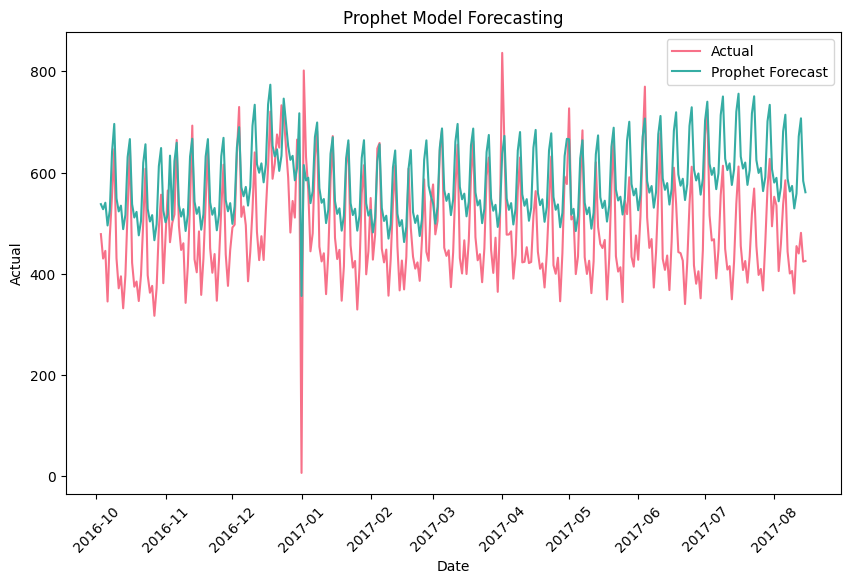

In [11]:
plot_predictions(df_results['date'], df_results['actual'], df_results['yhat'], 'Prophet Forecast', 'Prophet Model Forecasting')

In [12]:
df_train_p.shape

(1935987, 5)

In [13]:
df_test_p.shape

(553141, 5)